## Sequential LSTM and Convolution
## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13742612482883455546
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7080676557
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6523484150859883985
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_3-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_3)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        [(None, None, 128),  68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

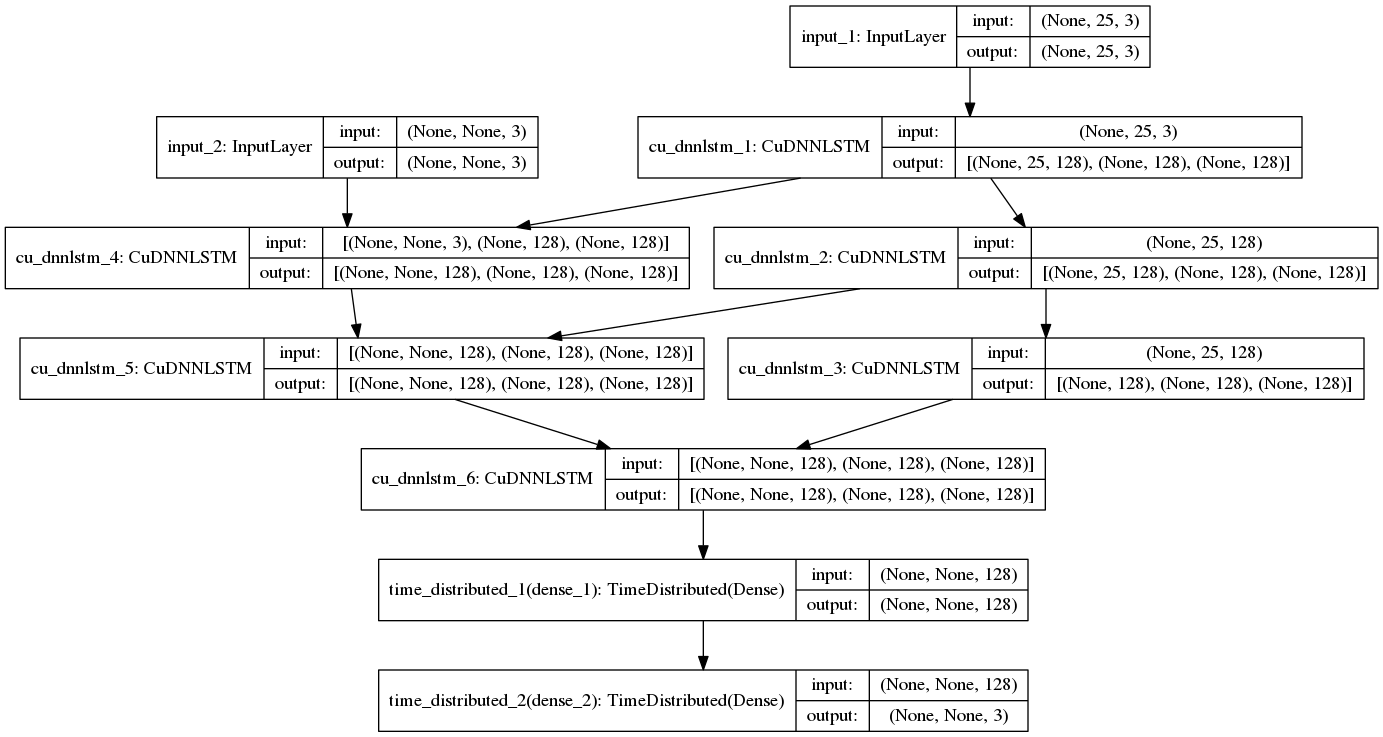

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_state_input_h3 = Input(shape=(latent_dim,))
decoder_state_input_c3 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2,
                         decoder_state_input_h3, decoder_state_input_c3]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_outputs_2, state_h2, state_c2 = decoder_2(decoder_outputs_1, initial_state=decoder_states_inputs[2:4])
decoder_outputs_3, state_h3, state_c3 = decoder_3(decoder_outputs_2, initial_state=decoder_states_inputs[4:6])
decoder_states = [state_h1, state_c1,
                  state_h2, state_c2,
                  state_h3, state_c3,
                 ]

dense_output_1 = dense_1(decoder_outputs_3)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1, h2, c2, h3, c3]

    return decoded_seq

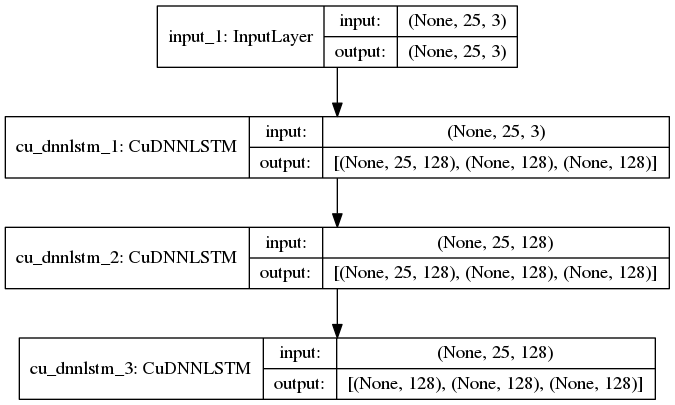

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

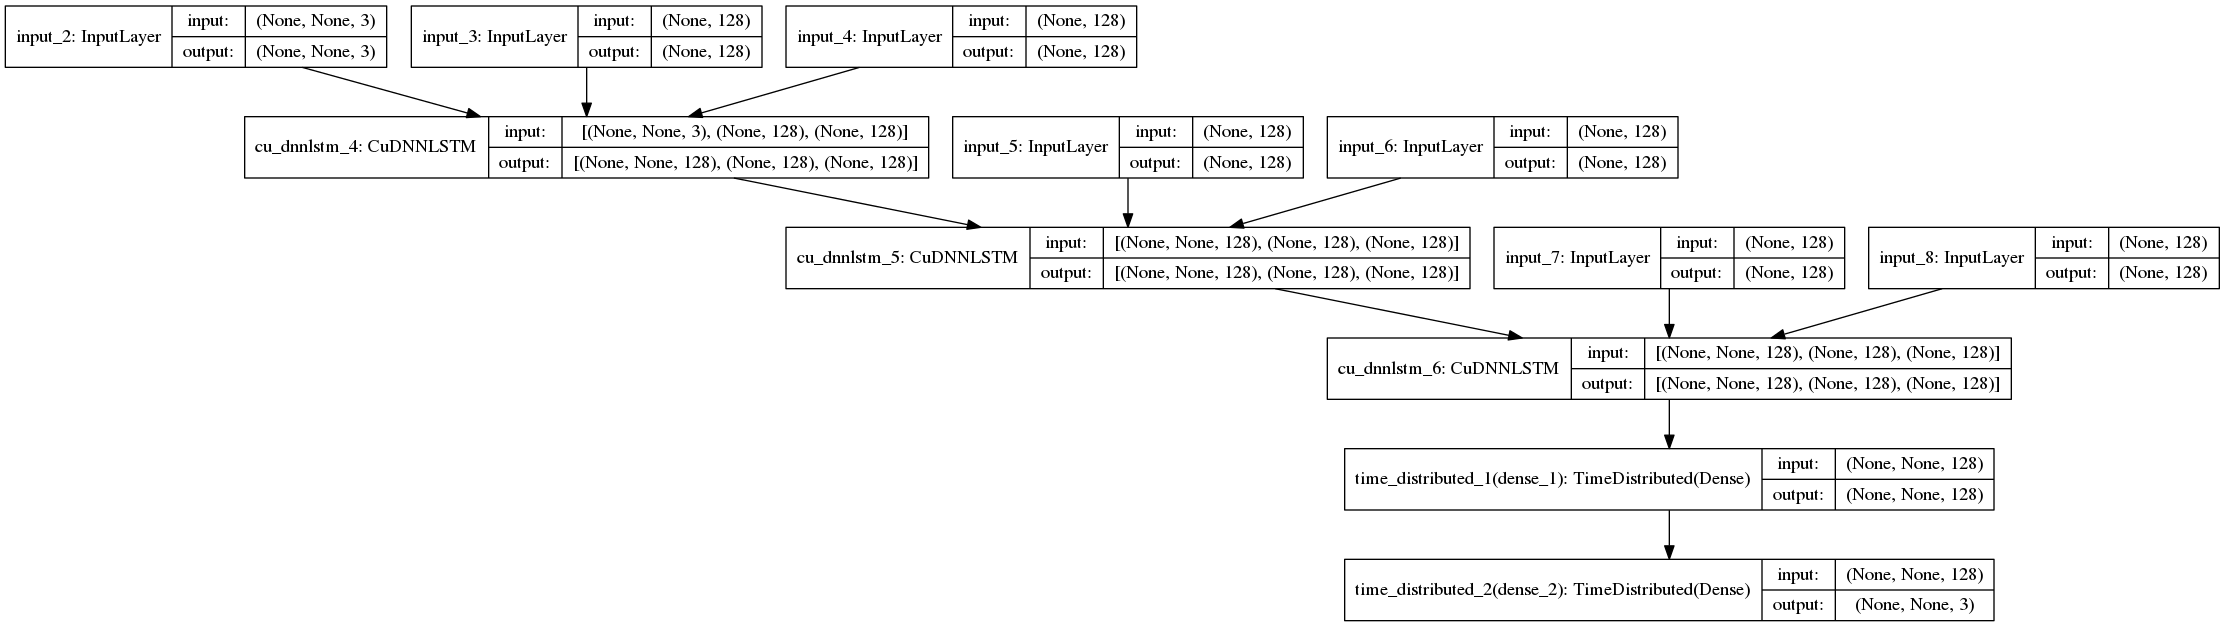

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

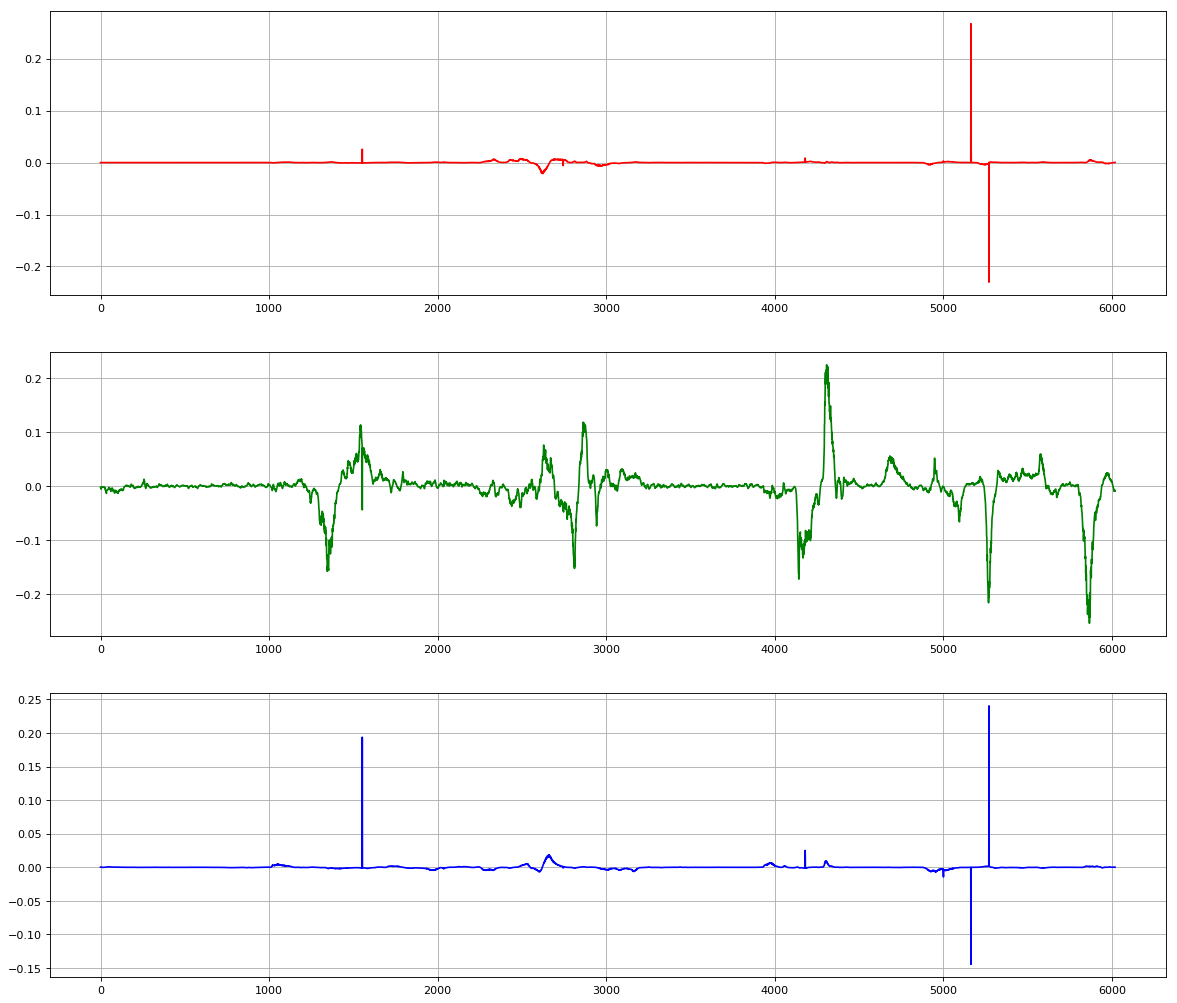

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 12:08 - loss: 0.0580 - rmse: 0.1457

  2/542 [..............................] - ETA: 6:44 - loss: 0.0499 - rmse: 0.1278 

  3/542 [..............................] - ETA: 4:58 - loss: 0.0704 - rmse: 0.1858

  4/542 [..............................] - ETA: 4:05 - loss: 0.0561 - rmse: 0.1457

  5/542 [..............................] - ETA: 3:34 - loss: 0.0637 - rmse: 0.1671

  6/542 [..............................] - ETA: 3:13 - loss: 0.0611 - rmse: 0.1634

  7/542 [..............................] - ETA: 2:58 - loss: 0.0604 - rmse: 0.1603

  8/542 [..............................] - ETA: 2:46 - loss: 0.0618 - rmse: 0.1616

  9/542 [..............................] - ETA: 2:36 - loss: 0.0626 - rmse: 0.1637

 10/542 [..............................] - ETA: 2:28 - loss: 0.0623 - rmse: 0.1626

 11/542 [..............................] - ETA: 2:22 - loss: 0.0592 - rmse: 0.1612

 12/542 [..............................] - ETA: 2:17 - loss: 0.0597 - rmse: 0.1722

 13/542 [..............................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1615

 14/542 [..............................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1598

 15/542 [..............................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1629

 16/542 [..............................] - ETA: 1:59 - loss: 0.0579 - rmse: 0.1657

 17/542 [..............................] - ETA: 1:56 - loss: 0.0601 - rmse: 0.1706

 18/542 [..............................] - ETA: 1:54 - loss: 0.0618 - rmse: 0.1742

 19/542 [>.............................] - ETA: 1:52 - loss: 0.0612 - rmse: 0.1714

 20/542 [>.............................] - ETA: 1:50 - loss: 0.0589 - rmse: 0.1644

 21/542 [>.............................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1621

 22/542 [>.............................] - ETA: 1:47 - loss: 0.0591 - rmse: 0.1642

 23/542 [>.............................] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1593

 24/542 [>.............................] - ETA: 1:44 - loss: 0.0579 - rmse: 0.1602

 25/542 [>.............................] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1575

 26/542 [>.............................] - ETA: 1:42 - loss: 0.0577 - rmse: 0.1624

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0597 - rmse: 0.1672

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0599 - rmse: 0.1667

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0600 - rmse: 0.1667

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0607 - rmse: 0.1695

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0609 - rmse: 0.1695

 32/542 [>.............................] - ETA: 1:36 - loss: 0.0610 - rmse: 0.1697

 33/542 [>.............................] - ETA: 1:35 - loss: 0.0612 - rmse: 0.1703

 34/542 [>.............................] - ETA: 1:35 - loss: 0.0625 - rmse: 0.1726

 35/542 [>.............................] - ETA: 1:34 - loss: 0.0627 - rmse: 0.1744

 36/542 [>.............................] - ETA: 1:33 - loss: 0.0627 - rmse: 0.1736

 37/542 [=>............................] - ETA: 1:33 - loss: 0.0617 - rmse: 0.1706

 38/542 [=>............................] - ETA: 1:32 - loss: 0.0622 - rmse: 0.1723

 39/542 [=>............................] - ETA: 1:31 - loss: 0.0624 - rmse: 0.1725

 40/542 [=>............................] - ETA: 1:31 - loss: 0.0624 - rmse: 0.1724

 41/542 [=>............................] - ETA: 1:30 - loss: 0.0617 - rmse: 0.1713

 42/542 [=>............................] - ETA: 1:30 - loss: 0.0618 - rmse: 0.1715

 43/542 [=>............................] - ETA: 1:29 - loss: 0.0614 - rmse: 0.1706

 44/542 [=>............................] - ETA: 1:28 - loss: 0.0610 - rmse: 0.1692

 45/542 [=>............................] - ETA: 1:28 - loss: 0.0612 - rmse: 0.1698

 46/542 [=>............................] - ETA: 1:27 - loss: 0.0611 - rmse: 0.1688

 47/542 [=>............................] - ETA: 1:27 - loss: 0.0612 - rmse: 0.1698

 48/542 [=>............................] - ETA: 1:26 - loss: 0.0612 - rmse: 0.1701

 49/542 [=>............................] - ETA: 1:26 - loss: 0.0610 - rmse: 0.1706

 50/542 [=>............................] - ETA: 1:26 - loss: 0.0601 - rmse: 0.1686

 51/542 [=>............................] - ETA: 1:25 - loss: 0.0597 - rmse: 0.1671

 52/542 [=>............................] - ETA: 1:25 - loss: 0.0604 - rmse: 0.1690

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0605 - rmse: 0.1691

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0600 - rmse: 0.1678

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0594 - rmse: 0.1661

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0591 - rmse: 0.1659

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0589 - rmse: 0.1654

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0590 - rmse: 0.1652

 59/542 [==>...........................] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1648

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0590 - rmse: 0.1647

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1631

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1623

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1628

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1638

 65/542 [==>...........................] - ETA: 1:20 - loss: 0.0582 - rmse: 0.1626

 66/542 [==>...........................] - ETA: 1:20 - loss: 0.0581 - rmse: 0.1616

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0580 - rmse: 0.1615

 68/542 [==>...........................] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1614

 69/542 [==>...........................] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1611

 70/542 [==>...........................] - ETA: 1:19 - loss: 0.0585 - rmse: 0.1621

 71/542 [==>...........................] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1611

 72/542 [==>...........................] - ETA: 1:18 - loss: 0.0582 - rmse: 0.1605

 73/542 [===>..........................] - ETA: 1:18 - loss: 0.0581 - rmse: 0.1603

 74/542 [===>..........................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1596

 75/542 [===>..........................] - ETA: 1:17 - loss: 0.0580 - rmse: 0.1594

 76/542 [===>..........................] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1585

 77/542 [===>..........................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1567

 78/542 [===>..........................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1566

 79/542 [===>..........................] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1552

 80/542 [===>..........................] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1558

 81/542 [===>..........................] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1551

 82/542 [===>..........................] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1541

 83/542 [===>..........................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1536

 84/542 [===>..........................] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1534

 85/542 [===>..........................] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1531

 86/542 [===>..........................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1529

 87/542 [===>..........................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1527

 88/542 [===>..........................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1522

 89/542 [===>..........................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1518

 90/542 [===>..........................] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1511

 91/542 [====>.........................] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1502

 92/542 [====>.........................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1496

 93/542 [====>.........................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1493

 94/542 [====>.........................] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1485

 95/542 [====>.........................] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1487

 96/542 [====>.........................] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1479

 97/542 [====>.........................] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1482

 98/542 [====>.........................] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1474

 99/542 [====>.........................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1466

100/542 [====>.........................] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1461

101/542 [====>.........................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1458

102/542 [====>.........................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1447

103/542 [====>.........................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1441

104/542 [====>.........................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1434

105/542 [====>.........................] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1431

106/542 [====>.........................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1429

107/542 [====>.........................] - ETA: 1:10 - loss: 0.0530 - rmse: 0.1423

108/542 [====>.........................] - ETA: 1:09 - loss: 0.0527 - rmse: 0.1414

109/542 [=====>........................] - ETA: 1:09 - loss: 0.0525 - rmse: 0.1406

110/542 [=====>........................] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1403

111/542 [=====>........................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1398

112/542 [=====>........................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1398

113/542 [=====>........................] - ETA: 1:08 - loss: 0.0520 - rmse: 0.1392

114/542 [=====>........................] - ETA: 1:08 - loss: 0.0517 - rmse: 0.1385

115/542 [=====>........................] - ETA: 1:08 - loss: 0.0514 - rmse: 0.1378

116/542 [=====>........................] - ETA: 1:08 - loss: 0.0512 - rmse: 0.1370

117/542 [=====>........................] - ETA: 1:08 - loss: 0.0509 - rmse: 0.1362

118/542 [=====>........................] - ETA: 1:07 - loss: 0.0507 - rmse: 0.1356

119/542 [=====>........................] - ETA: 1:07 - loss: 0.0504 - rmse: 0.1348

120/542 [=====>........................] - ETA: 1:07 - loss: 0.0502 - rmse: 0.1342

121/542 [=====>........................] - ETA: 1:07 - loss: 0.0499 - rmse: 0.1334

122/542 [=====>........................] - ETA: 1:06 - loss: 0.0497 - rmse: 0.1329

123/542 [=====>........................] - ETA: 1:06 - loss: 0.0495 - rmse: 0.1323

124/542 [=====>........................] - ETA: 1:06 - loss: 0.0494 - rmse: 0.1321

125/542 [=====>........................] - ETA: 1:06 - loss: 0.0492 - rmse: 0.1317

126/542 [=====>........................] - ETA: 1:06 - loss: 0.0491 - rmse: 0.1311

127/542 [======>.......................] - ETA: 1:06 - loss: 0.0492 - rmse: 0.1313

128/542 [======>.......................] - ETA: 1:05 - loss: 0.0490 - rmse: 0.1308

129/542 [======>.......................] - ETA: 1:05 - loss: 0.0490 - rmse: 0.1306

130/542 [======>.......................] - ETA: 1:05 - loss: 0.0491 - rmse: 0.1305

131/542 [======>.......................] - ETA: 1:05 - loss: 0.0489 - rmse: 0.1302

132/542 [======>.......................] - ETA: 1:04 - loss: 0.0490 - rmse: 0.1304

133/542 [======>.......................] - ETA: 1:04 - loss: 0.0490 - rmse: 0.1302

134/542 [======>.......................] - ETA: 1:04 - loss: 0.0489 - rmse: 0.1299

135/542 [======>.......................] - ETA: 1:04 - loss: 0.0490 - rmse: 0.1300

136/542 [======>.......................] - ETA: 1:04 - loss: 0.0487 - rmse: 0.1293

137/542 [======>.......................] - ETA: 1:04 - loss: 0.0486 - rmse: 0.1289

138/542 [======>.......................] - ETA: 1:03 - loss: 0.0486 - rmse: 0.1287

139/542 [======>.......................] - ETA: 1:03 - loss: 0.0484 - rmse: 0.1281

140/542 [======>.......................] - ETA: 1:03 - loss: 0.0483 - rmse: 0.1278

141/542 [======>.......................] - ETA: 1:03 - loss: 0.0483 - rmse: 0.1279

142/542 [======>.......................] - ETA: 1:03 - loss: 0.0483 - rmse: 0.1277

143/542 [======>.......................] - ETA: 1:02 - loss: 0.0482 - rmse: 0.1273

144/542 [======>.......................] - ETA: 1:02 - loss: 0.0481 - rmse: 0.1270

145/542 [=======>......................] - ETA: 1:02 - loss: 0.0479 - rmse: 0.1265

146/542 [=======>......................] - ETA: 1:02 - loss: 0.0480 - rmse: 0.1264

147/542 [=======>......................] - ETA: 1:02 - loss: 0.0480 - rmse: 0.1263

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0479 - rmse: 0.1261

149/542 [=======>......................] - ETA: 1:01 - loss: 0.0479 - rmse: 0.1259

150/542 [=======>......................] - ETA: 1:01 - loss: 0.0477 - rmse: 0.1255

151/542 [=======>......................] - ETA: 1:01 - loss: 0.0476 - rmse: 0.1251

152/542 [=======>......................] - ETA: 1:01 - loss: 0.0475 - rmse: 0.1249

153/542 [=======>......................] - ETA: 1:01 - loss: 0.0474 - rmse: 0.1247

154/542 [=======>......................] - ETA: 1:00 - loss: 0.0474 - rmse: 0.1245

155/542 [=======>......................] - ETA: 1:00 - loss: 0.0474 - rmse: 0.1244

156/542 [=======>......................] - ETA: 1:00 - loss: 0.0474 - rmse: 0.1244

157/542 [=======>......................] - ETA: 1:00 - loss: 0.0473 - rmse: 0.1241

158/542 [=======>......................] - ETA: 1:00 - loss: 0.0472 - rmse: 0.1238

159/542 [=======>......................] - ETA: 59s - loss: 0.0471 - rmse: 0.1234 

160/542 [=======>......................] - ETA: 59s - loss: 0.0470 - rmse: 0.1231

161/542 [=======>......................] - ETA: 59s - loss: 0.0470 - rmse: 0.1230

162/542 [=======>......................] - ETA: 59s - loss: 0.0468 - rmse: 0.1224

163/542 [========>.....................] - ETA: 59s - loss: 0.0468 - rmse: 0.1223

164/542 [========>.....................] - ETA: 59s - loss: 0.0467 - rmse: 0.1220

165/542 [========>.....................] - ETA: 58s - loss: 0.0465 - rmse: 0.1216

166/542 [========>.....................] - ETA: 58s - loss: 0.0465 - rmse: 0.1216

167/542 [========>.....................] - ETA: 58s - loss: 0.0463 - rmse: 0.1213

168/542 [========>.....................] - ETA: 58s - loss: 0.0462 - rmse: 0.1210

169/542 [========>.....................] - ETA: 58s - loss: 0.0461 - rmse: 0.1206

170/542 [========>.....................] - ETA: 58s - loss: 0.0461 - rmse: 0.1204

171/542 [========>.....................] - ETA: 57s - loss: 0.0461 - rmse: 0.1202

172/542 [========>.....................] - ETA: 57s - loss: 0.0460 - rmse: 0.1201

173/542 [========>.....................] - ETA: 57s - loss: 0.0459 - rmse: 0.1198

174/542 [========>.....................] - ETA: 57s - loss: 0.0458 - rmse: 0.1196

175/542 [========>.....................] - ETA: 57s - loss: 0.0457 - rmse: 0.1193

176/542 [========>.....................] - ETA: 57s - loss: 0.0457 - rmse: 0.1193

177/542 [========>.....................] - ETA: 56s - loss: 0.0459 - rmse: 0.1197

178/542 [========>.....................] - ETA: 56s - loss: 0.0457 - rmse: 0.1193

179/542 [========>.....................] - ETA: 56s - loss: 0.0457 - rmse: 0.1191

180/542 [========>.....................] - ETA: 56s - loss: 0.0456 - rmse: 0.1189

181/542 [=========>....................] - ETA: 56s - loss: 0.0456 - rmse: 0.1188

182/542 [=========>....................] - ETA: 56s - loss: 0.0455 - rmse: 0.1185

183/542 [=========>....................] - ETA: 55s - loss: 0.0455 - rmse: 0.1184

184/542 [=========>....................] - ETA: 55s - loss: 0.0453 - rmse: 0.1180

185/542 [=========>....................] - ETA: 55s - loss: 0.0453 - rmse: 0.1178

186/542 [=========>....................] - ETA: 55s - loss: 0.0453 - rmse: 0.1176

187/542 [=========>....................] - ETA: 55s - loss: 0.0452 - rmse: 0.1173

188/542 [=========>....................] - ETA: 54s - loss: 0.0453 - rmse: 0.1175

189/542 [=========>....................] - ETA: 54s - loss: 0.0452 - rmse: 0.1172

190/542 [=========>....................] - ETA: 54s - loss: 0.0451 - rmse: 0.1170

191/542 [=========>....................] - ETA: 54s - loss: 0.0450 - rmse: 0.1167

192/542 [=========>....................] - ETA: 54s - loss: 0.0450 - rmse: 0.1166

193/542 [=========>....................] - ETA: 54s - loss: 0.0448 - rmse: 0.1162

194/542 [=========>....................] - ETA: 53s - loss: 0.0448 - rmse: 0.1163

195/542 [=========>....................] - ETA: 53s - loss: 0.0448 - rmse: 0.1161

196/542 [=========>....................] - ETA: 53s - loss: 0.0446 - rmse: 0.1156

197/542 [=========>....................] - ETA: 53s - loss: 0.0445 - rmse: 0.1152

198/542 [=========>....................] - ETA: 53s - loss: 0.0446 - rmse: 0.1153

199/542 [==========>...................] - ETA: 53s - loss: 0.0444 - rmse: 0.1149

200/542 [==========>...................] - ETA: 52s - loss: 0.0443 - rmse: 0.1146

201/542 [==========>...................] - ETA: 52s - loss: 0.0442 - rmse: 0.1142

202/542 [==========>...................] - ETA: 52s - loss: 0.0441 - rmse: 0.1139

203/542 [==========>...................] - ETA: 52s - loss: 0.0440 - rmse: 0.1135

204/542 [==========>...................] - ETA: 52s - loss: 0.0440 - rmse: 0.1134

205/542 [==========>...................] - ETA: 52s - loss: 0.0439 - rmse: 0.1135

206/542 [==========>...................] - ETA: 51s - loss: 0.0439 - rmse: 0.1134

207/542 [==========>...................] - ETA: 51s - loss: 0.0439 - rmse: 0.1134

208/542 [==========>...................] - ETA: 51s - loss: 0.0439 - rmse: 0.1133

209/542 [==========>...................] - ETA: 51s - loss: 0.0437 - rmse: 0.1128

210/542 [==========>...................] - ETA: 51s - loss: 0.0437 - rmse: 0.1125

211/542 [==========>...................] - ETA: 51s - loss: 0.0436 - rmse: 0.1122

212/542 [==========>...................] - ETA: 50s - loss: 0.0435 - rmse: 0.1121

213/542 [==========>...................] - ETA: 50s - loss: 0.0435 - rmse: 0.1122

214/542 [==========>...................] - ETA: 50s - loss: 0.0435 - rmse: 0.1121

215/542 [==========>...................] - ETA: 50s - loss: 0.0434 - rmse: 0.1118

216/542 [==========>...................] - ETA: 50s - loss: 0.0433 - rmse: 0.1115

217/542 [===========>..................] - ETA: 50s - loss: 0.0432 - rmse: 0.1112

218/542 [===========>..................] - ETA: 49s - loss: 0.0432 - rmse: 0.1111

219/542 [===========>..................] - ETA: 49s - loss: 0.0432 - rmse: 0.1111

220/542 [===========>..................] - ETA: 49s - loss: 0.0432 - rmse: 0.1110

221/542 [===========>..................] - ETA: 49s - loss: 0.0432 - rmse: 0.1108

222/542 [===========>..................] - ETA: 49s - loss: 0.0431 - rmse: 0.1109

223/542 [===========>..................] - ETA: 49s - loss: 0.0430 - rmse: 0.1107

224/542 [===========>..................] - ETA: 49s - loss: 0.0430 - rmse: 0.1106

225/542 [===========>..................] - ETA: 48s - loss: 0.0429 - rmse: 0.1104

226/542 [===========>..................] - ETA: 48s - loss: 0.0428 - rmse: 0.1102

227/542 [===========>..................] - ETA: 48s - loss: 0.0428 - rmse: 0.1101

228/542 [===========>..................] - ETA: 48s - loss: 0.0428 - rmse: 0.1099

229/542 [===========>..................] - ETA: 48s - loss: 0.0427 - rmse: 0.1097

230/542 [===========>..................] - ETA: 48s - loss: 0.0427 - rmse: 0.1097

231/542 [===========>..................] - ETA: 47s - loss: 0.0426 - rmse: 0.1094

232/542 [===========>..................] - ETA: 47s - loss: 0.0426 - rmse: 0.1094

233/542 [===========>..................] - ETA: 47s - loss: 0.0425 - rmse: 0.1092

234/542 [===========>..................] - ETA: 47s - loss: 0.0424 - rmse: 0.1090

235/542 [============>.................] - ETA: 47s - loss: 0.0423 - rmse: 0.1087

236/542 [============>.................] - ETA: 47s - loss: 0.0422 - rmse: 0.1086

237/542 [============>.................] - ETA: 46s - loss: 0.0422 - rmse: 0.1085

238/542 [============>.................] - ETA: 46s - loss: 0.0421 - rmse: 0.1083

239/542 [============>.................] - ETA: 46s - loss: 0.0421 - rmse: 0.1082

240/542 [============>.................] - ETA: 46s - loss: 0.0420 - rmse: 0.1081

241/542 [============>.................] - ETA: 46s - loss: 0.0420 - rmse: 0.1080

242/542 [============>.................] - ETA: 46s - loss: 0.0420 - rmse: 0.1079

243/542 [============>.................] - ETA: 45s - loss: 0.0420 - rmse: 0.1078

244/542 [============>.................] - ETA: 45s - loss: 0.0419 - rmse: 0.1076

245/542 [============>.................] - ETA: 45s - loss: 0.0419 - rmse: 0.1076

246/542 [============>.................] - ETA: 45s - loss: 0.0419 - rmse: 0.1076

247/542 [============>.................] - ETA: 45s - loss: 0.0418 - rmse: 0.1074

248/542 [============>.................] - ETA: 45s - loss: 0.0417 - rmse: 0.1073

249/542 [============>.................] - ETA: 44s - loss: 0.0417 - rmse: 0.1071

250/542 [============>.................] - ETA: 44s - loss: 0.0416 - rmse: 0.1069

251/542 [============>.................] - ETA: 44s - loss: 0.0416 - rmse: 0.1069

252/542 [============>.................] - ETA: 44s - loss: 0.0416 - rmse: 0.1069

253/542 [=============>................] - ETA: 44s - loss: 0.0416 - rmse: 0.1068

254/542 [=============>................] - ETA: 44s - loss: 0.0415 - rmse: 0.1068

255/542 [=============>................] - ETA: 44s - loss: 0.0415 - rmse: 0.1067

256/542 [=============>................] - ETA: 43s - loss: 0.0414 - rmse: 0.1066

257/542 [=============>................] - ETA: 43s - loss: 0.0414 - rmse: 0.1065

258/542 [=============>................] - ETA: 43s - loss: 0.0415 - rmse: 0.1067

259/542 [=============>................] - ETA: 43s - loss: 0.0415 - rmse: 0.1068

260/542 [=============>................] - ETA: 43s - loss: 0.0415 - rmse: 0.1068

261/542 [=============>................] - ETA: 43s - loss: 0.0415 - rmse: 0.1068

262/542 [=============>................] - ETA: 42s - loss: 0.0415 - rmse: 0.1067

263/542 [=============>................] - ETA: 42s - loss: 0.0415 - rmse: 0.1068

264/542 [=============>................] - ETA: 42s - loss: 0.0415 - rmse: 0.1066

265/542 [=============>................] - ETA: 42s - loss: 0.0415 - rmse: 0.1066

266/542 [=============>................] - ETA: 42s - loss: 0.0414 - rmse: 0.1064

267/542 [=============>................] - ETA: 42s - loss: 0.0414 - rmse: 0.1063

268/542 [=============>................] - ETA: 42s - loss: 0.0413 - rmse: 0.1061

269/542 [=============>................] - ETA: 41s - loss: 0.0412 - rmse: 0.1058

270/542 [=============>................] - ETA: 41s - loss: 0.0411 - rmse: 0.1055

271/542 [==============>...............] - ETA: 41s - loss: 0.0412 - rmse: 0.1055

272/542 [==============>...............] - ETA: 41s - loss: 0.0411 - rmse: 0.1055

273/542 [==============>...............] - ETA: 41s - loss: 0.0411 - rmse: 0.1054

274/542 [==============>...............] - ETA: 41s - loss: 0.0410 - rmse: 0.1052

275/542 [==============>...............] - ETA: 41s - loss: 0.0410 - rmse: 0.1051

276/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1051

277/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1053

278/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1051

279/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1051

280/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1051

281/542 [==============>...............] - ETA: 40s - loss: 0.0410 - rmse: 0.1049

282/542 [==============>...............] - ETA: 39s - loss: 0.0409 - rmse: 0.1048

283/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1046

284/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1044

285/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1046

286/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1046

287/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1047

288/542 [==============>...............] - ETA: 39s - loss: 0.0408 - rmse: 0.1045

289/542 [==============>...............] - ETA: 38s - loss: 0.0408 - rmse: 0.1045

290/542 [===============>..............] - ETA: 38s - loss: 0.0407 - rmse: 0.1044

291/542 [===============>..............] - ETA: 38s - loss: 0.0407 - rmse: 0.1042

292/542 [===============>..............] - ETA: 38s - loss: 0.0407 - rmse: 0.1043

293/542 [===============>..............] - ETA: 38s - loss: 0.0407 - rmse: 0.1042

294/542 [===============>..............] - ETA: 38s - loss: 0.0407 - rmse: 0.1041

295/542 [===============>..............] - ETA: 37s - loss: 0.0407 - rmse: 0.1041

296/542 [===============>..............] - ETA: 37s - loss: 0.0406 - rmse: 0.1038

297/542 [===============>..............] - ETA: 37s - loss: 0.0405 - rmse: 0.1037

298/542 [===============>..............] - ETA: 37s - loss: 0.0405 - rmse: 0.1037

299/542 [===============>..............] - ETA: 37s - loss: 0.0405 - rmse: 0.1036

300/542 [===============>..............] - ETA: 37s - loss: 0.0405 - rmse: 0.1035

301/542 [===============>..............] - ETA: 37s - loss: 0.0405 - rmse: 0.1034

302/542 [===============>..............] - ETA: 36s - loss: 0.0404 - rmse: 0.1034

303/542 [===============>..............] - ETA: 36s - loss: 0.0404 - rmse: 0.1033

304/542 [===============>..............] - ETA: 36s - loss: 0.0404 - rmse: 0.1032

305/542 [===============>..............] - ETA: 36s - loss: 0.0404 - rmse: 0.1032

306/542 [===============>..............] - ETA: 36s - loss: 0.0403 - rmse: 0.1031

307/542 [===============>..............] - ETA: 36s - loss: 0.0403 - rmse: 0.1029

308/542 [================>.............] - ETA: 35s - loss: 0.0402 - rmse: 0.1028

309/542 [================>.............] - ETA: 35s - loss: 0.0402 - rmse: 0.1028

310/542 [================>.............] - ETA: 35s - loss: 0.0402 - rmse: 0.1027

311/542 [================>.............] - ETA: 35s - loss: 0.0401 - rmse: 0.1026

312/542 [================>.............] - ETA: 35s - loss: 0.0401 - rmse: 0.1024

313/542 [================>.............] - ETA: 35s - loss: 0.0400 - rmse: 0.1023

314/542 [================>.............] - ETA: 34s - loss: 0.0401 - rmse: 0.1024

315/542 [================>.............] - ETA: 34s - loss: 0.0401 - rmse: 0.1025

316/542 [================>.............] - ETA: 34s - loss: 0.0400 - rmse: 0.1022

317/542 [================>.............] - ETA: 34s - loss: 0.0400 - rmse: 0.1021

318/542 [================>.............] - ETA: 34s - loss: 0.0400 - rmse: 0.1022

319/542 [================>.............] - ETA: 34s - loss: 0.0400 - rmse: 0.1021

320/542 [================>.............] - ETA: 34s - loss: 0.0400 - rmse: 0.1020

321/542 [================>.............] - ETA: 33s - loss: 0.0399 - rmse: 0.1020

322/542 [================>.............] - ETA: 33s - loss: 0.0400 - rmse: 0.1021

323/542 [================>.............] - ETA: 33s - loss: 0.0400 - rmse: 0.1022

324/542 [================>.............] - ETA: 33s - loss: 0.0401 - rmse: 0.1024

325/542 [================>.............] - ETA: 33s - loss: 0.0400 - rmse: 0.1023

326/542 [=================>............] - ETA: 33s - loss: 0.0399 - rmse: 0.1021

327/542 [=================>............] - ETA: 32s - loss: 0.0400 - rmse: 0.1021

328/542 [=================>............] - ETA: 32s - loss: 0.0399 - rmse: 0.1019

329/542 [=================>............] - ETA: 32s - loss: 0.0398 - rmse: 0.1018

330/542 [=================>............] - ETA: 32s - loss: 0.0398 - rmse: 0.1016

331/542 [=================>............] - ETA: 32s - loss: 0.0398 - rmse: 0.1017

332/542 [=================>............] - ETA: 32s - loss: 0.0397 - rmse: 0.1016

333/542 [=================>............] - ETA: 32s - loss: 0.0397 - rmse: 0.1016

334/542 [=================>............] - ETA: 31s - loss: 0.0397 - rmse: 0.1016

335/542 [=================>............] - ETA: 31s - loss: 0.0397 - rmse: 0.1014

336/542 [=================>............] - ETA: 31s - loss: 0.0396 - rmse: 0.1013

337/542 [=================>............] - ETA: 31s - loss: 0.0396 - rmse: 0.1011

338/542 [=================>............] - ETA: 31s - loss: 0.0396 - rmse: 0.1011

339/542 [=================>............] - ETA: 31s - loss: 0.0396 - rmse: 0.1011

340/542 [=================>............] - ETA: 30s - loss: 0.0396 - rmse: 0.1011

341/542 [=================>............] - ETA: 30s - loss: 0.0397 - rmse: 0.1012

342/542 [=================>............] - ETA: 30s - loss: 0.0397 - rmse: 0.1013

343/542 [=================>............] - ETA: 30s - loss: 0.0397 - rmse: 0.1012

344/542 [==================>...........] - ETA: 30s - loss: 0.0396 - rmse: 0.1012

345/542 [==================>...........] - ETA: 30s - loss: 0.0396 - rmse: 0.1010

346/542 [==================>...........] - ETA: 29s - loss: 0.0396 - rmse: 0.1010

347/542 [==================>...........] - ETA: 29s - loss: 0.0396 - rmse: 0.1009

348/542 [==================>...........] - ETA: 29s - loss: 0.0395 - rmse: 0.1008

349/542 [==================>...........] - ETA: 29s - loss: 0.0395 - rmse: 0.1007

350/542 [==================>...........] - ETA: 29s - loss: 0.0395 - rmse: 0.1006

351/542 [==================>...........] - ETA: 29s - loss: 0.0394 - rmse: 0.1005

352/542 [==================>...........] - ETA: 29s - loss: 0.0394 - rmse: 0.1004

353/542 [==================>...........] - ETA: 28s - loss: 0.0394 - rmse: 0.1003

354/542 [==================>...........] - ETA: 28s - loss: 0.0393 - rmse: 0.1001

355/542 [==================>...........] - ETA: 28s - loss: 0.0392 - rmse: 0.1000

356/542 [==================>...........] - ETA: 28s - loss: 0.0392 - rmse: 0.0998

357/542 [==================>...........] - ETA: 28s - loss: 0.0391 - rmse: 0.0998

358/542 [==================>...........] - ETA: 28s - loss: 0.0392 - rmse: 0.0998

359/542 [==================>...........] - ETA: 27s - loss: 0.0391 - rmse: 0.0996

360/542 [==================>...........] - ETA: 27s - loss: 0.0391 - rmse: 0.0996

361/542 [==================>...........] - ETA: 27s - loss: 0.0390 - rmse: 0.0995

362/542 [===================>..........] - ETA: 27s - loss: 0.0390 - rmse: 0.0994

363/542 [===================>..........] - ETA: 27s - loss: 0.0390 - rmse: 0.0992

364/542 [===================>..........] - ETA: 27s - loss: 0.0389 - rmse: 0.0990

365/542 [===================>..........] - ETA: 26s - loss: 0.0390 - rmse: 0.0992

366/542 [===================>..........] - ETA: 26s - loss: 0.0389 - rmse: 0.0991

367/542 [===================>..........] - ETA: 26s - loss: 0.0389 - rmse: 0.0991

368/542 [===================>..........] - ETA: 26s - loss: 0.0389 - rmse: 0.0991

369/542 [===================>..........] - ETA: 26s - loss: 0.0389 - rmse: 0.0992

370/542 [===================>..........] - ETA: 26s - loss: 0.0389 - rmse: 0.0991

371/542 [===================>..........] - ETA: 26s - loss: 0.0388 - rmse: 0.0989

372/542 [===================>..........] - ETA: 25s - loss: 0.0388 - rmse: 0.0989

373/542 [===================>..........] - ETA: 25s - loss: 0.0388 - rmse: 0.0988

374/542 [===================>..........] - ETA: 25s - loss: 0.0387 - rmse: 0.0986

375/542 [===================>..........] - ETA: 25s - loss: 0.0386 - rmse: 0.0984

376/542 [===================>..........] - ETA: 25s - loss: 0.0386 - rmse: 0.0983

377/542 [===================>..........] - ETA: 25s - loss: 0.0386 - rmse: 0.0982

378/542 [===================>..........] - ETA: 24s - loss: 0.0385 - rmse: 0.0981

379/542 [===================>..........] - ETA: 24s - loss: 0.0385 - rmse: 0.0981

380/542 [====================>.........] - ETA: 24s - loss: 0.0385 - rmse: 0.0981

381/542 [====================>.........] - ETA: 24s - loss: 0.0385 - rmse: 0.0981

382/542 [====================>.........] - ETA: 24s - loss: 0.0385 - rmse: 0.0982

383/542 [====================>.........] - ETA: 24s - loss: 0.0385 - rmse: 0.0982

384/542 [====================>.........] - ETA: 24s - loss: 0.0385 - rmse: 0.0982

385/542 [====================>.........] - ETA: 23s - loss: 0.0385 - rmse: 0.0980

386/542 [====================>.........] - ETA: 23s - loss: 0.0384 - rmse: 0.0978

387/542 [====================>.........] - ETA: 23s - loss: 0.0384 - rmse: 0.0978

388/542 [====================>.........] - ETA: 23s - loss: 0.0383 - rmse: 0.0977

389/542 [====================>.........] - ETA: 23s - loss: 0.0383 - rmse: 0.0976

390/542 [====================>.........] - ETA: 23s - loss: 0.0383 - rmse: 0.0975

391/542 [====================>.........] - ETA: 23s - loss: 0.0382 - rmse: 0.0973

392/542 [====================>.........] - ETA: 22s - loss: 0.0382 - rmse: 0.0973

393/542 [====================>.........] - ETA: 22s - loss: 0.0381 - rmse: 0.0972

394/542 [====================>.........] - ETA: 22s - loss: 0.0381 - rmse: 0.0970

395/542 [====================>.........] - ETA: 22s - loss: 0.0380 - rmse: 0.0968

396/542 [====================>.........] - ETA: 22s - loss: 0.0380 - rmse: 0.0968

397/542 [====================>.........] - ETA: 22s - loss: 0.0380 - rmse: 0.0967

398/542 [=====================>........] - ETA: 21s - loss: 0.0379 - rmse: 0.0967

399/542 [=====================>........] - ETA: 21s - loss: 0.0379 - rmse: 0.0966

400/542 [=====================>........] - ETA: 21s - loss: 0.0380 - rmse: 0.0967

401/542 [=====================>........] - ETA: 21s - loss: 0.0380 - rmse: 0.0967

402/542 [=====================>........] - ETA: 21s - loss: 0.0379 - rmse: 0.0966

403/542 [=====================>........] - ETA: 21s - loss: 0.0379 - rmse: 0.0965

404/542 [=====================>........] - ETA: 21s - loss: 0.0379 - rmse: 0.0965

405/542 [=====================>........] - ETA: 20s - loss: 0.0378 - rmse: 0.0963

406/542 [=====================>........] - ETA: 20s - loss: 0.0379 - rmse: 0.0964

407/542 [=====================>........] - ETA: 20s - loss: 0.0378 - rmse: 0.0962

408/542 [=====================>........] - ETA: 20s - loss: 0.0378 - rmse: 0.0962

409/542 [=====================>........] - ETA: 20s - loss: 0.0378 - rmse: 0.0961

410/542 [=====================>........] - ETA: 20s - loss: 0.0378 - rmse: 0.0962

411/542 [=====================>........] - ETA: 19s - loss: 0.0377 - rmse: 0.0960

412/542 [=====================>........] - ETA: 19s - loss: 0.0377 - rmse: 0.0960

413/542 [=====================>........] - ETA: 19s - loss: 0.0377 - rmse: 0.0960

414/542 [=====================>........] - ETA: 19s - loss: 0.0376 - rmse: 0.0959

415/542 [=====================>........] - ETA: 19s - loss: 0.0376 - rmse: 0.0957

416/542 [======================>.......] - ETA: 19s - loss: 0.0376 - rmse: 0.0956

417/542 [======================>.......] - ETA: 19s - loss: 0.0376 - rmse: 0.0956

418/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0955

419/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0954

420/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0954

421/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0953

422/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0953

423/542 [======================>.......] - ETA: 18s - loss: 0.0375 - rmse: 0.0953

424/542 [======================>.......] - ETA: 17s - loss: 0.0374 - rmse: 0.0953

425/542 [======================>.......] - ETA: 17s - loss: 0.0374 - rmse: 0.0952

426/542 [======================>.......] - ETA: 17s - loss: 0.0374 - rmse: 0.0952

427/542 [======================>.......] - ETA: 17s - loss: 0.0374 - rmse: 0.0951

428/542 [======================>.......] - ETA: 17s - loss: 0.0374 - rmse: 0.0950

429/542 [======================>.......] - ETA: 17s - loss: 0.0373 - rmse: 0.0949

430/542 [======================>.......] - ETA: 17s - loss: 0.0373 - rmse: 0.0948

431/542 [======================>.......] - ETA: 16s - loss: 0.0373 - rmse: 0.0947

432/542 [======================>.......] - ETA: 16s - loss: 0.0373 - rmse: 0.0948

433/542 [======================>.......] - ETA: 16s - loss: 0.0373 - rmse: 0.0947

434/542 [=======================>......] - ETA: 16s - loss: 0.0373 - rmse: 0.0948

435/542 [=======================>......] - ETA: 16s - loss: 0.0373 - rmse: 0.0947

436/542 [=======================>......] - ETA: 16s - loss: 0.0373 - rmse: 0.0948

437/542 [=======================>......] - ETA: 15s - loss: 0.0372 - rmse: 0.0947

438/542 [=======================>......] - ETA: 15s - loss: 0.0372 - rmse: 0.0945

439/542 [=======================>......] - ETA: 15s - loss: 0.0372 - rmse: 0.0945

440/542 [=======================>......] - ETA: 15s - loss: 0.0371 - rmse: 0.0945

441/542 [=======================>......] - ETA: 15s - loss: 0.0371 - rmse: 0.0945

442/542 [=======================>......] - ETA: 15s - loss: 0.0371 - rmse: 0.0944

443/542 [=======================>......] - ETA: 15s - loss: 0.0371 - rmse: 0.0943

444/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0943

445/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0944

446/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0944

447/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0944

448/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0943

449/542 [=======================>......] - ETA: 14s - loss: 0.0371 - rmse: 0.0943

450/542 [=======================>......] - ETA: 13s - loss: 0.0371 - rmse: 0.0944

451/542 [=======================>......] - ETA: 13s - loss: 0.0371 - rmse: 0.0943

452/542 [========================>.....] - ETA: 13s - loss: 0.0371 - rmse: 0.0943

453/542 [========================>.....] - ETA: 13s - loss: 0.0371 - rmse: 0.0942

454/542 [========================>.....] - ETA: 13s - loss: 0.0370 - rmse: 0.0942

455/542 [========================>.....] - ETA: 13s - loss: 0.0370 - rmse: 0.0942

456/542 [========================>.....] - ETA: 13s - loss: 0.0370 - rmse: 0.0941

457/542 [========================>.....] - ETA: 12s - loss: 0.0370 - rmse: 0.0940

458/542 [========================>.....] - ETA: 12s - loss: 0.0370 - rmse: 0.0940

459/542 [========================>.....] - ETA: 12s - loss: 0.0370 - rmse: 0.0940

460/542 [========================>.....] - ETA: 12s - loss: 0.0369 - rmse: 0.0939

461/542 [========================>.....] - ETA: 12s - loss: 0.0369 - rmse: 0.0940

462/542 [========================>.....] - ETA: 12s - loss: 0.0369 - rmse: 0.0939

463/542 [========================>.....] - ETA: 11s - loss: 0.0369 - rmse: 0.0939

464/542 [========================>.....] - ETA: 11s - loss: 0.0369 - rmse: 0.0940

465/542 [========================>.....] - ETA: 11s - loss: 0.0369 - rmse: 0.0939

466/542 [========================>.....] - ETA: 11s - loss: 0.0368 - rmse: 0.0938

467/542 [========================>.....] - ETA: 11s - loss: 0.0368 - rmse: 0.0937

468/542 [========================>.....] - ETA: 11s - loss: 0.0368 - rmse: 0.0937

469/542 [========================>.....] - ETA: 11s - loss: 0.0367 - rmse: 0.0935

470/542 [=========================>....] - ETA: 10s - loss: 0.0368 - rmse: 0.0936

471/542 [=========================>....] - ETA: 10s - loss: 0.0367 - rmse: 0.0935

472/542 [=========================>....] - ETA: 10s - loss: 0.0368 - rmse: 0.0936

473/542 [=========================>....] - ETA: 10s - loss: 0.0367 - rmse: 0.0935

474/542 [=========================>....] - ETA: 10s - loss: 0.0367 - rmse: 0.0934

475/542 [=========================>....] - ETA: 10s - loss: 0.0366 - rmse: 0.0933

476/542 [=========================>....] - ETA: 10s - loss: 0.0366 - rmse: 0.0931

477/542 [=========================>....] - ETA: 9s - loss: 0.0366 - rmse: 0.0931 

478/542 [=========================>....] - ETA: 9s - loss: 0.0365 - rmse: 0.0930

479/542 [=========================>....] - ETA: 9s - loss: 0.0365 - rmse: 0.0929

480/542 [=========================>....] - ETA: 9s - loss: 0.0365 - rmse: 0.0929

481/542 [=========================>....] - ETA: 9s - loss: 0.0365 - rmse: 0.0929

482/542 [=========================>....] - ETA: 9s - loss: 0.0365 - rmse: 0.0929

483/542 [=========================>....] - ETA: 8s - loss: 0.0365 - rmse: 0.0928

484/542 [=========================>....] - ETA: 8s - loss: 0.0365 - rmse: 0.0929

485/542 [=========================>....] - ETA: 8s - loss: 0.0365 - rmse: 0.0928

486/542 [=========================>....] - ETA: 8s - loss: 0.0365 - rmse: 0.0928

487/542 [=========================>....] - ETA: 8s - loss: 0.0364 - rmse: 0.0927

488/542 [==========================>...] - ETA: 8s - loss: 0.0364 - rmse: 0.0926

489/542 [==========================>...] - ETA: 8s - loss: 0.0364 - rmse: 0.0926

490/542 [==========================>...] - ETA: 7s - loss: 0.0364 - rmse: 0.0926

491/542 [==========================>...] - ETA: 7s - loss: 0.0364 - rmse: 0.0926

492/542 [==========================>...] - ETA: 7s - loss: 0.0364 - rmse: 0.0925

493/542 [==========================>...] - ETA: 7s - loss: 0.0363 - rmse: 0.0925

494/542 [==========================>...] - ETA: 7s - loss: 0.0363 - rmse: 0.0924

495/542 [==========================>...] - ETA: 7s - loss: 0.0363 - rmse: 0.0923

496/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0923

497/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0923

498/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0924

499/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0923

500/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0923

501/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0923

502/542 [==========================>...] - ETA: 6s - loss: 0.0363 - rmse: 0.0922

503/542 [==========================>...] - ETA: 5s - loss: 0.0363 - rmse: 0.0923

504/542 [==========================>...] - ETA: 5s - loss: 0.0363 - rmse: 0.0924

505/542 [==========================>...] - ETA: 5s - loss: 0.0363 - rmse: 0.0924

506/542 [===========================>..] - ETA: 5s - loss: 0.0363 - rmse: 0.0924

507/542 [===========================>..] - ETA: 5s - loss: 0.0362 - rmse: 0.0923

508/542 [===========================>..] - ETA: 5s - loss: 0.0362 - rmse: 0.0923

509/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0923

510/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0923

511/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0924

512/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0924

513/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0924

514/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0924

515/542 [===========================>..] - ETA: 4s - loss: 0.0362 - rmse: 0.0924

516/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

517/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

518/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

519/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

520/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0924

521/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

522/542 [===========================>..] - ETA: 3s - loss: 0.0362 - rmse: 0.0923

523/542 [===========================>..] - ETA: 2s - loss: 0.0362 - rmse: 0.0923

524/542 [============================>.] - ETA: 2s - loss: 0.0362 - rmse: 0.0923

525/542 [============================>.] - ETA: 2s - loss: 0.0362 - rmse: 0.0922

526/542 [============================>.] - ETA: 2s - loss: 0.0362 - rmse: 0.0922

527/542 [============================>.] - ETA: 2s - loss: 0.0362 - rmse: 0.0922

528/542 [============================>.] - ETA: 2s - loss: 0.0361 - rmse: 0.0921

529/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0921

530/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0920

531/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0920

532/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0920

533/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0919

534/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0919

535/542 [============================>.] - ETA: 1s - loss: 0.0361 - rmse: 0.0919

536/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0918

537/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0918

538/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0918

539/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0917

540/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0917

541/542 [============================>.] - ETA: 0s - loss: 0.0360 - rmse: 0.0917

542/542 [==============================] - 89s 164ms/step - loss: 0.0359 - rmse: 0.0916 - val_loss: 0.0302 - val_rmse: 0.0828


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_5 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/150
  1/542 [..............................] - ETA: 1:24 - loss: 0.0592 - rmse: 0.1537

  2/542 [..............................] - ETA: 1:25 - loss: 0.0519 - rmse: 0.1362

  3/542 [..............................] - ETA: 1:24 - loss: 0.0439 - rmse: 0.1148

  4/542 [..............................] - ETA: 1:22 - loss: 0.0377 - rmse: 0.0986

  5/542 [..............................] - ETA: 1:21 - loss: 0.0359 - rmse: 0.0920

  6/542 [..............................] - ETA: 1:21 - loss: 0.0350 - rmse: 0.0896

  7/542 [..............................] - ETA: 1:21 - loss: 0.0342 - rmse: 0.0875

  8/542 [..............................] - ETA: 1:21 - loss: 0.0336 - rmse: 0.0864

  9/542 [..............................] - ETA: 1:21 - loss: 0.0325 - rmse: 0.0836

 10/542 [..............................] - ETA: 1:21 - loss: 0.0317 - rmse: 0.0809

 11/542 [..............................] - ETA: 1:20 - loss: 0.0321 - rmse: 0.0837

 12/542 [..............................] - ETA: 1:20 - loss: 0.0310 - rmse: 0.0814

 13/542 [..............................] - ETA: 1:20 - loss: 0.0310 - rmse: 0.0809

 14/542 [..............................] - ETA: 1:18 - loss: 0.0314 - rmse: 0.0812

 15/542 [..............................] - ETA: 1:18 - loss: 0.0320 - rmse: 0.0824

 16/542 [..............................] - ETA: 1:18 - loss: 0.0324 - rmse: 0.0828

 17/542 [..............................] - ETA: 1:18 - loss: 0.0315 - rmse: 0.0807

 18/542 [..............................] - ETA: 1:18 - loss: 0.0318 - rmse: 0.0812

 19/542 [>.............................] - ETA: 1:18 - loss: 0.0327 - rmse: 0.0837

 20/542 [>.............................] - ETA: 1:18 - loss: 0.0331 - rmse: 0.0849

 21/542 [>.............................] - ETA: 1:18 - loss: 0.0331 - rmse: 0.0847

 22/542 [>.............................] - ETA: 1:17 - loss: 0.0326 - rmse: 0.0834

 23/542 [>.............................] - ETA: 1:17 - loss: 0.0324 - rmse: 0.0836

 24/542 [>.............................] - ETA: 1:17 - loss: 0.0322 - rmse: 0.0831

 25/542 [>.............................] - ETA: 1:16 - loss: 0.0321 - rmse: 0.0832

 26/542 [>.............................] - ETA: 1:16 - loss: 0.0320 - rmse: 0.0831

 27/542 [>.............................] - ETA: 1:15 - loss: 0.0313 - rmse: 0.0810

 28/542 [>.............................] - ETA: 1:15 - loss: 0.0304 - rmse: 0.0789

 29/542 [>.............................] - ETA: 1:15 - loss: 0.0307 - rmse: 0.0797

 30/542 [>.............................] - ETA: 1:15 - loss: 0.0301 - rmse: 0.0781

 31/542 [>.............................] - ETA: 1:15 - loss: 0.0302 - rmse: 0.0783

 32/542 [>.............................] - ETA: 1:15 - loss: 0.0299 - rmse: 0.0779

 33/542 [>.............................] - ETA: 1:15 - loss: 0.0295 - rmse: 0.0773

 34/542 [>.............................] - ETA: 1:14 - loss: 0.0295 - rmse: 0.0773

 35/542 [>.............................] - ETA: 1:15 - loss: 0.0294 - rmse: 0.0768

 36/542 [>.............................] - ETA: 1:14 - loss: 0.0292 - rmse: 0.0766

 37/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0757

 38/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0771

 39/542 [=>............................] - ETA: 1:14 - loss: 0.0287 - rmse: 0.0766

 40/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0772

 41/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0774

 42/542 [=>............................] - ETA: 1:14 - loss: 0.0291 - rmse: 0.0776

 43/542 [=>............................] - ETA: 1:13 - loss: 0.0290 - rmse: 0.0771

 44/542 [=>............................] - ETA: 1:13 - loss: 0.0289 - rmse: 0.0769

 45/542 [=>............................] - ETA: 1:13 - loss: 0.0289 - rmse: 0.0768

 46/542 [=>............................] - ETA: 1:13 - loss: 0.0294 - rmse: 0.0781

 47/542 [=>............................] - ETA: 1:13 - loss: 0.0295 - rmse: 0.0784

 48/542 [=>............................] - ETA: 1:13 - loss: 0.0294 - rmse: 0.0781

 49/542 [=>............................] - ETA: 1:13 - loss: 0.0294 - rmse: 0.0782

 50/542 [=>............................] - ETA: 1:13 - loss: 0.0291 - rmse: 0.0773

 51/542 [=>............................] - ETA: 1:13 - loss: 0.0289 - rmse: 0.0769

 52/542 [=>............................] - ETA: 1:13 - loss: 0.0288 - rmse: 0.0768

 53/542 [=>............................] - ETA: 1:12 - loss: 0.0288 - rmse: 0.0769

 54/542 [=>............................] - ETA: 1:12 - loss: 0.0284 - rmse: 0.0758

 55/542 [==>...........................] - ETA: 1:12 - loss: 0.0282 - rmse: 0.0751

 56/542 [==>...........................] - ETA: 1:12 - loss: 0.0286 - rmse: 0.0760

 57/542 [==>...........................] - ETA: 1:12 - loss: 0.0284 - rmse: 0.0756

 58/542 [==>...........................] - ETA: 1:12 - loss: 0.0285 - rmse: 0.0758

 59/542 [==>...........................] - ETA: 1:12 - loss: 0.0288 - rmse: 0.0766

 60/542 [==>...........................] - ETA: 1:12 - loss: 0.0290 - rmse: 0.0772

 61/542 [==>...........................] - ETA: 1:11 - loss: 0.0289 - rmse: 0.0772

 62/542 [==>...........................] - ETA: 1:11 - loss: 0.0287 - rmse: 0.0767

 63/542 [==>...........................] - ETA: 1:11 - loss: 0.0285 - rmse: 0.0762

 64/542 [==>...........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0760

 65/542 [==>...........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0762

 66/542 [==>...........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0758

 67/542 [==>...........................] - ETA: 1:11 - loss: 0.0282 - rmse: 0.0754

 68/542 [==>...........................] - ETA: 1:11 - loss: 0.0281 - rmse: 0.0749

 69/542 [==>...........................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0745

 70/542 [==>...........................] - ETA: 1:10 - loss: 0.0280 - rmse: 0.0747

 71/542 [==>...........................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0743

 72/542 [==>...........................] - ETA: 1:10 - loss: 0.0278 - rmse: 0.0741

 73/542 [===>..........................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0742

 74/542 [===>..........................] - ETA: 1:10 - loss: 0.0282 - rmse: 0.0750

 75/542 [===>..........................] - ETA: 1:09 - loss: 0.0284 - rmse: 0.0755

 76/542 [===>..........................] - ETA: 1:09 - loss: 0.0285 - rmse: 0.0759

 77/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0763

 78/542 [===>..........................] - ETA: 1:09 - loss: 0.0288 - rmse: 0.0765

 79/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0765

 80/542 [===>..........................] - ETA: 1:09 - loss: 0.0286 - rmse: 0.0763

 81/542 [===>..........................] - ETA: 1:09 - loss: 0.0286 - rmse: 0.0762

 82/542 [===>..........................] - ETA: 1:09 - loss: 0.0284 - rmse: 0.0757

 83/542 [===>..........................] - ETA: 1:08 - loss: 0.0283 - rmse: 0.0754

 84/542 [===>..........................] - ETA: 1:08 - loss: 0.0282 - rmse: 0.0753

 85/542 [===>..........................] - ETA: 1:08 - loss: 0.0279 - rmse: 0.0747

 86/542 [===>..........................] - ETA: 1:08 - loss: 0.0280 - rmse: 0.0749

 87/542 [===>..........................] - ETA: 1:08 - loss: 0.0278 - rmse: 0.0742

 88/542 [===>..........................] - ETA: 1:08 - loss: 0.0278 - rmse: 0.0742

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0280 - rmse: 0.0747

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0280 - rmse: 0.0747

 91/542 [====>.........................] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0748

 92/542 [====>.........................] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0747

 93/542 [====>.........................] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0747

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0279 - rmse: 0.0744

 95/542 [====>.........................] - ETA: 1:07 - loss: 0.0279 - rmse: 0.0743

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0745

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0744

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0279 - rmse: 0.0743

 99/542 [====>.........................] - ETA: 1:06 - loss: 0.0278 - rmse: 0.0738

100/542 [====>.........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0737

101/542 [====>.........................] - ETA: 1:06 - loss: 0.0278 - rmse: 0.0738

102/542 [====>.........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0739

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0738

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0738

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0276 - rmse: 0.0734

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0276 - rmse: 0.0737

107/542 [====>.........................] - ETA: 1:05 - loss: 0.0278 - rmse: 0.0742

108/542 [====>.........................] - ETA: 1:05 - loss: 0.0278 - rmse: 0.0742

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0278 - rmse: 0.0741

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0279 - rmse: 0.0742

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0280 - rmse: 0.0746

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0280 - rmse: 0.0748

113/542 [=====>........................] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0746

114/542 [=====>........................] - ETA: 1:04 - loss: 0.0281 - rmse: 0.0749

115/542 [=====>........................] - ETA: 1:04 - loss: 0.0281 - rmse: 0.0748

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0279 - rmse: 0.0744

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0279 - rmse: 0.0743

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0278 - rmse: 0.0742

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0737

120/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0737

121/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0738

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0736

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0738

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0739

125/542 [=====>........................] - ETA: 1:02 - loss: 0.0277 - rmse: 0.0738

126/542 [=====>........................] - ETA: 1:02 - loss: 0.0278 - rmse: 0.0740

127/542 [======>.......................] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0745

128/542 [======>.......................] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0746

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0747

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0279 - rmse: 0.0745

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0746

132/542 [======>.......................] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0747

133/542 [======>.......................] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0744

134/542 [======>.......................] - ETA: 1:01 - loss: 0.0281 - rmse: 0.0746

135/542 [======>.......................] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0746

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0747

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0281 - rmse: 0.0749

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0747

139/542 [======>.......................] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0744

140/542 [======>.......................] - ETA: 1:00 - loss: 0.0280 - rmse: 0.0745

141/542 [======>.......................] - ETA: 1:00 - loss: 0.0280 - rmse: 0.0745

142/542 [======>.......................] - ETA: 1:00 - loss: 0.0280 - rmse: 0.0747

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0745

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0280 - rmse: 0.0746

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0280 - rmse: 0.0747

146/542 [=======>......................] - ETA: 59s - loss: 0.0280 - rmse: 0.0748 

147/542 [=======>......................] - ETA: 59s - loss: 0.0279 - rmse: 0.0746

148/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0743

149/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0745

150/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0745

151/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0746

152/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0745

153/542 [=======>......................] - ETA: 58s - loss: 0.0278 - rmse: 0.0747

154/542 [=======>......................] - ETA: 58s - loss: 0.0278 - rmse: 0.0746

155/542 [=======>......................] - ETA: 58s - loss: 0.0279 - rmse: 0.0747

156/542 [=======>......................] - ETA: 58s - loss: 0.0279 - rmse: 0.0748

157/542 [=======>......................] - ETA: 58s - loss: 0.0279 - rmse: 0.0748

158/542 [=======>......................] - ETA: 58s - loss: 0.0279 - rmse: 0.0748

159/542 [=======>......................] - ETA: 57s - loss: 0.0279 - rmse: 0.0750

160/542 [=======>......................] - ETA: 57s - loss: 0.0281 - rmse: 0.0757

161/542 [=======>......................] - ETA: 57s - loss: 0.0282 - rmse: 0.0757

162/542 [=======>......................] - ETA: 57s - loss: 0.0282 - rmse: 0.0758

163/542 [========>.....................] - ETA: 57s - loss: 0.0281 - rmse: 0.0756

164/542 [========>.....................] - ETA: 57s - loss: 0.0282 - rmse: 0.0758

165/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0758

166/542 [========>.....................] - ETA: 56s - loss: 0.0283 - rmse: 0.0760

167/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0758

168/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0757

169/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0758

170/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0758

171/542 [========>.....................] - ETA: 56s - loss: 0.0283 - rmse: 0.0760

172/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0762

173/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0762

174/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0762

175/542 [========>.....................] - ETA: 55s - loss: 0.0282 - rmse: 0.0759

176/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0761

177/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0762

178/542 [========>.....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0764

179/542 [========>.....................] - ETA: 54s - loss: 0.0284 - rmse: 0.0764

180/542 [========>.....................] - ETA: 54s - loss: 0.0284 - rmse: 0.0764

181/542 [=========>....................] - ETA: 54s - loss: 0.0285 - rmse: 0.0767

182/542 [=========>....................] - ETA: 54s - loss: 0.0286 - rmse: 0.0769

183/542 [=========>....................] - ETA: 54s - loss: 0.0286 - rmse: 0.0769

184/542 [=========>....................] - ETA: 53s - loss: 0.0286 - rmse: 0.0772

185/542 [=========>....................] - ETA: 53s - loss: 0.0286 - rmse: 0.0772

186/542 [=========>....................] - ETA: 53s - loss: 0.0286 - rmse: 0.0771

187/542 [=========>....................] - ETA: 53s - loss: 0.0285 - rmse: 0.0769

188/542 [=========>....................] - ETA: 53s - loss: 0.0285 - rmse: 0.0768

189/542 [=========>....................] - ETA: 53s - loss: 0.0284 - rmse: 0.0767

190/542 [=========>....................] - ETA: 52s - loss: 0.0285 - rmse: 0.0769

191/542 [=========>....................] - ETA: 52s - loss: 0.0284 - rmse: 0.0768

192/542 [=========>....................] - ETA: 52s - loss: 0.0284 - rmse: 0.0767

193/542 [=========>....................] - ETA: 52s - loss: 0.0284 - rmse: 0.0766

194/542 [=========>....................] - ETA: 52s - loss: 0.0283 - rmse: 0.0765

195/542 [=========>....................] - ETA: 52s - loss: 0.0283 - rmse: 0.0765

196/542 [=========>....................] - ETA: 52s - loss: 0.0284 - rmse: 0.0767

197/542 [=========>....................] - ETA: 51s - loss: 0.0284 - rmse: 0.0767

198/542 [=========>....................] - ETA: 51s - loss: 0.0284 - rmse: 0.0770

199/542 [==========>...................] - ETA: 51s - loss: 0.0284 - rmse: 0.0769

200/542 [==========>...................] - ETA: 51s - loss: 0.0283 - rmse: 0.0768

201/542 [==========>...................] - ETA: 51s - loss: 0.0282 - rmse: 0.0765

202/542 [==========>...................] - ETA: 51s - loss: 0.0282 - rmse: 0.0762

203/542 [==========>...................] - ETA: 51s - loss: 0.0281 - rmse: 0.0761

204/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0761

205/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0760

206/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0762

207/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0763

208/542 [==========>...................] - ETA: 50s - loss: 0.0280 - rmse: 0.0762

209/542 [==========>...................] - ETA: 50s - loss: 0.0280 - rmse: 0.0759

210/542 [==========>...................] - ETA: 50s - loss: 0.0279 - rmse: 0.0758

211/542 [==========>...................] - ETA: 49s - loss: 0.0279 - rmse: 0.0758

212/542 [==========>...................] - ETA: 49s - loss: 0.0279 - rmse: 0.0757

213/542 [==========>...................] - ETA: 49s - loss: 0.0278 - rmse: 0.0756

214/542 [==========>...................] - ETA: 49s - loss: 0.0279 - rmse: 0.0758

215/542 [==========>...................] - ETA: 49s - loss: 0.0280 - rmse: 0.0759

216/542 [==========>...................] - ETA: 49s - loss: 0.0279 - rmse: 0.0757

217/542 [===========>..................] - ETA: 48s - loss: 0.0278 - rmse: 0.0755

218/542 [===========>..................] - ETA: 48s - loss: 0.0279 - rmse: 0.0757

219/542 [===========>..................] - ETA: 48s - loss: 0.0279 - rmse: 0.0757

220/542 [===========>..................] - ETA: 48s - loss: 0.0280 - rmse: 0.0760

221/542 [===========>..................] - ETA: 48s - loss: 0.0280 - rmse: 0.0760

222/542 [===========>..................] - ETA: 48s - loss: 0.0279 - rmse: 0.0760

223/542 [===========>..................] - ETA: 48s - loss: 0.0280 - rmse: 0.0760

224/542 [===========>..................] - ETA: 47s - loss: 0.0279 - rmse: 0.0759

225/542 [===========>..................] - ETA: 47s - loss: 0.0279 - rmse: 0.0758

226/542 [===========>..................] - ETA: 47s - loss: 0.0279 - rmse: 0.0759

227/542 [===========>..................] - ETA: 47s - loss: 0.0280 - rmse: 0.0760

228/542 [===========>..................] - ETA: 47s - loss: 0.0279 - rmse: 0.0758

229/542 [===========>..................] - ETA: 47s - loss: 0.0279 - rmse: 0.0757

230/542 [===========>..................] - ETA: 47s - loss: 0.0278 - rmse: 0.0755

231/542 [===========>..................] - ETA: 46s - loss: 0.0277 - rmse: 0.0754

232/542 [===========>..................] - ETA: 46s - loss: 0.0277 - rmse: 0.0753

233/542 [===========>..................] - ETA: 46s - loss: 0.0277 - rmse: 0.0754

234/542 [===========>..................] - ETA: 46s - loss: 0.0277 - rmse: 0.0752

235/542 [============>.................] - ETA: 46s - loss: 0.0277 - rmse: 0.0754

236/542 [============>.................] - ETA: 46s - loss: 0.0277 - rmse: 0.0754

237/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0753

238/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0751

239/542 [============>.................] - ETA: 45s - loss: 0.0276 - rmse: 0.0750

240/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0752

241/542 [============>.................] - ETA: 45s - loss: 0.0276 - rmse: 0.0751

242/542 [============>.................] - ETA: 45s - loss: 0.0276 - rmse: 0.0750

243/542 [============>.................] - ETA: 45s - loss: 0.0276 - rmse: 0.0750

244/542 [============>.................] - ETA: 44s - loss: 0.0276 - rmse: 0.0750

245/542 [============>.................] - ETA: 44s - loss: 0.0276 - rmse: 0.0751

246/542 [============>.................] - ETA: 44s - loss: 0.0277 - rmse: 0.0752

247/542 [============>.................] - ETA: 44s - loss: 0.0277 - rmse: 0.0752

248/542 [============>.................] - ETA: 44s - loss: 0.0277 - rmse: 0.0753

249/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0754

250/542 [============>.................] - ETA: 44s - loss: 0.0279 - rmse: 0.0757

251/542 [============>.................] - ETA: 43s - loss: 0.0279 - rmse: 0.0756

252/542 [============>.................] - ETA: 43s - loss: 0.0278 - rmse: 0.0755

253/542 [=============>................] - ETA: 43s - loss: 0.0278 - rmse: 0.0755

254/542 [=============>................] - ETA: 43s - loss: 0.0278 - rmse: 0.0754

255/542 [=============>................] - ETA: 43s - loss: 0.0278 - rmse: 0.0755

256/542 [=============>................] - ETA: 43s - loss: 0.0278 - rmse: 0.0756

257/542 [=============>................] - ETA: 42s - loss: 0.0277 - rmse: 0.0754

258/542 [=============>................] - ETA: 42s - loss: 0.0277 - rmse: 0.0753

259/542 [=============>................] - ETA: 42s - loss: 0.0277 - rmse: 0.0753

260/542 [=============>................] - ETA: 42s - loss: 0.0276 - rmse: 0.0751

261/542 [=============>................] - ETA: 42s - loss: 0.0276 - rmse: 0.0751

262/542 [=============>................] - ETA: 42s - loss: 0.0276 - rmse: 0.0750

263/542 [=============>................] - ETA: 42s - loss: 0.0277 - rmse: 0.0752

264/542 [=============>................] - ETA: 41s - loss: 0.0277 - rmse: 0.0751

265/542 [=============>................] - ETA: 41s - loss: 0.0277 - rmse: 0.0752

266/542 [=============>................] - ETA: 41s - loss: 0.0276 - rmse: 0.0750

267/542 [=============>................] - ETA: 41s - loss: 0.0276 - rmse: 0.0749

268/542 [=============>................] - ETA: 41s - loss: 0.0277 - rmse: 0.0751

269/542 [=============>................] - ETA: 41s - loss: 0.0276 - rmse: 0.0750

270/542 [=============>................] - ETA: 41s - loss: 0.0276 - rmse: 0.0751

271/542 [==============>...............] - ETA: 40s - loss: 0.0276 - rmse: 0.0750

272/542 [==============>...............] - ETA: 40s - loss: 0.0277 - rmse: 0.0752

273/542 [==============>...............] - ETA: 40s - loss: 0.0277 - rmse: 0.0754

274/542 [==============>...............] - ETA: 40s - loss: 0.0277 - rmse: 0.0754

275/542 [==============>...............] - ETA: 40s - loss: 0.0278 - rmse: 0.0756

276/542 [==============>...............] - ETA: 40s - loss: 0.0278 - rmse: 0.0757

277/542 [==============>...............] - ETA: 39s - loss: 0.0279 - rmse: 0.0757

278/542 [==============>...............] - ETA: 39s - loss: 0.0278 - rmse: 0.0756

279/542 [==============>...............] - ETA: 39s - loss: 0.0279 - rmse: 0.0758

280/542 [==============>...............] - ETA: 39s - loss: 0.0280 - rmse: 0.0760

281/542 [==============>...............] - ETA: 39s - loss: 0.0279 - rmse: 0.0760

282/542 [==============>...............] - ETA: 39s - loss: 0.0279 - rmse: 0.0759

283/542 [==============>...............] - ETA: 38s - loss: 0.0279 - rmse: 0.0758

284/542 [==============>...............] - ETA: 38s - loss: 0.0279 - rmse: 0.0759

285/542 [==============>...............] - ETA: 38s - loss: 0.0279 - rmse: 0.0759

286/542 [==============>...............] - ETA: 38s - loss: 0.0278 - rmse: 0.0758

287/542 [==============>...............] - ETA: 38s - loss: 0.0279 - rmse: 0.0760

288/542 [==============>...............] - ETA: 38s - loss: 0.0280 - rmse: 0.0761

289/542 [==============>...............] - ETA: 38s - loss: 0.0280 - rmse: 0.0763

290/542 [===============>..............] - ETA: 37s - loss: 0.0280 - rmse: 0.0762

291/542 [===============>..............] - ETA: 37s - loss: 0.0279 - rmse: 0.0761

292/542 [===============>..............] - ETA: 37s - loss: 0.0279 - rmse: 0.0760

293/542 [===============>..............] - ETA: 37s - loss: 0.0279 - rmse: 0.0759

294/542 [===============>..............] - ETA: 37s - loss: 0.0279 - rmse: 0.0758

295/542 [===============>..............] - ETA: 37s - loss: 0.0278 - rmse: 0.0758

296/542 [===============>..............] - ETA: 36s - loss: 0.0278 - rmse: 0.0757

297/542 [===============>..............] - ETA: 36s - loss: 0.0278 - rmse: 0.0757

298/542 [===============>..............] - ETA: 36s - loss: 0.0278 - rmse: 0.0756

299/542 [===============>..............] - ETA: 36s - loss: 0.0278 - rmse: 0.0755

300/542 [===============>..............] - ETA: 36s - loss: 0.0278 - rmse: 0.0756

301/542 [===============>..............] - ETA: 36s - loss: 0.0279 - rmse: 0.0757

302/542 [===============>..............] - ETA: 36s - loss: 0.0279 - rmse: 0.0758

303/542 [===============>..............] - ETA: 35s - loss: 0.0278 - rmse: 0.0757

304/542 [===============>..............] - ETA: 35s - loss: 0.0279 - rmse: 0.0758

305/542 [===============>..............] - ETA: 35s - loss: 0.0279 - rmse: 0.0759

306/542 [===============>..............] - ETA: 35s - loss: 0.0280 - rmse: 0.0760

307/542 [===============>..............] - ETA: 35s - loss: 0.0279 - rmse: 0.0759

308/542 [================>.............] - ETA: 35s - loss: 0.0279 - rmse: 0.0758

309/542 [================>.............] - ETA: 34s - loss: 0.0279 - rmse: 0.0758

310/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0757

311/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0757

312/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0756

313/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0756

314/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0757

315/542 [================>.............] - ETA: 34s - loss: 0.0278 - rmse: 0.0757

316/542 [================>.............] - ETA: 33s - loss: 0.0278 - rmse: 0.0758

317/542 [================>.............] - ETA: 33s - loss: 0.0278 - rmse: 0.0758

318/542 [================>.............] - ETA: 33s - loss: 0.0279 - rmse: 0.0758

319/542 [================>.............] - ETA: 33s - loss: 0.0279 - rmse: 0.0758

320/542 [================>.............] - ETA: 33s - loss: 0.0278 - rmse: 0.0758

321/542 [================>.............] - ETA: 33s - loss: 0.0278 - rmse: 0.0758

322/542 [================>.............] - ETA: 33s - loss: 0.0279 - rmse: 0.0760

323/542 [================>.............] - ETA: 32s - loss: 0.0279 - rmse: 0.0759

324/542 [================>.............] - ETA: 32s - loss: 0.0279 - rmse: 0.0759

325/542 [================>.............] - ETA: 32s - loss: 0.0278 - rmse: 0.0757

326/542 [=================>............] - ETA: 32s - loss: 0.0279 - rmse: 0.0758

327/542 [=================>............] - ETA: 32s - loss: 0.0279 - rmse: 0.0758

328/542 [=================>............] - ETA: 32s - loss: 0.0278 - rmse: 0.0758

329/542 [=================>............] - ETA: 31s - loss: 0.0279 - rmse: 0.0759

330/542 [=================>............] - ETA: 31s - loss: 0.0279 - rmse: 0.0758

331/542 [=================>............] - ETA: 31s - loss: 0.0279 - rmse: 0.0758

332/542 [=================>............] - ETA: 31s - loss: 0.0279 - rmse: 0.0757

333/542 [=================>............] - ETA: 31s - loss: 0.0278 - rmse: 0.0756

334/542 [=================>............] - ETA: 31s - loss: 0.0278 - rmse: 0.0756

335/542 [=================>............] - ETA: 31s - loss: 0.0278 - rmse: 0.0756

336/542 [=================>............] - ETA: 30s - loss: 0.0277 - rmse: 0.0754

337/542 [=================>............] - ETA: 30s - loss: 0.0278 - rmse: 0.0755

338/542 [=================>............] - ETA: 30s - loss: 0.0278 - rmse: 0.0755

339/542 [=================>............] - ETA: 30s - loss: 0.0278 - rmse: 0.0754

340/542 [=================>............] - ETA: 30s - loss: 0.0277 - rmse: 0.0755

341/542 [=================>............] - ETA: 30s - loss: 0.0278 - rmse: 0.0755

342/542 [=================>............] - ETA: 30s - loss: 0.0278 - rmse: 0.0755

343/542 [=================>............] - ETA: 29s - loss: 0.0278 - rmse: 0.0757

344/542 [==================>...........] - ETA: 29s - loss: 0.0278 - rmse: 0.0757

345/542 [==================>...........] - ETA: 29s - loss: 0.0278 - rmse: 0.0756

346/542 [==================>...........] - ETA: 29s - loss: 0.0278 - rmse: 0.0758

347/542 [==================>...........] - ETA: 29s - loss: 0.0278 - rmse: 0.0759

348/542 [==================>...........] - ETA: 29s - loss: 0.0278 - rmse: 0.0759

349/542 [==================>...........] - ETA: 28s - loss: 0.0279 - rmse: 0.0760

350/542 [==================>...........] - ETA: 28s - loss: 0.0279 - rmse: 0.0760

351/542 [==================>...........] - ETA: 28s - loss: 0.0278 - rmse: 0.0759

352/542 [==================>...........] - ETA: 28s - loss: 0.0278 - rmse: 0.0759

353/542 [==================>...........] - ETA: 28s - loss: 0.0278 - rmse: 0.0759

354/542 [==================>...........] - ETA: 28s - loss: 0.0278 - rmse: 0.0759

355/542 [==================>...........] - ETA: 28s - loss: 0.0278 - rmse: 0.0759

356/542 [==================>...........] - ETA: 27s - loss: 0.0279 - rmse: 0.0761

357/542 [==================>...........] - ETA: 27s - loss: 0.0279 - rmse: 0.0760

358/542 [==================>...........] - ETA: 27s - loss: 0.0279 - rmse: 0.0760

359/542 [==================>...........] - ETA: 27s - loss: 0.0279 - rmse: 0.0761

360/542 [==================>...........] - ETA: 27s - loss: 0.0279 - rmse: 0.0761

361/542 [==================>...........] - ETA: 27s - loss: 0.0278 - rmse: 0.0759

362/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0761

363/542 [===================>..........] - ETA: 26s - loss: 0.0278 - rmse: 0.0759

364/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0760

365/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0760

366/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0760

367/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0760

368/542 [===================>..........] - ETA: 26s - loss: 0.0279 - rmse: 0.0760

369/542 [===================>..........] - ETA: 25s - loss: 0.0280 - rmse: 0.0762

370/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0761

371/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0760

372/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0759

373/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0759

374/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0759

375/542 [===================>..........] - ETA: 25s - loss: 0.0279 - rmse: 0.0759

376/542 [===================>..........] - ETA: 24s - loss: 0.0279 - rmse: 0.0760

377/542 [===================>..........] - ETA: 24s - loss: 0.0279 - rmse: 0.0760

378/542 [===================>..........] - ETA: 24s - loss: 0.0280 - rmse: 0.0761

379/542 [===================>..........] - ETA: 24s - loss: 0.0279 - rmse: 0.0759

380/542 [====================>.........] - ETA: 24s - loss: 0.0279 - rmse: 0.0759

381/542 [====================>.........] - ETA: 24s - loss: 0.0279 - rmse: 0.0758

382/542 [====================>.........] - ETA: 23s - loss: 0.0278 - rmse: 0.0757

383/542 [====================>.........] - ETA: 23s - loss: 0.0278 - rmse: 0.0756

384/542 [====================>.........] - ETA: 23s - loss: 0.0279 - rmse: 0.0758

385/542 [====================>.........] - ETA: 23s - loss: 0.0278 - rmse: 0.0757

386/542 [====================>.........] - ETA: 23s - loss: 0.0279 - rmse: 0.0757

387/542 [====================>.........] - ETA: 23s - loss: 0.0279 - rmse: 0.0757

388/542 [====================>.........] - ETA: 23s - loss: 0.0279 - rmse: 0.0759

389/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0759

390/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0757

391/542 [====================>.........] - ETA: 22s - loss: 0.0280 - rmse: 0.0759

392/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0759

393/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0758

394/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0758

395/542 [====================>.........] - ETA: 22s - loss: 0.0279 - rmse: 0.0757

396/542 [====================>.........] - ETA: 21s - loss: 0.0279 - rmse: 0.0757

397/542 [====================>.........] - ETA: 21s - loss: 0.0279 - rmse: 0.0758

398/542 [=====================>........] - ETA: 21s - loss: 0.0279 - rmse: 0.0757

399/542 [=====================>........] - ETA: 21s - loss: 0.0279 - rmse: 0.0758

400/542 [=====================>........] - ETA: 21s - loss: 0.0279 - rmse: 0.0758

401/542 [=====================>........] - ETA: 21s - loss: 0.0279 - rmse: 0.0758

402/542 [=====================>........] - ETA: 20s - loss: 0.0279 - rmse: 0.0758

403/542 [=====================>........] - ETA: 20s - loss: 0.0279 - rmse: 0.0758

404/542 [=====================>........] - ETA: 20s - loss: 0.0279 - rmse: 0.0759

405/542 [=====================>........] - ETA: 20s - loss: 0.0280 - rmse: 0.0760

406/542 [=====================>........] - ETA: 20s - loss: 0.0280 - rmse: 0.0759

407/542 [=====================>........] - ETA: 20s - loss: 0.0279 - rmse: 0.0759

408/542 [=====================>........] - ETA: 20s - loss: 0.0279 - rmse: 0.0759

409/542 [=====================>........] - ETA: 19s - loss: 0.0279 - rmse: 0.0759

410/542 [=====================>........] - ETA: 19s - loss: 0.0279 - rmse: 0.0759

411/542 [=====================>........] - ETA: 19s - loss: 0.0279 - rmse: 0.0760

412/542 [=====================>........] - ETA: 19s - loss: 0.0279 - rmse: 0.0759

413/542 [=====================>........] - ETA: 19s - loss: 0.0279 - rmse: 0.0759

414/542 [=====================>........] - ETA: 19s - loss: 0.0280 - rmse: 0.0762

415/542 [=====================>........] - ETA: 19s - loss: 0.0280 - rmse: 0.0761

416/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0762

417/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0763

418/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0763

419/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0763

420/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0762

421/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0762

422/542 [======================>.......] - ETA: 18s - loss: 0.0280 - rmse: 0.0762

423/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0763

424/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0762

425/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0761

426/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0762

427/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0762

428/542 [======================>.......] - ETA: 17s - loss: 0.0280 - rmse: 0.0763

429/542 [======================>.......] - ETA: 16s - loss: 0.0280 - rmse: 0.0763

430/542 [======================>.......] - ETA: 16s - loss: 0.0280 - rmse: 0.0763

431/542 [======================>.......] - ETA: 16s - loss: 0.0280 - rmse: 0.0763

432/542 [======================>.......] - ETA: 16s - loss: 0.0280 - rmse: 0.0762

433/542 [======================>.......] - ETA: 16s - loss: 0.0280 - rmse: 0.0764

434/542 [=======================>......] - ETA: 16s - loss: 0.0280 - rmse: 0.0764

435/542 [=======================>......] - ETA: 16s - loss: 0.0280 - rmse: 0.0763

436/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0764

437/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0764

438/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0764

439/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0764

440/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0764

441/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0763

442/542 [=======================>......] - ETA: 15s - loss: 0.0280 - rmse: 0.0763

443/542 [=======================>......] - ETA: 14s - loss: 0.0280 - rmse: 0.0763

444/542 [=======================>......] - ETA: 14s - loss: 0.0280 - rmse: 0.0763

445/542 [=======================>......] - ETA: 14s - loss: 0.0280 - rmse: 0.0763

446/542 [=======================>......] - ETA: 14s - loss: 0.0280 - rmse: 0.0762

447/542 [=======================>......] - ETA: 14s - loss: 0.0279 - rmse: 0.0762

448/542 [=======================>......] - ETA: 14s - loss: 0.0279 - rmse: 0.0761

449/542 [=======================>......] - ETA: 13s - loss: 0.0280 - rmse: 0.0762

450/542 [=======================>......] - ETA: 13s - loss: 0.0279 - rmse: 0.0762

451/542 [=======================>......] - ETA: 13s - loss: 0.0279 - rmse: 0.0761

452/542 [========================>.....] - ETA: 13s - loss: 0.0280 - rmse: 0.0762

453/542 [========================>.....] - ETA: 13s - loss: 0.0280 - rmse: 0.0761

454/542 [========================>.....] - ETA: 13s - loss: 0.0280 - rmse: 0.0761

455/542 [========================>.....] - ETA: 13s - loss: 0.0280 - rmse: 0.0762

456/542 [========================>.....] - ETA: 12s - loss: 0.0280 - rmse: 0.0762

457/542 [========================>.....] - ETA: 12s - loss: 0.0279 - rmse: 0.0762

458/542 [========================>.....] - ETA: 12s - loss: 0.0279 - rmse: 0.0762

459/542 [========================>.....] - ETA: 12s - loss: 0.0280 - rmse: 0.0762

460/542 [========================>.....] - ETA: 12s - loss: 0.0280 - rmse: 0.0762

461/542 [========================>.....] - ETA: 12s - loss: 0.0279 - rmse: 0.0762

462/542 [========================>.....] - ETA: 12s - loss: 0.0279 - rmse: 0.0762

463/542 [========================>.....] - ETA: 11s - loss: 0.0280 - rmse: 0.0762

464/542 [========================>.....] - ETA: 11s - loss: 0.0279 - rmse: 0.0762

465/542 [========================>.....] - ETA: 11s - loss: 0.0280 - rmse: 0.0762

466/542 [========================>.....] - ETA: 11s - loss: 0.0280 - rmse: 0.0762

467/542 [========================>.....] - ETA: 11s - loss: 0.0280 - rmse: 0.0762

468/542 [========================>.....] - ETA: 11s - loss: 0.0279 - rmse: 0.0762

469/542 [========================>.....] - ETA: 10s - loss: 0.0279 - rmse: 0.0763

470/542 [=========================>....] - ETA: 10s - loss: 0.0280 - rmse: 0.0763

471/542 [=========================>....] - ETA: 10s - loss: 0.0279 - rmse: 0.0763

472/542 [=========================>....] - ETA: 10s - loss: 0.0279 - rmse: 0.0762

473/542 [=========================>....] - ETA: 10s - loss: 0.0279 - rmse: 0.0762

474/542 [=========================>....] - ETA: 10s - loss: 0.0279 - rmse: 0.0762

475/542 [=========================>....] - ETA: 10s - loss: 0.0279 - rmse: 0.0761

476/542 [=========================>....] - ETA: 9s - loss: 0.0279 - rmse: 0.0762 

477/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0763

478/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0764

479/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0764

480/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0764

481/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0764

482/542 [=========================>....] - ETA: 9s - loss: 0.0280 - rmse: 0.0764

483/542 [=========================>....] - ETA: 8s - loss: 0.0280 - rmse: 0.0765

484/542 [=========================>....] - ETA: 8s - loss: 0.0280 - rmse: 0.0765

485/542 [=========================>....] - ETA: 8s - loss: 0.0280 - rmse: 0.0766

486/542 [=========================>....] - ETA: 8s - loss: 0.0280 - rmse: 0.0765

487/542 [=========================>....] - ETA: 8s - loss: 0.0280 - rmse: 0.0765

488/542 [==========================>...] - ETA: 8s - loss: 0.0280 - rmse: 0.0764

489/542 [==========================>...] - ETA: 7s - loss: 0.0280 - rmse: 0.0764

490/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0763

491/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0762

492/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0763

493/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0763

494/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0762

495/542 [==========================>...] - ETA: 7s - loss: 0.0279 - rmse: 0.0762

496/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

497/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

498/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0763

499/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

500/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

501/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

502/542 [==========================>...] - ETA: 6s - loss: 0.0279 - rmse: 0.0762

503/542 [==========================>...] - ETA: 5s - loss: 0.0279 - rmse: 0.0763

504/542 [==========================>...] - ETA: 5s - loss: 0.0279 - rmse: 0.0762

505/542 [==========================>...] - ETA: 5s - loss: 0.0279 - rmse: 0.0762

506/542 [===========================>..] - ETA: 5s - loss: 0.0279 - rmse: 0.0761

507/542 [===========================>..] - ETA: 5s - loss: 0.0279 - rmse: 0.0761

508/542 [===========================>..] - ETA: 5s - loss: 0.0279 - rmse: 0.0760

509/542 [===========================>..] - ETA: 4s - loss: 0.0279 - rmse: 0.0762

510/542 [===========================>..] - ETA: 4s - loss: 0.0279 - rmse: 0.0762

511/542 [===========================>..] - ETA: 4s - loss: 0.0279 - rmse: 0.0761

512/542 [===========================>..] - ETA: 4s - loss: 0.0279 - rmse: 0.0762

513/542 [===========================>..] - ETA: 4s - loss: 0.0279 - rmse: 0.0763

514/542 [===========================>..] - ETA: 4s - loss: 0.0280 - rmse: 0.0764

515/542 [===========================>..] - ETA: 4s - loss: 0.0280 - rmse: 0.0764

516/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0764

517/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0764

518/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0763

519/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0763

520/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0764

521/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0764

522/542 [===========================>..] - ETA: 3s - loss: 0.0280 - rmse: 0.0765

523/542 [===========================>..] - ETA: 2s - loss: 0.0280 - rmse: 0.0765

524/542 [============================>.] - ETA: 2s - loss: 0.0280 - rmse: 0.0764

525/542 [============================>.] - ETA: 2s - loss: 0.0280 - rmse: 0.0764

526/542 [============================>.] - ETA: 2s - loss: 0.0280 - rmse: 0.0764

527/542 [============================>.] - ETA: 2s - loss: 0.0281 - rmse: 0.0765

528/542 [============================>.] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

529/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

530/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

531/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

532/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

533/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

534/542 [============================>.] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

535/542 [============================>.] - ETA: 1s - loss: 0.0282 - rmse: 0.0769

536/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0768

537/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0769

538/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0768

539/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

540/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

541/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

542/542 [==============================] - 89s 163ms/step - loss: 0.0281 - rmse: 0.0767 - val_loss: 0.0293 - val_rmse: 0.0816


Epoch 3/150


  1/542 [..............................] - ETA: 1:28 - loss: 0.0294 - rmse: 0.0782

  2/542 [..............................] - ETA: 1:26 - loss: 0.0238 - rmse: 0.0624

  3/542 [..............................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0846

  4/542 [..............................] - ETA: 1:20 - loss: 0.0270 - rmse: 0.0825

  5/542 [..............................] - ETA: 1:21 - loss: 0.0289 - rmse: 0.0865

  6/542 [..............................] - ETA: 1:21 - loss: 0.0282 - rmse: 0.0833

  7/542 [..............................] - ETA: 1:22 - loss: 0.0261 - rmse: 0.0793

  8/542 [..............................] - ETA: 1:22 - loss: 0.0254 - rmse: 0.0757

  9/542 [..............................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0758

 10/542 [..............................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0753

 11/542 [..............................] - ETA: 1:20 - loss: 0.0254 - rmse: 0.0727

 12/542 [..............................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0732

 13/542 [..............................] - ETA: 1:20 - loss: 0.0271 - rmse: 0.0772

 14/542 [..............................] - ETA: 1:20 - loss: 0.0274 - rmse: 0.0768

 15/542 [..............................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0754

 16/542 [..............................] - ETA: 1:20 - loss: 0.0265 - rmse: 0.0738

 17/542 [..............................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0764

 18/542 [..............................] - ETA: 1:19 - loss: 0.0279 - rmse: 0.0768

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0277 - rmse: 0.0762

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0759

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0777

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0282 - rmse: 0.0790

 23/542 [>.............................] - ETA: 1:18 - loss: 0.0279 - rmse: 0.0781

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0276 - rmse: 0.0781

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0277 - rmse: 0.0779

 26/542 [>.............................] - ETA: 1:17 - loss: 0.0280 - rmse: 0.0781

 27/542 [>.............................] - ETA: 1:17 - loss: 0.0277 - rmse: 0.0770

 28/542 [>.............................] - ETA: 1:16 - loss: 0.0271 - rmse: 0.0752

 29/542 [>.............................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0735

 30/542 [>.............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0727

 31/542 [>.............................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0722

 32/542 [>.............................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0723

 33/542 [>.............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0725

 34/542 [>.............................] - ETA: 1:16 - loss: 0.0269 - rmse: 0.0741

 35/542 [>.............................] - ETA: 1:16 - loss: 0.0273 - rmse: 0.0748

 36/542 [>.............................] - ETA: 1:15 - loss: 0.0270 - rmse: 0.0741

 37/542 [=>............................] - ETA: 1:14 - loss: 0.0269 - rmse: 0.0735

 38/542 [=>............................] - ETA: 1:14 - loss: 0.0270 - rmse: 0.0738

 39/542 [=>............................] - ETA: 1:14 - loss: 0.0271 - rmse: 0.0739

 40/542 [=>............................] - ETA: 1:14 - loss: 0.0270 - rmse: 0.0733

 41/542 [=>............................] - ETA: 1:14 - loss: 0.0270 - rmse: 0.0736

 42/542 [=>............................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0729

 43/542 [=>............................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0721

 44/542 [=>............................] - ETA: 1:14 - loss: 0.0262 - rmse: 0.0717

 45/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0706

 46/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0703

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0254 - rmse: 0.0696

 48/542 [=>............................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0703

 49/542 [=>............................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0705

 50/542 [=>............................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0703

 51/542 [=>............................] - ETA: 1:13 - loss: 0.0255 - rmse: 0.0698

 52/542 [=>............................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0700

 53/542 [=>............................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0705

 54/542 [=>............................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0709

 55/542 [==>...........................] - ETA: 1:12 - loss: 0.0258 - rmse: 0.0704

 56/542 [==>...........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0712

 57/542 [==>...........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0714

 58/542 [==>...........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0727

 59/542 [==>...........................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0727

 60/542 [==>...........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0725

 61/542 [==>...........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0725

 62/542 [==>...........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0729

 63/542 [==>...........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0722

 64/542 [==>...........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0724

 65/542 [==>...........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0732

 66/542 [==>...........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0730

 67/542 [==>...........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0730

 68/542 [==>...........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0731

 69/542 [==>...........................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0735

 70/542 [==>...........................] - ETA: 1:10 - loss: 0.0273 - rmse: 0.0742

 71/542 [==>...........................] - ETA: 1:10 - loss: 0.0271 - rmse: 0.0737

 72/542 [==>...........................] - ETA: 1:10 - loss: 0.0272 - rmse: 0.0742

 73/542 [===>..........................] - ETA: 1:10 - loss: 0.0272 - rmse: 0.0739

 74/542 [===>..........................] - ETA: 1:10 - loss: 0.0272 - rmse: 0.0742

 75/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0739

 76/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0741

 77/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0738

 78/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0742

 79/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0739

 80/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0738

 81/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0737

 82/542 [===>..........................] - ETA: 1:08 - loss: 0.0271 - rmse: 0.0736

 83/542 [===>..........................] - ETA: 1:08 - loss: 0.0272 - rmse: 0.0735

 84/542 [===>..........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0731

 85/542 [===>..........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0730

 86/542 [===>..........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0732

 87/542 [===>..........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0730

 88/542 [===>..........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0726

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0733

 91/542 [====>.........................] - ETA: 1:07 - loss: 0.0271 - rmse: 0.0734

 92/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0729

 93/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0728

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0729

 95/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0728

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0729

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0731

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0730

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0729

100/542 [====>.........................] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0728

101/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0725

102/542 [====>.........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0724

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0720

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0720

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0718

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0714

107/542 [====>.........................] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0712

108/542 [====>.........................] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0715

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0715

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0711

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0706

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0706

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0705

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0704

115/542 [=====>........................] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0704

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0706

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0708

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0706

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0708

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0713

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0715

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0715

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0719

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0718

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0718

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0720

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0717

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0719

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0722

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0722

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0721

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0721

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0719

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0719

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0718

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0717

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0718

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0718

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0719

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0724

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0727

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0726

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0267 - rmse: 0.0726

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0724

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0724

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0723

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0721

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0719

149/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0719 

150/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0716

151/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0717

152/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0715

153/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0715

154/542 [=======>......................] - ETA: 59s - loss: 0.0262 - rmse: 0.0714

155/542 [=======>......................] - ETA: 59s - loss: 0.0262 - rmse: 0.0713

156/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0710

157/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0711

158/542 [=======>......................] - ETA: 58s - loss: 0.0262 - rmse: 0.0711

159/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0710

160/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0710

161/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0709

162/542 [=======>......................] - ETA: 57s - loss: 0.0261 - rmse: 0.0708

163/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0708

164/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0708

165/542 [========>.....................] - ETA: 57s - loss: 0.0260 - rmse: 0.0707

166/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0708

167/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0710

168/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0709

169/542 [========>.....................] - ETA: 56s - loss: 0.0261 - rmse: 0.0710

170/542 [========>.....................] - ETA: 56s - loss: 0.0261 - rmse: 0.0711

171/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0712

172/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0714

173/542 [========>.....................] - ETA: 56s - loss: 0.0263 - rmse: 0.0715

174/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0713

175/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0713

176/542 [========>.....................] - ETA: 55s - loss: 0.0262 - rmse: 0.0714

177/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0718

178/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0717

179/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0717

180/542 [========>.....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0720

181/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0721

182/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0719

183/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0718

184/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0718

185/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0721

186/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0719

187/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0722

188/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0724

189/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0723

190/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0723

191/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0720

192/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0721

193/542 [=========>....................] - ETA: 53s - loss: 0.0262 - rmse: 0.0718

194/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0719

195/542 [=========>....................] - ETA: 53s - loss: 0.0262 - rmse: 0.0718

196/542 [=========>....................] - ETA: 52s - loss: 0.0263 - rmse: 0.0719

197/542 [=========>....................] - ETA: 52s - loss: 0.0262 - rmse: 0.0717

198/542 [=========>....................] - ETA: 52s - loss: 0.0263 - rmse: 0.0720

199/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0720

200/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0724

201/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0724

202/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0723

203/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0723

204/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0724

205/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0723

206/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0725

207/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0725

208/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0725

209/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0727

210/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0728

211/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0728

212/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0728

213/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0731

214/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0731

215/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0733

216/542 [==========>...................] - ETA: 49s - loss: 0.0268 - rmse: 0.0736

217/542 [===========>..................] - ETA: 49s - loss: 0.0268 - rmse: 0.0735

218/542 [===========>..................] - ETA: 49s - loss: 0.0268 - rmse: 0.0735

219/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0738

220/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0739

221/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0738

222/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0738

223/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0736

224/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0734

225/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0734

226/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0732

227/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0731

228/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0733

229/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0733

230/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0735

231/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0734

232/542 [===========>..................] - ETA: 47s - loss: 0.0267 - rmse: 0.0733

233/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0733

234/542 [===========>..................] - ETA: 47s - loss: 0.0267 - rmse: 0.0731

235/542 [============>.................] - ETA: 46s - loss: 0.0267 - rmse: 0.0732

236/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0733

237/542 [============>.................] - ETA: 46s - loss: 0.0267 - rmse: 0.0732

238/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

239/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

240/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0735

241/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

242/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0734

243/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0732

244/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0731

245/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0730

246/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0730

247/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0730

248/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0729

249/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0729

250/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0730

251/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0731

252/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0730

253/542 [=============>................] - ETA: 44s - loss: 0.0267 - rmse: 0.0730

254/542 [=============>................] - ETA: 44s - loss: 0.0267 - rmse: 0.0731

255/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0731

256/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0729

257/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0730

258/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0730

259/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0730

260/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0731

261/542 [=============>................] - ETA: 42s - loss: 0.0268 - rmse: 0.0732

262/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0734

263/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0733

264/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0733

265/542 [=============>................] - ETA: 42s - loss: 0.0270 - rmse: 0.0735

266/542 [=============>................] - ETA: 42s - loss: 0.0270 - rmse: 0.0739

267/542 [=============>................] - ETA: 42s - loss: 0.0270 - rmse: 0.0739

268/542 [=============>................] - ETA: 41s - loss: 0.0270 - rmse: 0.0738

269/542 [=============>................] - ETA: 41s - loss: 0.0271 - rmse: 0.0740

270/542 [=============>................] - ETA: 41s - loss: 0.0271 - rmse: 0.0741

271/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0741

272/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0740

273/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0740

274/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0740

275/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0741

276/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0742

277/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0742

278/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0742

279/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0743

280/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0744

281/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0744

282/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0744

283/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0742

284/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0742

285/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0741

286/542 [==============>...............] - ETA: 39s - loss: 0.0270 - rmse: 0.0739

287/542 [==============>...............] - ETA: 39s - loss: 0.0270 - rmse: 0.0738

288/542 [==============>...............] - ETA: 38s - loss: 0.0270 - rmse: 0.0738

289/542 [==============>...............] - ETA: 38s - loss: 0.0270 - rmse: 0.0738

290/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0740

291/542 [===============>..............] - ETA: 38s - loss: 0.0270 - rmse: 0.0739

292/542 [===============>..............] - ETA: 38s - loss: 0.0270 - rmse: 0.0739

293/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0740

294/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0741

295/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0741

296/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0740

297/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0741

298/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0739

299/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0739

300/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0740

301/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0739

302/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0740

303/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0739

304/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0739

305/542 [===============>..............] - ETA: 36s - loss: 0.0269 - rmse: 0.0738

306/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0739

307/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0739

308/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0739

309/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0741

310/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0741

311/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0740

312/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0740

313/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0739

314/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0738

315/542 [================>.............] - ETA: 34s - loss: 0.0270 - rmse: 0.0739

316/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0738

317/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0739

318/542 [================>.............] - ETA: 34s - loss: 0.0270 - rmse: 0.0739

319/542 [================>.............] - ETA: 34s - loss: 0.0270 - rmse: 0.0740

320/542 [================>.............] - ETA: 34s - loss: 0.0270 - rmse: 0.0740

321/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0739

322/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0742

323/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0741

324/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0742

325/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0744

326/542 [=================>............] - ETA: 33s - loss: 0.0271 - rmse: 0.0743

327/542 [=================>............] - ETA: 33s - loss: 0.0270 - rmse: 0.0741

328/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0741

329/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0741

330/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0740

331/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0741

332/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0741

333/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0740

334/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0739

335/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0740

336/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0740

337/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0739

338/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0739

339/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0740

340/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0739

341/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0741

342/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0742

343/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0741

344/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0740

345/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0740

346/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0741

347/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0741

348/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0740

349/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0739

350/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0739

351/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0740

352/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0740

353/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0740

354/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0741

355/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0740

356/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0739

357/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0738

358/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0739

359/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0739

360/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0738

361/542 [==================>...........] - ETA: 27s - loss: 0.0269 - rmse: 0.0739

362/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0739

363/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0740

364/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0740

365/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0741

366/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0741

367/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0741

368/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

369/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

370/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0744

371/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0744

372/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0745

373/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0745

374/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0746

375/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0746

376/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0746

377/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0747

378/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0747

379/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0746

380/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0747

381/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0747

382/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0746

383/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0746

384/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0745

385/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0744

386/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0744

387/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0744

388/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0745

389/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0744

390/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0745

391/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0745

392/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0746

393/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0745

394/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0744

395/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0745

396/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0747

397/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0746

398/542 [=====================>........] - ETA: 22s - loss: 0.0272 - rmse: 0.0746

399/542 [=====================>........] - ETA: 22s - loss: 0.0272 - rmse: 0.0746

400/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0746

401/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0747

402/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0747

403/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0748

404/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0749

405/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0750

406/542 [=====================>........] - ETA: 20s - loss: 0.0274 - rmse: 0.0751

407/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0750

408/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0750

409/542 [=====================>........] - ETA: 20s - loss: 0.0274 - rmse: 0.0750

410/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0749

411/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0748

412/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0748

413/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0748

414/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0749

415/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0749

416/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0749

417/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0749

418/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0749

419/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0748

420/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0747

421/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0747

422/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0747

423/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0747

424/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0747

425/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0747

426/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0747

427/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0747

428/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0748

429/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0748

430/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0748

431/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0749

432/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

433/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

434/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0748

435/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0748

436/542 [=======================>......] - ETA: 16s - loss: 0.0274 - rmse: 0.0750

437/542 [=======================>......] - ETA: 16s - loss: 0.0274 - rmse: 0.0750

438/542 [=======================>......] - ETA: 15s - loss: 0.0274 - rmse: 0.0751

439/542 [=======================>......] - ETA: 15s - loss: 0.0274 - rmse: 0.0752

440/542 [=======================>......] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

441/542 [=======================>......] - ETA: 15s - loss: 0.0274 - rmse: 0.0753

442/542 [=======================>......] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

443/542 [=======================>......] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

444/542 [=======================>......] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

445/542 [=======================>......] - ETA: 14s - loss: 0.0275 - rmse: 0.0754

446/542 [=======================>......] - ETA: 14s - loss: 0.0275 - rmse: 0.0755

447/542 [=======================>......] - ETA: 14s - loss: 0.0275 - rmse: 0.0754

448/542 [=======================>......] - ETA: 14s - loss: 0.0274 - rmse: 0.0753

449/542 [=======================>......] - ETA: 14s - loss: 0.0274 - rmse: 0.0753

450/542 [=======================>......] - ETA: 14s - loss: 0.0274 - rmse: 0.0752

451/542 [=======================>......] - ETA: 13s - loss: 0.0274 - rmse: 0.0752

452/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0751

453/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0751

454/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0752

455/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0752

456/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0752

457/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0753

458/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

459/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

460/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0754

461/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

462/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

463/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

464/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

465/542 [========================>.....] - ETA: 11s - loss: 0.0275 - rmse: 0.0755

466/542 [========================>.....] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

467/542 [========================>.....] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

468/542 [========================>.....] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

469/542 [========================>.....] - ETA: 11s - loss: 0.0276 - rmse: 0.0758

470/542 [=========================>....] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

471/542 [=========================>....] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

472/542 [=========================>....] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

473/542 [=========================>....] - ETA: 10s - loss: 0.0275 - rmse: 0.0755

474/542 [=========================>....] - ETA: 10s - loss: 0.0274 - rmse: 0.0754

475/542 [=========================>....] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

476/542 [=========================>....] - ETA: 10s - loss: 0.0275 - rmse: 0.0755

477/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754 

478/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

479/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

480/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

481/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

482/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

483/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

484/542 [=========================>....] - ETA: 8s - loss: 0.0275 - rmse: 0.0756

485/542 [=========================>....] - ETA: 8s - loss: 0.0275 - rmse: 0.0756

486/542 [=========================>....] - ETA: 8s - loss: 0.0275 - rmse: 0.0756

487/542 [=========================>....] - ETA: 8s - loss: 0.0275 - rmse: 0.0756

488/542 [==========================>...] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

489/542 [==========================>...] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

490/542 [==========================>...] - ETA: 7s - loss: 0.0276 - rmse: 0.0757

491/542 [==========================>...] - ETA: 7s - loss: 0.0276 - rmse: 0.0758

492/542 [==========================>...] - ETA: 7s - loss: 0.0276 - rmse: 0.0758

493/542 [==========================>...] - ETA: 7s - loss: 0.0275 - rmse: 0.0758

494/542 [==========================>...] - ETA: 7s - loss: 0.0275 - rmse: 0.0758

495/542 [==========================>...] - ETA: 7s - loss: 0.0275 - rmse: 0.0758

496/542 [==========================>...] - ETA: 7s - loss: 0.0275 - rmse: 0.0758

497/542 [==========================>...] - ETA: 6s - loss: 0.0275 - rmse: 0.0756

498/542 [==========================>...] - ETA: 6s - loss: 0.0276 - rmse: 0.0758

499/542 [==========================>...] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

500/542 [==========================>...] - ETA: 6s - loss: 0.0276 - rmse: 0.0757

501/542 [==========================>...] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

502/542 [==========================>...] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

503/542 [==========================>...] - ETA: 5s - loss: 0.0275 - rmse: 0.0757

504/542 [==========================>...] - ETA: 5s - loss: 0.0275 - rmse: 0.0757

505/542 [==========================>...] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

506/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

507/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

508/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

509/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

510/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

511/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

512/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

513/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

514/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0755

515/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0755

516/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

517/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

518/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

519/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

520/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

521/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

522/542 [===========================>..] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

523/542 [===========================>..] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

524/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

525/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

526/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0755

527/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

528/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0755

529/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

530/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

531/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

532/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

533/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

534/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

535/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

536/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0756

537/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0757

538/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0757

539/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0756

540/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0757

541/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0757

542/542 [==============================] - 90s 167ms/step - loss: 0.0275 - rmse: 0.0757 - val_loss: 0.0286 - val_rmse: 0.0808


Epoch 4/150


  1/542 [..............................] - ETA: 1:16 - loss: 0.0450 - rmse: 0.1121

  2/542 [..............................] - ETA: 1:20 - loss: 0.0363 - rmse: 0.0934

  3/542 [..............................] - ETA: 1:13 - loss: 0.0411 - rmse: 0.1024

  4/542 [..............................] - ETA: 1:14 - loss: 0.0452 - rmse: 0.1131

  5/542 [..............................] - ETA: 1:16 - loss: 0.0386 - rmse: 0.0969

  6/542 [..............................] - ETA: 1:13 - loss: 0.0361 - rmse: 0.0898

  7/542 [..............................] - ETA: 1:15 - loss: 0.0356 - rmse: 0.0914

  8/542 [..............................] - ETA: 1:17 - loss: 0.0349 - rmse: 0.0898

  9/542 [..............................] - ETA: 1:18 - loss: 0.0349 - rmse: 0.0896

 10/542 [..............................] - ETA: 1:19 - loss: 0.0350 - rmse: 0.0907

 11/542 [..............................] - ETA: 1:19 - loss: 0.0340 - rmse: 0.0883

 12/542 [..............................] - ETA: 1:19 - loss: 0.0336 - rmse: 0.0878

 13/542 [..............................] - ETA: 1:19 - loss: 0.0323 - rmse: 0.0848

 14/542 [..............................] - ETA: 1:19 - loss: 0.0325 - rmse: 0.0851

 15/542 [..............................] - ETA: 1:19 - loss: 0.0317 - rmse: 0.0837

 16/542 [..............................] - ETA: 1:19 - loss: 0.0307 - rmse: 0.0807

 17/542 [..............................] - ETA: 1:19 - loss: 0.0297 - rmse: 0.0797

 18/542 [..............................] - ETA: 1:19 - loss: 0.0308 - rmse: 0.0826

 19/542 [>.............................] - ETA: 1:19 - loss: 0.0307 - rmse: 0.0819

 20/542 [>.............................] - ETA: 1:19 - loss: 0.0310 - rmse: 0.0825

 21/542 [>.............................] - ETA: 1:18 - loss: 0.0314 - rmse: 0.0834

 22/542 [>.............................] - ETA: 1:18 - loss: 0.0313 - rmse: 0.0828

 23/542 [>.............................] - ETA: 1:18 - loss: 0.0305 - rmse: 0.0807

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0299 - rmse: 0.0790

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0300 - rmse: 0.0792

 26/542 [>.............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0784

 27/542 [>.............................] - ETA: 1:17 - loss: 0.0298 - rmse: 0.0788

 28/542 [>.............................] - ETA: 1:17 - loss: 0.0294 - rmse: 0.0780

 29/542 [>.............................] - ETA: 1:17 - loss: 0.0292 - rmse: 0.0781

 30/542 [>.............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0775

 31/542 [>.............................] - ETA: 1:17 - loss: 0.0288 - rmse: 0.0771

 32/542 [>.............................] - ETA: 1:17 - loss: 0.0291 - rmse: 0.0780

 33/542 [>.............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0779

 34/542 [>.............................] - ETA: 1:16 - loss: 0.0293 - rmse: 0.0780

 35/542 [>.............................] - ETA: 1:16 - loss: 0.0296 - rmse: 0.0786

 36/542 [>.............................] - ETA: 1:15 - loss: 0.0298 - rmse: 0.0790

 37/542 [=>............................] - ETA: 1:15 - loss: 0.0298 - rmse: 0.0791

 38/542 [=>............................] - ETA: 1:15 - loss: 0.0299 - rmse: 0.0791

 39/542 [=>............................] - ETA: 1:15 - loss: 0.0301 - rmse: 0.0804

 40/542 [=>............................] - ETA: 1:14 - loss: 0.0302 - rmse: 0.0809

 41/542 [=>............................] - ETA: 1:14 - loss: 0.0302 - rmse: 0.0807

 42/542 [=>............................] - ETA: 1:14 - loss: 0.0301 - rmse: 0.0808

 43/542 [=>............................] - ETA: 1:14 - loss: 0.0298 - rmse: 0.0799

 44/542 [=>............................] - ETA: 1:14 - loss: 0.0301 - rmse: 0.0810

 45/542 [=>............................] - ETA: 1:14 - loss: 0.0298 - rmse: 0.0801

 46/542 [=>............................] - ETA: 1:14 - loss: 0.0296 - rmse: 0.0796

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0297 - rmse: 0.0800

 48/542 [=>............................] - ETA: 1:14 - loss: 0.0297 - rmse: 0.0808

 49/542 [=>............................] - ETA: 1:13 - loss: 0.0300 - rmse: 0.0818

 50/542 [=>............................] - ETA: 1:13 - loss: 0.0299 - rmse: 0.0813

 51/542 [=>............................] - ETA: 1:13 - loss: 0.0301 - rmse: 0.0816

 52/542 [=>............................] - ETA: 1:13 - loss: 0.0299 - rmse: 0.0810

 53/542 [=>............................] - ETA: 1:13 - loss: 0.0299 - rmse: 0.0819

 54/542 [=>............................] - ETA: 1:13 - loss: 0.0297 - rmse: 0.0815

 55/542 [==>...........................] - ETA: 1:13 - loss: 0.0298 - rmse: 0.0815

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0297 - rmse: 0.0812

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0294 - rmse: 0.0807

 58/542 [==>...........................] - ETA: 1:12 - loss: 0.0294 - rmse: 0.0806

 59/542 [==>...........................] - ETA: 1:12 - loss: 0.0296 - rmse: 0.0812

 60/542 [==>...........................] - ETA: 1:12 - loss: 0.0295 - rmse: 0.0809

 61/542 [==>...........................] - ETA: 1:12 - loss: 0.0296 - rmse: 0.0808

 62/542 [==>...........................] - ETA: 1:12 - loss: 0.0296 - rmse: 0.0808

 63/542 [==>...........................] - ETA: 1:12 - loss: 0.0294 - rmse: 0.0802

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0291 - rmse: 0.0797

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0290 - rmse: 0.0791

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0289 - rmse: 0.0793

 67/542 [==>...........................] - ETA: 1:11 - loss: 0.0288 - rmse: 0.0790

 68/542 [==>...........................] - ETA: 1:11 - loss: 0.0287 - rmse: 0.0784

 69/542 [==>...........................] - ETA: 1:11 - loss: 0.0286 - rmse: 0.0785

 70/542 [==>...........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0785

 71/542 [==>...........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0782

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0283 - rmse: 0.0783

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0287 - rmse: 0.0794

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0286 - rmse: 0.0789

 75/542 [===>..........................] - ETA: 1:10 - loss: 0.0285 - rmse: 0.0786

 76/542 [===>..........................] - ETA: 1:10 - loss: 0.0282 - rmse: 0.0779

 77/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0788

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0788

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0284 - rmse: 0.0783

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0284 - rmse: 0.0783

 81/542 [===>..........................] - ETA: 1:09 - loss: 0.0283 - rmse: 0.0781

 82/542 [===>..........................] - ETA: 1:09 - loss: 0.0284 - rmse: 0.0784

 83/542 [===>..........................] - ETA: 1:09 - loss: 0.0284 - rmse: 0.0782

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0284 - rmse: 0.0784

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0286 - rmse: 0.0789

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0286 - rmse: 0.0793

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0285 - rmse: 0.0790

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0286 - rmse: 0.0792

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0286 - rmse: 0.0791

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0286 - rmse: 0.0793

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0285 - rmse: 0.0791

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0286 - rmse: 0.0791

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0285 - rmse: 0.0788

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0284 - rmse: 0.0786

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0284 - rmse: 0.0787

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0284 - rmse: 0.0788

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0282 - rmse: 0.0783

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0285 - rmse: 0.0789

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0795

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0288 - rmse: 0.0799

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0288 - rmse: 0.0800

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0287 - rmse: 0.0796

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0285 - rmse: 0.0791

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0287 - rmse: 0.0797

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0288 - rmse: 0.0798

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0288 - rmse: 0.0798

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0290 - rmse: 0.0802

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0290 - rmse: 0.0807

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0291 - rmse: 0.0811

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0291 - rmse: 0.0809

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0290 - rmse: 0.0806

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0290 - rmse: 0.0807

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0289 - rmse: 0.0804

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0288 - rmse: 0.0801

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0287 - rmse: 0.0799

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0287 - rmse: 0.0798

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0287 - rmse: 0.0799

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0287 - rmse: 0.0798

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0288 - rmse: 0.0799

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0288 - rmse: 0.0800

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0288 - rmse: 0.0799

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0288 - rmse: 0.0798

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0287 - rmse: 0.0797

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0285 - rmse: 0.0792

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0285 - rmse: 0.0792

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0286 - rmse: 0.0793

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0286 - rmse: 0.0792

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0285 - rmse: 0.0790

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0284 - rmse: 0.0788

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0286 - rmse: 0.0791

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0286 - rmse: 0.0792

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0286 - rmse: 0.0792

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0286 - rmse: 0.0792

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0286 - rmse: 0.0791

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0286 - rmse: 0.0792

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0288 - rmse: 0.0795

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0287 - rmse: 0.0794

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0287 - rmse: 0.0794

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0287 - rmse: 0.0792

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0288 - rmse: 0.0798

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0288 - rmse: 0.0798

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0288 - rmse: 0.0796

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0288 - rmse: 0.0796

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0287 - rmse: 0.0795

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0286 - rmse: 0.0792

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0287 - rmse: 0.0794

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0287 - rmse: 0.0796

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0288 - rmse: 0.0796

149/542 [=======>......................] - ETA: 59s - loss: 0.0288 - rmse: 0.0798 

150/542 [=======>......................] - ETA: 59s - loss: 0.0289 - rmse: 0.0799

151/542 [=======>......................] - ETA: 59s - loss: 0.0290 - rmse: 0.0801

152/542 [=======>......................] - ETA: 59s - loss: 0.0289 - rmse: 0.0801

153/542 [=======>......................] - ETA: 59s - loss: 0.0289 - rmse: 0.0799

154/542 [=======>......................] - ETA: 59s - loss: 0.0288 - rmse: 0.0796

155/542 [=======>......................] - ETA: 59s - loss: 0.0287 - rmse: 0.0793

156/542 [=======>......................] - ETA: 58s - loss: 0.0286 - rmse: 0.0791

157/542 [=======>......................] - ETA: 58s - loss: 0.0285 - rmse: 0.0790

158/542 [=======>......................] - ETA: 58s - loss: 0.0286 - rmse: 0.0790

159/542 [=======>......................] - ETA: 58s - loss: 0.0284 - rmse: 0.0787

160/542 [=======>......................] - ETA: 58s - loss: 0.0284 - rmse: 0.0786

161/542 [=======>......................] - ETA: 58s - loss: 0.0285 - rmse: 0.0787

162/542 [=======>......................] - ETA: 57s - loss: 0.0284 - rmse: 0.0786

163/542 [========>.....................] - ETA: 57s - loss: 0.0284 - rmse: 0.0786

164/542 [========>.....................] - ETA: 57s - loss: 0.0283 - rmse: 0.0783

165/542 [========>.....................] - ETA: 57s - loss: 0.0284 - rmse: 0.0786

166/542 [========>.....................] - ETA: 57s - loss: 0.0283 - rmse: 0.0783

167/542 [========>.....................] - ETA: 57s - loss: 0.0283 - rmse: 0.0783

168/542 [========>.....................] - ETA: 57s - loss: 0.0283 - rmse: 0.0782

169/542 [========>.....................] - ETA: 56s - loss: 0.0283 - rmse: 0.0783

170/542 [========>.....................] - ETA: 56s - loss: 0.0283 - rmse: 0.0782

171/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0781

172/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0779

173/542 [========>.....................] - ETA: 56s - loss: 0.0281 - rmse: 0.0777

174/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0778

175/542 [========>.....................] - ETA: 56s - loss: 0.0282 - rmse: 0.0779

176/542 [========>.....................] - ETA: 55s - loss: 0.0281 - rmse: 0.0778

177/542 [========>.....................] - ETA: 55s - loss: 0.0282 - rmse: 0.0779

178/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0780

179/542 [========>.....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0782

180/542 [========>.....................] - ETA: 55s - loss: 0.0284 - rmse: 0.0784

181/542 [=========>....................] - ETA: 55s - loss: 0.0283 - rmse: 0.0780

182/542 [=========>....................] - ETA: 54s - loss: 0.0282 - rmse: 0.0780

183/542 [=========>....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0781

184/542 [=========>....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0780

185/542 [=========>....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0780

186/542 [=========>....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0780

187/542 [=========>....................] - ETA: 54s - loss: 0.0283 - rmse: 0.0781

188/542 [=========>....................] - ETA: 53s - loss: 0.0283 - rmse: 0.0779

189/542 [=========>....................] - ETA: 53s - loss: 0.0283 - rmse: 0.0778

190/542 [=========>....................] - ETA: 53s - loss: 0.0282 - rmse: 0.0777

191/542 [=========>....................] - ETA: 53s - loss: 0.0283 - rmse: 0.0781

192/542 [=========>....................] - ETA: 53s - loss: 0.0283 - rmse: 0.0780

193/542 [=========>....................] - ETA: 53s - loss: 0.0282 - rmse: 0.0779

194/542 [=========>....................] - ETA: 52s - loss: 0.0282 - rmse: 0.0777

195/542 [=========>....................] - ETA: 52s - loss: 0.0282 - rmse: 0.0778

196/542 [=========>....................] - ETA: 52s - loss: 0.0283 - rmse: 0.0780

197/542 [=========>....................] - ETA: 52s - loss: 0.0283 - rmse: 0.0779

198/542 [=========>....................] - ETA: 52s - loss: 0.0284 - rmse: 0.0783

199/542 [==========>...................] - ETA: 52s - loss: 0.0284 - rmse: 0.0782

200/542 [==========>...................] - ETA: 52s - loss: 0.0284 - rmse: 0.0783

201/542 [==========>...................] - ETA: 51s - loss: 0.0284 - rmse: 0.0782

202/542 [==========>...................] - ETA: 51s - loss: 0.0284 - rmse: 0.0783

203/542 [==========>...................] - ETA: 51s - loss: 0.0284 - rmse: 0.0782

204/542 [==========>...................] - ETA: 51s - loss: 0.0284 - rmse: 0.0783

205/542 [==========>...................] - ETA: 51s - loss: 0.0283 - rmse: 0.0781

206/542 [==========>...................] - ETA: 51s - loss: 0.0283 - rmse: 0.0781

207/542 [==========>...................] - ETA: 51s - loss: 0.0283 - rmse: 0.0780

208/542 [==========>...................] - ETA: 50s - loss: 0.0282 - rmse: 0.0780

209/542 [==========>...................] - ETA: 50s - loss: 0.0282 - rmse: 0.0779

210/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0777

211/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0778

212/542 [==========>...................] - ETA: 50s - loss: 0.0281 - rmse: 0.0776

213/542 [==========>...................] - ETA: 50s - loss: 0.0280 - rmse: 0.0775

214/542 [==========>...................] - ETA: 49s - loss: 0.0280 - rmse: 0.0773

215/542 [==========>...................] - ETA: 49s - loss: 0.0280 - rmse: 0.0774

216/542 [==========>...................] - ETA: 49s - loss: 0.0279 - rmse: 0.0772

217/542 [===========>..................] - ETA: 49s - loss: 0.0279 - rmse: 0.0771

218/542 [===========>..................] - ETA: 49s - loss: 0.0279 - rmse: 0.0772

219/542 [===========>..................] - ETA: 49s - loss: 0.0281 - rmse: 0.0775

220/542 [===========>..................] - ETA: 49s - loss: 0.0281 - rmse: 0.0776

221/542 [===========>..................] - ETA: 48s - loss: 0.0281 - rmse: 0.0777

222/542 [===========>..................] - ETA: 48s - loss: 0.0281 - rmse: 0.0776

223/542 [===========>..................] - ETA: 48s - loss: 0.0281 - rmse: 0.0775

224/542 [===========>..................] - ETA: 48s - loss: 0.0280 - rmse: 0.0774

225/542 [===========>..................] - ETA: 48s - loss: 0.0279 - rmse: 0.0772

226/542 [===========>..................] - ETA: 48s - loss: 0.0279 - rmse: 0.0770

227/542 [===========>..................] - ETA: 48s - loss: 0.0278 - rmse: 0.0770

228/542 [===========>..................] - ETA: 47s - loss: 0.0278 - rmse: 0.0767

229/542 [===========>..................] - ETA: 47s - loss: 0.0277 - rmse: 0.0765

230/542 [===========>..................] - ETA: 47s - loss: 0.0277 - rmse: 0.0766

231/542 [===========>..................] - ETA: 47s - loss: 0.0277 - rmse: 0.0765

232/542 [===========>..................] - ETA: 47s - loss: 0.0277 - rmse: 0.0767

233/542 [===========>..................] - ETA: 47s - loss: 0.0277 - rmse: 0.0766

234/542 [===========>..................] - ETA: 46s - loss: 0.0278 - rmse: 0.0768

235/542 [============>.................] - ETA: 46s - loss: 0.0278 - rmse: 0.0768

236/542 [============>.................] - ETA: 46s - loss: 0.0278 - rmse: 0.0769

237/542 [============>.................] - ETA: 46s - loss: 0.0278 - rmse: 0.0770

238/542 [============>.................] - ETA: 46s - loss: 0.0278 - rmse: 0.0769

239/542 [============>.................] - ETA: 46s - loss: 0.0278 - rmse: 0.0768

240/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0766

241/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0765

242/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0765

243/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0765

244/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0766

245/542 [============>.................] - ETA: 45s - loss: 0.0276 - rmse: 0.0764

246/542 [============>.................] - ETA: 45s - loss: 0.0277 - rmse: 0.0764

247/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0766

248/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0765

249/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0767

250/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0767

251/542 [============>.................] - ETA: 44s - loss: 0.0277 - rmse: 0.0766

252/542 [============>.................] - ETA: 44s - loss: 0.0278 - rmse: 0.0768

253/542 [=============>................] - ETA: 43s - loss: 0.0277 - rmse: 0.0766

254/542 [=============>................] - ETA: 43s - loss: 0.0277 - rmse: 0.0766

255/542 [=============>................] - ETA: 43s - loss: 0.0277 - rmse: 0.0764

256/542 [=============>................] - ETA: 43s - loss: 0.0276 - rmse: 0.0762

257/542 [=============>................] - ETA: 43s - loss: 0.0276 - rmse: 0.0763

258/542 [=============>................] - ETA: 43s - loss: 0.0277 - rmse: 0.0765

259/542 [=============>................] - ETA: 43s - loss: 0.0277 - rmse: 0.0765

260/542 [=============>................] - ETA: 42s - loss: 0.0276 - rmse: 0.0764

261/542 [=============>................] - ETA: 42s - loss: 0.0275 - rmse: 0.0762

262/542 [=============>................] - ETA: 42s - loss: 0.0275 - rmse: 0.0760

263/542 [=============>................] - ETA: 42s - loss: 0.0275 - rmse: 0.0760

264/542 [=============>................] - ETA: 42s - loss: 0.0274 - rmse: 0.0758

265/542 [=============>................] - ETA: 42s - loss: 0.0274 - rmse: 0.0757

266/542 [=============>................] - ETA: 41s - loss: 0.0274 - rmse: 0.0755

267/542 [=============>................] - ETA: 41s - loss: 0.0274 - rmse: 0.0756

268/542 [=============>................] - ETA: 41s - loss: 0.0275 - rmse: 0.0760

269/542 [=============>................] - ETA: 41s - loss: 0.0274 - rmse: 0.0759

270/542 [=============>................] - ETA: 41s - loss: 0.0274 - rmse: 0.0758

271/542 [==============>...............] - ETA: 41s - loss: 0.0274 - rmse: 0.0758

272/542 [==============>...............] - ETA: 41s - loss: 0.0274 - rmse: 0.0759

273/542 [==============>...............] - ETA: 40s - loss: 0.0274 - rmse: 0.0760

274/542 [==============>...............] - ETA: 40s - loss: 0.0274 - rmse: 0.0760

275/542 [==============>...............] - ETA: 40s - loss: 0.0274 - rmse: 0.0759

276/542 [==============>...............] - ETA: 40s - loss: 0.0273 - rmse: 0.0757

277/542 [==============>...............] - ETA: 40s - loss: 0.0273 - rmse: 0.0756

278/542 [==============>...............] - ETA: 40s - loss: 0.0273 - rmse: 0.0756

279/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0756

280/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0756

281/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0755

282/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0756

283/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0755

284/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0754

285/542 [==============>...............] - ETA: 39s - loss: 0.0273 - rmse: 0.0755

286/542 [==============>...............] - ETA: 38s - loss: 0.0273 - rmse: 0.0755

287/542 [==============>...............] - ETA: 38s - loss: 0.0272 - rmse: 0.0754

288/542 [==============>...............] - ETA: 38s - loss: 0.0272 - rmse: 0.0755

289/542 [==============>...............] - ETA: 38s - loss: 0.0272 - rmse: 0.0754

290/542 [===============>..............] - ETA: 38s - loss: 0.0272 - rmse: 0.0755

291/542 [===============>..............] - ETA: 38s - loss: 0.0272 - rmse: 0.0753

292/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0752

293/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0751

294/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0752

295/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0752

296/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0753

297/542 [===============>..............] - ETA: 37s - loss: 0.0271 - rmse: 0.0752

298/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0754

299/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0754

300/542 [===============>..............] - ETA: 36s - loss: 0.0271 - rmse: 0.0753

301/542 [===============>..............] - ETA: 36s - loss: 0.0271 - rmse: 0.0752

302/542 [===============>..............] - ETA: 36s - loss: 0.0271 - rmse: 0.0752

303/542 [===============>..............] - ETA: 36s - loss: 0.0271 - rmse: 0.0751

304/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0750

305/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0749

306/542 [===============>..............] - ETA: 35s - loss: 0.0270 - rmse: 0.0749

307/542 [===============>..............] - ETA: 35s - loss: 0.0270 - rmse: 0.0751

308/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0753

309/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0753

310/542 [================>.............] - ETA: 35s - loss: 0.0272 - rmse: 0.0754

311/542 [================>.............] - ETA: 35s - loss: 0.0272 - rmse: 0.0755

312/542 [================>.............] - ETA: 35s - loss: 0.0272 - rmse: 0.0754

313/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0754

314/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0754

315/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0754

316/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0753

317/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0753

318/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0753

319/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0752

320/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

321/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0750

322/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0750

323/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

324/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

325/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

326/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0750

327/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

328/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

329/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

330/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

331/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

332/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0749

333/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0749

334/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0749

335/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0749

336/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0747

337/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

338/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0747

339/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0748

340/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0747

341/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0748

342/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

343/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

344/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

345/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0750

346/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

347/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

348/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0750

349/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

350/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0749

351/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0748

352/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0749

353/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0747

354/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0748

355/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0748

356/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0749

357/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0749

358/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0749

359/542 [==================>...........] - ETA: 27s - loss: 0.0271 - rmse: 0.0749

360/542 [==================>...........] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

361/542 [==================>...........] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

362/542 [===================>..........] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

363/542 [===================>..........] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

364/542 [===================>..........] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

365/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

366/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

367/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0750

368/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

369/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

370/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

371/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

372/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0749

373/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0750

374/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0749

375/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0751

376/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0751

377/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0751

378/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0751

379/542 [===================>..........] - ETA: 24s - loss: 0.0272 - rmse: 0.0751

380/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0751

381/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0750

382/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0750

383/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0750

384/542 [====================>.........] - ETA: 24s - loss: 0.0271 - rmse: 0.0750

385/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0750

386/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0750

387/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0751

388/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0750

389/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0749

390/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0749

391/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0750

392/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

393/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

394/542 [====================>.........] - ETA: 22s - loss: 0.0272 - rmse: 0.0750

395/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

396/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

397/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0748

398/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0748

399/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0749

400/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0748

401/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0748

402/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0749

403/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0749

404/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0749

405/542 [=====================>........] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

406/542 [=====================>........] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

407/542 [=====================>........] - ETA: 20s - loss: 0.0271 - rmse: 0.0747

408/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0747

409/542 [=====================>........] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

410/542 [=====================>........] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

411/542 [=====================>........] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

412/542 [=====================>........] - ETA: 19s - loss: 0.0271 - rmse: 0.0748

413/542 [=====================>........] - ETA: 19s - loss: 0.0271 - rmse: 0.0748

414/542 [=====================>........] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

415/542 [=====================>........] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

416/542 [======================>.......] - ETA: 19s - loss: 0.0270 - rmse: 0.0747

417/542 [======================>.......] - ETA: 19s - loss: 0.0270 - rmse: 0.0747

418/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0746

419/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0746

420/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

421/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

422/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0746

423/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

424/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

425/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

426/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0749

427/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

428/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

429/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0747

430/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0746

431/542 [======================>.......] - ETA: 16s - loss: 0.0271 - rmse: 0.0747

432/542 [======================>.......] - ETA: 16s - loss: 0.0271 - rmse: 0.0749

433/542 [======================>.......] - ETA: 16s - loss: 0.0272 - rmse: 0.0751

434/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0751

435/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0751

436/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0752

437/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0752

438/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0752

439/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

440/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

441/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

442/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

443/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0752

444/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0752

445/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0751

446/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0752

447/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

448/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

449/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

450/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

451/542 [=======================>......] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

452/542 [========================>.....] - ETA: 13s - loss: 0.0273 - rmse: 0.0753

453/542 [========================>.....] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

454/542 [========================>.....] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

455/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0752

456/542 [========================>.....] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

457/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0752

458/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0753

459/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0753

460/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

461/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

462/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

463/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

464/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

465/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

466/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

467/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0755

468/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

469/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

470/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

471/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

472/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

473/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

474/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

475/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

476/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

477/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754 

478/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

479/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

480/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

481/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

482/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

483/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0753

484/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

485/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

486/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

487/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

488/542 [==========================>...] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

489/542 [==========================>...] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

490/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

491/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

492/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

493/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

494/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

495/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

496/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

497/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

498/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

499/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

500/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

501/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

502/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

503/542 [==========================>...] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

504/542 [==========================>...] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

505/542 [==========================>...] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

506/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

507/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

508/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

509/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

510/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

511/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

512/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0751

513/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0752

514/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

515/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

516/542 [===========================>..] - ETA: 3s - loss: 0.0273 - rmse: 0.0754

517/542 [===========================>..] - ETA: 3s - loss: 0.0273 - rmse: 0.0754

518/542 [===========================>..] - ETA: 3s - loss: 0.0273 - rmse: 0.0754

519/542 [===========================>..] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

520/542 [===========================>..] - ETA: 3s - loss: 0.0273 - rmse: 0.0754

521/542 [===========================>..] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

522/542 [===========================>..] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

523/542 [===========================>..] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

524/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

525/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

526/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

527/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

528/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

529/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0754

530/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

531/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

532/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

533/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

534/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

535/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

536/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

537/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

538/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

539/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

540/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0754

541/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

542/542 [==============================] - 90s 165ms/step - loss: 0.0273 - rmse: 0.0753 - val_loss: 0.0286 - val_rmse: 0.0807


Epoch 5/150


  1/542 [..............................] - ETA: 1:25 - loss: 0.0376 - rmse: 0.1019

  2/542 [..............................] - ETA: 1:26 - loss: 0.0335 - rmse: 0.0863

  3/542 [..............................] - ETA: 1:24 - loss: 0.0326 - rmse: 0.0956

  4/542 [..............................] - ETA: 1:23 - loss: 0.0373 - rmse: 0.1137

  5/542 [..............................] - ETA: 1:23 - loss: 0.0367 - rmse: 0.1124

  6/542 [..............................] - ETA: 1:19 - loss: 0.0385 - rmse: 0.1166

  7/542 [..............................] - ETA: 1:20 - loss: 0.0387 - rmse: 0.1139

  8/542 [..............................] - ETA: 1:21 - loss: 0.0360 - rmse: 0.1046

  9/542 [..............................] - ETA: 1:21 - loss: 0.0348 - rmse: 0.1022

 10/542 [..............................] - ETA: 1:19 - loss: 0.0348 - rmse: 0.1017

 11/542 [..............................] - ETA: 1:19 - loss: 0.0329 - rmse: 0.0966

 12/542 [..............................] - ETA: 1:20 - loss: 0.0338 - rmse: 0.1000

 13/542 [..............................] - ETA: 1:20 - loss: 0.0330 - rmse: 0.0986

 14/542 [..............................] - ETA: 1:21 - loss: 0.0318 - rmse: 0.0972

 15/542 [..............................] - ETA: 1:20 - loss: 0.0314 - rmse: 0.0947

 16/542 [..............................] - ETA: 1:21 - loss: 0.0311 - rmse: 0.0928

 17/542 [..............................] - ETA: 1:21 - loss: 0.0302 - rmse: 0.0901

 18/542 [..............................] - ETA: 1:21 - loss: 0.0311 - rmse: 0.0935

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0318 - rmse: 0.0947

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0312 - rmse: 0.0926

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0308 - rmse: 0.0907

 22/542 [>.............................] - ETA: 1:20 - loss: 0.0309 - rmse: 0.0905

 23/542 [>.............................] - ETA: 1:20 - loss: 0.0305 - rmse: 0.0893

 24/542 [>.............................] - ETA: 1:20 - loss: 0.0300 - rmse: 0.0872

 25/542 [>.............................] - ETA: 1:20 - loss: 0.0296 - rmse: 0.0859

 26/542 [>.............................] - ETA: 1:20 - loss: 0.0292 - rmse: 0.0850

 27/542 [>.............................] - ETA: 1:20 - loss: 0.0291 - rmse: 0.0846

 28/542 [>.............................] - ETA: 1:20 - loss: 0.0291 - rmse: 0.0846

 29/542 [>.............................] - ETA: 1:19 - loss: 0.0295 - rmse: 0.0852

 30/542 [>.............................] - ETA: 1:19 - loss: 0.0297 - rmse: 0.0849

 31/542 [>.............................] - ETA: 1:19 - loss: 0.0295 - rmse: 0.0841

 32/542 [>.............................] - ETA: 1:19 - loss: 0.0290 - rmse: 0.0826

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0293 - rmse: 0.0834

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0294 - rmse: 0.0839

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0296 - rmse: 0.0841

 36/542 [>.............................] - ETA: 1:18 - loss: 0.0295 - rmse: 0.0838

 37/542 [=>............................] - ETA: 1:18 - loss: 0.0290 - rmse: 0.0824

 38/542 [=>............................] - ETA: 1:18 - loss: 0.0291 - rmse: 0.0824

 39/542 [=>............................] - ETA: 1:18 - loss: 0.0290 - rmse: 0.0817

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0820

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0839

 42/542 [=>............................] - ETA: 1:17 - loss: 0.0296 - rmse: 0.0835

 43/542 [=>............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0836

 44/542 [=>............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0836

 45/542 [=>............................] - ETA: 1:17 - loss: 0.0293 - rmse: 0.0826

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0818

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0294 - rmse: 0.0832

 48/542 [=>............................] - ETA: 1:16 - loss: 0.0295 - rmse: 0.0830

 49/542 [=>............................] - ETA: 1:16 - loss: 0.0293 - rmse: 0.0825

 50/542 [=>............................] - ETA: 1:16 - loss: 0.0294 - rmse: 0.0829

 51/542 [=>............................] - ETA: 1:16 - loss: 0.0290 - rmse: 0.0819

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0293 - rmse: 0.0824

 53/542 [=>............................] - ETA: 1:15 - loss: 0.0291 - rmse: 0.0818

 54/542 [=>............................] - ETA: 1:15 - loss: 0.0289 - rmse: 0.0812

 55/542 [==>...........................] - ETA: 1:15 - loss: 0.0290 - rmse: 0.0811

 56/542 [==>...........................] - ETA: 1:15 - loss: 0.0293 - rmse: 0.0815

 57/542 [==>...........................] - ETA: 1:15 - loss: 0.0291 - rmse: 0.0811

 58/542 [==>...........................] - ETA: 1:15 - loss: 0.0291 - rmse: 0.0810

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0291 - rmse: 0.0809

 60/542 [==>...........................] - ETA: 1:14 - loss: 0.0293 - rmse: 0.0812

 61/542 [==>...........................] - ETA: 1:14 - loss: 0.0294 - rmse: 0.0812

 62/542 [==>...........................] - ETA: 1:14 - loss: 0.0291 - rmse: 0.0805

 63/542 [==>...........................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0803

 64/542 [==>...........................] - ETA: 1:14 - loss: 0.0289 - rmse: 0.0801

 65/542 [==>...........................] - ETA: 1:14 - loss: 0.0286 - rmse: 0.0793

 66/542 [==>...........................] - ETA: 1:14 - loss: 0.0286 - rmse: 0.0794

 67/542 [==>...........................] - ETA: 1:14 - loss: 0.0285 - rmse: 0.0789

 68/542 [==>...........................] - ETA: 1:13 - loss: 0.0283 - rmse: 0.0784

 69/542 [==>...........................] - ETA: 1:13 - loss: 0.0281 - rmse: 0.0780

 70/542 [==>...........................] - ETA: 1:13 - loss: 0.0281 - rmse: 0.0780

 71/542 [==>...........................] - ETA: 1:13 - loss: 0.0281 - rmse: 0.0779

 72/542 [==>...........................] - ETA: 1:13 - loss: 0.0283 - rmse: 0.0782

 73/542 [===>..........................] - ETA: 1:13 - loss: 0.0285 - rmse: 0.0789

 74/542 [===>..........................] - ETA: 1:12 - loss: 0.0285 - rmse: 0.0789

 75/542 [===>..........................] - ETA: 1:12 - loss: 0.0284 - rmse: 0.0784

 76/542 [===>..........................] - ETA: 1:12 - loss: 0.0282 - rmse: 0.0777

 77/542 [===>..........................] - ETA: 1:12 - loss: 0.0280 - rmse: 0.0774

 78/542 [===>..........................] - ETA: 1:12 - loss: 0.0281 - rmse: 0.0781

 79/542 [===>..........................] - ETA: 1:12 - loss: 0.0283 - rmse: 0.0788

 80/542 [===>..........................] - ETA: 1:12 - loss: 0.0284 - rmse: 0.0790

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0790

 82/542 [===>..........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0791

 83/542 [===>..........................] - ETA: 1:11 - loss: 0.0284 - rmse: 0.0791

 84/542 [===>..........................] - ETA: 1:11 - loss: 0.0285 - rmse: 0.0798

 85/542 [===>..........................] - ETA: 1:11 - loss: 0.0285 - rmse: 0.0796

 86/542 [===>..........................] - ETA: 1:11 - loss: 0.0285 - rmse: 0.0798

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0287 - rmse: 0.0801

 88/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0797

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0797

 90/542 [===>..........................] - ETA: 1:10 - loss: 0.0288 - rmse: 0.0800

 91/542 [====>.........................] - ETA: 1:10 - loss: 0.0287 - rmse: 0.0799

 92/542 [====>.........................] - ETA: 1:10 - loss: 0.0288 - rmse: 0.0802

 93/542 [====>.........................] - ETA: 1:10 - loss: 0.0287 - rmse: 0.0801

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0288 - rmse: 0.0803

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0289 - rmse: 0.0805

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0289 - rmse: 0.0807

 97/542 [====>.........................] - ETA: 1:09 - loss: 0.0292 - rmse: 0.0814

 98/542 [====>.........................] - ETA: 1:09 - loss: 0.0291 - rmse: 0.0811

 99/542 [====>.........................] - ETA: 1:09 - loss: 0.0289 - rmse: 0.0809

100/542 [====>.........................] - ETA: 1:09 - loss: 0.0290 - rmse: 0.0810

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0290 - rmse: 0.0809

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0805

103/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0805

104/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0805

105/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0805

106/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0806

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0289 - rmse: 0.0806

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0800

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0798

110/542 [=====>........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0798

111/542 [=====>........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0800

112/542 [=====>........................] - ETA: 1:07 - loss: 0.0285 - rmse: 0.0796

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0285 - rmse: 0.0796

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0285 - rmse: 0.0795

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0283 - rmse: 0.0791

116/542 [=====>........................] - ETA: 1:06 - loss: 0.0284 - rmse: 0.0793

117/542 [=====>........................] - ETA: 1:06 - loss: 0.0284 - rmse: 0.0794

118/542 [=====>........................] - ETA: 1:06 - loss: 0.0284 - rmse: 0.0794

119/542 [=====>........................] - ETA: 1:06 - loss: 0.0284 - rmse: 0.0793

120/542 [=====>........................] - ETA: 1:05 - loss: 0.0282 - rmse: 0.0788

121/542 [=====>........................] - ETA: 1:05 - loss: 0.0284 - rmse: 0.0792

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0283 - rmse: 0.0790

123/542 [=====>........................] - ETA: 1:05 - loss: 0.0284 - rmse: 0.0791

124/542 [=====>........................] - ETA: 1:05 - loss: 0.0283 - rmse: 0.0788

125/542 [=====>........................] - ETA: 1:05 - loss: 0.0282 - rmse: 0.0788

126/542 [=====>........................] - ETA: 1:05 - loss: 0.0282 - rmse: 0.0786

127/542 [======>.......................] - ETA: 1:04 - loss: 0.0281 - rmse: 0.0784

128/542 [======>.......................] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0782

129/542 [======>.......................] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0780

130/542 [======>.......................] - ETA: 1:04 - loss: 0.0278 - rmse: 0.0777

131/542 [======>.......................] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0774

132/542 [======>.......................] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0772

133/542 [======>.......................] - ETA: 1:04 - loss: 0.0275 - rmse: 0.0769

134/542 [======>.......................] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0768

135/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0764

136/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0765

137/542 [======>.......................] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0767

138/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0767

139/542 [======>.......................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0765

140/542 [======>.......................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0762

141/542 [======>.......................] - ETA: 1:02 - loss: 0.0273 - rmse: 0.0764

142/542 [======>.......................] - ETA: 1:02 - loss: 0.0273 - rmse: 0.0763

143/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0761

144/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0761

145/542 [=======>......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0758

146/542 [=======>......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0761

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0760

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0762

149/542 [=======>......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0763

150/542 [=======>......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0761

151/542 [=======>......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0758

152/542 [=======>......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0758

153/542 [=======>......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0757

154/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0756

155/542 [=======>......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0758

156/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0762

157/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0762

158/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0761

159/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0761

160/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0761 

161/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0762

162/542 [=======>......................] - ETA: 59s - loss: 0.0274 - rmse: 0.0765

163/542 [========>.....................] - ETA: 59s - loss: 0.0275 - rmse: 0.0768

164/542 [========>.....................] - ETA: 59s - loss: 0.0274 - rmse: 0.0766

165/542 [========>.....................] - ETA: 59s - loss: 0.0275 - rmse: 0.0767

166/542 [========>.....................] - ETA: 59s - loss: 0.0275 - rmse: 0.0769

167/542 [========>.....................] - ETA: 58s - loss: 0.0276 - rmse: 0.0772

168/542 [========>.....................] - ETA: 58s - loss: 0.0276 - rmse: 0.0771

169/542 [========>.....................] - ETA: 58s - loss: 0.0275 - rmse: 0.0768

170/542 [========>.....................] - ETA: 58s - loss: 0.0276 - rmse: 0.0771

171/542 [========>.....................] - ETA: 58s - loss: 0.0275 - rmse: 0.0769

172/542 [========>.....................] - ETA: 58s - loss: 0.0275 - rmse: 0.0769

173/542 [========>.....................] - ETA: 58s - loss: 0.0275 - rmse: 0.0769

174/542 [========>.....................] - ETA: 57s - loss: 0.0275 - rmse: 0.0769

175/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0768

176/542 [========>.....................] - ETA: 57s - loss: 0.0275 - rmse: 0.0768

177/542 [========>.....................] - ETA: 57s - loss: 0.0275 - rmse: 0.0769

178/542 [========>.....................] - ETA: 57s - loss: 0.0275 - rmse: 0.0769

179/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0767

180/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0765

181/542 [=========>....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0765

182/542 [=========>....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0763

183/542 [=========>....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0764

184/542 [=========>....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0763

185/542 [=========>....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0764

186/542 [=========>....................] - ETA: 55s - loss: 0.0273 - rmse: 0.0762

187/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0765

188/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0765

189/542 [=========>....................] - ETA: 55s - loss: 0.0273 - rmse: 0.0763

190/542 [=========>....................] - ETA: 55s - loss: 0.0273 - rmse: 0.0764

191/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0765

192/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0763

193/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0764

194/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0765

195/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0765

196/542 [=========>....................] - ETA: 54s - loss: 0.0273 - rmse: 0.0762

197/542 [=========>....................] - ETA: 54s - loss: 0.0273 - rmse: 0.0762

198/542 [=========>....................] - ETA: 54s - loss: 0.0273 - rmse: 0.0761

199/542 [==========>...................] - ETA: 53s - loss: 0.0273 - rmse: 0.0761

200/542 [==========>...................] - ETA: 53s - loss: 0.0273 - rmse: 0.0762

201/542 [==========>...................] - ETA: 53s - loss: 0.0274 - rmse: 0.0763

202/542 [==========>...................] - ETA: 53s - loss: 0.0273 - rmse: 0.0762

203/542 [==========>...................] - ETA: 53s - loss: 0.0274 - rmse: 0.0764

204/542 [==========>...................] - ETA: 53s - loss: 0.0275 - rmse: 0.0766

205/542 [==========>...................] - ETA: 53s - loss: 0.0275 - rmse: 0.0768

206/542 [==========>...................] - ETA: 52s - loss: 0.0276 - rmse: 0.0770

207/542 [==========>...................] - ETA: 52s - loss: 0.0276 - rmse: 0.0770

208/542 [==========>...................] - ETA: 52s - loss: 0.0277 - rmse: 0.0771

209/542 [==========>...................] - ETA: 52s - loss: 0.0278 - rmse: 0.0774

210/542 [==========>...................] - ETA: 52s - loss: 0.0278 - rmse: 0.0774

211/542 [==========>...................] - ETA: 52s - loss: 0.0278 - rmse: 0.0775

212/542 [==========>...................] - ETA: 51s - loss: 0.0278 - rmse: 0.0776

213/542 [==========>...................] - ETA: 51s - loss: 0.0278 - rmse: 0.0774

214/542 [==========>...................] - ETA: 51s - loss: 0.0277 - rmse: 0.0772

215/542 [==========>...................] - ETA: 51s - loss: 0.0277 - rmse: 0.0773

216/542 [==========>...................] - ETA: 51s - loss: 0.0278 - rmse: 0.0774

217/542 [===========>..................] - ETA: 51s - loss: 0.0278 - rmse: 0.0774

218/542 [===========>..................] - ETA: 50s - loss: 0.0277 - rmse: 0.0772

219/542 [===========>..................] - ETA: 50s - loss: 0.0277 - rmse: 0.0771

220/542 [===========>..................] - ETA: 50s - loss: 0.0277 - rmse: 0.0771

221/542 [===========>..................] - ETA: 50s - loss: 0.0276 - rmse: 0.0771

222/542 [===========>..................] - ETA: 50s - loss: 0.0277 - rmse: 0.0771

223/542 [===========>..................] - ETA: 50s - loss: 0.0276 - rmse: 0.0770

224/542 [===========>..................] - ETA: 49s - loss: 0.0276 - rmse: 0.0770

225/542 [===========>..................] - ETA: 49s - loss: 0.0276 - rmse: 0.0770

226/542 [===========>..................] - ETA: 49s - loss: 0.0276 - rmse: 0.0768

227/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0766

228/542 [===========>..................] - ETA: 49s - loss: 0.0274 - rmse: 0.0764

229/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0765

230/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0764

231/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0764

232/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0764

233/542 [===========>..................] - ETA: 48s - loss: 0.0273 - rmse: 0.0762

234/542 [===========>..................] - ETA: 48s - loss: 0.0273 - rmse: 0.0762

235/542 [============>.................] - ETA: 48s - loss: 0.0273 - rmse: 0.0762

236/542 [============>.................] - ETA: 47s - loss: 0.0273 - rmse: 0.0761

237/542 [============>.................] - ETA: 47s - loss: 0.0273 - rmse: 0.0760

238/542 [============>.................] - ETA: 47s - loss: 0.0273 - rmse: 0.0760

239/542 [============>.................] - ETA: 47s - loss: 0.0273 - rmse: 0.0759

240/542 [============>.................] - ETA: 47s - loss: 0.0273 - rmse: 0.0760

241/542 [============>.................] - ETA: 47s - loss: 0.0274 - rmse: 0.0763

242/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0763

243/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0761

244/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0760

245/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0760

246/542 [============>.................] - ETA: 46s - loss: 0.0272 - rmse: 0.0758

247/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0760

248/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0759

249/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0759

250/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0761

251/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0761

252/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0761

253/542 [=============>................] - ETA: 45s - loss: 0.0273 - rmse: 0.0761

254/542 [=============>................] - ETA: 45s - loss: 0.0273 - rmse: 0.0761

255/542 [=============>................] - ETA: 44s - loss: 0.0273 - rmse: 0.0761

256/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0761

257/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0762

258/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0762

259/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0763

260/542 [=============>................] - ETA: 44s - loss: 0.0273 - rmse: 0.0761

261/542 [=============>................] - ETA: 43s - loss: 0.0274 - rmse: 0.0762

262/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0761

263/542 [=============>................] - ETA: 43s - loss: 0.0274 - rmse: 0.0763

264/542 [=============>................] - ETA: 43s - loss: 0.0274 - rmse: 0.0762

265/542 [=============>................] - ETA: 43s - loss: 0.0274 - rmse: 0.0763

266/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0761

267/542 [=============>................] - ETA: 42s - loss: 0.0274 - rmse: 0.0762

268/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0761

269/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0760

270/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0760

271/542 [==============>...............] - ETA: 42s - loss: 0.0273 - rmse: 0.0760

272/542 [==============>...............] - ETA: 42s - loss: 0.0273 - rmse: 0.0760

273/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0761

274/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0760

275/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0760

276/542 [==============>...............] - ETA: 41s - loss: 0.0272 - rmse: 0.0758

277/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0757

278/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0756

279/542 [==============>...............] - ETA: 41s - loss: 0.0271 - rmse: 0.0757

280/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0757

281/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0758

282/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0756

283/542 [==============>...............] - ETA: 40s - loss: 0.0270 - rmse: 0.0755

284/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0757

285/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0756

286/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0756

287/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0756

288/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0756

289/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0755

290/542 [===============>..............] - ETA: 39s - loss: 0.0271 - rmse: 0.0756

291/542 [===============>..............] - ETA: 39s - loss: 0.0271 - rmse: 0.0756

292/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0756

293/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0756

294/542 [===============>..............] - ETA: 38s - loss: 0.0270 - rmse: 0.0754

295/542 [===============>..............] - ETA: 38s - loss: 0.0270 - rmse: 0.0754

296/542 [===============>..............] - ETA: 38s - loss: 0.0270 - rmse: 0.0754

297/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0755

298/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0758

299/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0757

300/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0757

301/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0758

302/542 [===============>..............] - ETA: 37s - loss: 0.0273 - rmse: 0.0760

303/542 [===============>..............] - ETA: 37s - loss: 0.0272 - rmse: 0.0759

304/542 [===============>..............] - ETA: 36s - loss: 0.0272 - rmse: 0.0759

305/542 [===============>..............] - ETA: 36s - loss: 0.0272 - rmse: 0.0758

306/542 [===============>..............] - ETA: 36s - loss: 0.0272 - rmse: 0.0758

307/542 [===============>..............] - ETA: 36s - loss: 0.0272 - rmse: 0.0760

308/542 [================>.............] - ETA: 36s - loss: 0.0272 - rmse: 0.0759

309/542 [================>.............] - ETA: 36s - loss: 0.0271 - rmse: 0.0758

310/542 [================>.............] - ETA: 36s - loss: 0.0271 - rmse: 0.0757

311/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0756

312/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0757

313/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0757

314/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0755

315/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0756

316/542 [================>.............] - ETA: 35s - loss: 0.0271 - rmse: 0.0758

317/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0758

318/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0759

319/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0760

320/542 [================>.............] - ETA: 34s - loss: 0.0273 - rmse: 0.0761

321/542 [================>.............] - ETA: 34s - loss: 0.0273 - rmse: 0.0761

322/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0760

323/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0759

324/542 [================>.............] - ETA: 33s - loss: 0.0272 - rmse: 0.0759

325/542 [================>.............] - ETA: 33s - loss: 0.0272 - rmse: 0.0759

326/542 [=================>............] - ETA: 33s - loss: 0.0272 - rmse: 0.0760

327/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0761

328/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0760

329/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0760

330/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

331/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

332/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

333/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0759

334/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

335/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

336/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

337/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0759

338/542 [=================>............] - ETA: 31s - loss: 0.0272 - rmse: 0.0760

339/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0759

340/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0759

341/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0758

342/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0758

343/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

344/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

345/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

346/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0758

347/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

348/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

349/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0757

350/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0758

351/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0758

352/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0758

353/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0758

354/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0758

355/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0758

356/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0757

357/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0759

358/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0758

359/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0757

360/542 [==================>...........] - ETA: 28s - loss: 0.0271 - rmse: 0.0757

361/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0756

362/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0755

363/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0754

364/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0753

365/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0753

366/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0752

367/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0752

368/542 [===================>..........] - ETA: 27s - loss: 0.0269 - rmse: 0.0751

369/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0751

370/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0751

371/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0750

372/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0750

373/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0749

374/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0749

375/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0749

376/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0747

377/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

378/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0749

379/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

380/542 [====================>.........] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

381/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0748

382/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0748

383/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0749

384/542 [====================>.........] - ETA: 24s - loss: 0.0269 - rmse: 0.0749

385/542 [====================>.........] - ETA: 24s - loss: 0.0269 - rmse: 0.0751

386/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0751

387/542 [====================>.........] - ETA: 24s - loss: 0.0269 - rmse: 0.0751

388/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0751

389/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0750

390/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0750

391/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0749

392/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0749

393/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0749

394/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0749

395/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0750

396/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0750

397/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0750

398/542 [=====================>........] - ETA: 22s - loss: 0.0269 - rmse: 0.0751

399/542 [=====================>........] - ETA: 22s - loss: 0.0269 - rmse: 0.0750

400/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

401/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

402/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

403/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

404/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

405/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0750

406/542 [=====================>........] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

407/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0752

408/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0752

409/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

410/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0750

411/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0751

412/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0752

413/542 [=====================>........] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

414/542 [=====================>........] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

415/542 [=====================>........] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

416/542 [======================>.......] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

417/542 [======================>.......] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

418/542 [======================>.......] - ETA: 19s - loss: 0.0271 - rmse: 0.0754

419/542 [======================>.......] - ETA: 19s - loss: 0.0270 - rmse: 0.0753

420/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0753

421/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0752

422/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0752

423/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0754

424/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0755

425/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0756

426/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0756

427/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0755

428/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0755

429/542 [======================>.......] - ETA: 17s - loss: 0.0271 - rmse: 0.0755

430/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0756

431/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0755

432/542 [======================>.......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

433/542 [======================>.......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

434/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

435/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0755

436/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

437/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

438/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0755

439/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

440/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

441/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

442/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

443/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

444/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0757

445/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

446/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

447/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

448/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

449/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

450/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

451/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

452/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

453/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

454/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

455/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

456/542 [========================>.....] - ETA: 13s - loss: 0.0273 - rmse: 0.0757

457/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

458/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

459/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

460/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

461/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

462/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

463/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

464/542 [========================>.....] - ETA: 12s - loss: 0.0273 - rmse: 0.0756

465/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

466/542 [========================>.....] - ETA: 11s - loss: 0.0273 - rmse: 0.0756

467/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

468/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

469/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0754

470/542 [=========================>....] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

471/542 [=========================>....] - ETA: 10s - loss: 0.0272 - rmse: 0.0755

472/542 [=========================>....] - ETA: 10s - loss: 0.0272 - rmse: 0.0755

473/542 [=========================>....] - ETA: 10s - loss: 0.0272 - rmse: 0.0754

474/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

475/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0756

476/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0757

477/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0756

478/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0756 

479/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0757

480/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0756

481/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0757

482/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0758

483/542 [=========================>....] - ETA: 9s - loss: 0.0274 - rmse: 0.0758

484/542 [=========================>....] - ETA: 8s - loss: 0.0273 - rmse: 0.0757

485/542 [=========================>....] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

486/542 [=========================>....] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

487/542 [=========================>....] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

488/542 [==========================>...] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

489/542 [==========================>...] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

490/542 [==========================>...] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

491/542 [==========================>...] - ETA: 7s - loss: 0.0274 - rmse: 0.0758

492/542 [==========================>...] - ETA: 7s - loss: 0.0274 - rmse: 0.0758

493/542 [==========================>...] - ETA: 7s - loss: 0.0274 - rmse: 0.0757

494/542 [==========================>...] - ETA: 7s - loss: 0.0273 - rmse: 0.0757

495/542 [==========================>...] - ETA: 7s - loss: 0.0273 - rmse: 0.0756

496/542 [==========================>...] - ETA: 7s - loss: 0.0273 - rmse: 0.0757

497/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

498/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

499/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

500/542 [==========================>...] - ETA: 6s - loss: 0.0274 - rmse: 0.0757

501/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

502/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

503/542 [==========================>...] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

504/542 [==========================>...] - ETA: 5s - loss: 0.0273 - rmse: 0.0756

505/542 [==========================>...] - ETA: 5s - loss: 0.0273 - rmse: 0.0755

506/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0754

507/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0754

508/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0754

509/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0754

510/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0754

511/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0753

512/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0754

513/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0754

514/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0753

515/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0753

516/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0753

517/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0754

518/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0753

519/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0753

520/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

521/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0753

522/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

523/542 [===========================>..] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

524/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

525/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0755

526/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0755

527/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0754

528/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

529/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

530/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0754

531/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0754

532/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0754

533/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0755

534/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0755

535/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0754

536/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

537/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

538/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

539/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

540/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

541/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

542/542 [==============================] - 90s 167ms/step - loss: 0.0272 - rmse: 0.0752 - val_loss: 0.0284 - val_rmse: 0.0811


Epoch 6/150


  1/542 [..............................] - ETA: 1:25 - loss: 0.0489 - rmse: 0.1617

  2/542 [..............................] - ETA: 1:26 - loss: 0.0387 - rmse: 0.1181

  3/542 [..............................] - ETA: 1:24 - loss: 0.0342 - rmse: 0.1020

  4/542 [..............................] - ETA: 1:23 - loss: 0.0301 - rmse: 0.0877

  5/542 [..............................] - ETA: 1:22 - loss: 0.0305 - rmse: 0.0867

  6/542 [..............................] - ETA: 1:18 - loss: 0.0336 - rmse: 0.0936

  7/542 [..............................] - ETA: 1:19 - loss: 0.0319 - rmse: 0.0901

  8/542 [..............................] - ETA: 1:19 - loss: 0.0335 - rmse: 0.0935

  9/542 [..............................] - ETA: 1:20 - loss: 0.0312 - rmse: 0.0869

 10/542 [..............................] - ETA: 1:20 - loss: 0.0302 - rmse: 0.0839

 11/542 [..............................] - ETA: 1:20 - loss: 0.0307 - rmse: 0.0873

 12/542 [..............................] - ETA: 1:20 - loss: 0.0296 - rmse: 0.0839

 13/542 [..............................] - ETA: 1:20 - loss: 0.0305 - rmse: 0.0859

 14/542 [..............................] - ETA: 1:20 - loss: 0.0301 - rmse: 0.0849

 15/542 [..............................] - ETA: 1:20 - loss: 0.0304 - rmse: 0.0851

 16/542 [..............................] - ETA: 1:21 - loss: 0.0296 - rmse: 0.0826

 17/542 [..............................] - ETA: 1:21 - loss: 0.0295 - rmse: 0.0826

 18/542 [..............................] - ETA: 1:20 - loss: 0.0294 - rmse: 0.0821

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0290 - rmse: 0.0808

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0302 - rmse: 0.0836

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0295 - rmse: 0.0814

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0302 - rmse: 0.0831

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0301 - rmse: 0.0826

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0296 - rmse: 0.0811

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0306 - rmse: 0.0838

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0300 - rmse: 0.0819

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0296 - rmse: 0.0808

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0296 - rmse: 0.0807

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0294 - rmse: 0.0802

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0293 - rmse: 0.0799

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0292 - rmse: 0.0794

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0290 - rmse: 0.0789

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0293 - rmse: 0.0796

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0790

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0288 - rmse: 0.0782

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0286 - rmse: 0.0775

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0287 - rmse: 0.0781

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0283 - rmse: 0.0772

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0283 - rmse: 0.0774

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0287 - rmse: 0.0786

 41/542 [=>............................] - ETA: 1:16 - loss: 0.0287 - rmse: 0.0784

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0284 - rmse: 0.0778

 43/542 [=>............................] - ETA: 1:15 - loss: 0.0285 - rmse: 0.0777

 44/542 [=>............................] - ETA: 1:15 - loss: 0.0281 - rmse: 0.0767

 45/542 [=>............................] - ETA: 1:15 - loss: 0.0282 - rmse: 0.0767

 46/542 [=>............................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0756

 47/542 [=>............................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0756

 48/542 [=>............................] - ETA: 1:15 - loss: 0.0277 - rmse: 0.0754

 49/542 [=>............................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0750

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0755

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0273 - rmse: 0.0749

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0273 - rmse: 0.0748

 53/542 [=>............................] - ETA: 1:14 - loss: 0.0271 - rmse: 0.0745

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0271 - rmse: 0.0745

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0270 - rmse: 0.0740

 56/542 [==>...........................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0734

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0734

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0731

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0730

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0734

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0731

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0740

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0270 - rmse: 0.0742

 64/542 [==>...........................] - ETA: 1:13 - loss: 0.0270 - rmse: 0.0744

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0740

 66/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0733

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0732

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0730

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0264 - rmse: 0.0724

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0719

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0715

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0712

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0711

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0718

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0713

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0712

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0713

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0715

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0714

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0714

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0720

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0723

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0721

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0721

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0720

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0724

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0726

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0725

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0262 - rmse: 0.0721

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0261 - rmse: 0.0718

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0723

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0723

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0719

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0718

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0723

 96/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0724

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0726

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0728

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0728

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0733

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0734

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0733

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0733

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0734

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0734

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0729

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0732

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0737

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0736

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0737

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0738

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0747

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0748

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0754

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0755

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0273 - rmse: 0.0755

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0273 - rmse: 0.0754

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0757

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0756

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0756

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0758

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0763

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0767

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0277 - rmse: 0.0766

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0765

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0764

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0766

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0763

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0277 - rmse: 0.0767

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0764

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0764

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0762

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0760

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0273 - rmse: 0.0758

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0759

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0760

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0760

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0761

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0759

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0276 - rmse: 0.0763

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0760

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0276 - rmse: 0.0761

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0276 - rmse: 0.0762

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0277 - rmse: 0.0764

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0278 - rmse: 0.0766

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0768

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0770

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0771

149/542 [=======>......................] - ETA: 59s - loss: 0.0279 - rmse: 0.0771 

150/542 [=======>......................] - ETA: 59s - loss: 0.0279 - rmse: 0.0772

151/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0768

152/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0769

153/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0770

154/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0768

155/542 [=======>......................] - ETA: 59s - loss: 0.0278 - rmse: 0.0772

156/542 [=======>......................] - ETA: 58s - loss: 0.0277 - rmse: 0.0769

157/542 [=======>......................] - ETA: 58s - loss: 0.0277 - rmse: 0.0769

158/542 [=======>......................] - ETA: 58s - loss: 0.0277 - rmse: 0.0768

159/542 [=======>......................] - ETA: 58s - loss: 0.0277 - rmse: 0.0769

160/542 [=======>......................] - ETA: 57s - loss: 0.0277 - rmse: 0.0770

161/542 [=======>......................] - ETA: 57s - loss: 0.0277 - rmse: 0.0768

162/542 [=======>......................] - ETA: 57s - loss: 0.0277 - rmse: 0.0767

163/542 [========>.....................] - ETA: 57s - loss: 0.0277 - rmse: 0.0768

164/542 [========>.....................] - ETA: 57s - loss: 0.0276 - rmse: 0.0765

165/542 [========>.....................] - ETA: 57s - loss: 0.0277 - rmse: 0.0769

166/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0769

167/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0768

168/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0770

169/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0770

170/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0770

171/542 [========>.....................] - ETA: 56s - loss: 0.0277 - rmse: 0.0770

172/542 [========>.....................] - ETA: 56s - loss: 0.0278 - rmse: 0.0772

173/542 [========>.....................] - ETA: 55s - loss: 0.0278 - rmse: 0.0771

174/542 [========>.....................] - ETA: 55s - loss: 0.0277 - rmse: 0.0770

175/542 [========>.....................] - ETA: 55s - loss: 0.0277 - rmse: 0.0770

176/542 [========>.....................] - ETA: 55s - loss: 0.0276 - rmse: 0.0768

177/542 [========>.....................] - ETA: 55s - loss: 0.0276 - rmse: 0.0768

178/542 [========>.....................] - ETA: 55s - loss: 0.0277 - rmse: 0.0769

179/542 [========>.....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0766

180/542 [========>.....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0767

181/542 [=========>....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0766

182/542 [=========>....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0766

183/542 [=========>....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0766

184/542 [=========>....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0765

185/542 [=========>....................] - ETA: 54s - loss: 0.0276 - rmse: 0.0765

186/542 [=========>....................] - ETA: 53s - loss: 0.0276 - rmse: 0.0764

187/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0763

188/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0764

189/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0763

190/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0763

191/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0765

192/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0765

193/542 [=========>....................] - ETA: 52s - loss: 0.0275 - rmse: 0.0765

194/542 [=========>....................] - ETA: 52s - loss: 0.0275 - rmse: 0.0764

195/542 [=========>....................] - ETA: 52s - loss: 0.0274 - rmse: 0.0762

196/542 [=========>....................] - ETA: 52s - loss: 0.0274 - rmse: 0.0762

197/542 [=========>....................] - ETA: 52s - loss: 0.0274 - rmse: 0.0762

198/542 [=========>....................] - ETA: 52s - loss: 0.0273 - rmse: 0.0760

199/542 [==========>...................] - ETA: 52s - loss: 0.0273 - rmse: 0.0759

200/542 [==========>...................] - ETA: 51s - loss: 0.0273 - rmse: 0.0759

201/542 [==========>...................] - ETA: 51s - loss: 0.0273 - rmse: 0.0759

202/542 [==========>...................] - ETA: 51s - loss: 0.0273 - rmse: 0.0758

203/542 [==========>...................] - ETA: 51s - loss: 0.0274 - rmse: 0.0759

204/542 [==========>...................] - ETA: 51s - loss: 0.0274 - rmse: 0.0760

205/542 [==========>...................] - ETA: 51s - loss: 0.0273 - rmse: 0.0759

206/542 [==========>...................] - ETA: 51s - loss: 0.0273 - rmse: 0.0758

207/542 [==========>...................] - ETA: 50s - loss: 0.0274 - rmse: 0.0760

208/542 [==========>...................] - ETA: 50s - loss: 0.0273 - rmse: 0.0760

209/542 [==========>...................] - ETA: 50s - loss: 0.0273 - rmse: 0.0759

210/542 [==========>...................] - ETA: 50s - loss: 0.0274 - rmse: 0.0762

211/542 [==========>...................] - ETA: 50s - loss: 0.0274 - rmse: 0.0762

212/542 [==========>...................] - ETA: 50s - loss: 0.0275 - rmse: 0.0765

213/542 [==========>...................] - ETA: 50s - loss: 0.0276 - rmse: 0.0767

214/542 [==========>...................] - ETA: 49s - loss: 0.0275 - rmse: 0.0766

215/542 [==========>...................] - ETA: 49s - loss: 0.0275 - rmse: 0.0766

216/542 [==========>...................] - ETA: 49s - loss: 0.0275 - rmse: 0.0764

217/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0764

218/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0764

219/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0763

220/542 [===========>..................] - ETA: 48s - loss: 0.0275 - rmse: 0.0763

221/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0761

222/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0761

223/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0762

224/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0761

225/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0760

226/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0760

227/542 [===========>..................] - ETA: 47s - loss: 0.0274 - rmse: 0.0760

228/542 [===========>..................] - ETA: 47s - loss: 0.0273 - rmse: 0.0758

229/542 [===========>..................] - ETA: 47s - loss: 0.0273 - rmse: 0.0757

230/542 [===========>..................] - ETA: 47s - loss: 0.0273 - rmse: 0.0756

231/542 [===========>..................] - ETA: 47s - loss: 0.0272 - rmse: 0.0755

232/542 [===========>..................] - ETA: 47s - loss: 0.0273 - rmse: 0.0756

233/542 [===========>..................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

234/542 [===========>..................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

235/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

236/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

237/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

238/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0759

239/542 [============>.................] - ETA: 46s - loss: 0.0273 - rmse: 0.0758

240/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0758

241/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0759

242/542 [============>.................] - ETA: 45s - loss: 0.0273 - rmse: 0.0759

243/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0759

244/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0760

245/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0760

246/542 [============>.................] - ETA: 44s - loss: 0.0274 - rmse: 0.0761

247/542 [============>.................] - ETA: 44s - loss: 0.0274 - rmse: 0.0760

248/542 [============>.................] - ETA: 44s - loss: 0.0273 - rmse: 0.0758

249/542 [============>.................] - ETA: 44s - loss: 0.0274 - rmse: 0.0759

250/542 [============>.................] - ETA: 44s - loss: 0.0274 - rmse: 0.0759

251/542 [============>.................] - ETA: 44s - loss: 0.0273 - rmse: 0.0757

252/542 [============>.................] - ETA: 44s - loss: 0.0273 - rmse: 0.0757

253/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0757

254/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0757

255/542 [=============>................] - ETA: 43s - loss: 0.0272 - rmse: 0.0755

256/542 [=============>................] - ETA: 43s - loss: 0.0272 - rmse: 0.0754

257/542 [=============>................] - ETA: 43s - loss: 0.0272 - rmse: 0.0754

258/542 [=============>................] - ETA: 43s - loss: 0.0271 - rmse: 0.0753

259/542 [=============>................] - ETA: 43s - loss: 0.0271 - rmse: 0.0752

260/542 [=============>................] - ETA: 42s - loss: 0.0271 - rmse: 0.0751

261/542 [=============>................] - ETA: 42s - loss: 0.0270 - rmse: 0.0750

262/542 [=============>................] - ETA: 42s - loss: 0.0271 - rmse: 0.0751

263/542 [=============>................] - ETA: 42s - loss: 0.0271 - rmse: 0.0752

264/542 [=============>................] - ETA: 42s - loss: 0.0271 - rmse: 0.0752

265/542 [=============>................] - ETA: 42s - loss: 0.0271 - rmse: 0.0753

266/542 [=============>................] - ETA: 41s - loss: 0.0271 - rmse: 0.0752

267/542 [=============>................] - ETA: 41s - loss: 0.0271 - rmse: 0.0752

268/542 [=============>................] - ETA: 41s - loss: 0.0272 - rmse: 0.0753

269/542 [=============>................] - ETA: 41s - loss: 0.0272 - rmse: 0.0753

270/542 [=============>................] - ETA: 41s - loss: 0.0272 - rmse: 0.0754

271/542 [==============>...............] - ETA: 41s - loss: 0.0272 - rmse: 0.0754

272/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0755

273/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0754

274/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0754

275/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0753

276/542 [==============>...............] - ETA: 40s - loss: 0.0272 - rmse: 0.0753

277/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0752

278/542 [==============>...............] - ETA: 40s - loss: 0.0271 - rmse: 0.0751

279/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0752

280/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0753

281/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0753

282/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0753

283/542 [==============>...............] - ETA: 39s - loss: 0.0272 - rmse: 0.0753

284/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0752

285/542 [==============>...............] - ETA: 39s - loss: 0.0271 - rmse: 0.0750

286/542 [==============>...............] - ETA: 38s - loss: 0.0271 - rmse: 0.0752

287/542 [==============>...............] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

288/542 [==============>...............] - ETA: 38s - loss: 0.0271 - rmse: 0.0752

289/542 [==============>...............] - ETA: 38s - loss: 0.0271 - rmse: 0.0752

290/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0750

291/542 [===============>..............] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

292/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0749

293/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0748

294/542 [===============>..............] - ETA: 37s - loss: 0.0269 - rmse: 0.0747

295/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0748

296/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0750

297/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0750

298/542 [===============>..............] - ETA: 37s - loss: 0.0270 - rmse: 0.0749

299/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0748

300/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0749

301/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0750

302/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0750

303/542 [===============>..............] - ETA: 36s - loss: 0.0270 - rmse: 0.0750

304/542 [===============>..............] - ETA: 36s - loss: 0.0271 - rmse: 0.0750

305/542 [===============>..............] - ETA: 35s - loss: 0.0271 - rmse: 0.0750

306/542 [===============>..............] - ETA: 35s - loss: 0.0270 - rmse: 0.0750

307/542 [===============>..............] - ETA: 35s - loss: 0.0270 - rmse: 0.0748

308/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0747

309/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0748

310/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0750

311/542 [================>.............] - ETA: 35s - loss: 0.0270 - rmse: 0.0749

312/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0751

313/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0751

314/542 [================>.............] - ETA: 34s - loss: 0.0271 - rmse: 0.0751

315/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0753

316/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0753

317/542 [================>.............] - ETA: 34s - loss: 0.0272 - rmse: 0.0753

318/542 [================>.............] - ETA: 33s - loss: 0.0272 - rmse: 0.0752

319/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

320/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0750

321/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

322/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0752

323/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0751

324/542 [================>.............] - ETA: 33s - loss: 0.0271 - rmse: 0.0750

325/542 [================>.............] - ETA: 32s - loss: 0.0271 - rmse: 0.0751

326/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0751

327/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0751

328/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

329/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

330/542 [=================>............] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

331/542 [=================>............] - ETA: 32s - loss: 0.0271 - rmse: 0.0751

332/542 [=================>............] - ETA: 31s - loss: 0.0272 - rmse: 0.0752

333/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0750

334/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0750

335/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0750

336/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0749

337/542 [=================>............] - ETA: 31s - loss: 0.0271 - rmse: 0.0749

338/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

339/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

340/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

341/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

342/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

343/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

344/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

345/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0751

346/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0751

347/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0751

348/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

349/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0752

350/542 [==================>...........] - ETA: 29s - loss: 0.0272 - rmse: 0.0753

351/542 [==================>...........] - ETA: 28s - loss: 0.0272 - rmse: 0.0753

352/542 [==================>...........] - ETA: 28s - loss: 0.0272 - rmse: 0.0753

353/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0754

354/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0754

355/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0754

356/542 [==================>...........] - ETA: 28s - loss: 0.0272 - rmse: 0.0753

357/542 [==================>...........] - ETA: 28s - loss: 0.0272 - rmse: 0.0752

358/542 [==================>...........] - ETA: 27s - loss: 0.0272 - rmse: 0.0753

359/542 [==================>...........] - ETA: 27s - loss: 0.0272 - rmse: 0.0753

360/542 [==================>...........] - ETA: 27s - loss: 0.0272 - rmse: 0.0753

361/542 [==================>...........] - ETA: 27s - loss: 0.0272 - rmse: 0.0754

362/542 [===================>..........] - ETA: 27s - loss: 0.0272 - rmse: 0.0753

363/542 [===================>..........] - ETA: 27s - loss: 0.0273 - rmse: 0.0755

364/542 [===================>..........] - ETA: 27s - loss: 0.0273 - rmse: 0.0755

365/542 [===================>..........] - ETA: 26s - loss: 0.0273 - rmse: 0.0755

366/542 [===================>..........] - ETA: 26s - loss: 0.0272 - rmse: 0.0755

367/542 [===================>..........] - ETA: 26s - loss: 0.0272 - rmse: 0.0754

368/542 [===================>..........] - ETA: 26s - loss: 0.0273 - rmse: 0.0755

369/542 [===================>..........] - ETA: 26s - loss: 0.0273 - rmse: 0.0755

370/542 [===================>..........] - ETA: 26s - loss: 0.0272 - rmse: 0.0754

371/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0755

372/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0754

373/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0753

374/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0754

375/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0754

376/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0754

377/542 [===================>..........] - ETA: 25s - loss: 0.0272 - rmse: 0.0754

378/542 [===================>..........] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

379/542 [===================>..........] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

380/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

381/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

382/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0753

383/542 [====================>.........] - ETA: 24s - loss: 0.0272 - rmse: 0.0753

384/542 [====================>.........] - ETA: 23s - loss: 0.0273 - rmse: 0.0755

385/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0754

386/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0754

387/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0754

388/542 [====================>.........] - ETA: 23s - loss: 0.0272 - rmse: 0.0753

389/542 [====================>.........] - ETA: 23s - loss: 0.0273 - rmse: 0.0756

390/542 [====================>.........] - ETA: 23s - loss: 0.0273 - rmse: 0.0756

391/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

392/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

393/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

394/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

395/542 [====================>.........] - ETA: 22s - loss: 0.0274 - rmse: 0.0757

396/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

397/542 [====================>.........] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

398/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

399/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

400/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0757

401/542 [=====================>........] - ETA: 21s - loss: 0.0274 - rmse: 0.0758

402/542 [=====================>........] - ETA: 21s - loss: 0.0274 - rmse: 0.0758

403/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0757

404/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

405/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0757

406/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0757

407/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

408/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

409/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

410/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

411/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0754

412/542 [=====================>........] - ETA: 19s - loss: 0.0273 - rmse: 0.0755

413/542 [=====================>........] - ETA: 19s - loss: 0.0272 - rmse: 0.0754

414/542 [=====================>........] - ETA: 19s - loss: 0.0272 - rmse: 0.0754

415/542 [=====================>........] - ETA: 19s - loss: 0.0272 - rmse: 0.0753

416/542 [======================>.......] - ETA: 19s - loss: 0.0272 - rmse: 0.0753

417/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0754

418/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0754

419/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

420/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

421/542 [======================>.......] - ETA: 18s - loss: 0.0271 - rmse: 0.0752

422/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0752

423/542 [======================>.......] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

424/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

425/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

426/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

427/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

428/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

429/542 [======================>.......] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

430/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0755

431/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0755

432/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0756

433/542 [======================>.......] - ETA: 16s - loss: 0.0273 - rmse: 0.0755

434/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0756

435/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0755

436/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0755

437/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

438/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0757

439/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0756

440/542 [=======================>......] - ETA: 15s - loss: 0.0274 - rmse: 0.0756

441/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

442/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

443/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0756

444/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0755

445/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0755

446/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0755

447/542 [=======================>......] - ETA: 14s - loss: 0.0274 - rmse: 0.0756

448/542 [=======================>......] - ETA: 14s - loss: 0.0274 - rmse: 0.0756

449/542 [=======================>......] - ETA: 14s - loss: 0.0273 - rmse: 0.0756

450/542 [=======================>......] - ETA: 13s - loss: 0.0273 - rmse: 0.0755

451/542 [=======================>......] - ETA: 13s - loss: 0.0273 - rmse: 0.0756

452/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0756

453/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0756

454/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0757

455/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0757

456/542 [========================>.....] - ETA: 13s - loss: 0.0274 - rmse: 0.0757

457/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0757

458/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

459/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

460/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0757

461/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

462/542 [========================>.....] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

463/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

464/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

465/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0756

466/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

467/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0756

468/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

469/542 [========================>.....] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

470/542 [=========================>....] - ETA: 10s - loss: 0.0274 - rmse: 0.0757

471/542 [=========================>....] - ETA: 10s - loss: 0.0274 - rmse: 0.0757

472/542 [=========================>....] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

473/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

474/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

475/542 [=========================>....] - ETA: 10s - loss: 0.0274 - rmse: 0.0755

476/542 [=========================>....] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

477/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754 

478/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

479/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

480/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

481/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

482/542 [=========================>....] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

483/542 [=========================>....] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

484/542 [=========================>....] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

485/542 [=========================>....] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

486/542 [=========================>....] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

487/542 [=========================>....] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

488/542 [==========================>...] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

489/542 [==========================>...] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

490/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

491/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

492/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

493/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

494/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

495/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

496/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

497/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

498/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

499/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

500/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

501/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

502/542 [==========================>...] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

503/542 [==========================>...] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

504/542 [==========================>...] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

505/542 [==========================>...] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

506/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

507/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

508/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

509/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

510/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

511/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0753

512/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

513/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

514/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

515/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

516/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0753

517/542 [===========================>..] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

518/542 [===========================>..] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

519/542 [===========================>..] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

520/542 [===========================>..] - ETA: 3s - loss: 0.0271 - rmse: 0.0752

521/542 [===========================>..] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

522/542 [===========================>..] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

523/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0751

524/542 [============================>.] - ETA: 2s - loss: 0.0271 - rmse: 0.0750

525/542 [============================>.] - ETA: 2s - loss: 0.0271 - rmse: 0.0750

526/542 [============================>.] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

527/542 [============================>.] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

528/542 [============================>.] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

529/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

530/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

531/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

532/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

533/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

534/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

535/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

536/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

537/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

539/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

541/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

542/542 [==============================] - 89s 165ms/step - loss: 0.0271 - rmse: 0.0748 - val_loss: 0.0283 - val_rmse: 0.0809


Epoch 7/150


  1/542 [..............................] - ETA: 1:25 - loss: 0.0286 - rmse: 0.0803

  2/542 [..............................] - ETA: 1:31 - loss: 0.0321 - rmse: 0.0816

  3/542 [..............................] - ETA: 1:31 - loss: 0.0309 - rmse: 0.0798

  4/542 [..............................] - ETA: 1:29 - loss: 0.0294 - rmse: 0.0749

  5/542 [..............................] - ETA: 1:28 - loss: 0.0313 - rmse: 0.0858

  6/542 [..............................] - ETA: 1:27 - loss: 0.0305 - rmse: 0.0830

  7/542 [..............................] - ETA: 1:27 - loss: 0.0298 - rmse: 0.0831

  8/542 [..............................] - ETA: 1:24 - loss: 0.0294 - rmse: 0.0813

  9/542 [..............................] - ETA: 1:24 - loss: 0.0277 - rmse: 0.0761

 10/542 [..............................] - ETA: 1:24 - loss: 0.0264 - rmse: 0.0732

 11/542 [..............................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0732

 12/542 [..............................] - ETA: 1:22 - loss: 0.0287 - rmse: 0.0780

 13/542 [..............................] - ETA: 1:22 - loss: 0.0282 - rmse: 0.0769

 14/542 [..............................] - ETA: 1:22 - loss: 0.0283 - rmse: 0.0770

 15/542 [..............................] - ETA: 1:20 - loss: 0.0294 - rmse: 0.0799

 16/542 [..............................] - ETA: 1:21 - loss: 0.0288 - rmse: 0.0784

 17/542 [..............................] - ETA: 1:21 - loss: 0.0292 - rmse: 0.0800

 18/542 [..............................] - ETA: 1:20 - loss: 0.0291 - rmse: 0.0795

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0287 - rmse: 0.0783

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0283 - rmse: 0.0768

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0280 - rmse: 0.0771

 22/542 [>.............................] - ETA: 1:20 - loss: 0.0283 - rmse: 0.0776

 23/542 [>.............................] - ETA: 1:20 - loss: 0.0278 - rmse: 0.0760

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0753

 25/542 [>.............................] - ETA: 1:19 - loss: 0.0272 - rmse: 0.0743

 26/542 [>.............................] - ETA: 1:19 - loss: 0.0273 - rmse: 0.0739

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0760

 28/542 [>.............................] - ETA: 1:19 - loss: 0.0271 - rmse: 0.0739

 29/542 [>.............................] - ETA: 1:19 - loss: 0.0273 - rmse: 0.0746

 30/542 [>.............................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0736

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0270 - rmse: 0.0741

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0728

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0732

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0270 - rmse: 0.0734

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0734

 36/542 [>.............................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0721

 37/542 [=>............................] - ETA: 1:18 - loss: 0.0264 - rmse: 0.0719

 38/542 [=>............................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0721

 39/542 [=>............................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0723

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0726

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0268 - rmse: 0.0727

 42/542 [=>............................] - ETA: 1:16 - loss: 0.0271 - rmse: 0.0738

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0268 - rmse: 0.0731

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0270 - rmse: 0.0742

 45/542 [=>............................] - ETA: 1:16 - loss: 0.0268 - rmse: 0.0735

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0724

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0260 - rmse: 0.0715

 48/542 [=>............................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0710

 49/542 [=>............................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0702

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0252 - rmse: 0.0697

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0253 - rmse: 0.0700

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0255 - rmse: 0.0705

 53/542 [=>............................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0714

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0713

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0719

 56/542 [==>...........................] - ETA: 1:14 - loss: 0.0262 - rmse: 0.0723

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0720

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0718

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0715

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0712

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0711

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0256 - rmse: 0.0704

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0255 - rmse: 0.0703

 64/542 [==>...........................] - ETA: 1:13 - loss: 0.0256 - rmse: 0.0705

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0709

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0258 - rmse: 0.0707

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0258 - rmse: 0.0708

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0713

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0713

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0720

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0717

 72/542 [==>...........................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0713

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0712

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0716

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0711

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0257 - rmse: 0.0703

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0256 - rmse: 0.0701

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0257 - rmse: 0.0703

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0257 - rmse: 0.0702

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0257 - rmse: 0.0704

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0257 - rmse: 0.0705

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0257 - rmse: 0.0706

 83/542 [===>..........................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0703

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0702

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0256 - rmse: 0.0702

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0703

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0703

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0703

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0255 - rmse: 0.0698

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0253 - rmse: 0.0694

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0256 - rmse: 0.0701

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0255 - rmse: 0.0697

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0254 - rmse: 0.0696

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0255 - rmse: 0.0698

 95/542 [====>.........................] - ETA: 1:07 - loss: 0.0255 - rmse: 0.0697

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0257 - rmse: 0.0701

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0707

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0713

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0714

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0713

101/542 [====>.........................] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0714

102/542 [====>.........................] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0714

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0257 - rmse: 0.0711

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0257 - rmse: 0.0711

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0714

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0257 - rmse: 0.0712

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0257 - rmse: 0.0711

108/542 [====>.........................] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0716

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0725

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0725

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0725

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0728

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0732

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0736

115/542 [=====>........................] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0736

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0738

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0736

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0736

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0736

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0734

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0734

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0735

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0739

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0739

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0738

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0736

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0741

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0739

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0741

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0739

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0736

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0733

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0733

135/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0730

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0730

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0729

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0728

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0730

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0730

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0732

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0260 - rmse: 0.0733

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0733

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0733

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0733

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0735

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0736

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0734

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0735

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0738

151/542 [=======>......................] - ETA: 59s - loss: 0.0262 - rmse: 0.0738 

152/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0740

153/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0739

154/542 [=======>......................] - ETA: 59s - loss: 0.0263 - rmse: 0.0739

155/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0742

156/542 [=======>......................] - ETA: 59s - loss: 0.0265 - rmse: 0.0745

157/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0743

158/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0743

159/542 [=======>......................] - ETA: 58s - loss: 0.0263 - rmse: 0.0740

160/542 [=======>......................] - ETA: 58s - loss: 0.0263 - rmse: 0.0739

161/542 [=======>......................] - ETA: 58s - loss: 0.0262 - rmse: 0.0737

162/542 [=======>......................] - ETA: 58s - loss: 0.0262 - rmse: 0.0736

163/542 [========>.....................] - ETA: 58s - loss: 0.0262 - rmse: 0.0735

164/542 [========>.....................] - ETA: 58s - loss: 0.0263 - rmse: 0.0739

165/542 [========>.....................] - ETA: 57s - loss: 0.0262 - rmse: 0.0737

166/542 [========>.....................] - ETA: 57s - loss: 0.0263 - rmse: 0.0738

167/542 [========>.....................] - ETA: 57s - loss: 0.0262 - rmse: 0.0736

168/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0735

169/542 [========>.....................] - ETA: 57s - loss: 0.0263 - rmse: 0.0738

170/542 [========>.....................] - ETA: 57s - loss: 0.0263 - rmse: 0.0739

171/542 [========>.....................] - ETA: 57s - loss: 0.0263 - rmse: 0.0740

172/542 [========>.....................] - ETA: 56s - loss: 0.0264 - rmse: 0.0741

173/542 [========>.....................] - ETA: 56s - loss: 0.0264 - rmse: 0.0743

174/542 [========>.....................] - ETA: 56s - loss: 0.0264 - rmse: 0.0741

175/542 [========>.....................] - ETA: 56s - loss: 0.0264 - rmse: 0.0741

176/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0743

177/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0742

178/542 [========>.....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0741

179/542 [========>.....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0741

180/542 [========>.....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0742

181/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0743

182/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0741

183/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0740

184/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0739

185/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0740

186/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0738

187/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0740

188/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0739

189/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0736

190/542 [=========>....................] - ETA: 54s - loss: 0.0262 - rmse: 0.0735

191/542 [=========>....................] - ETA: 53s - loss: 0.0262 - rmse: 0.0735

192/542 [=========>....................] - ETA: 53s - loss: 0.0262 - rmse: 0.0733

193/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0735

194/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0734

195/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0734

196/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0737

197/542 [=========>....................] - ETA: 52s - loss: 0.0264 - rmse: 0.0737

198/542 [=========>....................] - ETA: 52s - loss: 0.0264 - rmse: 0.0739

199/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0738

200/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0738

201/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0735

202/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0737

203/542 [==========>...................] - ETA: 51s - loss: 0.0263 - rmse: 0.0736

204/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0737

205/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0737

206/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0737

207/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0741

208/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

209/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0740

210/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0741

211/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0741

212/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0741

213/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0740

214/542 [==========>...................] - ETA: 50s - loss: 0.0265 - rmse: 0.0739

215/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0740

216/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0741

217/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0741

218/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0739

219/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0737

220/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0736

221/542 [===========>..................] - ETA: 49s - loss: 0.0263 - rmse: 0.0736

222/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0738

223/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

224/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0737

225/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

226/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0737

227/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

228/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

229/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0737

230/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0739

231/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0740

232/542 [===========>..................] - ETA: 47s - loss: 0.0266 - rmse: 0.0742

233/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0740

234/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0739

235/542 [============>.................] - ETA: 47s - loss: 0.0265 - rmse: 0.0740

236/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0738

237/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0738

238/542 [============>.................] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

239/542 [============>.................] - ETA: 46s - loss: 0.0266 - rmse: 0.0740

240/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0738

241/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0737

242/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0737

243/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0736

244/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0736

245/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0738

246/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0737

247/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0736

248/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0737

249/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0736

250/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0735

251/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0734

252/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0734

253/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0734

254/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0733

255/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0733

256/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0735

257/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0737

258/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0737

259/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0737

260/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0738

261/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0740

262/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0741

263/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0742

264/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0742

265/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0741

266/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0739

267/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0740

268/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0741

269/542 [=============>................] - ETA: 41s - loss: 0.0266 - rmse: 0.0740

270/542 [=============>................] - ETA: 41s - loss: 0.0267 - rmse: 0.0740

271/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0740

272/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0739

273/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0739

274/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0737

275/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0737

276/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0737

277/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0737

278/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0736

279/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0737

280/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0738

281/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0737

282/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0736

283/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0735

284/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0736

285/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0736

286/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0738

287/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0738

288/542 [==============>...............] - ETA: 38s - loss: 0.0266 - rmse: 0.0738

289/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0737

290/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0738

291/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0736

292/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0738

293/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0736

294/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

295/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0735

296/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

297/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0736

298/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

299/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

300/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0738

301/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

302/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0738

303/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

304/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0740

305/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

306/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

307/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

308/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0739

309/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0739

310/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0739

311/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0739

312/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0739

313/542 [================>.............] - ETA: 35s - loss: 0.0265 - rmse: 0.0738

314/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0739

315/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0738

316/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0739

317/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0738

318/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0739

319/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0738

320/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

321/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

322/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

323/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

324/542 [================>.............] - ETA: 33s - loss: 0.0267 - rmse: 0.0740

325/542 [================>.............] - ETA: 33s - loss: 0.0267 - rmse: 0.0740

326/542 [=================>............] - ETA: 33s - loss: 0.0267 - rmse: 0.0740

327/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0740

328/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0740

329/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0739

330/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0738

331/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0737

332/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0738

333/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0737

334/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

335/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

336/542 [=================>............] - ETA: 31s - loss: 0.0268 - rmse: 0.0740

337/542 [=================>............] - ETA: 31s - loss: 0.0268 - rmse: 0.0742

338/542 [=================>............] - ETA: 31s - loss: 0.0268 - rmse: 0.0742

339/542 [=================>............] - ETA: 31s - loss: 0.0268 - rmse: 0.0742

340/542 [=================>............] - ETA: 30s - loss: 0.0268 - rmse: 0.0743

341/542 [=================>............] - ETA: 30s - loss: 0.0268 - rmse: 0.0741

342/542 [=================>............] - ETA: 30s - loss: 0.0268 - rmse: 0.0741

343/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0740

344/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

345/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

346/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0738

347/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0738

348/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0739

349/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0739

350/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0740

351/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0740

352/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0740

353/542 [==================>...........] - ETA: 28s - loss: 0.0268 - rmse: 0.0740

354/542 [==================>...........] - ETA: 28s - loss: 0.0268 - rmse: 0.0740

355/542 [==================>...........] - ETA: 28s - loss: 0.0268 - rmse: 0.0740

356/542 [==================>...........] - ETA: 28s - loss: 0.0268 - rmse: 0.0740

357/542 [==================>...........] - ETA: 28s - loss: 0.0268 - rmse: 0.0739

358/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

359/542 [==================>...........] - ETA: 27s - loss: 0.0267 - rmse: 0.0740

360/542 [==================>...........] - ETA: 27s - loss: 0.0268 - rmse: 0.0740

361/542 [==================>...........] - ETA: 27s - loss: 0.0267 - rmse: 0.0740

362/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0739

363/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

364/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

365/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

366/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0739

367/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

368/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0739

369/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0739

370/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

371/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0741

372/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0742

373/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0741

374/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0741

375/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0741

376/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0742

377/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0744

378/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0744

379/542 [===================>..........] - ETA: 24s - loss: 0.0268 - rmse: 0.0743

380/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0743

381/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0742

382/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0742

383/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0743

384/542 [====================>.........] - ETA: 24s - loss: 0.0268 - rmse: 0.0742

385/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

386/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0741

387/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0741

388/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0741

389/542 [====================>.........] - ETA: 23s - loss: 0.0268 - rmse: 0.0743

390/542 [====================>.........] - ETA: 23s - loss: 0.0268 - rmse: 0.0743

391/542 [====================>.........] - ETA: 23s - loss: 0.0269 - rmse: 0.0745

392/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0745

393/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0746

394/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

395/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

396/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0746

397/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0745

398/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

399/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

400/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

401/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

402/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

403/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

404/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

405/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0745

406/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0744

407/542 [=====================>........] - ETA: 20s - loss: 0.0268 - rmse: 0.0744

408/542 [=====================>........] - ETA: 20s - loss: 0.0268 - rmse: 0.0743

409/542 [=====================>........] - ETA: 20s - loss: 0.0268 - rmse: 0.0743

410/542 [=====================>........] - ETA: 20s - loss: 0.0268 - rmse: 0.0743

411/542 [=====================>........] - ETA: 20s - loss: 0.0268 - rmse: 0.0743

412/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

413/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

414/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

415/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

416/542 [======================>.......] - ETA: 19s - loss: 0.0268 - rmse: 0.0742

417/542 [======================>.......] - ETA: 19s - loss: 0.0268 - rmse: 0.0742

418/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

419/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

420/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

421/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

422/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

423/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

424/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

425/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

426/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

427/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0742

428/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

429/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0742

430/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

431/542 [======================>.......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

432/542 [======================>.......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

433/542 [======================>.......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

434/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

435/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0742

436/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0742

437/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0742

438/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

439/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

440/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

441/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

442/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

443/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

444/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

445/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

446/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

447/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

448/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

449/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

450/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0743

451/542 [=======================>......] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

452/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

453/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

454/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

455/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

456/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

457/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

458/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

459/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

460/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

461/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0744

462/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

463/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

464/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

465/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

466/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

467/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

468/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

469/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

470/542 [=========================>....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

471/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

472/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

473/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

474/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

475/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

476/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

477/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0746 

478/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

479/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

480/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

481/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

482/542 [=========================>....] - ETA: 9s - loss: 0.0269 - rmse: 0.0747

483/542 [=========================>....] - ETA: 9s - loss: 0.0270 - rmse: 0.0748

484/542 [=========================>....] - ETA: 8s - loss: 0.0270 - rmse: 0.0748

485/542 [=========================>....] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

486/542 [=========================>....] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

487/542 [=========================>....] - ETA: 8s - loss: 0.0270 - rmse: 0.0749

488/542 [==========================>...] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

489/542 [==========================>...] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

490/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

491/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

492/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0750

493/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0750

494/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

495/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

496/542 [==========================>...] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

497/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0749

498/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0748

499/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0748

500/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

501/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

502/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

503/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

504/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

505/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

506/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

507/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

508/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

509/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

510/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

511/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

512/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

513/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

514/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

515/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

516/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0748

517/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

518/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

519/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

520/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

521/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

522/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

523/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

524/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

525/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

526/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

527/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

528/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0746

529/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

530/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

531/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

532/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

533/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

534/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

535/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

536/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

537/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

538/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

540/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

542/542 [==============================] - 90s 166ms/step - loss: 0.0269 - rmse: 0.0746 - val_loss: 0.0281 - val_rmse: 0.0809


Epoch 8/150
  1/542 [..............................] - ETA: 1:28 - loss: 0.0250 - rmse: 0.0669

  2/542 [..............................] - ETA: 1:27 - loss: 0.0234 - rmse: 0.0661

  3/542 [..............................] - ETA: 1:25 - loss: 0.0250 - rmse: 0.0694

  4/542 [..............................] - ETA: 1:25 - loss: 0.0251 - rmse: 0.0694

  5/542 [..............................] - ETA: 1:25 - loss: 0.0244 - rmse: 0.0664

  6/542 [..............................] - ETA: 1:22 - loss: 0.0270 - rmse: 0.0728

  7/542 [..............................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0753

  8/542 [..............................] - ETA: 1:23 - loss: 0.0270 - rmse: 0.0721

  9/542 [..............................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0695

 10/542 [..............................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0697

 11/542 [..............................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0705

 12/542 [..............................] - ETA: 1:20 - loss: 0.0277 - rmse: 0.0739

 13/542 [..............................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0692

 14/542 [..............................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0696

 15/542 [..............................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0679

 16/542 [..............................] - ETA: 1:20 - loss: 0.0254 - rmse: 0.0688

 17/542 [..............................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0688

 18/542 [..............................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0708

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0724

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0719

 21/542 [>.............................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0730

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0723

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0720

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0713

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0721

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0724

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0714

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0254 - rmse: 0.0704

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0259 - rmse: 0.0726

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0724

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0743

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0735

 33/542 [>.............................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0719

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0255 - rmse: 0.0706

 35/542 [>.............................] - ETA: 1:16 - loss: 0.0253 - rmse: 0.0699

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0254 - rmse: 0.0702

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0259 - rmse: 0.0717

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0714

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0256 - rmse: 0.0715

 40/542 [=>............................] - ETA: 1:15 - loss: 0.0254 - rmse: 0.0709

 41/542 [=>............................] - ETA: 1:15 - loss: 0.0257 - rmse: 0.0719

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0257 - rmse: 0.0720

 43/542 [=>............................] - ETA: 1:15 - loss: 0.0258 - rmse: 0.0722

 44/542 [=>............................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0726

 45/542 [=>............................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0725

 46/542 [=>............................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

 48/542 [=>............................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0722

 49/542 [=>............................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0731

 50/542 [=>............................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0731

 51/542 [=>............................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0730

 52/542 [=>............................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0727

 53/542 [=>............................] - ETA: 1:13 - loss: 0.0264 - rmse: 0.0731

 54/542 [=>............................] - ETA: 1:13 - loss: 0.0264 - rmse: 0.0733

 55/542 [==>...........................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0722

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0721

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0718

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0720

 59/542 [==>...........................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0724

 60/542 [==>...........................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0725

 61/542 [==>...........................] - ETA: 1:12 - loss: 0.0258 - rmse: 0.0722

 62/542 [==>...........................] - ETA: 1:12 - loss: 0.0264 - rmse: 0.0734

 63/542 [==>...........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0733

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0264 - rmse: 0.0735

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0264 - rmse: 0.0733

 66/542 [==>...........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0737

 67/542 [==>...........................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0732

 68/542 [==>...........................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0726

 69/542 [==>...........................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0733

 70/542 [==>...........................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0733

 71/542 [==>...........................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0731

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0738

 73/542 [===>..........................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0743

 74/542 [===>..........................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0741

 75/542 [===>..........................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0740

 76/542 [===>..........................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0738

 77/542 [===>..........................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0736

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0734

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0735

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0734

 82/542 [===>..........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0731

 83/542 [===>..........................] - ETA: 1:09 - loss: 0.0259 - rmse: 0.0730

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0731

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0731

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0730

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0731

 88/542 [===>..........................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0732

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0736

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0735

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0732

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0261 - rmse: 0.0731

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0728

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0729

 95/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0724

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0724

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0723

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0728

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0725

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0730

101/542 [====>.........................] - ETA: 1:06 - loss: 0.0262 - rmse: 0.0736

102/542 [====>.........................] - ETA: 1:06 - loss: 0.0262 - rmse: 0.0736

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0737

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0261 - rmse: 0.0733

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0737

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0738

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0740

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0738

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0736

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0741

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0744

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0750

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0757

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0756

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0755

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0270 - rmse: 0.0755

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0758

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0272 - rmse: 0.0760

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0272 - rmse: 0.0759

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0758

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0270 - rmse: 0.0756

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0270 - rmse: 0.0757

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0270 - rmse: 0.0758

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0761

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0764

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0765

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0763

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0764

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0765

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0764

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0767

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0764

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0764

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0274 - rmse: 0.0766

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0767

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0766

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0765

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0766

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0765

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0273 - rmse: 0.0764

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0760

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0273 - rmse: 0.0761

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0758

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0762

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0761

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0760

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0762

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0761

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0762

150/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0762 

151/542 [=======>......................] - ETA: 59s - loss: 0.0272 - rmse: 0.0759

152/542 [=======>......................] - ETA: 59s - loss: 0.0272 - rmse: 0.0758

153/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0762

154/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0761

155/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0762

156/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0760

157/542 [=======>......................] - ETA: 58s - loss: 0.0274 - rmse: 0.0763

158/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0761

159/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0760

160/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0759

161/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0760

162/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0761

163/542 [========>.....................] - ETA: 58s - loss: 0.0275 - rmse: 0.0765

164/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0763

165/542 [========>.....................] - ETA: 57s - loss: 0.0273 - rmse: 0.0759

166/542 [========>.....................] - ETA: 57s - loss: 0.0273 - rmse: 0.0758

167/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0757

168/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0756

169/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0755

170/542 [========>.....................] - ETA: 56s - loss: 0.0272 - rmse: 0.0755

171/542 [========>.....................] - ETA: 56s - loss: 0.0271 - rmse: 0.0753

172/542 [========>.....................] - ETA: 56s - loss: 0.0271 - rmse: 0.0753

173/542 [========>.....................] - ETA: 56s - loss: 0.0270 - rmse: 0.0751

174/542 [========>.....................] - ETA: 56s - loss: 0.0270 - rmse: 0.0751

175/542 [========>.....................] - ETA: 56s - loss: 0.0270 - rmse: 0.0750

176/542 [========>.....................] - ETA: 56s - loss: 0.0270 - rmse: 0.0750

177/542 [========>.....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0748

178/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0749

179/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0751

180/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0751

181/542 [=========>....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0749

182/542 [=========>....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0748

183/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0751

184/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0752

185/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0749

186/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0748

187/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0748

188/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0748

189/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0748

190/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0746

191/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0746

192/542 [=========>....................] - ETA: 53s - loss: 0.0267 - rmse: 0.0743

193/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0742

194/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0741

195/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0743

196/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0742

197/542 [=========>....................] - ETA: 52s - loss: 0.0265 - rmse: 0.0740

198/542 [=========>....................] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

199/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0739

200/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

201/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0742

202/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0740

203/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0740

204/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0741

205/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0741

206/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0740

207/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

208/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0740

209/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0742

210/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0743

211/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0744

212/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0746

213/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0745

214/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0745

215/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0747

216/542 [==========>...................] - ETA: 49s - loss: 0.0269 - rmse: 0.0749

217/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0750

218/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0751

219/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0751

220/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0751

221/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0752

222/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0751

223/542 [===========>..................] - ETA: 48s - loss: 0.0270 - rmse: 0.0753

224/542 [===========>..................] - ETA: 48s - loss: 0.0270 - rmse: 0.0753

225/542 [===========>..................] - ETA: 48s - loss: 0.0270 - rmse: 0.0751

226/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0750

227/542 [===========>..................] - ETA: 48s - loss: 0.0270 - rmse: 0.0751

228/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0750

229/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0749

230/542 [===========>..................] - ETA: 47s - loss: 0.0270 - rmse: 0.0751

231/542 [===========>..................] - ETA: 47s - loss: 0.0270 - rmse: 0.0752

232/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0750

233/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0749

234/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0747

235/542 [============>.................] - ETA: 47s - loss: 0.0268 - rmse: 0.0745

236/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0745

237/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0746

238/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0748

239/542 [============>.................] - ETA: 46s - loss: 0.0270 - rmse: 0.0749

240/542 [============>.................] - ETA: 46s - loss: 0.0270 - rmse: 0.0749

241/542 [============>.................] - ETA: 46s - loss: 0.0270 - rmse: 0.0750

242/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0749

243/542 [============>.................] - ETA: 45s - loss: 0.0270 - rmse: 0.0750

244/542 [============>.................] - ETA: 45s - loss: 0.0270 - rmse: 0.0752

245/542 [============>.................] - ETA: 45s - loss: 0.0269 - rmse: 0.0750

246/542 [============>.................] - ETA: 45s - loss: 0.0270 - rmse: 0.0751

247/542 [============>.................] - ETA: 45s - loss: 0.0270 - rmse: 0.0752

248/542 [============>.................] - ETA: 45s - loss: 0.0270 - rmse: 0.0751

249/542 [============>.................] - ETA: 44s - loss: 0.0270 - rmse: 0.0750

250/542 [============>.................] - ETA: 44s - loss: 0.0270 - rmse: 0.0750

251/542 [============>.................] - ETA: 44s - loss: 0.0270 - rmse: 0.0750

252/542 [============>.................] - ETA: 44s - loss: 0.0269 - rmse: 0.0749

253/542 [=============>................] - ETA: 44s - loss: 0.0269 - rmse: 0.0747

254/542 [=============>................] - ETA: 44s - loss: 0.0269 - rmse: 0.0748

255/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0748

256/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0748

257/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0747

258/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0747

259/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0749

260/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0748

261/542 [=============>................] - ETA: 43s - loss: 0.0269 - rmse: 0.0748

262/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0749

263/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0748

264/542 [=============>................] - ETA: 42s - loss: 0.0269 - rmse: 0.0748

265/542 [=============>................] - ETA: 42s - loss: 0.0268 - rmse: 0.0746

266/542 [=============>................] - ETA: 42s - loss: 0.0268 - rmse: 0.0747

267/542 [=============>................] - ETA: 42s - loss: 0.0268 - rmse: 0.0746

268/542 [=============>................] - ETA: 41s - loss: 0.0269 - rmse: 0.0747

269/542 [=============>................] - ETA: 41s - loss: 0.0268 - rmse: 0.0746

270/542 [=============>................] - ETA: 41s - loss: 0.0268 - rmse: 0.0746

271/542 [==============>...............] - ETA: 41s - loss: 0.0269 - rmse: 0.0747

272/542 [==============>...............] - ETA: 41s - loss: 0.0269 - rmse: 0.0748

273/542 [==============>...............] - ETA: 41s - loss: 0.0270 - rmse: 0.0751

274/542 [==============>...............] - ETA: 41s - loss: 0.0270 - rmse: 0.0750

275/542 [==============>...............] - ETA: 40s - loss: 0.0269 - rmse: 0.0748

276/542 [==============>...............] - ETA: 40s - loss: 0.0269 - rmse: 0.0747

277/542 [==============>...............] - ETA: 40s - loss: 0.0269 - rmse: 0.0748

278/542 [==============>...............] - ETA: 40s - loss: 0.0269 - rmse: 0.0746

279/542 [==============>...............] - ETA: 40s - loss: 0.0268 - rmse: 0.0745

280/542 [==============>...............] - ETA: 40s - loss: 0.0267 - rmse: 0.0743

281/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0742

282/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0741

283/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0742

284/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0741

285/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0741

286/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0739

287/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0740

288/542 [==============>...............] - ETA: 38s - loss: 0.0266 - rmse: 0.0740

289/542 [==============>...............] - ETA: 38s - loss: 0.0267 - rmse: 0.0740

290/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0742

291/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0742

292/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0743

293/542 [===============>..............] - ETA: 38s - loss: 0.0268 - rmse: 0.0743

294/542 [===============>..............] - ETA: 37s - loss: 0.0268 - rmse: 0.0745

295/542 [===============>..............] - ETA: 37s - loss: 0.0268 - rmse: 0.0743

296/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0743

297/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0743

298/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0743

299/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0742

300/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0743

301/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0742

302/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0741

303/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0743

304/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0743

305/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0744

306/542 [===============>..............] - ETA: 36s - loss: 0.0268 - rmse: 0.0746

307/542 [===============>..............] - ETA: 35s - loss: 0.0269 - rmse: 0.0747

308/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0747

309/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0747

310/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0746

311/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0746

312/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0747

313/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0748

314/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0747

315/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0747

316/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0747

317/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0748

318/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0747

319/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0748

320/542 [================>.............] - ETA: 34s - loss: 0.0270 - rmse: 0.0748

321/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0748

322/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0749

323/542 [================>.............] - ETA: 33s - loss: 0.0269 - rmse: 0.0748

324/542 [================>.............] - ETA: 33s - loss: 0.0269 - rmse: 0.0747

325/542 [================>.............] - ETA: 33s - loss: 0.0270 - rmse: 0.0750

326/542 [=================>............] - ETA: 33s - loss: 0.0270 - rmse: 0.0750

327/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0749

328/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0748

329/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0749

330/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0749

331/542 [=================>............] - ETA: 32s - loss: 0.0270 - rmse: 0.0748

332/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0748

333/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0747

334/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0746

335/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

336/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

337/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

338/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0749

339/542 [=================>............] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

340/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0749

341/542 [=================>............] - ETA: 30s - loss: 0.0271 - rmse: 0.0750

342/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0749

343/542 [=================>............] - ETA: 30s - loss: 0.0270 - rmse: 0.0748

344/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0748

345/542 [==================>...........] - ETA: 30s - loss: 0.0270 - rmse: 0.0748

346/542 [==================>...........] - ETA: 30s - loss: 0.0271 - rmse: 0.0750

347/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0751

348/542 [==================>...........] - ETA: 29s - loss: 0.0271 - rmse: 0.0750

349/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0749

350/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0748

351/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0748

352/542 [==================>...........] - ETA: 29s - loss: 0.0270 - rmse: 0.0748

353/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0747

354/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0747

355/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0748

356/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0747

357/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0746

358/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0747

359/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0747

360/542 [==================>...........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

361/542 [==================>...........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

362/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

363/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

364/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

365/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

366/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0747

367/542 [===================>..........] - ETA: 26s - loss: 0.0269 - rmse: 0.0746

368/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0747

369/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0748

370/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0749

371/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0748

372/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0747

373/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

374/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

375/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

376/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0748

377/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

378/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

379/542 [===================>..........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

380/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

381/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

382/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

383/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

384/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0748

385/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

386/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

387/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0749

388/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

389/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

390/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

391/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

392/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

393/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

394/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0747

395/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0747

396/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0746

397/542 [====================>.........] - ETA: 22s - loss: 0.0269 - rmse: 0.0746

398/542 [=====================>........] - ETA: 22s - loss: 0.0270 - rmse: 0.0746

399/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

400/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

401/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

402/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

403/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

404/542 [=====================>........] - ETA: 21s - loss: 0.0269 - rmse: 0.0746

405/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0745

406/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0745

407/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0744

408/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0745

409/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0746

410/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0746

411/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0745

412/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

413/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0744

414/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

415/542 [=====================>........] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

416/542 [======================>.......] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

417/542 [======================>.......] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

418/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

419/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

420/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

421/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

422/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0741

423/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

424/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

425/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

426/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

427/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0742

428/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

429/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0740

430/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

431/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

432/542 [======================>.......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

433/542 [======================>.......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

434/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0742

435/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

436/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

437/542 [=======================>......] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

438/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

439/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

440/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

441/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

442/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

443/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0739

444/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

445/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

446/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

447/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

448/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

449/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

450/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

451/542 [=======================>......] - ETA: 13s - loss: 0.0268 - rmse: 0.0740

452/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

453/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

454/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

455/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

456/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

457/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

458/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

459/542 [========================>.....] - ETA: 12s - loss: 0.0269 - rmse: 0.0742

460/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

461/542 [========================>.....] - ETA: 12s - loss: 0.0269 - rmse: 0.0742

462/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

463/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

464/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

465/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

466/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

467/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

468/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

469/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

470/542 [=========================>....] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

471/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

472/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

473/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

474/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

475/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

476/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

477/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0738 

478/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

479/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

480/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

481/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

482/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

483/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

484/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

485/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

486/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

487/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

488/542 [==========================>...] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

489/542 [==========================>...] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

490/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

491/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

492/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

493/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

494/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

495/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

496/542 [==========================>...] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

497/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

498/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

499/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

500/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

501/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

502/542 [==========================>...] - ETA: 6s - loss: 0.0269 - rmse: 0.0745

503/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

504/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

505/542 [==========================>...] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

506/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

507/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

508/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

509/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

510/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

511/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

512/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

513/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

514/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

515/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

516/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

517/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

518/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

519/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

520/542 [===========================>..] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

521/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

522/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

523/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

524/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

525/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

526/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

527/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

528/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

529/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

530/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

531/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

532/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

533/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

534/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

535/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

536/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

537/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

538/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

542/542 [==============================] - 90s 166ms/step - loss: 0.0269 - rmse: 0.0745 - val_loss: 0.0285 - val_rmse: 0.0815


Epoch 9/150
  1/542 [..............................] - ETA: 1:30 - loss: 0.0228 - rmse: 0.0634

  2/542 [..............................] - ETA: 1:28 - loss: 0.0292 - rmse: 0.0755

  3/542 [..............................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0690

  4/542 [..............................] - ETA: 1:24 - loss: 0.0222 - rmse: 0.0584

  5/542 [..............................] - ETA: 1:24 - loss: 0.0236 - rmse: 0.0612

  6/542 [..............................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0677

  7/542 [..............................] - ETA: 1:21 - loss: 0.0260 - rmse: 0.0668

  8/542 [..............................] - ETA: 1:21 - loss: 0.0251 - rmse: 0.0650

  9/542 [..............................] - ETA: 1:21 - loss: 0.0241 - rmse: 0.0621

 10/542 [..............................] - ETA: 1:21 - loss: 0.0242 - rmse: 0.0617

 11/542 [..............................] - ETA: 1:21 - loss: 0.0270 - rmse: 0.0694

 12/542 [..............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0684

 13/542 [..............................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0665

 14/542 [..............................] - ETA: 1:19 - loss: 0.0250 - rmse: 0.0660

 15/542 [..............................] - ETA: 1:19 - loss: 0.0257 - rmse: 0.0677

 16/542 [..............................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0706

 17/542 [..............................] - ETA: 1:19 - loss: 0.0271 - rmse: 0.0714

 18/542 [..............................] - ETA: 1:19 - loss: 0.0272 - rmse: 0.0731

 19/542 [>.............................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0718

 20/542 [>.............................] - ETA: 1:19 - loss: 0.0272 - rmse: 0.0730

 21/542 [>.............................] - ETA: 1:19 - loss: 0.0274 - rmse: 0.0741

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0745

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0752

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0744

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0273 - rmse: 0.0743

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0727

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0746

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0746

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0731

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0728

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0723

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0254 - rmse: 0.0711

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0712

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0708

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0257 - rmse: 0.0710

 36/542 [>.............................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0707

 37/542 [=>............................] - ETA: 1:17 - loss: 0.0258 - rmse: 0.0711

 38/542 [=>............................] - ETA: 1:17 - loss: 0.0254 - rmse: 0.0699

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0253 - rmse: 0.0695

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0250 - rmse: 0.0686

 41/542 [=>............................] - ETA: 1:15 - loss: 0.0247 - rmse: 0.0676

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0251 - rmse: 0.0685

 43/542 [=>............................] - ETA: 1:15 - loss: 0.0252 - rmse: 0.0687

 44/542 [=>............................] - ETA: 1:15 - loss: 0.0249 - rmse: 0.0682

 45/542 [=>............................] - ETA: 1:15 - loss: 0.0254 - rmse: 0.0695

 46/542 [=>............................] - ETA: 1:15 - loss: 0.0254 - rmse: 0.0695

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0255 - rmse: 0.0696

 48/542 [=>............................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0695

 49/542 [=>............................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0696

 50/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0698

 51/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0699

 52/542 [=>............................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0704

 53/542 [=>............................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0710

 54/542 [=>............................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0709

 55/542 [==>...........................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0714

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0720

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0718

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0718

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0713

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0719

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0716

 62/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0719

 63/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0719

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0723

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0721

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0723

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0720

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0722

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0723

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0717

 71/542 [==>...........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0718

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0721

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0719

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0717

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0717

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0724

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0727

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0725

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0726

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0731

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0271 - rmse: 0.0734

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0271 - rmse: 0.0732

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0728

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0727

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0728

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0727

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0724

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0722

 90/542 [===>..........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0723

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0724

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0721

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0718

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0721

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0729

 96/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0728

 97/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0724

 98/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0727

 99/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0728

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0726

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0727

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0726

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0724

104/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0721

105/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0718

106/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0720

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0265 - rmse: 0.0716

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0716

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0714

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0713

111/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0717

112/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0717

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0714

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0717

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0262 - rmse: 0.0715

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0713

117/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0717

118/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0721

119/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0724

120/542 [=====>........................] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0721

121/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0718

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0718

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0719

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0724

125/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0724

126/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0724

127/542 [======>.......................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0724

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0726

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0726

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0722

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0722

132/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0720

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0720

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0724

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0722

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0725

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0724

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0725

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0725

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0723

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0723

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0725

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0727

144/542 [======>.......................] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0728

145/542 [=======>......................] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0728

146/542 [=======>......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0730

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0730

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0731

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0732

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0734

151/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0734

152/542 [=======>......................] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0738

153/542 [=======>......................] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0738

154/542 [=======>......................] - ETA: 59s - loss: 0.0274 - rmse: 0.0744 

155/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0741

156/542 [=======>......................] - ETA: 59s - loss: 0.0274 - rmse: 0.0743

157/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0742

158/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0742

159/542 [=======>......................] - ETA: 59s - loss: 0.0272 - rmse: 0.0739

160/542 [=======>......................] - ETA: 58s - loss: 0.0271 - rmse: 0.0737

161/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0740

162/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0741

163/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0739

164/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0739

165/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0739

166/542 [========>.....................] - ETA: 58s - loss: 0.0272 - rmse: 0.0741

167/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0739

168/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0740

169/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0740

170/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0740

171/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0739

172/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0740

173/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0742

174/542 [========>.....................] - ETA: 57s - loss: 0.0272 - rmse: 0.0743

175/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0746

176/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0747

177/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0747

178/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0747

179/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0748

180/542 [========>.....................] - ETA: 56s - loss: 0.0274 - rmse: 0.0747

181/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0747

182/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0748

183/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0748

184/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0747

185/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0746

186/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0747

187/542 [=========>....................] - ETA: 55s - loss: 0.0275 - rmse: 0.0748

188/542 [=========>....................] - ETA: 55s - loss: 0.0274 - rmse: 0.0747

189/542 [=========>....................] - ETA: 54s - loss: 0.0275 - rmse: 0.0748

190/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0747

191/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0748

192/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0748

193/542 [=========>....................] - ETA: 54s - loss: 0.0274 - rmse: 0.0746

194/542 [=========>....................] - ETA: 54s - loss: 0.0275 - rmse: 0.0749

195/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0750

196/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0749

197/542 [=========>....................] - ETA: 53s - loss: 0.0275 - rmse: 0.0750

198/542 [=========>....................] - ETA: 53s - loss: 0.0274 - rmse: 0.0748

199/542 [==========>...................] - ETA: 53s - loss: 0.0275 - rmse: 0.0749

200/542 [==========>...................] - ETA: 53s - loss: 0.0274 - rmse: 0.0748

201/542 [==========>...................] - ETA: 53s - loss: 0.0275 - rmse: 0.0749

202/542 [==========>...................] - ETA: 52s - loss: 0.0275 - rmse: 0.0752

203/542 [==========>...................] - ETA: 52s - loss: 0.0275 - rmse: 0.0751

204/542 [==========>...................] - ETA: 52s - loss: 0.0274 - rmse: 0.0749

205/542 [==========>...................] - ETA: 52s - loss: 0.0274 - rmse: 0.0749

206/542 [==========>...................] - ETA: 52s - loss: 0.0274 - rmse: 0.0749

207/542 [==========>...................] - ETA: 52s - loss: 0.0274 - rmse: 0.0748

208/542 [==========>...................] - ETA: 51s - loss: 0.0274 - rmse: 0.0749

209/542 [==========>...................] - ETA: 51s - loss: 0.0274 - rmse: 0.0749

210/542 [==========>...................] - ETA: 51s - loss: 0.0275 - rmse: 0.0751

211/542 [==========>...................] - ETA: 51s - loss: 0.0275 - rmse: 0.0751

212/542 [==========>...................] - ETA: 51s - loss: 0.0275 - rmse: 0.0750

213/542 [==========>...................] - ETA: 51s - loss: 0.0275 - rmse: 0.0750

214/542 [==========>...................] - ETA: 50s - loss: 0.0275 - rmse: 0.0750

215/542 [==========>...................] - ETA: 50s - loss: 0.0274 - rmse: 0.0749

216/542 [==========>...................] - ETA: 50s - loss: 0.0274 - rmse: 0.0749

217/542 [===========>..................] - ETA: 50s - loss: 0.0274 - rmse: 0.0748

218/542 [===========>..................] - ETA: 50s - loss: 0.0275 - rmse: 0.0750

219/542 [===========>..................] - ETA: 50s - loss: 0.0274 - rmse: 0.0750

220/542 [===========>..................] - ETA: 49s - loss: 0.0274 - rmse: 0.0749

221/542 [===========>..................] - ETA: 49s - loss: 0.0273 - rmse: 0.0748

222/542 [===========>..................] - ETA: 49s - loss: 0.0273 - rmse: 0.0747

223/542 [===========>..................] - ETA: 49s - loss: 0.0274 - rmse: 0.0749

224/542 [===========>..................] - ETA: 49s - loss: 0.0274 - rmse: 0.0749

225/542 [===========>..................] - ETA: 49s - loss: 0.0274 - rmse: 0.0750

226/542 [===========>..................] - ETA: 49s - loss: 0.0275 - rmse: 0.0751

227/542 [===========>..................] - ETA: 48s - loss: 0.0275 - rmse: 0.0752

228/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0751

229/542 [===========>..................] - ETA: 48s - loss: 0.0275 - rmse: 0.0751

230/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0750

231/542 [===========>..................] - ETA: 48s - loss: 0.0275 - rmse: 0.0751

232/542 [===========>..................] - ETA: 48s - loss: 0.0275 - rmse: 0.0751

233/542 [===========>..................] - ETA: 48s - loss: 0.0274 - rmse: 0.0749

234/542 [===========>..................] - ETA: 47s - loss: 0.0274 - rmse: 0.0748

235/542 [============>.................] - ETA: 47s - loss: 0.0274 - rmse: 0.0749

236/542 [============>.................] - ETA: 47s - loss: 0.0274 - rmse: 0.0750

237/542 [============>.................] - ETA: 47s - loss: 0.0275 - rmse: 0.0752

238/542 [============>.................] - ETA: 47s - loss: 0.0275 - rmse: 0.0753

239/542 [============>.................] - ETA: 47s - loss: 0.0275 - rmse: 0.0750

240/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0749

241/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0750

242/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0751

243/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0750

244/542 [============>.................] - ETA: 46s - loss: 0.0274 - rmse: 0.0751

245/542 [============>.................] - ETA: 46s - loss: 0.0275 - rmse: 0.0751

246/542 [============>.................] - ETA: 46s - loss: 0.0275 - rmse: 0.0753

247/542 [============>.................] - ETA: 45s - loss: 0.0275 - rmse: 0.0754

248/542 [============>.................] - ETA: 45s - loss: 0.0275 - rmse: 0.0755

249/542 [============>.................] - ETA: 45s - loss: 0.0275 - rmse: 0.0755

250/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0753

251/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0752

252/542 [============>.................] - ETA: 45s - loss: 0.0274 - rmse: 0.0752

253/542 [=============>................] - ETA: 45s - loss: 0.0274 - rmse: 0.0751

254/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0752

255/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0751

256/542 [=============>................] - ETA: 44s - loss: 0.0273 - rmse: 0.0751

257/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0750

258/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0751

259/542 [=============>................] - ETA: 44s - loss: 0.0274 - rmse: 0.0751

260/542 [=============>................] - ETA: 44s - loss: 0.0273 - rmse: 0.0749

261/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0750

262/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0749

263/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0749

264/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0750

265/542 [=============>................] - ETA: 43s - loss: 0.0273 - rmse: 0.0749

266/542 [=============>................] - ETA: 43s - loss: 0.0272 - rmse: 0.0747

267/542 [=============>................] - ETA: 43s - loss: 0.0272 - rmse: 0.0747

268/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0749

269/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0748

270/542 [=============>................] - ETA: 42s - loss: 0.0273 - rmse: 0.0748

271/542 [==============>...............] - ETA: 42s - loss: 0.0274 - rmse: 0.0750

272/542 [==============>...............] - ETA: 42s - loss: 0.0274 - rmse: 0.0751

273/542 [==============>...............] - ETA: 42s - loss: 0.0273 - rmse: 0.0749

274/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0748

275/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0749

276/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0748

277/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0748

278/542 [==============>...............] - ETA: 41s - loss: 0.0273 - rmse: 0.0748

279/542 [==============>...............] - ETA: 41s - loss: 0.0274 - rmse: 0.0751

280/542 [==============>...............] - ETA: 41s - loss: 0.0274 - rmse: 0.0753

281/542 [==============>...............] - ETA: 40s - loss: 0.0274 - rmse: 0.0753

282/542 [==============>...............] - ETA: 40s - loss: 0.0275 - rmse: 0.0754

283/542 [==============>...............] - ETA: 40s - loss: 0.0275 - rmse: 0.0753

284/542 [==============>...............] - ETA: 40s - loss: 0.0274 - rmse: 0.0752

285/542 [==============>...............] - ETA: 40s - loss: 0.0275 - rmse: 0.0755

286/542 [==============>...............] - ETA: 40s - loss: 0.0275 - rmse: 0.0754

287/542 [==============>...............] - ETA: 39s - loss: 0.0275 - rmse: 0.0754

288/542 [==============>...............] - ETA: 39s - loss: 0.0275 - rmse: 0.0756

289/542 [==============>...............] - ETA: 39s - loss: 0.0275 - rmse: 0.0755

290/542 [===============>..............] - ETA: 39s - loss: 0.0275 - rmse: 0.0755

291/542 [===============>..............] - ETA: 39s - loss: 0.0274 - rmse: 0.0753

292/542 [===============>..............] - ETA: 39s - loss: 0.0274 - rmse: 0.0753

293/542 [===============>..............] - ETA: 39s - loss: 0.0274 - rmse: 0.0753

294/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0753

295/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0754

296/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0754

297/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0754

298/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0754

299/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0753

300/542 [===============>..............] - ETA: 38s - loss: 0.0274 - rmse: 0.0754

301/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0754

302/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0754

303/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0753

304/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0754

305/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0754

306/542 [===============>..............] - ETA: 37s - loss: 0.0274 - rmse: 0.0753

307/542 [===============>..............] - ETA: 36s - loss: 0.0274 - rmse: 0.0752

308/542 [================>.............] - ETA: 36s - loss: 0.0274 - rmse: 0.0752

309/542 [================>.............] - ETA: 36s - loss: 0.0274 - rmse: 0.0752

310/542 [================>.............] - ETA: 36s - loss: 0.0273 - rmse: 0.0752

311/542 [================>.............] - ETA: 36s - loss: 0.0274 - rmse: 0.0753

312/542 [================>.............] - ETA: 36s - loss: 0.0274 - rmse: 0.0754

313/542 [================>.............] - ETA: 36s - loss: 0.0274 - rmse: 0.0753

314/542 [================>.............] - ETA: 35s - loss: 0.0274 - rmse: 0.0754

315/542 [================>.............] - ETA: 35s - loss: 0.0274 - rmse: 0.0753

316/542 [================>.............] - ETA: 35s - loss: 0.0273 - rmse: 0.0752

317/542 [================>.............] - ETA: 35s - loss: 0.0274 - rmse: 0.0753

318/542 [================>.............] - ETA: 35s - loss: 0.0274 - rmse: 0.0753

319/542 [================>.............] - ETA: 35s - loss: 0.0274 - rmse: 0.0754

320/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0755

321/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0754

322/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0756

323/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0754

324/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0754

325/542 [================>.............] - ETA: 34s - loss: 0.0274 - rmse: 0.0754

326/542 [=================>............] - ETA: 34s - loss: 0.0273 - rmse: 0.0752

327/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0752

328/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0752

329/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0751

330/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0750

331/542 [=================>............] - ETA: 33s - loss: 0.0272 - rmse: 0.0749

332/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0750

333/542 [=================>............] - ETA: 33s - loss: 0.0273 - rmse: 0.0750

334/542 [=================>............] - ETA: 32s - loss: 0.0273 - rmse: 0.0751

335/542 [=================>............] - ETA: 32s - loss: 0.0273 - rmse: 0.0751

336/542 [=================>............] - ETA: 32s - loss: 0.0273 - rmse: 0.0751

337/542 [=================>............] - ETA: 32s - loss: 0.0273 - rmse: 0.0752

338/542 [=================>............] - ETA: 32s - loss: 0.0273 - rmse: 0.0753

339/542 [=================>............] - ETA: 32s - loss: 0.0274 - rmse: 0.0756

340/542 [=================>............] - ETA: 31s - loss: 0.0274 - rmse: 0.0756

341/542 [=================>............] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

342/542 [=================>............] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

343/542 [=================>............] - ETA: 31s - loss: 0.0274 - rmse: 0.0756

344/542 [==================>...........] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

345/542 [==================>...........] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

346/542 [==================>...........] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

347/542 [==================>...........] - ETA: 30s - loss: 0.0274 - rmse: 0.0757

348/542 [==================>...........] - ETA: 30s - loss: 0.0274 - rmse: 0.0758

349/542 [==================>...........] - ETA: 30s - loss: 0.0274 - rmse: 0.0757

350/542 [==================>...........] - ETA: 30s - loss: 0.0274 - rmse: 0.0756

351/542 [==================>...........] - ETA: 30s - loss: 0.0274 - rmse: 0.0756

352/542 [==================>...........] - ETA: 30s - loss: 0.0273 - rmse: 0.0755

353/542 [==================>...........] - ETA: 29s - loss: 0.0273 - rmse: 0.0754

354/542 [==================>...........] - ETA: 29s - loss: 0.0273 - rmse: 0.0755

355/542 [==================>...........] - ETA: 29s - loss: 0.0273 - rmse: 0.0755

356/542 [==================>...........] - ETA: 29s - loss: 0.0274 - rmse: 0.0756

357/542 [==================>...........] - ETA: 29s - loss: 0.0274 - rmse: 0.0756

358/542 [==================>...........] - ETA: 29s - loss: 0.0274 - rmse: 0.0756

359/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0755

360/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0754

361/542 [==================>...........] - ETA: 28s - loss: 0.0273 - rmse: 0.0755

362/542 [===================>..........] - ETA: 28s - loss: 0.0273 - rmse: 0.0754

363/542 [===================>..........] - ETA: 28s - loss: 0.0273 - rmse: 0.0755

364/542 [===================>..........] - ETA: 28s - loss: 0.0273 - rmse: 0.0755

365/542 [===================>..........] - ETA: 28s - loss: 0.0273 - rmse: 0.0756

366/542 [===================>..........] - ETA: 27s - loss: 0.0273 - rmse: 0.0756

367/542 [===================>..........] - ETA: 27s - loss: 0.0273 - rmse: 0.0756

368/542 [===================>..........] - ETA: 27s - loss: 0.0274 - rmse: 0.0757

369/542 [===================>..........] - ETA: 27s - loss: 0.0273 - rmse: 0.0756

370/542 [===================>..........] - ETA: 27s - loss: 0.0274 - rmse: 0.0758

371/542 [===================>..........] - ETA: 27s - loss: 0.0274 - rmse: 0.0759

372/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0759

373/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0759

374/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0760

375/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0759

376/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0759

377/542 [===================>..........] - ETA: 26s - loss: 0.0274 - rmse: 0.0759

378/542 [===================>..........] - ETA: 25s - loss: 0.0274 - rmse: 0.0760

379/542 [===================>..........] - ETA: 25s - loss: 0.0274 - rmse: 0.0761

380/542 [====================>.........] - ETA: 25s - loss: 0.0275 - rmse: 0.0762

381/542 [====================>.........] - ETA: 25s - loss: 0.0274 - rmse: 0.0761

382/542 [====================>.........] - ETA: 25s - loss: 0.0275 - rmse: 0.0762

383/542 [====================>.........] - ETA: 25s - loss: 0.0274 - rmse: 0.0761

384/542 [====================>.........] - ETA: 25s - loss: 0.0274 - rmse: 0.0760

385/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0760

386/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0760

387/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0760

388/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0760

389/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0759

390/542 [====================>.........] - ETA: 24s - loss: 0.0274 - rmse: 0.0761

391/542 [====================>.........] - ETA: 23s - loss: 0.0274 - rmse: 0.0760

392/542 [====================>.........] - ETA: 23s - loss: 0.0274 - rmse: 0.0759

393/542 [====================>.........] - ETA: 23s - loss: 0.0274 - rmse: 0.0759

394/542 [====================>.........] - ETA: 23s - loss: 0.0274 - rmse: 0.0759

395/542 [====================>.........] - ETA: 23s - loss: 0.0273 - rmse: 0.0758

396/542 [====================>.........] - ETA: 23s - loss: 0.0274 - rmse: 0.0758

397/542 [====================>.........] - ETA: 22s - loss: 0.0274 - rmse: 0.0759

398/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

399/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

400/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

401/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

402/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0755

403/542 [=====================>........] - ETA: 22s - loss: 0.0273 - rmse: 0.0756

404/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

405/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

406/542 [=====================>........] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

407/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0756

408/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0755

409/542 [=====================>........] - ETA: 21s - loss: 0.0272 - rmse: 0.0756

410/542 [=====================>........] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

411/542 [=====================>........] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

412/542 [=====================>........] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

413/542 [=====================>........] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

414/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

415/542 [=====================>........] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

416/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0756

417/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0757

418/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0756

419/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0757

420/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0755

421/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0756

422/542 [======================>.......] - ETA: 19s - loss: 0.0273 - rmse: 0.0757

423/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0756

424/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0757

425/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0757

426/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0756

427/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0756

428/542 [======================>.......] - ETA: 18s - loss: 0.0273 - rmse: 0.0756

429/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0756

430/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0757

431/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0757

432/542 [======================>.......] - ETA: 17s - loss: 0.0273 - rmse: 0.0758

433/542 [======================>.......] - ETA: 17s - loss: 0.0274 - rmse: 0.0758

434/542 [=======================>......] - ETA: 17s - loss: 0.0273 - rmse: 0.0758

435/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0757

436/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0758

437/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0757

438/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0756

439/542 [=======================>......] - ETA: 16s - loss: 0.0273 - rmse: 0.0757

440/542 [=======================>......] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

441/542 [=======================>......] - ETA: 15s - loss: 0.0273 - rmse: 0.0756

442/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

443/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0757

444/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

445/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

446/542 [=======================>......] - ETA: 15s - loss: 0.0272 - rmse: 0.0755

447/542 [=======================>......] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

448/542 [=======================>......] - ETA: 14s - loss: 0.0271 - rmse: 0.0754

449/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

450/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

451/542 [=======================>......] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

452/542 [========================>.....] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

453/542 [========================>.....] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

454/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

455/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

456/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0755

457/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0755

458/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0754

459/542 [========================>.....] - ETA: 13s - loss: 0.0272 - rmse: 0.0754

460/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0754

461/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

462/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

463/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

464/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

465/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0754

466/542 [========================>.....] - ETA: 12s - loss: 0.0272 - rmse: 0.0754

467/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0754

468/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

469/542 [========================>.....] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

470/542 [=========================>....] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

471/542 [=========================>....] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

472/542 [=========================>....] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

473/542 [=========================>....] - ETA: 10s - loss: 0.0271 - rmse: 0.0752

474/542 [=========================>....] - ETA: 10s - loss: 0.0271 - rmse: 0.0752

475/542 [=========================>....] - ETA: 10s - loss: 0.0272 - rmse: 0.0753

476/542 [=========================>....] - ETA: 10s - loss: 0.0271 - rmse: 0.0752

477/542 [=========================>....] - ETA: 10s - loss: 0.0271 - rmse: 0.0752

478/542 [=========================>....] - ETA: 10s - loss: 0.0271 - rmse: 0.0752

479/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0752 

480/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0752

481/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

482/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0752

483/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

484/542 [=========================>....] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

485/542 [=========================>....] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

486/542 [=========================>....] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

487/542 [=========================>....] - ETA: 8s - loss: 0.0271 - rmse: 0.0752

488/542 [==========================>...] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

489/542 [==========================>...] - ETA: 8s - loss: 0.0271 - rmse: 0.0752

490/542 [==========================>...] - ETA: 8s - loss: 0.0271 - rmse: 0.0752

491/542 [==========================>...] - ETA: 8s - loss: 0.0272 - rmse: 0.0753

492/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0754

493/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0753

494/542 [==========================>...] - ETA: 7s - loss: 0.0272 - rmse: 0.0753

495/542 [==========================>...] - ETA: 7s - loss: 0.0271 - rmse: 0.0753

496/542 [==========================>...] - ETA: 7s - loss: 0.0271 - rmse: 0.0752

497/542 [==========================>...] - ETA: 7s - loss: 0.0271 - rmse: 0.0752

498/542 [==========================>...] - ETA: 6s - loss: 0.0271 - rmse: 0.0752

499/542 [==========================>...] - ETA: 6s - loss: 0.0271 - rmse: 0.0751

500/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0751

501/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0750

502/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0750

503/542 [==========================>...] - ETA: 6s - loss: 0.0270 - rmse: 0.0750

504/542 [==========================>...] - ETA: 5s - loss: 0.0270 - rmse: 0.0750

505/542 [==========================>...] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

506/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

507/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

508/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

509/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

510/542 [===========================>..] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

511/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0745

512/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

513/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0745

514/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

515/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

516/542 [===========================>..] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

517/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

518/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

519/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

520/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

521/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

522/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

523/542 [===========================>..] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

524/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

525/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

526/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

527/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

528/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

529/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

530/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

531/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

532/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

533/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

534/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

535/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

536/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

542/542 [==============================] - 92s 171ms/step - loss: 0.0268 - rmse: 0.0743 - val_loss: 0.0277 - val_rmse: 0.0795


Epoch 10/150


  1/542 [..............................] - ETA: 1:29 - loss: 0.0272 - rmse: 0.0716

  2/542 [..............................] - ETA: 1:28 - loss: 0.0270 - rmse: 0.0772

  3/542 [..............................] - ETA: 1:26 - loss: 0.0284 - rmse: 0.0846

  4/542 [..............................] - ETA: 1:27 - loss: 0.0287 - rmse: 0.0836

  5/542 [..............................] - ETA: 1:27 - loss: 0.0281 - rmse: 0.0798

  6/542 [..............................] - ETA: 1:27 - loss: 0.0304 - rmse: 0.0875

  7/542 [..............................] - ETA: 1:25 - loss: 0.0287 - rmse: 0.0818

  8/542 [..............................] - ETA: 1:25 - loss: 0.0288 - rmse: 0.0808

  9/542 [..............................] - ETA: 1:24 - loss: 0.0310 - rmse: 0.0893

 10/542 [..............................] - ETA: 1:24 - loss: 0.0299 - rmse: 0.0856

 11/542 [..............................] - ETA: 1:23 - loss: 0.0295 - rmse: 0.0835

 12/542 [..............................] - ETA: 1:22 - loss: 0.0289 - rmse: 0.0820

 13/542 [..............................] - ETA: 1:23 - loss: 0.0276 - rmse: 0.0791

 14/542 [..............................] - ETA: 1:23 - loss: 0.0270 - rmse: 0.0778

 15/542 [..............................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0743

 16/542 [..............................] - ETA: 1:24 - loss: 0.0262 - rmse: 0.0748

 17/542 [..............................] - ETA: 1:24 - loss: 0.0264 - rmse: 0.0758

 18/542 [..............................] - ETA: 1:24 - loss: 0.0256 - rmse: 0.0736

 19/542 [>.............................] - ETA: 1:24 - loss: 0.0264 - rmse: 0.0749

 20/542 [>.............................] - ETA: 1:24 - loss: 0.0254 - rmse: 0.0720

 21/542 [>.............................] - ETA: 1:24 - loss: 0.0258 - rmse: 0.0726

 22/542 [>.............................] - ETA: 1:24 - loss: 0.0254 - rmse: 0.0713

 23/542 [>.............................] - ETA: 1:24 - loss: 0.0250 - rmse: 0.0701

 24/542 [>.............................] - ETA: 1:24 - loss: 0.0254 - rmse: 0.0709

 25/542 [>.............................] - ETA: 1:24 - loss: 0.0261 - rmse: 0.0722

 26/542 [>.............................] - ETA: 1:23 - loss: 0.0262 - rmse: 0.0727

 27/542 [>.............................] - ETA: 1:23 - loss: 0.0263 - rmse: 0.0728

 28/542 [>.............................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0725

 29/542 [>.............................] - ETA: 1:22 - loss: 0.0262 - rmse: 0.0720

 30/542 [>.............................] - ETA: 1:22 - loss: 0.0257 - rmse: 0.0714

 31/542 [>.............................] - ETA: 1:22 - loss: 0.0258 - rmse: 0.0716

 32/542 [>.............................] - ETA: 1:22 - loss: 0.0255 - rmse: 0.0707

 33/542 [>.............................] - ETA: 1:22 - loss: 0.0255 - rmse: 0.0707

 34/542 [>.............................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0717

 35/542 [>.............................] - ETA: 1:21 - loss: 0.0253 - rmse: 0.0704

 36/542 [>.............................] - ETA: 1:20 - loss: 0.0254 - rmse: 0.0707

 37/542 [=>............................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0715

 38/542 [=>............................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0719

 39/542 [=>............................] - ETA: 1:20 - loss: 0.0265 - rmse: 0.0737

 40/542 [=>............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0736

 41/542 [=>............................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0731

 42/542 [=>............................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0736

 43/542 [=>............................] - ETA: 1:19 - loss: 0.0259 - rmse: 0.0723

 44/542 [=>............................] - ETA: 1:19 - loss: 0.0261 - rmse: 0.0728

 45/542 [=>............................] - ETA: 1:18 - loss: 0.0259 - rmse: 0.0724

 46/542 [=>............................] - ETA: 1:18 - loss: 0.0259 - rmse: 0.0725

 47/542 [=>............................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0726

 48/542 [=>............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0715

 49/542 [=>............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0716

 50/542 [=>............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0718

 51/542 [=>............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0715

 52/542 [=>............................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0722

 53/542 [=>............................] - ETA: 1:17 - loss: 0.0257 - rmse: 0.0715

 54/542 [=>............................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0711

 55/542 [==>...........................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0709

 56/542 [==>...........................] - ETA: 1:16 - loss: 0.0257 - rmse: 0.0715

 57/542 [==>...........................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0715

 58/542 [==>...........................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0713

 59/542 [==>...........................] - ETA: 1:16 - loss: 0.0254 - rmse: 0.0703

 60/542 [==>...........................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0706

 61/542 [==>...........................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0703

 62/542 [==>...........................] - ETA: 1:15 - loss: 0.0255 - rmse: 0.0703

 63/542 [==>...........................] - ETA: 1:15 - loss: 0.0256 - rmse: 0.0705

 64/542 [==>...........................] - ETA: 1:15 - loss: 0.0255 - rmse: 0.0700

 65/542 [==>...........................] - ETA: 1:15 - loss: 0.0253 - rmse: 0.0696

 66/542 [==>...........................] - ETA: 1:15 - loss: 0.0251 - rmse: 0.0691

 67/542 [==>...........................] - ETA: 1:15 - loss: 0.0250 - rmse: 0.0689

 68/542 [==>...........................] - ETA: 1:14 - loss: 0.0252 - rmse: 0.0693

 69/542 [==>...........................] - ETA: 1:14 - loss: 0.0255 - rmse: 0.0702

 70/542 [==>...........................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0702

 71/542 [==>...........................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0710

 72/542 [==>...........................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0707

 73/542 [===>..........................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0704

 74/542 [===>..........................] - ETA: 1:13 - loss: 0.0256 - rmse: 0.0702

 75/542 [===>..........................] - ETA: 1:13 - loss: 0.0256 - rmse: 0.0704

 76/542 [===>..........................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0708

 77/542 [===>..........................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0707

 78/542 [===>..........................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0710

 79/542 [===>..........................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0717

 80/542 [===>..........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0724

 81/542 [===>..........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0720

 82/542 [===>..........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0722

 83/542 [===>..........................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0721

 84/542 [===>..........................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0717

 85/542 [===>..........................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0723

 86/542 [===>..........................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0723

 87/542 [===>..........................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0720

 88/542 [===>..........................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0717

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0718

 90/542 [===>..........................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0720

 91/542 [====>.........................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0721

 92/542 [====>.........................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0721

 93/542 [====>.........................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0715

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0714

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0715

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0713

 97/542 [====>.........................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0714

 98/542 [====>.........................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0714

 99/542 [====>.........................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0712

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0711

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0712

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0715

103/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0716

104/542 [====>.........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0717

105/542 [====>.........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0717

106/542 [====>.........................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0717

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0721

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0265 - rmse: 0.0720

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0265 - rmse: 0.0722

110/542 [=====>........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0724

111/542 [=====>........................] - ETA: 1:07 - loss: 0.0265 - rmse: 0.0720

112/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0718

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0718

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0716

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0715

116/542 [=====>........................] - ETA: 1:06 - loss: 0.0262 - rmse: 0.0714

117/542 [=====>........................] - ETA: 1:06 - loss: 0.0262 - rmse: 0.0714

118/542 [=====>........................] - ETA: 1:06 - loss: 0.0261 - rmse: 0.0712

119/542 [=====>........................] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0708

120/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0708

121/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0709

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0708

123/542 [=====>........................] - ETA: 1:05 - loss: 0.0259 - rmse: 0.0706

124/542 [=====>........................] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0706

125/542 [=====>........................] - ETA: 1:04 - loss: 0.0259 - rmse: 0.0707

126/542 [=====>........................] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0712

127/542 [======>.......................] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0709

128/542 [======>.......................] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0709

129/542 [======>.......................] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0709

130/542 [======>.......................] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0708

131/542 [======>.......................] - ETA: 1:04 - loss: 0.0259 - rmse: 0.0705

132/542 [======>.......................] - ETA: 1:03 - loss: 0.0259 - rmse: 0.0705

133/542 [======>.......................] - ETA: 1:03 - loss: 0.0259 - rmse: 0.0706

134/542 [======>.......................] - ETA: 1:03 - loss: 0.0260 - rmse: 0.0706

135/542 [======>.......................] - ETA: 1:03 - loss: 0.0260 - rmse: 0.0708

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0709

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0713

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0260 - rmse: 0.0710

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0712

140/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0714

141/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0717

142/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0720

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0718

144/542 [======>.......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0720

145/542 [=======>......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0723

146/542 [=======>......................] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0720

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0724

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0725

149/542 [=======>......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0726

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0730

151/542 [=======>......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0731

152/542 [=======>......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0731

153/542 [=======>......................] - ETA: 1:00 - loss: 0.0267 - rmse: 0.0735

154/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0734

155/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0733

156/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0733 

157/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0733

158/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0736

159/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0734

160/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0735

161/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0736

162/542 [=======>......................] - ETA: 58s - loss: 0.0268 - rmse: 0.0736

163/542 [========>.....................] - ETA: 58s - loss: 0.0267 - rmse: 0.0734

164/542 [========>.....................] - ETA: 58s - loss: 0.0268 - rmse: 0.0736

165/542 [========>.....................] - ETA: 58s - loss: 0.0269 - rmse: 0.0740

166/542 [========>.....................] - ETA: 58s - loss: 0.0269 - rmse: 0.0738

167/542 [========>.....................] - ETA: 58s - loss: 0.0268 - rmse: 0.0736

168/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0738

169/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0739

170/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0737

171/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0740

172/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0740

173/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0740

174/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0744

175/542 [========>.....................] - ETA: 56s - loss: 0.0269 - rmse: 0.0742

176/542 [========>.....................] - ETA: 56s - loss: 0.0269 - rmse: 0.0741

177/542 [========>.....................] - ETA: 56s - loss: 0.0269 - rmse: 0.0740

178/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

179/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0739

180/542 [========>.....................] - ETA: 56s - loss: 0.0269 - rmse: 0.0739

181/542 [=========>....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

182/542 [=========>....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0737

183/542 [=========>....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0736

184/542 [=========>....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0736

185/542 [=========>....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0734

186/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0734

187/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0732

188/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0731

189/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0728

190/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0727

191/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0725

192/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0730

193/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0728

194/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0727

195/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0725

196/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0725

197/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0727

198/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0727

199/542 [==========>...................] - ETA: 53s - loss: 0.0263 - rmse: 0.0724

200/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0725

201/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0725

202/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0725

203/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0724

204/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0722

205/542 [==========>...................] - ETA: 52s - loss: 0.0262 - rmse: 0.0722

206/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0723

207/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0723

208/542 [==========>...................] - ETA: 51s - loss: 0.0263 - rmse: 0.0723

209/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0725

210/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0724

211/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0724

212/542 [==========>...................] - ETA: 51s - loss: 0.0263 - rmse: 0.0722

213/542 [==========>...................] - ETA: 51s - loss: 0.0263 - rmse: 0.0725

214/542 [==========>...................] - ETA: 50s - loss: 0.0262 - rmse: 0.0722

215/542 [==========>...................] - ETA: 50s - loss: 0.0262 - rmse: 0.0722

216/542 [==========>...................] - ETA: 50s - loss: 0.0262 - rmse: 0.0721

217/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0722

218/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0722

219/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0723

220/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0722

221/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0721

222/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0722

223/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0722

224/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0722

225/542 [===========>..................] - ETA: 49s - loss: 0.0263 - rmse: 0.0726

226/542 [===========>..................] - ETA: 49s - loss: 0.0263 - rmse: 0.0725

227/542 [===========>..................] - ETA: 48s - loss: 0.0263 - rmse: 0.0725

228/542 [===========>..................] - ETA: 48s - loss: 0.0263 - rmse: 0.0725

229/542 [===========>..................] - ETA: 48s - loss: 0.0263 - rmse: 0.0727

230/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0728

231/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0728

232/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0730

233/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0731

234/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0732

235/542 [============>.................] - ETA: 47s - loss: 0.0265 - rmse: 0.0730

236/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0728

237/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0727

238/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0726

239/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0727

240/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0728

241/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0729

242/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0728

243/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0727

244/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0726

245/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0728

246/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0730

247/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

248/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

249/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

250/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

251/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

252/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

253/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0729

254/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0730

255/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0729

256/542 [=============>................] - ETA: 44s - loss: 0.0265 - rmse: 0.0731

257/542 [=============>................] - ETA: 44s - loss: 0.0266 - rmse: 0.0733

258/542 [=============>................] - ETA: 44s - loss: 0.0266 - rmse: 0.0733

259/542 [=============>................] - ETA: 44s - loss: 0.0265 - rmse: 0.0733

260/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0733

261/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0733

262/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0734

263/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0733

264/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0735

265/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0735

266/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0735

267/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0735

268/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0735

269/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0735

270/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0734

271/542 [==============>...............] - ETA: 42s - loss: 0.0266 - rmse: 0.0734

272/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0735

273/542 [==============>...............] - ETA: 41s - loss: 0.0267 - rmse: 0.0736

274/542 [==============>...............] - ETA: 41s - loss: 0.0267 - rmse: 0.0736

275/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0736

276/542 [==============>...............] - ETA: 41s - loss: 0.0267 - rmse: 0.0736

277/542 [==============>...............] - ETA: 41s - loss: 0.0267 - rmse: 0.0737

278/542 [==============>...............] - ETA: 41s - loss: 0.0267 - rmse: 0.0737

279/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0735

280/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0735

281/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0734

282/542 [==============>...............] - ETA: 40s - loss: 0.0267 - rmse: 0.0736

283/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0734

284/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0735

285/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0735

286/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0734

287/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0735

288/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0735

289/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0736

290/542 [===============>..............] - ETA: 39s - loss: 0.0267 - rmse: 0.0736

291/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0734

292/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0735

293/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0734

294/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0735

295/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0735

296/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0734

297/542 [===============>..............] - ETA: 38s - loss: 0.0267 - rmse: 0.0737

298/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0737

299/542 [===============>..............] - ETA: 37s - loss: 0.0268 - rmse: 0.0739

300/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0737

301/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0738

302/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0738

303/542 [===============>..............] - ETA: 37s - loss: 0.0267 - rmse: 0.0739

304/542 [===============>..............] - ETA: 37s - loss: 0.0268 - rmse: 0.0740

305/542 [===============>..............] - ETA: 36s - loss: 0.0268 - rmse: 0.0739

306/542 [===============>..............] - ETA: 36s - loss: 0.0268 - rmse: 0.0741

307/542 [===============>..............] - ETA: 36s - loss: 0.0269 - rmse: 0.0742

308/542 [================>.............] - ETA: 36s - loss: 0.0269 - rmse: 0.0742

309/542 [================>.............] - ETA: 36s - loss: 0.0269 - rmse: 0.0743

310/542 [================>.............] - ETA: 36s - loss: 0.0269 - rmse: 0.0743

311/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0743

312/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0742

313/542 [================>.............] - ETA: 35s - loss: 0.0268 - rmse: 0.0741

314/542 [================>.............] - ETA: 35s - loss: 0.0268 - rmse: 0.0740

315/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0742

316/542 [================>.............] - ETA: 35s - loss: 0.0269 - rmse: 0.0745

317/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0744

318/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0745

319/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0743

320/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0744

321/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0743

322/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0743

323/542 [================>.............] - ETA: 34s - loss: 0.0269 - rmse: 0.0744

324/542 [================>.............] - ETA: 33s - loss: 0.0268 - rmse: 0.0742

325/542 [================>.............] - ETA: 33s - loss: 0.0269 - rmse: 0.0742

326/542 [=================>............] - ETA: 33s - loss: 0.0269 - rmse: 0.0744

327/542 [=================>............] - ETA: 33s - loss: 0.0269 - rmse: 0.0743

328/542 [=================>............] - ETA: 33s - loss: 0.0269 - rmse: 0.0743

329/542 [=================>............] - ETA: 33s - loss: 0.0269 - rmse: 0.0742

330/542 [=================>............] - ETA: 32s - loss: 0.0268 - rmse: 0.0742

331/542 [=================>............] - ETA: 32s - loss: 0.0268 - rmse: 0.0741

332/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0742

333/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0744

334/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0745

335/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0744

336/542 [=================>............] - ETA: 32s - loss: 0.0269 - rmse: 0.0745

337/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0745

338/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0746

339/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0746

340/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

341/542 [=================>............] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

342/542 [=================>............] - ETA: 31s - loss: 0.0268 - rmse: 0.0743

343/542 [=================>............] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

344/542 [==================>...........] - ETA: 30s - loss: 0.0269 - rmse: 0.0744

345/542 [==================>...........] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

346/542 [==================>...........] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

347/542 [==================>...........] - ETA: 30s - loss: 0.0268 - rmse: 0.0743

348/542 [==================>...........] - ETA: 30s - loss: 0.0268 - rmse: 0.0743

349/542 [==================>...........] - ETA: 30s - loss: 0.0268 - rmse: 0.0742

350/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0741

351/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0742

352/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0742

353/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0741

354/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0741

355/542 [==================>...........] - ETA: 29s - loss: 0.0268 - rmse: 0.0741

356/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

357/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

358/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

359/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0738

360/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0738

361/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0738

362/542 [===================>..........] - ETA: 28s - loss: 0.0266 - rmse: 0.0736

363/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

364/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

365/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0735

366/542 [===================>..........] - ETA: 27s - loss: 0.0265 - rmse: 0.0735

367/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

368/542 [===================>..........] - ETA: 27s - loss: 0.0265 - rmse: 0.0735

369/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0735

370/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0736

371/542 [===================>..........] - ETA: 26s - loss: 0.0266 - rmse: 0.0736

372/542 [===================>..........] - ETA: 26s - loss: 0.0266 - rmse: 0.0737

373/542 [===================>..........] - ETA: 26s - loss: 0.0266 - rmse: 0.0736

374/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0735

375/542 [===================>..........] - ETA: 25s - loss: 0.0265 - rmse: 0.0736

376/542 [===================>..........] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

377/542 [===================>..........] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

378/542 [===================>..........] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

379/542 [===================>..........] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

380/542 [====================>.........] - ETA: 25s - loss: 0.0265 - rmse: 0.0736

381/542 [====================>.........] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

382/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0735

383/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0736

384/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0737

385/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

386/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0738

387/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

388/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0738

389/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0736

390/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0737

391/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0736

392/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0737

393/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0738

394/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0738

395/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0738

396/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

397/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

398/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

399/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

400/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

401/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

402/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

403/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

404/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

405/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

406/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

407/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

408/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0738

409/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

410/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

411/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

412/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

413/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0739

414/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0739

415/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

416/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

417/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

418/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0739

419/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

420/542 [======================>.......] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

421/542 [======================>.......] - ETA: 18s - loss: 0.0266 - rmse: 0.0738

422/542 [======================>.......] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

423/542 [======================>.......] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

424/542 [======================>.......] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

425/542 [======================>.......] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

426/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

427/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

428/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

429/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

430/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

431/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

432/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

433/542 [======================>.......] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

434/542 [=======================>......] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

435/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

436/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

437/542 [=======================>......] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

438/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0742

439/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

440/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

441/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

442/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

443/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

444/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0744

445/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0744

446/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

447/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

448/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

449/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

450/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

451/542 [=======================>......] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

452/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

453/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

454/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

455/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

456/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

457/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

458/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

459/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

460/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

461/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

462/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

463/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

464/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

465/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

466/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

467/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

468/542 [========================>.....] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

469/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

470/542 [=========================>....] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

471/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

472/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

473/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

474/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

475/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

476/542 [=========================>....] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

477/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

478/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0745 

479/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0745

480/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

481/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

482/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

483/542 [=========================>....] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

484/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

485/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

486/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

487/542 [=========================>....] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

488/542 [==========================>...] - ETA: 8s - loss: 0.0267 - rmse: 0.0742

489/542 [==========================>...] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

490/542 [==========================>...] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

491/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

492/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

493/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

494/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

495/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

496/542 [==========================>...] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

497/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

498/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

499/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

500/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

501/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

502/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

503/542 [==========================>...] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

504/542 [==========================>...] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

505/542 [==========================>...] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

506/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

507/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

508/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

509/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

510/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

511/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

512/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

513/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

514/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

515/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

516/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

517/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

518/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

519/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

520/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

521/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

522/542 [===========================>..] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

523/542 [===========================>..] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

524/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

525/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

526/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

527/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

528/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

529/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

530/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

531/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

532/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

534/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 91s 167ms/step - loss: 0.0268 - rmse: 0.0742 - val_loss: 0.0280 - val_rmse: 0.0801


Epoch 11/150
  1/542 [..............................] - ETA: 1:25 - loss: 0.0167 - rmse: 0.0459

  2/542 [..............................] - ETA: 1:25 - loss: 0.0152 - rmse: 0.0458

  3/542 [..............................] - ETA: 1:24 - loss: 0.0126 - rmse: 0.0375

  4/542 [..............................] - ETA: 1:23 - loss: 0.0139 - rmse: 0.0417

  5/542 [..............................] - ETA: 1:24 - loss: 0.0163 - rmse: 0.0482

  6/542 [..............................] - ETA: 1:23 - loss: 0.0171 - rmse: 0.0499

  7/542 [..............................] - ETA: 1:23 - loss: 0.0187 - rmse: 0.0544

  8/542 [..............................] - ETA: 1:22 - loss: 0.0201 - rmse: 0.0579

  9/542 [..............................] - ETA: 1:22 - loss: 0.0191 - rmse: 0.0544

 10/542 [..............................] - ETA: 1:22 - loss: 0.0212 - rmse: 0.0594

 11/542 [..............................] - ETA: 1:22 - loss: 0.0224 - rmse: 0.0631

 12/542 [..............................] - ETA: 1:22 - loss: 0.0213 - rmse: 0.0615

 13/542 [..............................] - ETA: 1:22 - loss: 0.0207 - rmse: 0.0603

 14/542 [..............................] - ETA: 1:22 - loss: 0.0210 - rmse: 0.0618

 15/542 [..............................] - ETA: 1:22 - loss: 0.0210 - rmse: 0.0617

 16/542 [..............................] - ETA: 1:22 - loss: 0.0216 - rmse: 0.0626

 17/542 [..............................] - ETA: 1:21 - loss: 0.0213 - rmse: 0.0617

 18/542 [..............................] - ETA: 1:21 - loss: 0.0212 - rmse: 0.0618

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0216 - rmse: 0.0631

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0215 - rmse: 0.0626

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0224 - rmse: 0.0657

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0225 - rmse: 0.0653

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0227 - rmse: 0.0655

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0231 - rmse: 0.0665

 25/542 [>.............................] - ETA: 1:19 - loss: 0.0232 - rmse: 0.0666

 26/542 [>.............................] - ETA: 1:19 - loss: 0.0236 - rmse: 0.0671

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0238 - rmse: 0.0676

 28/542 [>.............................] - ETA: 1:19 - loss: 0.0247 - rmse: 0.0695

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0242 - rmse: 0.0688

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0236 - rmse: 0.0672

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0231 - rmse: 0.0657

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0233 - rmse: 0.0657

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0238 - rmse: 0.0672

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0237 - rmse: 0.0668

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0236 - rmse: 0.0660

 36/542 [>.............................] - ETA: 1:18 - loss: 0.0238 - rmse: 0.0673

 37/542 [=>............................] - ETA: 1:17 - loss: 0.0235 - rmse: 0.0667

 38/542 [=>............................] - ETA: 1:17 - loss: 0.0235 - rmse: 0.0666

 39/542 [=>............................] - ETA: 1:17 - loss: 0.0238 - rmse: 0.0671

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0235 - rmse: 0.0663

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0237 - rmse: 0.0668

 42/542 [=>............................] - ETA: 1:17 - loss: 0.0239 - rmse: 0.0672

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0241 - rmse: 0.0673

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0242 - rmse: 0.0677

 45/542 [=>............................] - ETA: 1:16 - loss: 0.0240 - rmse: 0.0671

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0237 - rmse: 0.0662

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0234 - rmse: 0.0660

 48/542 [=>............................] - ETA: 1:16 - loss: 0.0236 - rmse: 0.0664

 49/542 [=>............................] - ETA: 1:16 - loss: 0.0238 - rmse: 0.0673

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0237 - rmse: 0.0668

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0237 - rmse: 0.0666

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0238 - rmse: 0.0669

 53/542 [=>............................] - ETA: 1:15 - loss: 0.0238 - rmse: 0.0669

 54/542 [=>............................] - ETA: 1:15 - loss: 0.0236 - rmse: 0.0661

 55/542 [==>...........................] - ETA: 1:15 - loss: 0.0239 - rmse: 0.0668

 56/542 [==>...........................] - ETA: 1:15 - loss: 0.0240 - rmse: 0.0669

 57/542 [==>...........................] - ETA: 1:15 - loss: 0.0239 - rmse: 0.0669

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0238 - rmse: 0.0665

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0238 - rmse: 0.0665

 60/542 [==>...........................] - ETA: 1:14 - loss: 0.0239 - rmse: 0.0666

 61/542 [==>...........................] - ETA: 1:14 - loss: 0.0237 - rmse: 0.0660

 62/542 [==>...........................] - ETA: 1:14 - loss: 0.0236 - rmse: 0.0658

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0237 - rmse: 0.0657

 64/542 [==>...........................] - ETA: 1:13 - loss: 0.0236 - rmse: 0.0655

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0233 - rmse: 0.0647

 66/542 [==>...........................] - ETA: 1:13 - loss: 0.0233 - rmse: 0.0646

 67/542 [==>...........................] - ETA: 1:13 - loss: 0.0234 - rmse: 0.0648

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0237 - rmse: 0.0655

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0239 - rmse: 0.0658

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0236 - rmse: 0.0651

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0239 - rmse: 0.0656

 72/542 [==>...........................] - ETA: 1:12 - loss: 0.0239 - rmse: 0.0658

 73/542 [===>..........................] - ETA: 1:12 - loss: 0.0240 - rmse: 0.0659

 74/542 [===>..........................] - ETA: 1:12 - loss: 0.0241 - rmse: 0.0660

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0244 - rmse: 0.0672

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0245 - rmse: 0.0674

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0248 - rmse: 0.0680

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0248 - rmse: 0.0680

 79/542 [===>..........................] - ETA: 1:11 - loss: 0.0248 - rmse: 0.0680

 80/542 [===>..........................] - ETA: 1:11 - loss: 0.0248 - rmse: 0.0679

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0248 - rmse: 0.0680

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0246 - rmse: 0.0675

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0247 - rmse: 0.0679

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0247 - rmse: 0.0679

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0247 - rmse: 0.0680

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0248 - rmse: 0.0680

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0248 - rmse: 0.0679

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0249 - rmse: 0.0683

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0250 - rmse: 0.0685

 90/542 [===>..........................] - ETA: 1:09 - loss: 0.0249 - rmse: 0.0686

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0249 - rmse: 0.0687

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0251 - rmse: 0.0692

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0251 - rmse: 0.0692

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0250 - rmse: 0.0689

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0250 - rmse: 0.0689

 96/542 [====>.........................] - ETA: 1:08 - loss: 0.0250 - rmse: 0.0691

 97/542 [====>.........................] - ETA: 1:08 - loss: 0.0250 - rmse: 0.0690

 98/542 [====>.........................] - ETA: 1:08 - loss: 0.0251 - rmse: 0.0692

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0252 - rmse: 0.0693

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0251 - rmse: 0.0692

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0252 - rmse: 0.0693

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0251 - rmse: 0.0689

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0249 - rmse: 0.0685

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0250 - rmse: 0.0687

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0251 - rmse: 0.0689

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0251 - rmse: 0.0689

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0252 - rmse: 0.0691

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0251 - rmse: 0.0690

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0253 - rmse: 0.0694

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0253 - rmse: 0.0695

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0693

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0694

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0253 - rmse: 0.0697

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0254 - rmse: 0.0699

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0253 - rmse: 0.0697

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0254 - rmse: 0.0699

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0254 - rmse: 0.0698

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0253 - rmse: 0.0699

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0252 - rmse: 0.0695

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0252 - rmse: 0.0696

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0252 - rmse: 0.0695

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0253 - rmse: 0.0697

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0253 - rmse: 0.0696

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0254 - rmse: 0.0699

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0254 - rmse: 0.0701

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0255 - rmse: 0.0703

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0254 - rmse: 0.0704

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0255 - rmse: 0.0705

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0256 - rmse: 0.0710

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0712

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0712

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0256 - rmse: 0.0711

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0713

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0716

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0259 - rmse: 0.0717

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0716

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0717

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0715

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0717

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0716

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0718

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0717

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0716

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0259 - rmse: 0.0720

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0260 - rmse: 0.0720

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0259 - rmse: 0.0718

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0259 - rmse: 0.0718

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0260 - rmse: 0.0721

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0724

150/542 [=======>......................] - ETA: 59s - loss: 0.0260 - rmse: 0.0721 

151/542 [=======>......................] - ETA: 59s - loss: 0.0259 - rmse: 0.0720

152/542 [=======>......................] - ETA: 59s - loss: 0.0259 - rmse: 0.0720

153/542 [=======>......................] - ETA: 59s - loss: 0.0259 - rmse: 0.0718

154/542 [=======>......................] - ETA: 59s - loss: 0.0259 - rmse: 0.0718

155/542 [=======>......................] - ETA: 59s - loss: 0.0258 - rmse: 0.0716

156/542 [=======>......................] - ETA: 59s - loss: 0.0258 - rmse: 0.0716

157/542 [=======>......................] - ETA: 58s - loss: 0.0257 - rmse: 0.0714

158/542 [=======>......................] - ETA: 58s - loss: 0.0258 - rmse: 0.0717

159/542 [=======>......................] - ETA: 58s - loss: 0.0259 - rmse: 0.0718

160/542 [=======>......................] - ETA: 58s - loss: 0.0259 - rmse: 0.0720

161/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0723

162/542 [=======>......................] - ETA: 58s - loss: 0.0261 - rmse: 0.0723

163/542 [========>.....................] - ETA: 58s - loss: 0.0261 - rmse: 0.0723

164/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0722

165/542 [========>.....................] - ETA: 57s - loss: 0.0260 - rmse: 0.0721

166/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0722

167/542 [========>.....................] - ETA: 57s - loss: 0.0261 - rmse: 0.0723

168/542 [========>.....................] - ETA: 57s - loss: 0.0262 - rmse: 0.0726

169/542 [========>.....................] - ETA: 57s - loss: 0.0262 - rmse: 0.0726

170/542 [========>.....................] - ETA: 56s - loss: 0.0263 - rmse: 0.0727

171/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0726

172/542 [========>.....................] - ETA: 56s - loss: 0.0263 - rmse: 0.0727

173/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0725

174/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0724

175/542 [========>.....................] - ETA: 56s - loss: 0.0262 - rmse: 0.0725

176/542 [========>.....................] - ETA: 56s - loss: 0.0263 - rmse: 0.0727

177/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0727

178/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0727

179/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0727

180/542 [========>.....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0726

181/542 [=========>....................] - ETA: 55s - loss: 0.0262 - rmse: 0.0724

182/542 [=========>....................] - ETA: 55s - loss: 0.0262 - rmse: 0.0724

183/542 [=========>....................] - ETA: 54s - loss: 0.0262 - rmse: 0.0722

184/542 [=========>....................] - ETA: 54s - loss: 0.0262 - rmse: 0.0721

185/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0724

186/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0725

187/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0727

188/542 [=========>....................] - ETA: 54s - loss: 0.0263 - rmse: 0.0726

189/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0726

190/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0727

191/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0729

192/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0730

193/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0729

194/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0730

195/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0730

196/542 [=========>....................] - ETA: 52s - loss: 0.0265 - rmse: 0.0729

197/542 [=========>....................] - ETA: 52s - loss: 0.0265 - rmse: 0.0729

198/542 [=========>....................] - ETA: 52s - loss: 0.0265 - rmse: 0.0731

199/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0733

200/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0735

201/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0734

202/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0732

203/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0733

204/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0733

205/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0735

206/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0736

207/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0735

208/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0735

209/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0736

210/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0734

211/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0733

212/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0732

213/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0732

214/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0733

215/542 [==========>...................] - ETA: 49s - loss: 0.0266 - rmse: 0.0732

216/542 [==========>...................] - ETA: 49s - loss: 0.0266 - rmse: 0.0732

217/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0730

218/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0730

219/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0732

220/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0732

221/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0732

222/542 [===========>..................] - ETA: 48s - loss: 0.0266 - rmse: 0.0732

223/542 [===========>..................] - ETA: 48s - loss: 0.0266 - rmse: 0.0731

224/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0730

225/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0730

226/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0730

227/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0730

228/542 [===========>..................] - ETA: 47s - loss: 0.0265 - rmse: 0.0729

229/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0728

230/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0726

231/542 [===========>..................] - ETA: 47s - loss: 0.0263 - rmse: 0.0725

232/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0727

233/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0726

234/542 [===========>..................] - ETA: 47s - loss: 0.0264 - rmse: 0.0727

235/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0729

236/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0729

237/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0728

238/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0729

239/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0730

240/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0730

241/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0729

242/542 [============>.................] - ETA: 45s - loss: 0.0266 - rmse: 0.0732

243/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

244/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0730

245/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0729

246/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0729

247/542 [============>.................] - ETA: 45s - loss: 0.0265 - rmse: 0.0731

248/542 [============>.................] - ETA: 44s - loss: 0.0265 - rmse: 0.0732

249/542 [============>.................] - ETA: 44s - loss: 0.0265 - rmse: 0.0731

250/542 [============>.................] - ETA: 44s - loss: 0.0265 - rmse: 0.0731

251/542 [============>.................] - ETA: 44s - loss: 0.0265 - rmse: 0.0732

252/542 [============>.................] - ETA: 44s - loss: 0.0265 - rmse: 0.0732

253/542 [=============>................] - ETA: 44s - loss: 0.0265 - rmse: 0.0731

254/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0730

255/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

256/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

257/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0729

258/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0727

259/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0727

260/542 [=============>................] - ETA: 43s - loss: 0.0262 - rmse: 0.0725

261/542 [=============>................] - ETA: 42s - loss: 0.0262 - rmse: 0.0724

262/542 [=============>................] - ETA: 42s - loss: 0.0262 - rmse: 0.0725

263/542 [=============>................] - ETA: 42s - loss: 0.0262 - rmse: 0.0726

264/542 [=============>................] - ETA: 42s - loss: 0.0263 - rmse: 0.0727

265/542 [=============>................] - ETA: 42s - loss: 0.0263 - rmse: 0.0728

266/542 [=============>................] - ETA: 42s - loss: 0.0263 - rmse: 0.0729

267/542 [=============>................] - ETA: 42s - loss: 0.0263 - rmse: 0.0728

268/542 [=============>................] - ETA: 41s - loss: 0.0263 - rmse: 0.0728

269/542 [=============>................] - ETA: 41s - loss: 0.0262 - rmse: 0.0727

270/542 [=============>................] - ETA: 41s - loss: 0.0262 - rmse: 0.0727

271/542 [==============>...............] - ETA: 41s - loss: 0.0262 - rmse: 0.0725

272/542 [==============>...............] - ETA: 41s - loss: 0.0262 - rmse: 0.0726

273/542 [==============>...............] - ETA: 41s - loss: 0.0263 - rmse: 0.0727

274/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0727

275/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0726

276/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0726

277/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0725

278/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0724

279/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0725

280/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0727

281/542 [==============>...............] - ETA: 39s - loss: 0.0262 - rmse: 0.0727

282/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

283/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0729

284/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

285/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

286/542 [==============>...............] - ETA: 39s - loss: 0.0262 - rmse: 0.0726

287/542 [==============>...............] - ETA: 38s - loss: 0.0262 - rmse: 0.0726

288/542 [==============>...............] - ETA: 38s - loss: 0.0262 - rmse: 0.0725

289/542 [==============>...............] - ETA: 38s - loss: 0.0262 - rmse: 0.0724

290/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0724

291/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0723

292/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0723

293/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0722

294/542 [===============>..............] - ETA: 37s - loss: 0.0261 - rmse: 0.0722

295/542 [===============>..............] - ETA: 37s - loss: 0.0261 - rmse: 0.0721

296/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0721

297/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0720

298/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0720

299/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0720

300/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0720

301/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0720

302/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0722

303/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0722

304/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0723

305/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0724

306/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0724

307/542 [===============>..............] - ETA: 35s - loss: 0.0262 - rmse: 0.0724

308/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0723

309/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0724

310/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

311/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

312/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

313/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0726

314/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0726

315/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0727

316/542 [================>.............] - ETA: 34s - loss: 0.0262 - rmse: 0.0725

317/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0727

318/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0727

319/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0728

320/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0728

321/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0727

322/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0728

323/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0730

324/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0729

325/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0731

326/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0731

327/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0731

328/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

329/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0735

330/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0735

331/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0736

332/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0736

333/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

334/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

335/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0735

336/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

337/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0735

338/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0737

339/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0736

340/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

341/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

342/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

343/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

344/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0740

345/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0740

346/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

347/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

348/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0741

349/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

350/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0739

351/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0739

352/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

353/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

354/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0738

355/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0738

356/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0738

357/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0738

358/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

359/542 [==================>...........] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

360/542 [==================>...........] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

361/542 [==================>...........] - ETA: 27s - loss: 0.0268 - rmse: 0.0742

362/542 [===================>..........] - ETA: 27s - loss: 0.0268 - rmse: 0.0742

363/542 [===================>..........] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

364/542 [===================>..........] - ETA: 27s - loss: 0.0268 - rmse: 0.0740

365/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0739

366/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

367/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0741

368/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

369/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

370/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

371/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

372/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

373/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0739

374/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

375/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

376/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

377/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

378/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0739

379/542 [===================>..........] - ETA: 24s - loss: 0.0267 - rmse: 0.0739

380/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0741

381/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0739

382/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0740

383/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0738

384/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0740

385/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0740

386/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0740

387/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0741

388/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0741

389/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

390/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

391/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0738

392/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

393/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

394/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

395/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0736

396/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

397/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0736

398/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

399/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

400/542 [=====================>........] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

401/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0737

402/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

403/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

404/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

405/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

406/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

407/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

408/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

409/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

410/542 [=====================>........] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

411/542 [=====================>........] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

412/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

413/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

414/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

415/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

416/542 [======================>.......] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

417/542 [======================>.......] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

418/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

419/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

420/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

421/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

422/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

423/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

424/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

425/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0732

426/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0732

427/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0731

428/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0731

429/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0731

430/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0730

431/542 [======================>.......] - ETA: 16s - loss: 0.0263 - rmse: 0.0730

432/542 [======================>.......] - ETA: 16s - loss: 0.0263 - rmse: 0.0730

433/542 [======================>.......] - ETA: 16s - loss: 0.0263 - rmse: 0.0730

434/542 [=======================>......] - ETA: 16s - loss: 0.0263 - rmse: 0.0730

435/542 [=======================>......] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

436/542 [=======================>......] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

437/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

438/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

439/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

440/542 [=======================>......] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

441/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

442/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

443/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

444/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

445/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

446/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

447/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

448/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

449/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

450/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

451/542 [=======================>......] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

452/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

453/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

454/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

455/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

456/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

457/542 [========================>.....] - ETA: 12s - loss: 0.0264 - rmse: 0.0734

458/542 [========================>.....] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

459/542 [========================>.....] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

460/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

461/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

462/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

463/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

464/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

465/542 [========================>.....] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

466/542 [========================>.....] - ETA: 11s - loss: 0.0264 - rmse: 0.0734

467/542 [========================>.....] - ETA: 11s - loss: 0.0264 - rmse: 0.0735

468/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

469/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

470/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

471/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

472/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

473/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

474/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

475/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

476/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

477/542 [=========================>....] - ETA: 9s - loss: 0.0265 - rmse: 0.0736 

478/542 [=========================>....] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

479/542 [=========================>....] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

480/542 [=========================>....] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

481/542 [=========================>....] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

482/542 [=========================>....] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

483/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

484/542 [=========================>....] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

485/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

489/542 [==========================>...] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

490/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

491/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

492/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

493/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

494/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

496/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

498/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

501/542 [==========================>...] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

502/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

505/542 [==========================>...] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

507/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

508/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

509/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

510/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

511/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

512/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

513/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

514/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

515/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

516/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

517/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

518/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

519/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

520/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

521/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

522/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

523/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

524/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

525/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

526/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

527/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

528/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

529/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

530/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

532/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

533/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

534/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

535/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

542/542 [==============================] - 90s 165ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0281 - val_rmse: 0.0806


Epoch 12/150
  1/542 [..............................] - ETA: 1:23 - loss: 0.0335 - rmse: 0.0890

  2/542 [..............................] - ETA: 1:25 - loss: 0.0277 - rmse: 0.0864

  3/542 [..............................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0810

  4/542 [..............................] - ETA: 1:24 - loss: 0.0247 - rmse: 0.0746

  5/542 [..............................] - ETA: 1:23 - loss: 0.0255 - rmse: 0.0747

  6/542 [..............................] - ETA: 1:21 - loss: 0.0250 - rmse: 0.0711

  7/542 [..............................] - ETA: 1:21 - loss: 0.0229 - rmse: 0.0691

  8/542 [..............................] - ETA: 1:21 - loss: 0.0269 - rmse: 0.0789

  9/542 [..............................] - ETA: 1:21 - loss: 0.0262 - rmse: 0.0760

 10/542 [..............................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0763

 11/542 [..............................] - ETA: 1:22 - loss: 0.0279 - rmse: 0.0816

 12/542 [..............................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0803

 13/542 [..............................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0792

 14/542 [..............................] - ETA: 1:21 - loss: 0.0271 - rmse: 0.0766

 15/542 [..............................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0748

 16/542 [..............................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0733

 17/542 [..............................] - ETA: 1:20 - loss: 0.0265 - rmse: 0.0739

 18/542 [..............................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0728

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0724

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0273 - rmse: 0.0751

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0273 - rmse: 0.0753

 22/542 [>.............................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0736

 23/542 [>.............................] - ETA: 1:20 - loss: 0.0271 - rmse: 0.0747

 24/542 [>.............................] - ETA: 1:20 - loss: 0.0269 - rmse: 0.0744

 25/542 [>.............................] - ETA: 1:20 - loss: 0.0271 - rmse: 0.0753

 26/542 [>.............................] - ETA: 1:20 - loss: 0.0273 - rmse: 0.0756

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0764

 28/542 [>.............................] - ETA: 1:19 - loss: 0.0272 - rmse: 0.0760

 29/542 [>.............................] - ETA: 1:19 - loss: 0.0270 - rmse: 0.0753

 30/542 [>.............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0745

 31/542 [>.............................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0740

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0749

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0740

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0745

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0743

 36/542 [>.............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0727

 37/542 [=>............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0713

 38/542 [=>............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0726

 39/542 [=>............................] - ETA: 1:18 - loss: 0.0264 - rmse: 0.0736

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0259 - rmse: 0.0725

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0731

 42/542 [=>............................] - ETA: 1:17 - loss: 0.0259 - rmse: 0.0727

 43/542 [=>............................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0732

 44/542 [=>............................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0729

 45/542 [=>............................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0730

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0738

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0736

 48/542 [=>............................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0742

 49/542 [=>............................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0745

 50/542 [=>............................] - ETA: 1:16 - loss: 0.0268 - rmse: 0.0749

 51/542 [=>............................] - ETA: 1:16 - loss: 0.0269 - rmse: 0.0753

 52/542 [=>............................] - ETA: 1:16 - loss: 0.0270 - rmse: 0.0760

 53/542 [=>............................] - ETA: 1:16 - loss: 0.0272 - rmse: 0.0770

 54/542 [=>............................] - ETA: 1:15 - loss: 0.0272 - rmse: 0.0772

 55/542 [==>...........................] - ETA: 1:15 - loss: 0.0271 - rmse: 0.0769

 56/542 [==>...........................] - ETA: 1:15 - loss: 0.0269 - rmse: 0.0762

 57/542 [==>...........................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0755

 58/542 [==>...........................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0750

 59/542 [==>...........................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0746

 60/542 [==>...........................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0747

 61/542 [==>...........................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0748

 62/542 [==>...........................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0750

 63/542 [==>...........................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0752

 64/542 [==>...........................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0758

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0270 - rmse: 0.0766

 66/542 [==>...........................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0762

 67/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0757

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0759

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0756

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0755

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0758

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0752

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0751

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0751

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0754

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0751

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0755

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0758

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0757

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0757

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0757

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0755

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0751

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0753

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0755

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0755

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0757

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0759

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0760

 90/542 [===>..........................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0760

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0757

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0758

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0759

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0756

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0755

 96/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0752

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0754

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0753

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0753

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0753

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0753

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0271 - rmse: 0.0759

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0758

104/542 [====>.........................] - ETA: 1:07 - loss: 0.0271 - rmse: 0.0759

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0757

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0757

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0757

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0757

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0758

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0764

111/542 [=====>........................] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0762

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0764

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0272 - rmse: 0.0768

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0770

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0771

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0275 - rmse: 0.0778

117/542 [=====>........................] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0781

118/542 [=====>........................] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0782

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0784

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0782

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0782

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0781

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0781

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0275 - rmse: 0.0776

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0777

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0775

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0774

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0773

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0773

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0769

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0768

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0768

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0767

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0766

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0766

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0767

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0273 - rmse: 0.0768

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0765

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0765

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0765

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0761

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0760

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0763

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0765

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0765

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0764

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0764

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0769

149/542 [=======>......................] - ETA: 59s - loss: 0.0272 - rmse: 0.0767 

150/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0768

151/542 [=======>......................] - ETA: 59s - loss: 0.0273 - rmse: 0.0769

152/542 [=======>......................] - ETA: 59s - loss: 0.0274 - rmse: 0.0770

153/542 [=======>......................] - ETA: 59s - loss: 0.0275 - rmse: 0.0775

154/542 [=======>......................] - ETA: 59s - loss: 0.0275 - rmse: 0.0774

155/542 [=======>......................] - ETA: 59s - loss: 0.0274 - rmse: 0.0771

156/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0769

157/542 [=======>......................] - ETA: 58s - loss: 0.0274 - rmse: 0.0770

158/542 [=======>......................] - ETA: 58s - loss: 0.0274 - rmse: 0.0769

159/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0767

160/542 [=======>......................] - ETA: 58s - loss: 0.0274 - rmse: 0.0770

161/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0770

162/542 [=======>......................] - ETA: 58s - loss: 0.0273 - rmse: 0.0769

163/542 [========>.....................] - ETA: 57s - loss: 0.0273 - rmse: 0.0770

164/542 [========>.....................] - ETA: 57s - loss: 0.0273 - rmse: 0.0768

165/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0771

166/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0772

167/542 [========>.....................] - ETA: 57s - loss: 0.0275 - rmse: 0.0776

168/542 [========>.....................] - ETA: 57s - loss: 0.0274 - rmse: 0.0774

169/542 [========>.....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0772

170/542 [========>.....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0771

171/542 [========>.....................] - ETA: 56s - loss: 0.0273 - rmse: 0.0773

172/542 [========>.....................] - ETA: 56s - loss: 0.0272 - rmse: 0.0771

173/542 [========>.....................] - ETA: 56s - loss: 0.0272 - rmse: 0.0770

174/542 [========>.....................] - ETA: 56s - loss: 0.0272 - rmse: 0.0772

175/542 [========>.....................] - ETA: 56s - loss: 0.0271 - rmse: 0.0770

176/542 [========>.....................] - ETA: 55s - loss: 0.0271 - rmse: 0.0768

177/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0766

178/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0766

179/542 [========>.....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0768

180/542 [========>.....................] - ETA: 55s - loss: 0.0271 - rmse: 0.0769

181/542 [=========>....................] - ETA: 55s - loss: 0.0270 - rmse: 0.0767

182/542 [=========>....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0766

183/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0766

184/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0766

185/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0767

186/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0767

187/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0765

188/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0763

189/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0760

190/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0759

191/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0762

192/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0761

193/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0760

194/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0762

195/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0763

196/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0763

197/542 [=========>....................] - ETA: 52s - loss: 0.0268 - rmse: 0.0760

198/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0760

199/542 [==========>...................] - ETA: 52s - loss: 0.0268 - rmse: 0.0760

200/542 [==========>...................] - ETA: 52s - loss: 0.0268 - rmse: 0.0758

201/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0761

202/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0763

203/542 [==========>...................] - ETA: 51s - loss: 0.0271 - rmse: 0.0766

204/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0765

205/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0763

206/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0763

207/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0763

208/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0761

209/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0761

210/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0760

211/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0758

212/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0759

213/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0761

214/542 [==========>...................] - ETA: 49s - loss: 0.0269 - rmse: 0.0762

215/542 [==========>...................] - ETA: 49s - loss: 0.0269 - rmse: 0.0761

216/542 [==========>...................] - ETA: 49s - loss: 0.0269 - rmse: 0.0760

217/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0760

218/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0760

219/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0759

220/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0759

221/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0757

222/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0759

223/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0759

224/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0757

225/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0756

226/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0757

227/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0756

228/542 [===========>..................] - ETA: 47s - loss: 0.0267 - rmse: 0.0756

229/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0758

230/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0758

231/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0759

232/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0758

233/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0759

234/542 [===========>..................] - ETA: 46s - loss: 0.0268 - rmse: 0.0757

235/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0758

236/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0759

237/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0758

238/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0758

239/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0758

240/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0757

241/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0756

242/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0757

243/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0756

244/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0754

245/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0753

246/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0755

247/542 [============>.................] - ETA: 44s - loss: 0.0268 - rmse: 0.0756

248/542 [============>.................] - ETA: 44s - loss: 0.0268 - rmse: 0.0756

249/542 [============>.................] - ETA: 44s - loss: 0.0268 - rmse: 0.0756

250/542 [============>.................] - ETA: 44s - loss: 0.0269 - rmse: 0.0756

251/542 [============>.................] - ETA: 44s - loss: 0.0269 - rmse: 0.0757

252/542 [============>.................] - ETA: 44s - loss: 0.0269 - rmse: 0.0757

253/542 [=============>................] - ETA: 44s - loss: 0.0269 - rmse: 0.0757

254/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0755

255/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0754

256/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0754

257/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0754

258/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0756

259/542 [=============>................] - ETA: 43s - loss: 0.0268 - rmse: 0.0756

260/542 [=============>................] - ETA: 42s - loss: 0.0268 - rmse: 0.0755

261/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0754

262/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0752

263/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0751

264/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0750

265/542 [=============>................] - ETA: 42s - loss: 0.0267 - rmse: 0.0751

266/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0750

267/542 [=============>................] - ETA: 41s - loss: 0.0266 - rmse: 0.0748

268/542 [=============>................] - ETA: 41s - loss: 0.0266 - rmse: 0.0749

269/542 [=============>................] - ETA: 41s - loss: 0.0266 - rmse: 0.0748

270/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0746

271/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0747

272/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0748

273/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0748

274/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0747

275/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0748

276/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0748

277/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0749

278/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0750

279/542 [==============>...............] - ETA: 40s - loss: 0.0266 - rmse: 0.0748

280/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0748

281/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0748

282/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0748

283/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0748

284/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0748

285/542 [==============>...............] - ETA: 39s - loss: 0.0266 - rmse: 0.0749

286/542 [==============>...............] - ETA: 39s - loss: 0.0267 - rmse: 0.0749

287/542 [==============>...............] - ETA: 38s - loss: 0.0266 - rmse: 0.0748

288/542 [==============>...............] - ETA: 38s - loss: 0.0266 - rmse: 0.0749

289/542 [==============>...............] - ETA: 38s - loss: 0.0266 - rmse: 0.0748

290/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0747

291/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0747

292/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0746

293/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0746

294/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0745

295/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0744

296/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0745

297/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0746

298/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0747

299/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0747

300/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0748

301/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0748

302/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0748

303/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0748

304/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0748

305/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0748

306/542 [===============>..............] - ETA: 36s - loss: 0.0267 - rmse: 0.0748

307/542 [===============>..............] - ETA: 35s - loss: 0.0267 - rmse: 0.0748

308/542 [================>.............] - ETA: 35s - loss: 0.0267 - rmse: 0.0749

309/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0747

310/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0746

311/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0745

312/542 [================>.............] - ETA: 35s - loss: 0.0265 - rmse: 0.0745

313/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0743

314/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0743

315/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0742

316/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0744

317/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0744

318/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0743

319/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0743

320/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0743

321/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0742

322/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0741

323/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0740

324/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0739

325/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0738

326/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0738

327/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0738

328/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0739

329/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0739

330/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0739

331/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0738

332/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0738

333/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0739

334/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0739

335/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0739

336/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0739

337/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0740

338/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0741

339/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

340/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

341/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0741

342/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

343/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

344/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0743

345/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0743

346/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0743

347/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0743

348/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0743

349/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0742

350/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0742

351/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0742

352/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0743

353/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0742

354/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0741

355/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

356/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0739

357/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0739

358/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0739

359/542 [==================>...........] - ETA: 27s - loss: 0.0266 - rmse: 0.0739

360/542 [==================>...........] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

361/542 [==================>...........] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

362/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

363/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

364/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

365/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0742

366/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0742

367/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0744

368/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0743

369/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0743

370/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0744

371/542 [===================>..........] - ETA: 26s - loss: 0.0268 - rmse: 0.0744

372/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0745

373/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0745

374/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0744

375/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0744

376/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0744

377/542 [===================>..........] - ETA: 25s - loss: 0.0268 - rmse: 0.0743

378/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0743

379/542 [===================>..........] - ETA: 24s - loss: 0.0267 - rmse: 0.0743

380/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0743

381/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

382/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

383/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0741

384/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0740

385/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0740

386/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0740

387/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

388/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0740

389/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0740

390/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

391/542 [====================>.........] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

392/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0738

393/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

394/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

395/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0737

396/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0738

397/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

398/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

399/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

400/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

401/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

402/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

403/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0738

404/542 [=====================>........] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

405/542 [=====================>........] - ETA: 20s - loss: 0.0266 - rmse: 0.0740

406/542 [=====================>........] - ETA: 20s - loss: 0.0266 - rmse: 0.0739

407/542 [=====================>........] - ETA: 20s - loss: 0.0266 - rmse: 0.0739

408/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

409/542 [=====================>........] - ETA: 20s - loss: 0.0266 - rmse: 0.0738

410/542 [=====================>........] - ETA: 20s - loss: 0.0266 - rmse: 0.0740

411/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0740

412/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

413/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0740

414/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0740

415/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

416/542 [======================>.......] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

417/542 [======================>.......] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

418/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

419/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

420/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

421/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0743

422/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0745

423/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

424/542 [======================>.......] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

425/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0746

426/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

427/542 [======================>.......] - ETA: 17s - loss: 0.0268 - rmse: 0.0745

428/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

429/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

430/542 [======================>.......] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

431/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

432/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

433/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

434/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

435/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

436/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

437/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

438/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0744

439/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0745

440/542 [=======================>......] - ETA: 15s - loss: 0.0267 - rmse: 0.0744

441/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0745

442/542 [=======================>......] - ETA: 15s - loss: 0.0268 - rmse: 0.0747

443/542 [=======================>......] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

444/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0748

445/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

446/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

447/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

448/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

449/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

450/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

451/542 [=======================>......] - ETA: 13s - loss: 0.0268 - rmse: 0.0745

452/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

453/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

454/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

455/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

456/542 [========================>.....] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

457/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0743

458/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

459/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

460/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

461/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

462/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

463/542 [========================>.....] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

464/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0742

465/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0742

466/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

467/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

469/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

470/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

471/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

472/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

473/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

474/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

475/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

476/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

477/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742 

478/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

479/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

480/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

481/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

482/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

483/542 [=========================>....] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

484/542 [=========================>....] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

485/542 [=========================>....] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

486/542 [=========================>....] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

487/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

488/542 [==========================>...] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

489/542 [==========================>...] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

490/542 [==========================>...] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

491/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

492/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

493/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

494/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

495/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

496/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

497/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

498/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

499/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

500/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

501/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

502/542 [==========================>...] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

503/542 [==========================>...] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

504/542 [==========================>...] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

505/542 [==========================>...] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

506/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

507/542 [===========================>..] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

508/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

509/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

510/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

512/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

513/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

514/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

515/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

516/542 [===========================>..] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

517/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

518/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

519/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

520/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

521/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

522/542 [===========================>..] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

523/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

524/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

525/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

526/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

527/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

528/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

529/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

530/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

532/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

533/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

534/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

535/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

536/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

542/542 [==============================] - 90s 165ms/step - loss: 0.0265 - rmse: 0.0736 - val_loss: 0.0278 - val_rmse: 0.0792


Epoch 13/150
  1/542 [..............................] - ETA: 1:20 - loss: 0.0182 - rmse: 0.0460

  2/542 [..............................] - ETA: 1:19 - loss: 0.0257 - rmse: 0.0682

  3/542 [..............................] - ETA: 1:19 - loss: 0.0351 - rmse: 0.0987

  4/542 [..............................] - ETA: 1:21 - loss: 0.0364 - rmse: 0.1068

  5/542 [..............................] - ETA: 1:21 - loss: 0.0331 - rmse: 0.0964

  6/542 [..............................] - ETA: 1:21 - loss: 0.0300 - rmse: 0.0877

  7/542 [..............................] - ETA: 1:21 - loss: 0.0284 - rmse: 0.0832

  8/542 [..............................] - ETA: 1:21 - loss: 0.0303 - rmse: 0.0868

  9/542 [..............................] - ETA: 1:18 - loss: 0.0280 - rmse: 0.0803

 10/542 [..............................] - ETA: 1:19 - loss: 0.0280 - rmse: 0.0802

 11/542 [..............................] - ETA: 1:19 - loss: 0.0298 - rmse: 0.0856

 12/542 [..............................] - ETA: 1:19 - loss: 0.0295 - rmse: 0.0846

 13/542 [..............................] - ETA: 1:19 - loss: 0.0293 - rmse: 0.0834

 14/542 [..............................] - ETA: 1:19 - loss: 0.0294 - rmse: 0.0834

 15/542 [..............................] - ETA: 1:19 - loss: 0.0286 - rmse: 0.0813

 16/542 [..............................] - ETA: 1:19 - loss: 0.0285 - rmse: 0.0815

 17/542 [..............................] - ETA: 1:19 - loss: 0.0283 - rmse: 0.0807

 18/542 [..............................] - ETA: 1:19 - loss: 0.0296 - rmse: 0.0833

 19/542 [>.............................] - ETA: 1:19 - loss: 0.0299 - rmse: 0.0841

 20/542 [>.............................] - ETA: 1:19 - loss: 0.0295 - rmse: 0.0826

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0291 - rmse: 0.0819

 22/542 [>.............................] - ETA: 1:20 - loss: 0.0291 - rmse: 0.0815

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0287 - rmse: 0.0804

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0288 - rmse: 0.0803

 25/542 [>.............................] - ETA: 1:19 - loss: 0.0289 - rmse: 0.0801

 26/542 [>.............................] - ETA: 1:19 - loss: 0.0286 - rmse: 0.0794

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0285 - rmse: 0.0792

 28/542 [>.............................] - ETA: 1:19 - loss: 0.0292 - rmse: 0.0809

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0291 - rmse: 0.0803

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0293 - rmse: 0.0805

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0288 - rmse: 0.0793

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0294 - rmse: 0.0811

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0293 - rmse: 0.0810

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0292 - rmse: 0.0806

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0289 - rmse: 0.0798

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0803

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0804

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0799

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0800

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0290 - rmse: 0.0797

 41/542 [=>............................] - ETA: 1:16 - loss: 0.0286 - rmse: 0.0786

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0284 - rmse: 0.0779

 43/542 [=>............................] - ETA: 1:15 - loss: 0.0287 - rmse: 0.0785

 44/542 [=>............................] - ETA: 1:15 - loss: 0.0287 - rmse: 0.0785

 45/542 [=>............................] - ETA: 1:15 - loss: 0.0284 - rmse: 0.0775

 46/542 [=>............................] - ETA: 1:15 - loss: 0.0284 - rmse: 0.0776

 47/542 [=>............................] - ETA: 1:15 - loss: 0.0285 - rmse: 0.0779

 48/542 [=>............................] - ETA: 1:15 - loss: 0.0282 - rmse: 0.0769

 49/542 [=>............................] - ETA: 1:14 - loss: 0.0281 - rmse: 0.0770

 50/542 [=>............................] - ETA: 1:14 - loss: 0.0278 - rmse: 0.0764

 51/542 [=>............................] - ETA: 1:14 - loss: 0.0281 - rmse: 0.0770

 52/542 [=>............................] - ETA: 1:14 - loss: 0.0283 - rmse: 0.0778

 53/542 [=>............................] - ETA: 1:14 - loss: 0.0282 - rmse: 0.0779

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0282 - rmse: 0.0778

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0280 - rmse: 0.0775

 56/542 [==>...........................] - ETA: 1:14 - loss: 0.0282 - rmse: 0.0779

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0280 - rmse: 0.0774

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0766

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0277 - rmse: 0.0767

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0277 - rmse: 0.0768

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0279 - rmse: 0.0773

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0770

 63/542 [==>...........................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0771

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0280 - rmse: 0.0775

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0279 - rmse: 0.0772

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0280 - rmse: 0.0774

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0768

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0276 - rmse: 0.0762

 69/542 [==>...........................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0757

 70/542 [==>...........................] - ETA: 1:11 - loss: 0.0272 - rmse: 0.0751

 71/542 [==>...........................] - ETA: 1:11 - loss: 0.0271 - rmse: 0.0752

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0748

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0271 - rmse: 0.0752

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0271 - rmse: 0.0752

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0271 - rmse: 0.0753

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0273 - rmse: 0.0756

 77/542 [===>..........................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0750

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0748

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0741

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0739

 81/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0737

 82/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0736

 83/542 [===>..........................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0730

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0735

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0739

 86/542 [===>..........................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0737

 87/542 [===>..........................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0733

 88/542 [===>..........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0729

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0731

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0262 - rmse: 0.0730

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0261 - rmse: 0.0728

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0261 - rmse: 0.0728

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0728

 95/542 [====>.........................] - ETA: 1:07 - loss: 0.0262 - rmse: 0.0731

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0731

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0262 - rmse: 0.0733

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0731

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0730

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0262 - rmse: 0.0734

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0732

102/542 [====>.........................] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0728

103/542 [====>.........................] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0726

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0729

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0731

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0734

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0733

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0732

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0259 - rmse: 0.0733

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0259 - rmse: 0.0731

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0732

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0734

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0259 - rmse: 0.0733

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0729

115/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0729

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0729

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0726

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0726

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0727

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0726

121/542 [=====>........................] - ETA: 1:03 - loss: 0.0259 - rmse: 0.0727

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0723

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0256 - rmse: 0.0719

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0722

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0720

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0256 - rmse: 0.0719

127/542 [======>.......................] - ETA: 1:02 - loss: 0.0256 - rmse: 0.0716

128/542 [======>.......................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0718

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0256 - rmse: 0.0717

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0255 - rmse: 0.0714

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0256 - rmse: 0.0716

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0255 - rmse: 0.0715

133/542 [======>.......................] - ETA: 1:01 - loss: 0.0254 - rmse: 0.0712

134/542 [======>.......................] - ETA: 1:01 - loss: 0.0253 - rmse: 0.0711

135/542 [======>.......................] - ETA: 1:01 - loss: 0.0253 - rmse: 0.0709

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0253 - rmse: 0.0709

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0252 - rmse: 0.0708

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0252 - rmse: 0.0706

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0252 - rmse: 0.0707

140/542 [======>.......................] - ETA: 1:00 - loss: 0.0251 - rmse: 0.0706

141/542 [======>.......................] - ETA: 1:00 - loss: 0.0251 - rmse: 0.0704

142/542 [======>.......................] - ETA: 1:00 - loss: 0.0251 - rmse: 0.0703

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0253 - rmse: 0.0708

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0252 - rmse: 0.0706

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0252 - rmse: 0.0705

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0252 - rmse: 0.0705

147/542 [=======>......................] - ETA: 59s - loss: 0.0252 - rmse: 0.0705 

148/542 [=======>......................] - ETA: 59s - loss: 0.0251 - rmse: 0.0702

149/542 [=======>......................] - ETA: 59s - loss: 0.0251 - rmse: 0.0701

150/542 [=======>......................] - ETA: 59s - loss: 0.0251 - rmse: 0.0701

151/542 [=======>......................] - ETA: 59s - loss: 0.0251 - rmse: 0.0701

152/542 [=======>......................] - ETA: 59s - loss: 0.0251 - rmse: 0.0700

153/542 [=======>......................] - ETA: 58s - loss: 0.0252 - rmse: 0.0701

154/542 [=======>......................] - ETA: 58s - loss: 0.0251 - rmse: 0.0701

155/542 [=======>......................] - ETA: 58s - loss: 0.0251 - rmse: 0.0701

156/542 [=======>......................] - ETA: 58s - loss: 0.0253 - rmse: 0.0706

157/542 [=======>......................] - ETA: 58s - loss: 0.0253 - rmse: 0.0706

158/542 [=======>......................] - ETA: 58s - loss: 0.0254 - rmse: 0.0708

159/542 [=======>......................] - ETA: 58s - loss: 0.0256 - rmse: 0.0711

160/542 [=======>......................] - ETA: 57s - loss: 0.0256 - rmse: 0.0713

161/542 [=======>......................] - ETA: 57s - loss: 0.0256 - rmse: 0.0711

162/542 [=======>......................] - ETA: 57s - loss: 0.0256 - rmse: 0.0712

163/542 [========>.....................] - ETA: 57s - loss: 0.0255 - rmse: 0.0710

164/542 [========>.....................] - ETA: 57s - loss: 0.0255 - rmse: 0.0710

165/542 [========>.....................] - ETA: 57s - loss: 0.0255 - rmse: 0.0710

166/542 [========>.....................] - ETA: 57s - loss: 0.0255 - rmse: 0.0709

167/542 [========>.....................] - ETA: 56s - loss: 0.0255 - rmse: 0.0710

168/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0711

169/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0712

170/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0711

171/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0713

172/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0711

173/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0710

174/542 [========>.....................] - ETA: 55s - loss: 0.0256 - rmse: 0.0711

175/542 [========>.....................] - ETA: 55s - loss: 0.0256 - rmse: 0.0710

176/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0710

177/542 [========>.....................] - ETA: 55s - loss: 0.0254 - rmse: 0.0707

178/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0707

179/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0708

180/542 [========>.....................] - ETA: 54s - loss: 0.0255 - rmse: 0.0709

181/542 [=========>....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0710

182/542 [=========>....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0710

183/542 [=========>....................] - ETA: 54s - loss: 0.0255 - rmse: 0.0709

184/542 [=========>....................] - ETA: 54s - loss: 0.0255 - rmse: 0.0709

185/542 [=========>....................] - ETA: 54s - loss: 0.0255 - rmse: 0.0707

186/542 [=========>....................] - ETA: 54s - loss: 0.0255 - rmse: 0.0710

187/542 [=========>....................] - ETA: 53s - loss: 0.0255 - rmse: 0.0709

188/542 [=========>....................] - ETA: 53s - loss: 0.0255 - rmse: 0.0709

189/542 [=========>....................] - ETA: 53s - loss: 0.0254 - rmse: 0.0708

190/542 [=========>....................] - ETA: 53s - loss: 0.0254 - rmse: 0.0710

191/542 [=========>....................] - ETA: 53s - loss: 0.0253 - rmse: 0.0707

192/542 [=========>....................] - ETA: 53s - loss: 0.0253 - rmse: 0.0708

193/542 [=========>....................] - ETA: 53s - loss: 0.0253 - rmse: 0.0708

194/542 [=========>....................] - ETA: 52s - loss: 0.0253 - rmse: 0.0708

195/542 [=========>....................] - ETA: 52s - loss: 0.0254 - rmse: 0.0709

196/542 [=========>....................] - ETA: 52s - loss: 0.0255 - rmse: 0.0713

197/542 [=========>....................] - ETA: 52s - loss: 0.0255 - rmse: 0.0714

198/542 [=========>....................] - ETA: 52s - loss: 0.0256 - rmse: 0.0714

199/542 [==========>...................] - ETA: 52s - loss: 0.0256 - rmse: 0.0717

200/542 [==========>...................] - ETA: 52s - loss: 0.0257 - rmse: 0.0720

201/542 [==========>...................] - ETA: 51s - loss: 0.0257 - rmse: 0.0719

202/542 [==========>...................] - ETA: 51s - loss: 0.0257 - rmse: 0.0720

203/542 [==========>...................] - ETA: 51s - loss: 0.0257 - rmse: 0.0721

204/542 [==========>...................] - ETA: 51s - loss: 0.0256 - rmse: 0.0719

205/542 [==========>...................] - ETA: 51s - loss: 0.0257 - rmse: 0.0720

206/542 [==========>...................] - ETA: 51s - loss: 0.0258 - rmse: 0.0722

207/542 [==========>...................] - ETA: 51s - loss: 0.0257 - rmse: 0.0721

208/542 [==========>...................] - ETA: 50s - loss: 0.0257 - rmse: 0.0720

209/542 [==========>...................] - ETA: 50s - loss: 0.0257 - rmse: 0.0722

210/542 [==========>...................] - ETA: 50s - loss: 0.0257 - rmse: 0.0722

211/542 [==========>...................] - ETA: 50s - loss: 0.0258 - rmse: 0.0722

212/542 [==========>...................] - ETA: 50s - loss: 0.0258 - rmse: 0.0724

213/542 [==========>...................] - ETA: 50s - loss: 0.0258 - rmse: 0.0723

214/542 [==========>...................] - ETA: 49s - loss: 0.0259 - rmse: 0.0726

215/542 [==========>...................] - ETA: 49s - loss: 0.0259 - rmse: 0.0726

216/542 [==========>...................] - ETA: 49s - loss: 0.0259 - rmse: 0.0725

217/542 [===========>..................] - ETA: 49s - loss: 0.0259 - rmse: 0.0726

218/542 [===========>..................] - ETA: 49s - loss: 0.0259 - rmse: 0.0727

219/542 [===========>..................] - ETA: 49s - loss: 0.0259 - rmse: 0.0727

220/542 [===========>..................] - ETA: 49s - loss: 0.0258 - rmse: 0.0725

221/542 [===========>..................] - ETA: 48s - loss: 0.0259 - rmse: 0.0728

222/542 [===========>..................] - ETA: 48s - loss: 0.0259 - rmse: 0.0729

223/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0730

224/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0729

225/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0730

226/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0731

227/542 [===========>..................] - ETA: 47s - loss: 0.0259 - rmse: 0.0728

228/542 [===========>..................] - ETA: 47s - loss: 0.0260 - rmse: 0.0731

229/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0733

230/542 [===========>..................] - ETA: 47s - loss: 0.0260 - rmse: 0.0730

231/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0731

232/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0732

233/542 [===========>..................] - ETA: 46s - loss: 0.0260 - rmse: 0.0730

234/542 [===========>..................] - ETA: 46s - loss: 0.0261 - rmse: 0.0733

235/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0731

236/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0732

237/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0732

238/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0732

239/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0732

240/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0732

241/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

242/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

243/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

244/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

245/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0733

246/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0733

247/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0733

248/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0733

249/542 [============>.................] - ETA: 44s - loss: 0.0263 - rmse: 0.0734

250/542 [============>.................] - ETA: 44s - loss: 0.0263 - rmse: 0.0734

251/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0733

252/542 [============>.................] - ETA: 44s - loss: 0.0263 - rmse: 0.0735

253/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0736

254/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0736

255/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0735

256/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0735

257/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0736

258/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0738

259/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0739

260/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0739

261/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0738

262/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0738

263/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0738

264/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0741

265/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0741

266/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0739

267/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0741

268/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0740

269/542 [=============>................] - ETA: 41s - loss: 0.0264 - rmse: 0.0739

270/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0740

271/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0739

272/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0739

273/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0740

274/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0739

275/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0740

276/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0739

277/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0739

278/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0739

279/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0740

280/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0740

281/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0739

282/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0737

283/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0738

284/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0737

285/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0736

286/542 [==============>...............] - ETA: 38s - loss: 0.0264 - rmse: 0.0736

287/542 [==============>...............] - ETA: 38s - loss: 0.0264 - rmse: 0.0737

288/542 [==============>...............] - ETA: 38s - loss: 0.0264 - rmse: 0.0735

289/542 [==============>...............] - ETA: 38s - loss: 0.0264 - rmse: 0.0735

290/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0735

291/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0733

292/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0734

293/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0734

294/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0734

295/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0735

296/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0735

297/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0736

298/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0734

299/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0735

300/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0735

301/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0734

302/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0733

303/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0732

304/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0732

305/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0732

306/542 [===============>..............] - ETA: 35s - loss: 0.0262 - rmse: 0.0731

307/542 [===============>..............] - ETA: 35s - loss: 0.0263 - rmse: 0.0732

308/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0732

309/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0732

310/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0731

311/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0730

312/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0729

313/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0729

314/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0729

315/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0729

316/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0728

317/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0728

318/542 [================>.............] - ETA: 34s - loss: 0.0262 - rmse: 0.0729

319/542 [================>.............] - ETA: 34s - loss: 0.0262 - rmse: 0.0729

320/542 [================>.............] - ETA: 33s - loss: 0.0262 - rmse: 0.0730

321/542 [================>.............] - ETA: 33s - loss: 0.0262 - rmse: 0.0730

322/542 [================>.............] - ETA: 33s - loss: 0.0262 - rmse: 0.0730

323/542 [================>.............] - ETA: 33s - loss: 0.0262 - rmse: 0.0731

324/542 [================>.............] - ETA: 33s - loss: 0.0262 - rmse: 0.0731

325/542 [================>.............] - ETA: 33s - loss: 0.0263 - rmse: 0.0732

326/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0730

327/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0730

328/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0729

329/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0730

330/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0729

331/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0730

332/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0729

333/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0730

334/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0729

335/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0729

336/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0729

337/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0730

338/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0730

339/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0730

340/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0729

341/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0730

342/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0730

343/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0731

344/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0730

345/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0730

346/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0730

347/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

348/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

349/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

350/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

351/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

352/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0729

353/542 [==================>...........] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

354/542 [==================>...........] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

355/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0729

356/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0729

357/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0728

358/542 [==================>...........] - ETA: 27s - loss: 0.0261 - rmse: 0.0727

359/542 [==================>...........] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

360/542 [==================>...........] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

361/542 [==================>...........] - ETA: 27s - loss: 0.0262 - rmse: 0.0730

362/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

363/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

364/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

365/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

366/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

367/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

368/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

369/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

370/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

371/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0728

372/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

373/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

374/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

375/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

376/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

377/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

378/542 [===================>..........] - ETA: 24s - loss: 0.0262 - rmse: 0.0728

379/542 [===================>..........] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

380/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0727

381/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0726

382/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0726

383/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0726

384/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0726

385/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0725

386/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

387/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

388/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

389/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

390/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

391/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

392/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0727

393/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

394/542 [====================>.........] - ETA: 22s - loss: 0.0263 - rmse: 0.0729

395/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

396/542 [====================>.........] - ETA: 22s - loss: 0.0263 - rmse: 0.0729

397/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0729

398/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

399/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

400/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

401/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

402/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

403/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

404/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0731

405/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0731

406/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0731

407/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0730

408/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0730

409/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0730

410/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0731

411/542 [=====================>........] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

412/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

413/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

414/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

415/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

416/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

417/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

418/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0734

419/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

420/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

421/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0734

422/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

423/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0736

424/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

425/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

426/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

427/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

428/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

429/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

430/542 [======================>.......] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

431/542 [======================>.......] - ETA: 16s - loss: 0.0266 - rmse: 0.0739

432/542 [======================>.......] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

433/542 [======================>.......] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

434/542 [=======================>......] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

435/542 [=======================>......] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

436/542 [=======================>......] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

437/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

438/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

439/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

440/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

441/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

442/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

443/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

444/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

445/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

446/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

447/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

448/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

449/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

450/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

451/542 [=======================>......] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

452/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

453/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

454/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

455/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

456/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

457/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

458/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

459/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

460/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

461/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

462/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

463/542 [========================>.....] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

464/542 [========================>.....] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

465/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

466/542 [========================>.....] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

467/542 [========================>.....] - ETA: 11s - loss: 0.0266 - rmse: 0.0740

468/542 [========================>.....] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

469/542 [========================>.....] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

470/542 [=========================>....] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

471/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

472/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

473/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

474/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

475/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

476/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

477/542 [=========================>....] - ETA: 9s - loss: 0.0265 - rmse: 0.0736 

478/542 [=========================>....] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

479/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

480/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

481/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

482/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

483/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

484/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

485/542 [=========================>....] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

486/542 [=========================>....] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

487/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

488/542 [==========================>...] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

489/542 [==========================>...] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

490/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

491/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

492/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

493/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

494/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

495/542 [==========================>...] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

496/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

497/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

498/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

499/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

500/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

501/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0732

502/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

503/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

504/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

505/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

506/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

507/542 [===========================>..] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

508/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

509/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

510/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

511/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

512/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

513/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

514/542 [===========================>..] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

515/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

516/542 [===========================>..] - ETA: 3s - loss: 0.0264 - rmse: 0.0732

517/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

518/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

519/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

520/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

521/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

522/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

523/542 [===========================>..] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

524/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

525/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

526/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

527/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

528/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

529/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

530/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

531/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

532/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

533/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

534/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

535/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

536/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

537/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

538/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

539/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

542/542 [==============================] - 90s 165ms/step - loss: 0.0265 - rmse: 0.0735 - val_loss: 0.0276 - val_rmse: 0.0790


Epoch 14/150
  1/542 [..............................] - ETA: 1:24 - loss: 0.0313 - rmse: 0.0851

  2/542 [..............................] - ETA: 1:28 - loss: 0.0269 - rmse: 0.0760

  3/542 [..............................] - ETA: 1:27 - loss: 0.0288 - rmse: 0.0775

  4/542 [..............................] - ETA: 1:26 - loss: 0.0281 - rmse: 0.0802

  5/542 [..............................] - ETA: 1:24 - loss: 0.0268 - rmse: 0.0756

  6/542 [..............................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0772

  7/542 [..............................] - ETA: 1:24 - loss: 0.0276 - rmse: 0.0801

  8/542 [..............................] - ETA: 1:24 - loss: 0.0268 - rmse: 0.0776

  9/542 [..............................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0827

 10/542 [..............................] - ETA: 1:24 - loss: 0.0300 - rmse: 0.0862

 11/542 [..............................] - ETA: 1:23 - loss: 0.0294 - rmse: 0.0839

 12/542 [..............................] - ETA: 1:23 - loss: 0.0287 - rmse: 0.0820

 13/542 [..............................] - ETA: 1:22 - loss: 0.0286 - rmse: 0.0813

 14/542 [..............................] - ETA: 1:22 - loss: 0.0287 - rmse: 0.0833

 15/542 [..............................] - ETA: 1:22 - loss: 0.0290 - rmse: 0.0836

 16/542 [..............................] - ETA: 1:22 - loss: 0.0295 - rmse: 0.0843

 17/542 [..............................] - ETA: 1:20 - loss: 0.0296 - rmse: 0.0841

 18/542 [..............................] - ETA: 1:19 - loss: 0.0305 - rmse: 0.0857

 19/542 [>.............................] - ETA: 1:19 - loss: 0.0301 - rmse: 0.0853

 20/542 [>.............................] - ETA: 1:19 - loss: 0.0294 - rmse: 0.0837

 21/542 [>.............................] - ETA: 1:19 - loss: 0.0293 - rmse: 0.0829

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0290 - rmse: 0.0823

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0283 - rmse: 0.0808

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0277 - rmse: 0.0788

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0778

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0281 - rmse: 0.0795

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0278 - rmse: 0.0790

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0273 - rmse: 0.0776

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0781

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0281 - rmse: 0.0793

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0277 - rmse: 0.0780

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0278 - rmse: 0.0780

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0276 - rmse: 0.0774

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0274 - rmse: 0.0765

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0271 - rmse: 0.0758

 36/542 [>.............................] - ETA: 1:17 - loss: 0.0269 - rmse: 0.0757

 37/542 [=>............................] - ETA: 1:17 - loss: 0.0269 - rmse: 0.0754

 38/542 [=>............................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0742

 39/542 [=>............................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0742

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0741

 41/542 [=>............................] - ETA: 1:16 - loss: 0.0268 - rmse: 0.0747

 42/542 [=>............................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0739

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0740

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0737

 45/542 [=>............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0732

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0738

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0740

 48/542 [=>............................] - ETA: 1:15 - loss: 0.0264 - rmse: 0.0736

 49/542 [=>............................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0740

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0734

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0731

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0729

 53/542 [=>............................] - ETA: 1:15 - loss: 0.0264 - rmse: 0.0732

 54/542 [=>............................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0739

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0264 - rmse: 0.0736

 56/542 [==>...........................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0737

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0264 - rmse: 0.0734

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0735

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0262 - rmse: 0.0731

 60/542 [==>...........................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0737

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0264 - rmse: 0.0737

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0744

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0744

 64/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0743

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0741

 66/542 [==>...........................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0744

 67/542 [==>...........................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0748

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0744

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0748

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0740

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0740

 72/542 [==>...........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0736

 73/542 [===>..........................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0747

 74/542 [===>..........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0750

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0752

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0753

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0754

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0755

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0755

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0273 - rmse: 0.0760

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0272 - rmse: 0.0764

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0769

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0272 - rmse: 0.0765

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0764

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0762

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0759

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0760

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0760

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0764

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0766

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0271 - rmse: 0.0761

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0756

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0756

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0754

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0755

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0756

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0760

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0271 - rmse: 0.0760

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0758

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0759

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0755

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0756

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0755

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0753

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0752

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0754

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0753

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0753

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0751

110/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0753

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0753

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0751

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0752

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0750

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0750

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0745

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0745

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0745

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0747

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0744

121/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0743

122/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0742

123/542 [=====>........................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0741

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0744

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0743

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0740

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0737

128/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0737

129/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0733

130/542 [======>.......................] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0732

131/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0734

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0735

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0734

134/542 [======>.......................] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0735

135/542 [======>.......................] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0735

136/542 [======>.......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0735

137/542 [======>.......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0736

138/542 [======>.......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0738

139/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0739

140/542 [======>.......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0739

141/542 [======>.......................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0737

142/542 [======>.......................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0735

143/542 [======>.......................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0734

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0733

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0737

146/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0735 

147/542 [=======>......................] - ETA: 59s - loss: 0.0265 - rmse: 0.0736

148/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0734

149/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0733

150/542 [=======>......................] - ETA: 59s - loss: 0.0264 - rmse: 0.0735

151/542 [=======>......................] - ETA: 59s - loss: 0.0265 - rmse: 0.0737

152/542 [=======>......................] - ETA: 59s - loss: 0.0265 - rmse: 0.0735

153/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0735

154/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0735

155/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0735

156/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0734

157/542 [=======>......................] - ETA: 58s - loss: 0.0264 - rmse: 0.0734

158/542 [=======>......................] - ETA: 58s - loss: 0.0263 - rmse: 0.0731

159/542 [=======>......................] - ETA: 57s - loss: 0.0263 - rmse: 0.0730

160/542 [=======>......................] - ETA: 57s - loss: 0.0264 - rmse: 0.0732

161/542 [=======>......................] - ETA: 57s - loss: 0.0264 - rmse: 0.0732

162/542 [=======>......................] - ETA: 57s - loss: 0.0264 - rmse: 0.0731

163/542 [========>.....................] - ETA: 57s - loss: 0.0264 - rmse: 0.0731

164/542 [========>.....................] - ETA: 57s - loss: 0.0265 - rmse: 0.0733

165/542 [========>.....................] - ETA: 57s - loss: 0.0265 - rmse: 0.0733

166/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0732

167/542 [========>.....................] - ETA: 56s - loss: 0.0266 - rmse: 0.0735

168/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0735

169/542 [========>.....................] - ETA: 56s - loss: 0.0266 - rmse: 0.0736

170/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0740

171/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0739

172/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0737

173/542 [========>.....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0738

174/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0735

175/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0735

176/542 [========>.....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0740

177/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0737

178/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0738

179/542 [========>.....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0742

180/542 [========>.....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0740

181/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0740

182/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0740

183/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0739

184/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0740

185/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0742

186/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0741

187/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0741

188/542 [=========>....................] - ETA: 53s - loss: 0.0268 - rmse: 0.0740

189/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

190/542 [=========>....................] - ETA: 53s - loss: 0.0270 - rmse: 0.0745

191/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

192/542 [=========>....................] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

193/542 [=========>....................] - ETA: 52s - loss: 0.0270 - rmse: 0.0744

194/542 [=========>....................] - ETA: 52s - loss: 0.0270 - rmse: 0.0744

195/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0742

196/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0741

197/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0741

198/542 [=========>....................] - ETA: 52s - loss: 0.0269 - rmse: 0.0740

199/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0741

200/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0742

201/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0744

202/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0744

203/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0745

204/542 [==========>...................] - ETA: 51s - loss: 0.0270 - rmse: 0.0744

205/542 [==========>...................] - ETA: 50s - loss: 0.0270 - rmse: 0.0744

206/542 [==========>...................] - ETA: 50s - loss: 0.0270 - rmse: 0.0743

207/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0743

208/542 [==========>...................] - ETA: 50s - loss: 0.0270 - rmse: 0.0745

209/542 [==========>...................] - ETA: 50s - loss: 0.0271 - rmse: 0.0747

210/542 [==========>...................] - ETA: 50s - loss: 0.0271 - rmse: 0.0747

211/542 [==========>...................] - ETA: 50s - loss: 0.0271 - rmse: 0.0747

212/542 [==========>...................] - ETA: 49s - loss: 0.0270 - rmse: 0.0746

213/542 [==========>...................] - ETA: 49s - loss: 0.0270 - rmse: 0.0745

214/542 [==========>...................] - ETA: 49s - loss: 0.0270 - rmse: 0.0747

215/542 [==========>...................] - ETA: 49s - loss: 0.0270 - rmse: 0.0747

216/542 [==========>...................] - ETA: 49s - loss: 0.0270 - rmse: 0.0747

217/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0747

218/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0745

219/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0745

220/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0745

221/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0744

222/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0745

223/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0745

224/542 [===========>..................] - ETA: 48s - loss: 0.0270 - rmse: 0.0746

225/542 [===========>..................] - ETA: 47s - loss: 0.0270 - rmse: 0.0746

226/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0744

227/542 [===========>..................] - ETA: 47s - loss: 0.0269 - rmse: 0.0744

228/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0743

229/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0742

230/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0741

231/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0743

232/542 [===========>..................] - ETA: 46s - loss: 0.0267 - rmse: 0.0740

233/542 [===========>..................] - ETA: 46s - loss: 0.0267 - rmse: 0.0740

234/542 [===========>..................] - ETA: 46s - loss: 0.0267 - rmse: 0.0740

235/542 [============>.................] - ETA: 46s - loss: 0.0267 - rmse: 0.0739

236/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0740

237/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0741

238/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0740

239/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0741

240/542 [============>.................] - ETA: 45s - loss: 0.0269 - rmse: 0.0743

241/542 [============>.................] - ETA: 45s - loss: 0.0269 - rmse: 0.0743

242/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0741

243/542 [============>.................] - ETA: 45s - loss: 0.0269 - rmse: 0.0742

244/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0741

245/542 [============>.................] - ETA: 45s - loss: 0.0268 - rmse: 0.0740

246/542 [============>.................] - ETA: 44s - loss: 0.0268 - rmse: 0.0740

247/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0739

248/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0739

249/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0740

250/542 [============>.................] - ETA: 44s - loss: 0.0268 - rmse: 0.0740

251/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0739

252/542 [============>.................] - ETA: 44s - loss: 0.0266 - rmse: 0.0737

253/542 [=============>................] - ETA: 43s - loss: 0.0267 - rmse: 0.0737

254/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0736

255/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0735

256/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0735

257/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0736

258/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0734

259/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0733

260/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0734

261/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

262/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0731

263/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0731

264/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

265/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

266/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

267/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0731

268/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

269/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

270/542 [=============>................] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

271/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

272/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

273/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0730

274/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0729

275/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0731

276/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0729

277/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0730

278/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0729

279/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0728

280/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0728

281/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0729

282/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0732

283/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0732

284/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0733

285/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0732

286/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0732

287/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0731

288/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0732

289/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0732

290/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0732

291/542 [===============>..............] - ETA: 38s - loss: 0.0266 - rmse: 0.0734

292/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0733

293/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0734

294/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

295/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0733

296/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0735

297/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0735

298/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0733

299/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

300/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

301/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0732

302/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0732

303/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0732

304/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0731

305/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0731

306/542 [===============>..............] - ETA: 35s - loss: 0.0265 - rmse: 0.0732

307/542 [===============>..............] - ETA: 35s - loss: 0.0264 - rmse: 0.0731

308/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0731

309/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0730

310/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0732

311/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0732

312/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0732

313/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0731

314/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0733

315/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0735

316/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

317/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

318/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

319/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0732

320/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0733

321/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0733

322/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0732

323/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0732

324/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0733

325/542 [================>.............] - ETA: 33s - loss: 0.0265 - rmse: 0.0733

326/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0732

327/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0732

328/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0731

329/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0731

330/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0733

331/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0734

332/542 [=================>............] - ETA: 32s - loss: 0.0265 - rmse: 0.0734

333/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0734

334/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0735

335/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0735

336/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0735

337/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0735

338/542 [=================>............] - ETA: 31s - loss: 0.0266 - rmse: 0.0736

339/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0735

340/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0736

341/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0736

342/542 [=================>............] - ETA: 30s - loss: 0.0266 - rmse: 0.0736

343/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0737

344/542 [==================>...........] - ETA: 30s - loss: 0.0267 - rmse: 0.0737

345/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0737

346/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0736

347/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0735

348/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0736

349/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0737

350/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0737

351/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0738

352/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0736

353/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0735

354/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0735

355/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0735

356/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0736

357/542 [==================>...........] - ETA: 28s - loss: 0.0267 - rmse: 0.0736

358/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0736

359/542 [==================>...........] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

360/542 [==================>...........] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

361/542 [==================>...........] - ETA: 27s - loss: 0.0267 - rmse: 0.0737

362/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

363/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

364/542 [===================>..........] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

365/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0738

366/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0738

367/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0738

368/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0737

369/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0737

370/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

371/542 [===================>..........] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

372/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

373/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0740

374/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0739

375/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0738

376/542 [===================>..........] - ETA: 25s - loss: 0.0266 - rmse: 0.0738

377/542 [===================>..........] - ETA: 25s - loss: 0.0267 - rmse: 0.0738

378/542 [===================>..........] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

379/542 [===================>..........] - ETA: 24s - loss: 0.0266 - rmse: 0.0736

380/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

381/542 [====================>.........] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

382/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0738

383/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0739

384/542 [====================>.........] - ETA: 24s - loss: 0.0267 - rmse: 0.0739

385/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0739

386/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0739

387/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0740

388/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0739

389/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0739

390/542 [====================>.........] - ETA: 23s - loss: 0.0267 - rmse: 0.0738

391/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0739

392/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0738

393/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0738

394/542 [====================>.........] - ETA: 22s - loss: 0.0266 - rmse: 0.0737

395/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0738

396/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0738

397/542 [====================>.........] - ETA: 22s - loss: 0.0267 - rmse: 0.0739

398/542 [=====================>........] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

399/542 [=====================>........] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

400/542 [=====================>........] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

401/542 [=====================>........] - ETA: 21s - loss: 0.0268 - rmse: 0.0740

402/542 [=====================>........] - ETA: 21s - loss: 0.0267 - rmse: 0.0740

403/542 [=====================>........] - ETA: 21s - loss: 0.0268 - rmse: 0.0740

404/542 [=====================>........] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

405/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

406/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

407/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

408/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

409/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0740

410/542 [=====================>........] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

411/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

412/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

413/542 [=====================>........] - ETA: 19s - loss: 0.0267 - rmse: 0.0738

414/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

415/542 [=====================>........] - ETA: 19s - loss: 0.0266 - rmse: 0.0739

416/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

417/542 [======================>.......] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

418/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0739

419/542 [======================>.......] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

420/542 [======================>.......] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

421/542 [======================>.......] - ETA: 18s - loss: 0.0266 - rmse: 0.0738

422/542 [======================>.......] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

423/542 [======================>.......] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

424/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

425/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

426/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0739

427/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0739

428/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

429/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

430/542 [======================>.......] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

431/542 [======================>.......] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

432/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

433/542 [======================>.......] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

434/542 [=======================>......] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

435/542 [=======================>......] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

436/542 [=======================>......] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

437/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

438/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

439/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

440/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

441/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

442/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

443/542 [=======================>......] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

444/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

445/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0737

446/542 [=======================>......] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

447/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

448/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

449/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

450/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

451/542 [=======================>......] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

452/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

453/542 [========================>.....] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

454/542 [========================>.....] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

455/542 [========================>.....] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

456/542 [========================>.....] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

457/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

458/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

459/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

460/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

461/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

462/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

463/542 [========================>.....] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

464/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0737

465/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0737

466/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0737

467/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0737

468/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

469/542 [========================>.....] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

470/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

471/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

472/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

473/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

474/542 [=========================>....] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

475/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

476/542 [=========================>....] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

477/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0735 

478/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

479/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

480/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

481/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

482/542 [=========================>....] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

483/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

484/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

485/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

486/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

487/542 [=========================>....] - ETA: 8s - loss: 0.0264 - rmse: 0.0732

488/542 [==========================>...] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

489/542 [==========================>...] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

490/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

491/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

492/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

493/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0730

494/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

495/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

496/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

497/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

498/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

499/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

500/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

501/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

502/542 [==========================>...] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

503/542 [==========================>...] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

504/542 [==========================>...] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

505/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

506/542 [===========================>..] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

507/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

508/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

509/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

510/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

511/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

512/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

513/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

514/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

515/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

516/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

517/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

518/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

519/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

520/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

521/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

522/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

523/542 [===========================>..] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

524/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

525/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

526/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

527/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

528/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

529/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

530/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

531/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

532/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

533/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

534/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

535/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

536/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

537/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

542/542 [==============================] - 90s 166ms/step - loss: 0.0263 - rmse: 0.0732 - val_loss: 0.0279 - val_rmse: 0.0795


Epoch 15/150
  1/542 [..............................] - ETA: 1:23 - loss: 0.0277 - rmse: 0.0783

  2/542 [..............................] - ETA: 1:25 - loss: 0.0352 - rmse: 0.0954

  3/542 [..............................] - ETA: 1:24 - loss: 0.0356 - rmse: 0.0971

  4/542 [..............................] - ETA: 1:24 - loss: 0.0315 - rmse: 0.0857

  5/542 [..............................] - ETA: 1:25 - loss: 0.0295 - rmse: 0.0812

  6/542 [..............................] - ETA: 1:24 - loss: 0.0295 - rmse: 0.0800

  7/542 [..............................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0777

  8/542 [..............................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0774

  9/542 [..............................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0745

 10/542 [..............................] - ETA: 1:23 - loss: 0.0274 - rmse: 0.0776

 11/542 [..............................] - ETA: 1:23 - loss: 0.0262 - rmse: 0.0777

 12/542 [..............................] - ETA: 1:24 - loss: 0.0255 - rmse: 0.0750

 13/542 [..............................] - ETA: 1:23 - loss: 0.0253 - rmse: 0.0745

 14/542 [..............................] - ETA: 1:23 - loss: 0.0257 - rmse: 0.0749

 15/542 [..............................] - ETA: 1:22 - loss: 0.0245 - rmse: 0.0727

 16/542 [..............................] - ETA: 1:22 - loss: 0.0250 - rmse: 0.0733

 17/542 [..............................] - ETA: 1:22 - loss: 0.0254 - rmse: 0.0739

 18/542 [..............................] - ETA: 1:22 - loss: 0.0257 - rmse: 0.0741

 19/542 [>.............................] - ETA: 1:21 - loss: 0.0260 - rmse: 0.0739

 20/542 [>.............................] - ETA: 1:21 - loss: 0.0251 - rmse: 0.0715

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0253 - rmse: 0.0718

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0250 - rmse: 0.0706

 23/542 [>.............................] - ETA: 1:19 - loss: 0.0260 - rmse: 0.0736

 24/542 [>.............................] - ETA: 1:19 - loss: 0.0258 - rmse: 0.0728

 25/542 [>.............................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0742

 26/542 [>.............................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0759

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0754

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0755

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0768

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0751

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0732

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0737

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0728

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0737

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0727

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0260 - rmse: 0.0738

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0745

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0750

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0751

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0272 - rmse: 0.0772

 41/542 [=>............................] - ETA: 1:16 - loss: 0.0270 - rmse: 0.0766

 42/542 [=>............................] - ETA: 1:16 - loss: 0.0268 - rmse: 0.0760

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0749

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0746

 45/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0745

 46/542 [=>............................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0741

 47/542 [=>............................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0742

 48/542 [=>............................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0740

 49/542 [=>............................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0740

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0737

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0256 - rmse: 0.0728

 52/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0731

 53/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0730

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0729

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0737

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0736

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0731

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0257 - rmse: 0.0726

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0734

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0737

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0737

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0735

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0734

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0258 - rmse: 0.0727

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0730

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0737

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0733

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0734

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0737

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0735

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0743

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0745

 73/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0746

 74/542 [===>..........................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0752

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0747

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0746

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0743

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0743

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0743

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0745

 81/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0742

 82/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0740

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0740

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0739

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0739

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0738

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0736

 88/542 [===>..........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0739

 89/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0736

 90/542 [===>..........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0735

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0741

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0739

 93/542 [====>.........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0742

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0742

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0745

 96/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0742

 97/542 [====>.........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0743

 98/542 [====>.........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0742

 99/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0745

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0747

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0749

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0747

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0743

104/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0742

105/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0740

106/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0738

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0743

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0740

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0741

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0739

111/542 [=====>........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0738

112/542 [=====>........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0736

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0734

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0734

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0737

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0737

117/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0739

118/542 [=====>........................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0741

119/542 [=====>........................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0741

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0740

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0744

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0742

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0745

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0269 - rmse: 0.0747

125/542 [=====>........................] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0751

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0752

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0753

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0751

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0750

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0749

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0270 - rmse: 0.0747

132/542 [======>.......................] - ETA: 1:03 - loss: 0.0270 - rmse: 0.0747

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0270 - rmse: 0.0748

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0273 - rmse: 0.0753

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0754

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0752

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0750

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0750

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

140/542 [======>.......................] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0751

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0749

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0750

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0747

144/542 [======>.......................] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0747

145/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0746

146/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0746

147/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0746

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0745

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0749

150/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0749 

151/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0750

152/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0748

153/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0750

154/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0749

155/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0748

156/542 [=======>......................] - ETA: 59s - loss: 0.0271 - rmse: 0.0747

157/542 [=======>......................] - ETA: 58s - loss: 0.0272 - rmse: 0.0750

158/542 [=======>......................] - ETA: 58s - loss: 0.0271 - rmse: 0.0747

159/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0744

160/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0745

161/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0746

162/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0745

163/542 [========>.....................] - ETA: 58s - loss: 0.0270 - rmse: 0.0744

164/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0743

165/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0743

166/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0742

167/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0743

168/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0740

169/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0738

170/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0742

171/542 [========>.....................] - ETA: 56s - loss: 0.0269 - rmse: 0.0741

172/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

173/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0739

174/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

175/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

176/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0738

177/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0736

178/542 [========>.....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0735

179/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0732

180/542 [========>.....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0734

181/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0733

182/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0732

183/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0732

184/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0732

185/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0734

186/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0735

187/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0735

188/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0735

189/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0736

190/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0735

191/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0734

192/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0736

193/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0736

194/542 [=========>....................] - ETA: 53s - loss: 0.0267 - rmse: 0.0737

195/542 [=========>....................] - ETA: 53s - loss: 0.0267 - rmse: 0.0738

196/542 [=========>....................] - ETA: 52s - loss: 0.0266 - rmse: 0.0735

197/542 [=========>....................] - ETA: 52s - loss: 0.0266 - rmse: 0.0735

198/542 [=========>....................] - ETA: 52s - loss: 0.0265 - rmse: 0.0733

199/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0733

200/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0732

201/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0736

202/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0736

203/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0735

204/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0736

205/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0735

206/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0734

207/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0733

208/542 [==========>...................] - ETA: 51s - loss: 0.0264 - rmse: 0.0731

209/542 [==========>...................] - ETA: 50s - loss: 0.0264 - rmse: 0.0730

210/542 [==========>...................] - ETA: 50s - loss: 0.0263 - rmse: 0.0729

211/542 [==========>...................] - ETA: 50s - loss: 0.0263 - rmse: 0.0728

212/542 [==========>...................] - ETA: 50s - loss: 0.0263 - rmse: 0.0729

213/542 [==========>...................] - ETA: 50s - loss: 0.0263 - rmse: 0.0728

214/542 [==========>...................] - ETA: 50s - loss: 0.0262 - rmse: 0.0726

215/542 [==========>...................] - ETA: 50s - loss: 0.0262 - rmse: 0.0725

216/542 [==========>...................] - ETA: 49s - loss: 0.0262 - rmse: 0.0724

217/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0725

218/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0723

219/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0724

220/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0724

221/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0723

222/542 [===========>..................] - ETA: 48s - loss: 0.0261 - rmse: 0.0721

223/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0720

224/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0720

225/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0721

226/542 [===========>..................] - ETA: 48s - loss: 0.0260 - rmse: 0.0720

227/542 [===========>..................] - ETA: 48s - loss: 0.0261 - rmse: 0.0721

228/542 [===========>..................] - ETA: 47s - loss: 0.0260 - rmse: 0.0720

229/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0722

230/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0722

231/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0723

232/542 [===========>..................] - ETA: 47s - loss: 0.0262 - rmse: 0.0724

233/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0723

234/542 [===========>..................] - ETA: 47s - loss: 0.0261 - rmse: 0.0721

235/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0722

236/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0722

237/542 [============>.................] - ETA: 46s - loss: 0.0262 - rmse: 0.0724

238/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0723

239/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0723

240/542 [============>.................] - ETA: 46s - loss: 0.0262 - rmse: 0.0724

241/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0725

242/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0724

243/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0724

244/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0723

245/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0723

246/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0726

247/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0725

248/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0726

249/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0725

250/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0725

251/542 [============>.................] - ETA: 44s - loss: 0.0263 - rmse: 0.0728

252/542 [============>.................] - ETA: 44s - loss: 0.0262 - rmse: 0.0726

253/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0728

254/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0729

255/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

256/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0731

257/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

258/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0732

259/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0732

260/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

261/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

262/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0731

263/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

264/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

265/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

266/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

267/542 [=============>................] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

268/542 [=============>................] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

269/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

270/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

271/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0731

272/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0731

273/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

274/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0731

275/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0731

276/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0730

277/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0732

278/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0731

279/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0731

280/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0731

281/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0731

282/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0733

283/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0732

284/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0732

285/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0733

286/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0734

287/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0734

288/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0734

289/542 [==============>...............] - ETA: 38s - loss: 0.0265 - rmse: 0.0733

290/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0733

291/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0734

292/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0734

293/542 [===============>..............] - ETA: 38s - loss: 0.0265 - rmse: 0.0734

294/542 [===============>..............] - ETA: 37s - loss: 0.0266 - rmse: 0.0734

295/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

296/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

297/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

298/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

299/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

300/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

301/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

302/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

303/542 [===============>..............] - ETA: 36s - loss: 0.0266 - rmse: 0.0735

304/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

305/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

306/542 [===============>..............] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

307/542 [===============>..............] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

308/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0735

309/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0735

310/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0735

311/542 [================>.............] - ETA: 35s - loss: 0.0266 - rmse: 0.0734

312/542 [================>.............] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

313/542 [================>.............] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

314/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

315/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

316/542 [================>.............] - ETA: 34s - loss: 0.0266 - rmse: 0.0733

317/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

318/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0731

319/542 [================>.............] - ETA: 34s - loss: 0.0265 - rmse: 0.0732

320/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0734

321/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0735

322/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0734

323/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0736

324/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0735

325/542 [================>.............] - ETA: 33s - loss: 0.0266 - rmse: 0.0736

326/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0737

327/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0738

328/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0737

329/542 [=================>............] - ETA: 32s - loss: 0.0266 - rmse: 0.0736

330/542 [=================>............] - ETA: 32s - loss: 0.0266 - rmse: 0.0737

331/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0739

332/542 [=================>............] - ETA: 32s - loss: 0.0267 - rmse: 0.0739

333/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

334/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

335/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0738

336/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

337/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

338/542 [=================>............] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

339/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

340/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

341/542 [=================>............] - ETA: 30s - loss: 0.0268 - rmse: 0.0740

342/542 [=================>............] - ETA: 30s - loss: 0.0268 - rmse: 0.0741

343/542 [=================>............] - ETA: 30s - loss: 0.0267 - rmse: 0.0740

344/542 [==================>...........] - ETA: 30s - loss: 0.0268 - rmse: 0.0741

345/542 [==================>...........] - ETA: 30s - loss: 0.0268 - rmse: 0.0742

346/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

347/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0744

348/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0744

349/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0744

350/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0744

351/542 [==================>...........] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

352/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

353/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

354/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0744

355/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0745

356/542 [==================>...........] - ETA: 28s - loss: 0.0269 - rmse: 0.0745

357/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0746

358/542 [==================>...........] - ETA: 28s - loss: 0.0270 - rmse: 0.0747

359/542 [==================>...........] - ETA: 27s - loss: 0.0270 - rmse: 0.0746

360/542 [==================>...........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

361/542 [==================>...........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

362/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

363/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

364/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

365/542 [===================>..........] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

366/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0747

367/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0748

368/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0748

369/542 [===================>..........] - ETA: 26s - loss: 0.0270 - rmse: 0.0747

370/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

371/542 [===================>..........] - ETA: 26s - loss: 0.0271 - rmse: 0.0750

372/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0750

373/542 [===================>..........] - ETA: 25s - loss: 0.0271 - rmse: 0.0750

374/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0749

375/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0748

376/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

377/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

378/542 [===================>..........] - ETA: 25s - loss: 0.0270 - rmse: 0.0747

379/542 [===================>..........] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

380/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

381/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

382/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

383/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0746

384/542 [====================>.........] - ETA: 24s - loss: 0.0270 - rmse: 0.0746

385/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0746

386/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0745

387/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0746

388/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0747

389/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0748

390/542 [====================>.........] - ETA: 23s - loss: 0.0270 - rmse: 0.0748

391/542 [====================>.........] - ETA: 23s - loss: 0.0271 - rmse: 0.0748

392/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

393/542 [====================>.........] - ETA: 22s - loss: 0.0270 - rmse: 0.0748

394/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

395/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

396/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

397/542 [====================>.........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

398/542 [=====================>........] - ETA: 22s - loss: 0.0271 - rmse: 0.0749

399/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0750

400/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0751

401/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0750

402/542 [=====================>........] - ETA: 21s - loss: 0.0271 - rmse: 0.0750

403/542 [=====================>........] - ETA: 21s - loss: 0.0270 - rmse: 0.0750

404/542 [=====================>........] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

405/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0750

406/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0750

407/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

408/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

409/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0749

410/542 [=====================>........] - ETA: 20s - loss: 0.0270 - rmse: 0.0749

411/542 [=====================>........] - ETA: 20s - loss: 0.0269 - rmse: 0.0748

412/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

413/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

414/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0746

415/542 [=====================>........] - ETA: 19s - loss: 0.0269 - rmse: 0.0746

416/542 [======================>.......] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

417/542 [======================>.......] - ETA: 19s - loss: 0.0269 - rmse: 0.0748

418/542 [======================>.......] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

419/542 [======================>.......] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

420/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

421/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

422/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

423/542 [======================>.......] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

424/542 [======================>.......] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

425/542 [======================>.......] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

426/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

427/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

428/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

429/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

430/542 [======================>.......] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

431/542 [======================>.......] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

432/542 [======================>.......] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

433/542 [======================>.......] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

434/542 [=======================>......] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

435/542 [=======================>......] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

436/542 [=======================>......] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

437/542 [=======================>......] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

438/542 [=======================>......] - ETA: 15s - loss: 0.0270 - rmse: 0.0748

439/542 [=======================>......] - ETA: 15s - loss: 0.0270 - rmse: 0.0748

440/542 [=======================>......] - ETA: 15s - loss: 0.0269 - rmse: 0.0747

441/542 [=======================>......] - ETA: 15s - loss: 0.0270 - rmse: 0.0747

442/542 [=======================>......] - ETA: 15s - loss: 0.0269 - rmse: 0.0746

443/542 [=======================>......] - ETA: 15s - loss: 0.0269 - rmse: 0.0745

444/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

445/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0744

446/542 [=======================>......] - ETA: 14s - loss: 0.0268 - rmse: 0.0744

447/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

448/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

449/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0746

450/542 [=======================>......] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

451/542 [=======================>......] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

452/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

453/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

454/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

455/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

456/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

457/542 [========================>.....] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

458/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

459/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

460/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

461/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

462/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0743

463/542 [========================>.....] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

464/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

465/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

466/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

467/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

468/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

469/542 [========================>.....] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

470/542 [=========================>....] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

471/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

472/542 [=========================>....] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

473/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

474/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

475/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

476/542 [=========================>....] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

477/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742 

478/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

479/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

480/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

481/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

482/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

483/542 [=========================>....] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

484/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

485/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

489/542 [==========================>...] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

490/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

491/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

492/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

493/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

494/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

495/542 [==========================>...] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

496/542 [==========================>...] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

497/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

498/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

499/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

500/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

501/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

502/542 [==========================>...] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

503/542 [==========================>...] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

504/542 [==========================>...] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

505/542 [==========================>...] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

506/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

507/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

508/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

509/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

510/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

511/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

512/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

514/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

515/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

516/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

517/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

518/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

519/542 [===========================>..] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

520/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

521/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

522/542 [===========================>..] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

523/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

524/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

525/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

526/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

527/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

528/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

529/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

530/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

531/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

532/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

533/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

534/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

535/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

536/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

537/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

538/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

542/542 [==============================] - 91s 168ms/step - loss: 0.0264 - rmse: 0.0732 - val_loss: 0.0279 - val_rmse: 0.0800


Epoch 16/150
  1/542 [..............................] - ETA: 1:22 - loss: 0.0339 - rmse: 0.0906

  2/542 [..............................] - ETA: 1:27 - loss: 0.0299 - rmse: 0.0753

  3/542 [..............................] - ETA: 1:28 - loss: 0.0303 - rmse: 0.0833

  4/542 [..............................] - ETA: 1:27 - loss: 0.0289 - rmse: 0.0804

  5/542 [..............................] - ETA: 1:28 - loss: 0.0286 - rmse: 0.0786

  6/542 [..............................] - ETA: 1:28 - loss: 0.0279 - rmse: 0.0763

  7/542 [..............................] - ETA: 1:29 - loss: 0.0266 - rmse: 0.0720

  8/542 [..............................] - ETA: 1:29 - loss: 0.0250 - rmse: 0.0673

  9/542 [..............................] - ETA: 1:29 - loss: 0.0237 - rmse: 0.0665

 10/542 [..............................] - ETA: 1:29 - loss: 0.0233 - rmse: 0.0649

 11/542 [..............................] - ETA: 1:29 - loss: 0.0242 - rmse: 0.0676

 12/542 [..............................] - ETA: 1:28 - loss: 0.0247 - rmse: 0.0693

 13/542 [..............................] - ETA: 1:29 - loss: 0.0249 - rmse: 0.0693

 14/542 [..............................] - ETA: 1:28 - loss: 0.0255 - rmse: 0.0728

 15/542 [..............................] - ETA: 1:28 - loss: 0.0256 - rmse: 0.0728

 16/542 [..............................] - ETA: 1:28 - loss: 0.0260 - rmse: 0.0740

 17/542 [..............................] - ETA: 1:28 - loss: 0.0261 - rmse: 0.0740

 18/542 [..............................] - ETA: 1:27 - loss: 0.0261 - rmse: 0.0747

 19/542 [>.............................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0746

 20/542 [>.............................] - ETA: 1:27 - loss: 0.0261 - rmse: 0.0743

 21/542 [>.............................] - ETA: 1:26 - loss: 0.0255 - rmse: 0.0726

 22/542 [>.............................] - ETA: 1:26 - loss: 0.0255 - rmse: 0.0718

 23/542 [>.............................] - ETA: 1:26 - loss: 0.0248 - rmse: 0.0700

 24/542 [>.............................] - ETA: 1:25 - loss: 0.0245 - rmse: 0.0692

 25/542 [>.............................] - ETA: 1:25 - loss: 0.0242 - rmse: 0.0686

 26/542 [>.............................] - ETA: 1:25 - loss: 0.0240 - rmse: 0.0682

 27/542 [>.............................] - ETA: 1:23 - loss: 0.0240 - rmse: 0.0676

 28/542 [>.............................] - ETA: 1:23 - loss: 0.0237 - rmse: 0.0675

 29/542 [>.............................] - ETA: 1:23 - loss: 0.0239 - rmse: 0.0684

 30/542 [>.............................] - ETA: 1:23 - loss: 0.0238 - rmse: 0.0681

 31/542 [>.............................] - ETA: 1:23 - loss: 0.0234 - rmse: 0.0669

 32/542 [>.............................] - ETA: 1:22 - loss: 0.0237 - rmse: 0.0671

 33/542 [>.............................] - ETA: 1:22 - loss: 0.0237 - rmse: 0.0668

 34/542 [>.............................] - ETA: 1:22 - loss: 0.0242 - rmse: 0.0687

 35/542 [>.............................] - ETA: 1:21 - loss: 0.0239 - rmse: 0.0676

 36/542 [>.............................] - ETA: 1:21 - loss: 0.0237 - rmse: 0.0667

 37/542 [=>............................] - ETA: 1:21 - loss: 0.0234 - rmse: 0.0661

 38/542 [=>............................] - ETA: 1:21 - loss: 0.0234 - rmse: 0.0664

 39/542 [=>............................] - ETA: 1:20 - loss: 0.0236 - rmse: 0.0665

 40/542 [=>............................] - ETA: 1:20 - loss: 0.0239 - rmse: 0.0672

 41/542 [=>............................] - ETA: 1:19 - loss: 0.0242 - rmse: 0.0678

 42/542 [=>............................] - ETA: 1:19 - loss: 0.0243 - rmse: 0.0680

 43/542 [=>............................] - ETA: 1:19 - loss: 0.0243 - rmse: 0.0680

 44/542 [=>............................] - ETA: 1:19 - loss: 0.0243 - rmse: 0.0680

 45/542 [=>............................] - ETA: 1:19 - loss: 0.0243 - rmse: 0.0681

 46/542 [=>............................] - ETA: 1:18 - loss: 0.0244 - rmse: 0.0682

 47/542 [=>............................] - ETA: 1:18 - loss: 0.0242 - rmse: 0.0675

 48/542 [=>............................] - ETA: 1:18 - loss: 0.0242 - rmse: 0.0672

 49/542 [=>............................] - ETA: 1:17 - loss: 0.0239 - rmse: 0.0664

 50/542 [=>............................] - ETA: 1:17 - loss: 0.0238 - rmse: 0.0662

 51/542 [=>............................] - ETA: 1:17 - loss: 0.0240 - rmse: 0.0669

 52/542 [=>............................] - ETA: 1:17 - loss: 0.0239 - rmse: 0.0666

 53/542 [=>............................] - ETA: 1:17 - loss: 0.0239 - rmse: 0.0662

 54/542 [=>............................] - ETA: 1:16 - loss: 0.0239 - rmse: 0.0662

 55/542 [==>...........................] - ETA: 1:16 - loss: 0.0239 - rmse: 0.0661

 56/542 [==>...........................] - ETA: 1:16 - loss: 0.0238 - rmse: 0.0661

 57/542 [==>...........................] - ETA: 1:16 - loss: 0.0243 - rmse: 0.0675

 58/542 [==>...........................] - ETA: 1:16 - loss: 0.0240 - rmse: 0.0667

 59/542 [==>...........................] - ETA: 1:16 - loss: 0.0240 - rmse: 0.0665

 60/542 [==>...........................] - ETA: 1:15 - loss: 0.0242 - rmse: 0.0669

 61/542 [==>...........................] - ETA: 1:15 - loss: 0.0243 - rmse: 0.0669

 62/542 [==>...........................] - ETA: 1:15 - loss: 0.0242 - rmse: 0.0666

 63/542 [==>...........................] - ETA: 1:15 - loss: 0.0241 - rmse: 0.0664

 64/542 [==>...........................] - ETA: 1:15 - loss: 0.0240 - rmse: 0.0660

 65/542 [==>...........................] - ETA: 1:15 - loss: 0.0244 - rmse: 0.0671

 66/542 [==>...........................] - ETA: 1:15 - loss: 0.0242 - rmse: 0.0666

 67/542 [==>...........................] - ETA: 1:14 - loss: 0.0241 - rmse: 0.0664

 68/542 [==>...........................] - ETA: 1:14 - loss: 0.0244 - rmse: 0.0670

 69/542 [==>...........................] - ETA: 1:14 - loss: 0.0243 - rmse: 0.0669

 70/542 [==>...........................] - ETA: 1:13 - loss: 0.0243 - rmse: 0.0671

 71/542 [==>...........................] - ETA: 1:13 - loss: 0.0241 - rmse: 0.0665

 72/542 [==>...........................] - ETA: 1:13 - loss: 0.0241 - rmse: 0.0664

 73/542 [===>..........................] - ETA: 1:13 - loss: 0.0243 - rmse: 0.0668

 74/542 [===>..........................] - ETA: 1:13 - loss: 0.0243 - rmse: 0.0668

 75/542 [===>..........................] - ETA: 1:12 - loss: 0.0241 - rmse: 0.0666

 76/542 [===>..........................] - ETA: 1:12 - loss: 0.0241 - rmse: 0.0663

 77/542 [===>..........................] - ETA: 1:12 - loss: 0.0239 - rmse: 0.0658

 78/542 [===>..........................] - ETA: 1:12 - loss: 0.0240 - rmse: 0.0659

 79/542 [===>..........................] - ETA: 1:12 - loss: 0.0240 - rmse: 0.0658

 80/542 [===>..........................] - ETA: 1:11 - loss: 0.0241 - rmse: 0.0664

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0242 - rmse: 0.0665

 82/542 [===>..........................] - ETA: 1:11 - loss: 0.0241 - rmse: 0.0662

 83/542 [===>..........................] - ETA: 1:11 - loss: 0.0240 - rmse: 0.0661

 84/542 [===>..........................] - ETA: 1:11 - loss: 0.0242 - rmse: 0.0668

 85/542 [===>..........................] - ETA: 1:11 - loss: 0.0241 - rmse: 0.0668

 86/542 [===>..........................] - ETA: 1:11 - loss: 0.0242 - rmse: 0.0672

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0244 - rmse: 0.0678

 88/542 [===>..........................] - ETA: 1:10 - loss: 0.0244 - rmse: 0.0678

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0244 - rmse: 0.0677

 90/542 [===>..........................] - ETA: 1:10 - loss: 0.0245 - rmse: 0.0679

 91/542 [====>.........................] - ETA: 1:10 - loss: 0.0246 - rmse: 0.0681

 92/542 [====>.........................] - ETA: 1:10 - loss: 0.0245 - rmse: 0.0679

 93/542 [====>.........................] - ETA: 1:10 - loss: 0.0247 - rmse: 0.0685

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0246 - rmse: 0.0682

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0244 - rmse: 0.0677

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0242 - rmse: 0.0674

 97/542 [====>.........................] - ETA: 1:09 - loss: 0.0240 - rmse: 0.0669

 98/542 [====>.........................] - ETA: 1:09 - loss: 0.0241 - rmse: 0.0670

 99/542 [====>.........................] - ETA: 1:09 - loss: 0.0240 - rmse: 0.0667

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0239 - rmse: 0.0665

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0240 - rmse: 0.0667

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0239 - rmse: 0.0665

103/542 [====>.........................] - ETA: 1:08 - loss: 0.0239 - rmse: 0.0664

104/542 [====>.........................] - ETA: 1:08 - loss: 0.0240 - rmse: 0.0665

105/542 [====>.........................] - ETA: 1:08 - loss: 0.0241 - rmse: 0.0666

106/542 [====>.........................] - ETA: 1:08 - loss: 0.0241 - rmse: 0.0666

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0240 - rmse: 0.0664

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0240 - rmse: 0.0666

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0241 - rmse: 0.0667

110/542 [=====>........................] - ETA: 1:07 - loss: 0.0241 - rmse: 0.0667

111/542 [=====>........................] - ETA: 1:07 - loss: 0.0241 - rmse: 0.0669

112/542 [=====>........................] - ETA: 1:07 - loss: 0.0242 - rmse: 0.0672

113/542 [=====>........................] - ETA: 1:07 - loss: 0.0242 - rmse: 0.0672

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0245 - rmse: 0.0679

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0246 - rmse: 0.0681

116/542 [=====>........................] - ETA: 1:06 - loss: 0.0246 - rmse: 0.0681

117/542 [=====>........................] - ETA: 1:06 - loss: 0.0246 - rmse: 0.0683

118/542 [=====>........................] - ETA: 1:06 - loss: 0.0248 - rmse: 0.0687

119/542 [=====>........................] - ETA: 1:06 - loss: 0.0248 - rmse: 0.0686

120/542 [=====>........................] - ETA: 1:06 - loss: 0.0247 - rmse: 0.0683

121/542 [=====>........................] - ETA: 1:06 - loss: 0.0248 - rmse: 0.0687

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0247 - rmse: 0.0685

123/542 [=====>........................] - ETA: 1:05 - loss: 0.0247 - rmse: 0.0685

124/542 [=====>........................] - ETA: 1:05 - loss: 0.0248 - rmse: 0.0685

125/542 [=====>........................] - ETA: 1:05 - loss: 0.0247 - rmse: 0.0683

126/542 [=====>........................] - ETA: 1:05 - loss: 0.0246 - rmse: 0.0682

127/542 [======>.......................] - ETA: 1:05 - loss: 0.0246 - rmse: 0.0680

128/542 [======>.......................] - ETA: 1:05 - loss: 0.0247 - rmse: 0.0686

129/542 [======>.......................] - ETA: 1:05 - loss: 0.0247 - rmse: 0.0687

130/542 [======>.......................] - ETA: 1:04 - loss: 0.0246 - rmse: 0.0685

131/542 [======>.......................] - ETA: 1:04 - loss: 0.0246 - rmse: 0.0684

132/542 [======>.......................] - ETA: 1:04 - loss: 0.0245 - rmse: 0.0681

133/542 [======>.......................] - ETA: 1:04 - loss: 0.0244 - rmse: 0.0680

134/542 [======>.......................] - ETA: 1:04 - loss: 0.0245 - rmse: 0.0682

135/542 [======>.......................] - ETA: 1:04 - loss: 0.0245 - rmse: 0.0682

136/542 [======>.......................] - ETA: 1:04 - loss: 0.0245 - rmse: 0.0684

137/542 [======>.......................] - ETA: 1:04 - loss: 0.0246 - rmse: 0.0684

138/542 [======>.......................] - ETA: 1:03 - loss: 0.0247 - rmse: 0.0688

139/542 [======>.......................] - ETA: 1:03 - loss: 0.0249 - rmse: 0.0692

140/542 [======>.......................] - ETA: 1:03 - loss: 0.0249 - rmse: 0.0691

141/542 [======>.......................] - ETA: 1:03 - loss: 0.0249 - rmse: 0.0692

142/542 [======>.......................] - ETA: 1:03 - loss: 0.0251 - rmse: 0.0695

143/542 [======>.......................] - ETA: 1:03 - loss: 0.0251 - rmse: 0.0696

144/542 [======>.......................] - ETA: 1:02 - loss: 0.0251 - rmse: 0.0698

145/542 [=======>......................] - ETA: 1:02 - loss: 0.0250 - rmse: 0.0695

146/542 [=======>......................] - ETA: 1:02 - loss: 0.0249 - rmse: 0.0693

147/542 [=======>......................] - ETA: 1:02 - loss: 0.0250 - rmse: 0.0694

148/542 [=======>......................] - ETA: 1:02 - loss: 0.0250 - rmse: 0.0694

149/542 [=======>......................] - ETA: 1:02 - loss: 0.0250 - rmse: 0.0694

150/542 [=======>......................] - ETA: 1:02 - loss: 0.0250 - rmse: 0.0693

151/542 [=======>......................] - ETA: 1:01 - loss: 0.0249 - rmse: 0.0692

152/542 [=======>......................] - ETA: 1:01 - loss: 0.0250 - rmse: 0.0693

153/542 [=======>......................] - ETA: 1:01 - loss: 0.0250 - rmse: 0.0693

154/542 [=======>......................] - ETA: 1:01 - loss: 0.0249 - rmse: 0.0692

155/542 [=======>......................] - ETA: 1:01 - loss: 0.0249 - rmse: 0.0692

156/542 [=======>......................] - ETA: 1:01 - loss: 0.0249 - rmse: 0.0691

157/542 [=======>......................] - ETA: 1:00 - loss: 0.0249 - rmse: 0.0692

158/542 [=======>......................] - ETA: 1:00 - loss: 0.0250 - rmse: 0.0692

159/542 [=======>......................] - ETA: 1:00 - loss: 0.0250 - rmse: 0.0693

160/542 [=======>......................] - ETA: 1:00 - loss: 0.0250 - rmse: 0.0693

161/542 [=======>......................] - ETA: 1:00 - loss: 0.0249 - rmse: 0.0691

162/542 [=======>......................] - ETA: 1:00 - loss: 0.0249 - rmse: 0.0691

163/542 [========>.....................] - ETA: 1:00 - loss: 0.0249 - rmse: 0.0689

164/542 [========>.....................] - ETA: 59s - loss: 0.0250 - rmse: 0.0692 

165/542 [========>.....................] - ETA: 59s - loss: 0.0250 - rmse: 0.0693

166/542 [========>.....................] - ETA: 59s - loss: 0.0252 - rmse: 0.0698

167/542 [========>.....................] - ETA: 59s - loss: 0.0251 - rmse: 0.0696

168/542 [========>.....................] - ETA: 59s - loss: 0.0252 - rmse: 0.0698

169/542 [========>.....................] - ETA: 58s - loss: 0.0253 - rmse: 0.0700

170/542 [========>.....................] - ETA: 58s - loss: 0.0254 - rmse: 0.0702

171/542 [========>.....................] - ETA: 58s - loss: 0.0253 - rmse: 0.0701

172/542 [========>.....................] - ETA: 58s - loss: 0.0252 - rmse: 0.0699

173/542 [========>.....................] - ETA: 58s - loss: 0.0252 - rmse: 0.0698

174/542 [========>.....................] - ETA: 58s - loss: 0.0252 - rmse: 0.0699

175/542 [========>.....................] - ETA: 58s - loss: 0.0252 - rmse: 0.0698

176/542 [========>.....................] - ETA: 57s - loss: 0.0251 - rmse: 0.0696

177/542 [========>.....................] - ETA: 57s - loss: 0.0253 - rmse: 0.0700

178/542 [========>.....................] - ETA: 57s - loss: 0.0254 - rmse: 0.0702

179/542 [========>.....................] - ETA: 57s - loss: 0.0253 - rmse: 0.0701

180/542 [========>.....................] - ETA: 57s - loss: 0.0253 - rmse: 0.0701

181/542 [=========>....................] - ETA: 57s - loss: 0.0253 - rmse: 0.0700

182/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0701

183/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0700

184/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0701

185/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0700

186/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0701

187/542 [=========>....................] - ETA: 56s - loss: 0.0253 - rmse: 0.0702

188/542 [=========>....................] - ETA: 55s - loss: 0.0252 - rmse: 0.0700

189/542 [=========>....................] - ETA: 55s - loss: 0.0252 - rmse: 0.0698

190/542 [=========>....................] - ETA: 55s - loss: 0.0252 - rmse: 0.0698

191/542 [=========>....................] - ETA: 55s - loss: 0.0252 - rmse: 0.0698

192/542 [=========>....................] - ETA: 55s - loss: 0.0252 - rmse: 0.0697

193/542 [=========>....................] - ETA: 55s - loss: 0.0251 - rmse: 0.0696

194/542 [=========>....................] - ETA: 54s - loss: 0.0252 - rmse: 0.0697

195/542 [=========>....................] - ETA: 54s - loss: 0.0251 - rmse: 0.0697

196/542 [=========>....................] - ETA: 54s - loss: 0.0251 - rmse: 0.0697

197/542 [=========>....................] - ETA: 54s - loss: 0.0251 - rmse: 0.0698

198/542 [=========>....................] - ETA: 54s - loss: 0.0252 - rmse: 0.0701

199/542 [==========>...................] - ETA: 54s - loss: 0.0252 - rmse: 0.0700

200/542 [==========>...................] - ETA: 53s - loss: 0.0252 - rmse: 0.0700

201/542 [==========>...................] - ETA: 53s - loss: 0.0252 - rmse: 0.0701

202/542 [==========>...................] - ETA: 53s - loss: 0.0252 - rmse: 0.0703

203/542 [==========>...................] - ETA: 53s - loss: 0.0253 - rmse: 0.0705

204/542 [==========>...................] - ETA: 53s - loss: 0.0254 - rmse: 0.0706

205/542 [==========>...................] - ETA: 52s - loss: 0.0254 - rmse: 0.0706

206/542 [==========>...................] - ETA: 52s - loss: 0.0253 - rmse: 0.0704

207/542 [==========>...................] - ETA: 52s - loss: 0.0253 - rmse: 0.0705

208/542 [==========>...................] - ETA: 52s - loss: 0.0254 - rmse: 0.0705

209/542 [==========>...................] - ETA: 52s - loss: 0.0254 - rmse: 0.0707

210/542 [==========>...................] - ETA: 52s - loss: 0.0254 - rmse: 0.0706

211/542 [==========>...................] - ETA: 52s - loss: 0.0254 - rmse: 0.0707

212/542 [==========>...................] - ETA: 51s - loss: 0.0254 - rmse: 0.0707

213/542 [==========>...................] - ETA: 51s - loss: 0.0255 - rmse: 0.0710

214/542 [==========>...................] - ETA: 51s - loss: 0.0255 - rmse: 0.0709

215/542 [==========>...................] - ETA: 51s - loss: 0.0255 - rmse: 0.0709

216/542 [==========>...................] - ETA: 51s - loss: 0.0254 - rmse: 0.0707

217/542 [===========>..................] - ETA: 51s - loss: 0.0254 - rmse: 0.0707

218/542 [===========>..................] - ETA: 50s - loss: 0.0255 - rmse: 0.0708

219/542 [===========>..................] - ETA: 50s - loss: 0.0255 - rmse: 0.0709

220/542 [===========>..................] - ETA: 50s - loss: 0.0256 - rmse: 0.0711

221/542 [===========>..................] - ETA: 50s - loss: 0.0256 - rmse: 0.0713

222/542 [===========>..................] - ETA: 50s - loss: 0.0256 - rmse: 0.0712

223/542 [===========>..................] - ETA: 50s - loss: 0.0257 - rmse: 0.0714

224/542 [===========>..................] - ETA: 50s - loss: 0.0257 - rmse: 0.0714

225/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0714

226/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0715

227/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0716

228/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0715

229/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0715

230/542 [===========>..................] - ETA: 49s - loss: 0.0257 - rmse: 0.0715

231/542 [===========>..................] - ETA: 49s - loss: 0.0258 - rmse: 0.0716

232/542 [===========>..................] - ETA: 48s - loss: 0.0258 - rmse: 0.0717

233/542 [===========>..................] - ETA: 48s - loss: 0.0258 - rmse: 0.0716

234/542 [===========>..................] - ETA: 48s - loss: 0.0259 - rmse: 0.0718

235/542 [============>.................] - ETA: 48s - loss: 0.0258 - rmse: 0.0716

236/542 [============>.................] - ETA: 48s - loss: 0.0258 - rmse: 0.0716

237/542 [============>.................] - ETA: 48s - loss: 0.0258 - rmse: 0.0716

238/542 [============>.................] - ETA: 48s - loss: 0.0258 - rmse: 0.0715

239/542 [============>.................] - ETA: 47s - loss: 0.0257 - rmse: 0.0714

240/542 [============>.................] - ETA: 47s - loss: 0.0258 - rmse: 0.0716

241/542 [============>.................] - ETA: 47s - loss: 0.0258 - rmse: 0.0716

242/542 [============>.................] - ETA: 47s - loss: 0.0259 - rmse: 0.0718

243/542 [============>.................] - ETA: 47s - loss: 0.0258 - rmse: 0.0716

244/542 [============>.................] - ETA: 47s - loss: 0.0258 - rmse: 0.0718

245/542 [============>.................] - ETA: 46s - loss: 0.0259 - rmse: 0.0718

246/542 [============>.................] - ETA: 46s - loss: 0.0258 - rmse: 0.0718

247/542 [============>.................] - ETA: 46s - loss: 0.0259 - rmse: 0.0720

248/542 [============>.................] - ETA: 46s - loss: 0.0260 - rmse: 0.0722

249/542 [============>.................] - ETA: 46s - loss: 0.0260 - rmse: 0.0722

250/542 [============>.................] - ETA: 46s - loss: 0.0260 - rmse: 0.0723

251/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0723

252/542 [============>.................] - ETA: 45s - loss: 0.0260 - rmse: 0.0722

253/542 [=============>................] - ETA: 45s - loss: 0.0260 - rmse: 0.0724

254/542 [=============>................] - ETA: 45s - loss: 0.0260 - rmse: 0.0723

255/542 [=============>................] - ETA: 45s - loss: 0.0261 - rmse: 0.0725

256/542 [=============>................] - ETA: 45s - loss: 0.0261 - rmse: 0.0727

257/542 [=============>................] - ETA: 45s - loss: 0.0261 - rmse: 0.0727

258/542 [=============>................] - ETA: 44s - loss: 0.0262 - rmse: 0.0728

259/542 [=============>................] - ETA: 44s - loss: 0.0262 - rmse: 0.0730

260/542 [=============>................] - ETA: 44s - loss: 0.0262 - rmse: 0.0730

261/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0731

262/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0733

263/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0732

264/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0733

265/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0732

266/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0733

267/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0733

268/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0735

269/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0735

270/542 [=============>................] - ETA: 43s - loss: 0.0263 - rmse: 0.0734

271/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0735

272/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0734

273/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0735

274/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0735

275/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0735

276/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0734

277/542 [==============>...............] - ETA: 41s - loss: 0.0263 - rmse: 0.0734

278/542 [==============>...............] - ETA: 41s - loss: 0.0262 - rmse: 0.0733

279/542 [==============>...............] - ETA: 41s - loss: 0.0262 - rmse: 0.0733

280/542 [==============>...............] - ETA: 41s - loss: 0.0262 - rmse: 0.0733

281/542 [==============>...............] - ETA: 41s - loss: 0.0263 - rmse: 0.0733

282/542 [==============>...............] - ETA: 41s - loss: 0.0263 - rmse: 0.0734

283/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0732

284/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0734

285/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0733

286/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0732

287/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0733

288/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0732

289/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0732

290/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0731

291/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0732

292/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0732

293/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0732

294/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0732

295/542 [===============>..............] - ETA: 39s - loss: 0.0262 - rmse: 0.0734

296/542 [===============>..............] - ETA: 38s - loss: 0.0262 - rmse: 0.0734

297/542 [===============>..............] - ETA: 38s - loss: 0.0262 - rmse: 0.0732

298/542 [===============>..............] - ETA: 38s - loss: 0.0262 - rmse: 0.0732

299/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0731

300/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0730

301/542 [===============>..............] - ETA: 38s - loss: 0.0262 - rmse: 0.0732

302/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0733

303/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0733

304/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0732

305/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0730

306/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0732

307/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0731

308/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0732

309/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0733

310/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0734

311/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0734

312/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0736

313/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0736

314/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0735

315/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0735

316/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0735

317/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0736

318/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0736

319/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0736

320/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0735

321/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0735

322/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

323/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

324/542 [================>.............] - ETA: 34s - loss: 0.0262 - rmse: 0.0732

325/542 [================>.............] - ETA: 34s - loss: 0.0262 - rmse: 0.0733

326/542 [=================>............] - ETA: 34s - loss: 0.0262 - rmse: 0.0732

327/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0733

328/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0732

329/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0732

330/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0731

331/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0732

332/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0731

333/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0731

334/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0732

335/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0730

336/542 [=================>............] - ETA: 32s - loss: 0.0261 - rmse: 0.0731

337/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0732

338/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0733

339/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0733

340/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0732

341/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0732

342/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0733

343/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0732

344/542 [==================>...........] - ETA: 31s - loss: 0.0262 - rmse: 0.0731

345/542 [==================>...........] - ETA: 31s - loss: 0.0261 - rmse: 0.0729

346/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0729

347/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0729

348/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0731

349/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0730

350/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0729

351/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0729

352/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0729

353/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0730

354/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0730

355/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0731

356/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0731

357/542 [==================>...........] - ETA: 29s - loss: 0.0263 - rmse: 0.0733

358/542 [==================>...........] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

359/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

360/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

361/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

362/542 [===================>..........] - ETA: 28s - loss: 0.0262 - rmse: 0.0731

363/542 [===================>..........] - ETA: 28s - loss: 0.0262 - rmse: 0.0730

364/542 [===================>..........] - ETA: 28s - loss: 0.0262 - rmse: 0.0731

365/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0732

366/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0730

367/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0731

368/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0730

369/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0730

370/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0731

371/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

372/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0729

373/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0730

374/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

375/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0732

376/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

377/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0731

378/542 [===================>..........] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

379/542 [===================>..........] - ETA: 25s - loss: 0.0263 - rmse: 0.0732

380/542 [====================>.........] - ETA: 25s - loss: 0.0263 - rmse: 0.0732

381/542 [====================>.........] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

382/542 [====================>.........] - ETA: 25s - loss: 0.0263 - rmse: 0.0734

383/542 [====================>.........] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

384/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0731

385/542 [====================>.........] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

386/542 [====================>.........] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

387/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0732

388/542 [====================>.........] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

389/542 [====================>.........] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

390/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0733

391/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0732

392/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0732

393/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0732

394/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0733

395/542 [====================>.........] - ETA: 23s - loss: 0.0263 - rmse: 0.0733

396/542 [====================>.........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

397/542 [====================>.........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

398/542 [=====================>........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

399/542 [=====================>........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

400/542 [=====================>........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

401/542 [=====================>........] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

402/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0733

403/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

404/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

405/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

406/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

407/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

408/542 [=====================>........] - ETA: 21s - loss: 0.0264 - rmse: 0.0733

409/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

410/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

411/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

412/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

413/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

414/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0732

415/542 [=====================>........] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

416/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

417/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

418/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0731

419/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

420/542 [======================>.......] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

421/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

422/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

423/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

424/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

425/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

426/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

427/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

428/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0733

429/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0732

430/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0732

431/542 [======================>.......] - ETA: 17s - loss: 0.0263 - rmse: 0.0732

432/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

433/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0734

434/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

435/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

436/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

437/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

438/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

439/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

440/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

441/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

442/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

443/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

444/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

445/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

446/542 [=======================>......] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

447/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

448/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

449/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

450/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

451/542 [=======================>......] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

452/542 [========================>.....] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

453/542 [========================>.....] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

454/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0735

455/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0735

456/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

457/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

458/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

459/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

460/542 [========================>.....] - ETA: 12s - loss: 0.0264 - rmse: 0.0732

461/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

462/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

463/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

464/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

465/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

466/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

467/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

468/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

469/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0730

470/542 [=========================>....] - ETA: 11s - loss: 0.0263 - rmse: 0.0730

471/542 [=========================>....] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

472/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

473/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

474/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

475/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

476/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

477/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

478/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730 

479/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

480/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

481/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

482/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

483/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

484/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

485/542 [=========================>....] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

486/542 [=========================>....] - ETA: 8s - loss: 0.0261 - rmse: 0.0728

487/542 [=========================>....] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

488/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

489/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

490/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

491/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

492/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

493/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

494/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0730

495/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0730

496/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

497/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

498/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

499/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

500/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

501/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

502/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

503/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

504/542 [==========================>...] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

505/542 [==========================>...] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

506/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

507/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

508/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

509/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

510/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

511/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

512/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

513/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

514/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

515/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

516/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

517/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

518/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

519/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

522/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

524/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

526/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

528/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

529/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

530/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

531/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

532/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

533/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

542/542 [==============================] - 92s 169ms/step - loss: 0.0263 - rmse: 0.0729 - val_loss: 0.0278 - val_rmse: 0.0793


Epoch 17/150
  1/542 [..............................] - ETA: 1:08 - loss: 0.0254 - rmse: 0.0662

  2/542 [..............................] - ETA: 1:04 - loss: 0.0288 - rmse: 0.0707

  3/542 [..............................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0700

  4/542 [..............................] - ETA: 1:15 - loss: 0.0307 - rmse: 0.0852

  5/542 [..............................] - ETA: 1:12 - loss: 0.0313 - rmse: 0.0840

  6/542 [..............................] - ETA: 1:14 - loss: 0.0279 - rmse: 0.0747

  7/542 [..............................] - ETA: 1:15 - loss: 0.0257 - rmse: 0.0694

  8/542 [..............................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0713

  9/542 [..............................] - ETA: 1:16 - loss: 0.0250 - rmse: 0.0668

 10/542 [..............................] - ETA: 1:16 - loss: 0.0255 - rmse: 0.0673

 11/542 [..............................] - ETA: 1:17 - loss: 0.0254 - rmse: 0.0686

 12/542 [..............................] - ETA: 1:16 - loss: 0.0251 - rmse: 0.0672

 13/542 [..............................] - ETA: 1:16 - loss: 0.0246 - rmse: 0.0665

 14/542 [..............................] - ETA: 1:16 - loss: 0.0248 - rmse: 0.0671

 15/542 [..............................] - ETA: 1:17 - loss: 0.0250 - rmse: 0.0680

 16/542 [..............................] - ETA: 1:17 - loss: 0.0254 - rmse: 0.0689

 17/542 [..............................] - ETA: 1:17 - loss: 0.0253 - rmse: 0.0686

 18/542 [..............................] - ETA: 1:17 - loss: 0.0255 - rmse: 0.0692

 19/542 [>.............................] - ETA: 1:18 - loss: 0.0252 - rmse: 0.0685

 20/542 [>.............................] - ETA: 1:18 - loss: 0.0254 - rmse: 0.0690

 21/542 [>.............................] - ETA: 1:18 - loss: 0.0253 - rmse: 0.0685

 22/542 [>.............................] - ETA: 1:18 - loss: 0.0249 - rmse: 0.0678

 23/542 [>.............................] - ETA: 1:18 - loss: 0.0251 - rmse: 0.0683

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0248 - rmse: 0.0674

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0693

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0250 - rmse: 0.0676

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0248 - rmse: 0.0677

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0251 - rmse: 0.0684

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0250 - rmse: 0.0682

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0250 - rmse: 0.0683

 31/542 [>.............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0701

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0259 - rmse: 0.0708

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0708

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0254 - rmse: 0.0695

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0253 - rmse: 0.0691

 36/542 [>.............................] - ETA: 1:17 - loss: 0.0257 - rmse: 0.0703

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0257 - rmse: 0.0704

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0703

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0259 - rmse: 0.0708

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0715

 41/542 [=>............................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0719

 42/542 [=>............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0722

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0715

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0717

 45/542 [=>............................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0721

 46/542 [=>............................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0720

 47/542 [=>............................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0714

 48/542 [=>............................] - ETA: 1:15 - loss: 0.0258 - rmse: 0.0709

 49/542 [=>............................] - ETA: 1:15 - loss: 0.0256 - rmse: 0.0706

 50/542 [=>............................] - ETA: 1:15 - loss: 0.0258 - rmse: 0.0708

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0258 - rmse: 0.0709

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0712

 53/542 [=>............................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0711

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0705

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0710

 56/542 [==>...........................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0711

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0708

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0711

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0708

 60/542 [==>...........................] - ETA: 1:14 - loss: 0.0256 - rmse: 0.0710

 61/542 [==>...........................] - ETA: 1:14 - loss: 0.0257 - rmse: 0.0714

 62/542 [==>...........................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0718

 63/542 [==>...........................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0721

 64/542 [==>...........................] - ETA: 1:14 - loss: 0.0264 - rmse: 0.0734

 65/542 [==>...........................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0731

 66/542 [==>...........................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0731

 67/542 [==>...........................] - ETA: 1:13 - loss: 0.0264 - rmse: 0.0732

 68/542 [==>...........................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0735

 69/542 [==>...........................] - ETA: 1:13 - loss: 0.0264 - rmse: 0.0731

 70/542 [==>...........................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0734

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0732

 72/542 [==>...........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0730

 73/542 [===>..........................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0732

 74/542 [===>..........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0736

 75/542 [===>..........................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0736

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0730

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0730

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0732

 79/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0736

 80/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0734

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0733

 82/542 [===>..........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0734

 83/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0733

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0734

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0732

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0735

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0734

 88/542 [===>..........................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0732

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0732

 90/542 [===>..........................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0727

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0262 - rmse: 0.0722

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0727

 93/542 [====>.........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0730

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0727

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0730

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0730

 97/542 [====>.........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0733

 98/542 [====>.........................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0730

 99/542 [====>.........................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0731

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0735

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0734

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0735

103/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0737

104/542 [====>.........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0735

105/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0735

106/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0738

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0269 - rmse: 0.0739

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0736

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0734

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0734

111/542 [=====>........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0733

112/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0737

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0735

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0736

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0737

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0737

117/542 [=====>........................] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0739

118/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0740

119/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0736

120/542 [=====>........................] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0737

121/542 [=====>........................] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0736

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0740

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0270 - rmse: 0.0739

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0269 - rmse: 0.0736

125/542 [=====>........................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0734

126/542 [=====>........................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0731

127/542 [======>.......................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0730

128/542 [======>.......................] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0728

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0726

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0725

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0722

132/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0722

133/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0719

134/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0719

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0719

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0719

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0725

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0728

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0730

140/542 [======>.......................] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0732

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0736

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0736

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0735

144/542 [======>.......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0736

145/542 [=======>......................] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0740

146/542 [=======>......................] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0740

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0739

148/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0737

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0736

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0735

151/542 [=======>......................] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0734

152/542 [=======>......................] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0735

153/542 [=======>......................] - ETA: 59s - loss: 0.0268 - rmse: 0.0733 

154/542 [=======>......................] - ETA: 59s - loss: 0.0268 - rmse: 0.0735

155/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0733

156/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0733

157/542 [=======>......................] - ETA: 59s - loss: 0.0269 - rmse: 0.0737

158/542 [=======>......................] - ETA: 59s - loss: 0.0268 - rmse: 0.0736

159/542 [=======>......................] - ETA: 59s - loss: 0.0270 - rmse: 0.0740

160/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0740

161/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0740

162/542 [=======>......................] - ETA: 58s - loss: 0.0270 - rmse: 0.0741

163/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0742

164/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0743

165/542 [========>.....................] - ETA: 58s - loss: 0.0271 - rmse: 0.0744

166/542 [========>.....................] - ETA: 58s - loss: 0.0272 - rmse: 0.0745

167/542 [========>.....................] - ETA: 57s - loss: 0.0271 - rmse: 0.0744

168/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0742

169/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0740

170/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0740

171/542 [========>.....................] - ETA: 57s - loss: 0.0270 - rmse: 0.0740

172/542 [========>.....................] - ETA: 57s - loss: 0.0269 - rmse: 0.0739

173/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0737

174/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0734

175/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0733

176/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0732

177/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0732

178/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0733

179/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0732

180/542 [========>.....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0732

181/542 [=========>....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0731

182/542 [=========>....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0732

183/542 [=========>....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0733

184/542 [=========>....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0731

185/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0731

186/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0731

187/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0732

188/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0730

189/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0727

190/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0727

191/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0726

192/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0726

193/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0725

194/542 [=========>....................] - ETA: 53s - loss: 0.0265 - rmse: 0.0726

195/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0727

196/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0727

197/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0728

198/542 [=========>....................] - ETA: 52s - loss: 0.0267 - rmse: 0.0729

199/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0730

200/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0728

201/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0729

202/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0730

203/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0731

204/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0732

205/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0732

206/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0731

207/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0732

208/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0733

209/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0733

210/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0732

211/542 [==========>...................] - ETA: 51s - loss: 0.0269 - rmse: 0.0735

212/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0737

213/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0736

214/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0734

215/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0734

216/542 [==========>...................] - ETA: 50s - loss: 0.0269 - rmse: 0.0737

217/542 [===========>..................] - ETA: 50s - loss: 0.0270 - rmse: 0.0738

218/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0736

219/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0737

220/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0738

221/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0736

222/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0738

223/542 [===========>..................] - ETA: 49s - loss: 0.0270 - rmse: 0.0738

224/542 [===========>..................] - ETA: 49s - loss: 0.0269 - rmse: 0.0737

225/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0736

226/542 [===========>..................] - ETA: 48s - loss: 0.0269 - rmse: 0.0735

227/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0734

228/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0732

229/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0733

230/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0734

231/542 [===========>..................] - ETA: 48s - loss: 0.0268 - rmse: 0.0734

232/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0733

233/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0734

234/542 [===========>..................] - ETA: 47s - loss: 0.0268 - rmse: 0.0734

235/542 [============>.................] - ETA: 47s - loss: 0.0268 - rmse: 0.0733

236/542 [============>.................] - ETA: 47s - loss: 0.0268 - rmse: 0.0733

237/542 [============>.................] - ETA: 47s - loss: 0.0268 - rmse: 0.0734

238/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0733

239/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

240/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

241/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0735

242/542 [============>.................] - ETA: 46s - loss: 0.0269 - rmse: 0.0736

243/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

244/542 [============>.................] - ETA: 46s - loss: 0.0268 - rmse: 0.0734

245/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0733

246/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0731

247/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0733

248/542 [============>.................] - ETA: 45s - loss: 0.0267 - rmse: 0.0732

249/542 [============>.................] - ETA: 45s - loss: 0.0266 - rmse: 0.0730

250/542 [============>.................] - ETA: 45s - loss: 0.0266 - rmse: 0.0729

251/542 [============>.................] - ETA: 44s - loss: 0.0267 - rmse: 0.0731

252/542 [============>.................] - ETA: 44s - loss: 0.0266 - rmse: 0.0730

253/542 [=============>................] - ETA: 44s - loss: 0.0267 - rmse: 0.0730

254/542 [=============>................] - ETA: 44s - loss: 0.0267 - rmse: 0.0730

255/542 [=============>................] - ETA: 44s - loss: 0.0266 - rmse: 0.0729

256/542 [=============>................] - ETA: 44s - loss: 0.0266 - rmse: 0.0728

257/542 [=============>................] - ETA: 44s - loss: 0.0266 - rmse: 0.0728

258/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0726

259/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0726

260/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0726

261/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0726

262/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0728

263/542 [=============>................] - ETA: 43s - loss: 0.0266 - rmse: 0.0727

264/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0728

265/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0727

266/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0727

267/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0726

268/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0727

269/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0727

270/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0727

271/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0726

272/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0724

273/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0725

274/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0725

275/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0726

276/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0726

277/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0727

278/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0726

279/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0726

280/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0726

281/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0726

282/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0726

283/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0727

284/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0728

285/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0726

286/542 [==============>...............] - ETA: 39s - loss: 0.0265 - rmse: 0.0727

287/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0726

288/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0725

289/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0726

290/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0727

291/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0726

292/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0726

293/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0727

294/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0728

295/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0728

296/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0728

297/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0727

298/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0729

299/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

300/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

301/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0727

302/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0727

303/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0726

304/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0725

305/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0726

306/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0725

307/542 [===============>..............] - ETA: 36s - loss: 0.0262 - rmse: 0.0727

308/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0726

309/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0725

310/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0723

311/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0724

312/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0724

313/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0723

314/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0723

315/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0721

316/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0722

317/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0721

318/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0720

319/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0719

320/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0719

321/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0719

322/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0719

323/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0719

324/542 [================>.............] - ETA: 33s - loss: 0.0260 - rmse: 0.0721

325/542 [================>.............] - ETA: 33s - loss: 0.0260 - rmse: 0.0721

326/542 [=================>............] - ETA: 33s - loss: 0.0260 - rmse: 0.0722

327/542 [=================>............] - ETA: 33s - loss: 0.0260 - rmse: 0.0721

328/542 [=================>............] - ETA: 33s - loss: 0.0260 - rmse: 0.0720

329/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0719

330/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0720

331/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0718

332/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0718

333/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0718

334/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0717

335/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0717

336/542 [=================>............] - ETA: 32s - loss: 0.0258 - rmse: 0.0716

337/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0715

338/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0715

339/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0714

340/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0715

341/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0715

342/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0715

343/542 [=================>............] - ETA: 30s - loss: 0.0258 - rmse: 0.0714

344/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0714

345/542 [==================>...........] - ETA: 30s - loss: 0.0257 - rmse: 0.0714

346/542 [==================>...........] - ETA: 30s - loss: 0.0257 - rmse: 0.0714

347/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0714

348/542 [==================>...........] - ETA: 30s - loss: 0.0257 - rmse: 0.0712

349/542 [==================>...........] - ETA: 30s - loss: 0.0257 - rmse: 0.0713

350/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0714

351/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0715

352/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0715

353/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0715

354/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0716

355/542 [==================>...........] - ETA: 29s - loss: 0.0259 - rmse: 0.0717

356/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0716

357/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0715

358/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0715

359/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0714

360/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0715

361/542 [==================>...........] - ETA: 28s - loss: 0.0258 - rmse: 0.0716

362/542 [===================>..........] - ETA: 28s - loss: 0.0258 - rmse: 0.0716

363/542 [===================>..........] - ETA: 27s - loss: 0.0258 - rmse: 0.0716

364/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0717

365/542 [===================>..........] - ETA: 27s - loss: 0.0258 - rmse: 0.0716

366/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0717

367/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0718

368/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0719

369/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0718

370/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0719

371/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0719

372/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0720

373/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0719

374/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0718

375/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0719

376/542 [===================>..........] - ETA: 25s - loss: 0.0258 - rmse: 0.0718

377/542 [===================>..........] - ETA: 25s - loss: 0.0258 - rmse: 0.0718

378/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0719

379/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0719

380/542 [====================>.........] - ETA: 25s - loss: 0.0259 - rmse: 0.0719

381/542 [====================>.........] - ETA: 25s - loss: 0.0260 - rmse: 0.0721

382/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0721

383/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0722

384/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

385/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

386/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

387/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

388/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

389/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0723

390/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0722

391/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0722

392/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0721

393/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0720

394/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0721

395/542 [====================>.........] - ETA: 22s - loss: 0.0260 - rmse: 0.0721

396/542 [====================>.........] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

397/542 [====================>.........] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

398/542 [=====================>........] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

399/542 [=====================>........] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

400/542 [=====================>........] - ETA: 22s - loss: 0.0260 - rmse: 0.0722

401/542 [=====================>........] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

402/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0722

403/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

404/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

405/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0721

406/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0721

407/542 [=====================>........] - ETA: 21s - loss: 0.0260 - rmse: 0.0721

408/542 [=====================>........] - ETA: 20s - loss: 0.0260 - rmse: 0.0721

409/542 [=====================>........] - ETA: 20s - loss: 0.0260 - rmse: 0.0721

410/542 [=====================>........] - ETA: 20s - loss: 0.0260 - rmse: 0.0720

411/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0719

412/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0718

413/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0718

414/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0718

415/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0718

416/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0719

417/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0719

418/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0719

419/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0719

420/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0719

421/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0719

422/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0719

423/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0720

424/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0720

425/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0720

426/542 [======================>.......] - ETA: 18s - loss: 0.0258 - rmse: 0.0719

427/542 [======================>.......] - ETA: 17s - loss: 0.0258 - rmse: 0.0719

428/542 [======================>.......] - ETA: 17s - loss: 0.0258 - rmse: 0.0719

429/542 [======================>.......] - ETA: 17s - loss: 0.0258 - rmse: 0.0719

430/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0719

431/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0719

432/542 [======================>.......] - ETA: 17s - loss: 0.0258 - rmse: 0.0719

433/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0719

434/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0719

435/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0719

436/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0719

437/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0720

438/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0720

439/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

440/542 [=======================>......] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

441/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

442/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

443/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

444/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

445/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

446/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

447/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

448/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

449/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

450/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

451/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

452/542 [========================>.....] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

453/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

454/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

455/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

456/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

457/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

458/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

459/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

460/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

461/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

462/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0727

463/542 [========================>.....] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

464/542 [========================>.....] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

465/542 [========================>.....] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

466/542 [========================>.....] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

467/542 [========================>.....] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

468/542 [========================>.....] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

469/542 [========================>.....] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

470/542 [=========================>....] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

471/542 [=========================>....] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

472/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0730

473/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

474/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

475/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

476/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

477/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

478/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0727 

479/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

480/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

481/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

482/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

483/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

484/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

485/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

486/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

487/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0726

488/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0726

489/542 [==========================>...] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

490/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

491/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0728

492/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0728

493/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

494/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

495/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

496/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

497/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

498/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

499/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

500/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

501/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

502/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

503/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

504/542 [==========================>...] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

505/542 [==========================>...] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

506/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

507/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

508/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0724

509/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0723

510/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

511/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

512/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0724

513/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0724

514/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0724

515/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0725

516/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

517/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

518/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

519/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

520/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

521/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

522/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

524/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

526/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

528/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

529/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

530/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

532/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

533/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

542/542 [==============================] - 91s 169ms/step - loss: 0.0262 - rmse: 0.0729 - val_loss: 0.0274 - val_rmse: 0.0784


Epoch 18/150


  1/542 [..............................] - ETA: 1:28 - loss: 0.0165 - rmse: 0.0424

  2/542 [..............................] - ETA: 1:27 - loss: 0.0252 - rmse: 0.0697

  3/542 [..............................] - ETA: 1:26 - loss: 0.0323 - rmse: 0.0869

  4/542 [..............................] - ETA: 1:24 - loss: 0.0303 - rmse: 0.0811

  5/542 [..............................] - ETA: 1:22 - loss: 0.0336 - rmse: 0.0921

  6/542 [..............................] - ETA: 1:22 - loss: 0.0326 - rmse: 0.0891

  7/542 [..............................] - ETA: 1:22 - loss: 0.0312 - rmse: 0.0837

  8/542 [..............................] - ETA: 1:22 - loss: 0.0297 - rmse: 0.0795

  9/542 [..............................] - ETA: 1:23 - loss: 0.0305 - rmse: 0.0821

 10/542 [..............................] - ETA: 1:22 - loss: 0.0300 - rmse: 0.0802

 11/542 [..............................] - ETA: 1:22 - loss: 0.0300 - rmse: 0.0799

 12/542 [..............................] - ETA: 1:20 - loss: 0.0313 - rmse: 0.0829

 13/542 [..............................] - ETA: 1:20 - loss: 0.0306 - rmse: 0.0810

 14/542 [..............................] - ETA: 1:20 - loss: 0.0317 - rmse: 0.0839

 15/542 [..............................] - ETA: 1:20 - loss: 0.0321 - rmse: 0.0850

 16/542 [..............................] - ETA: 1:21 - loss: 0.0322 - rmse: 0.0851

 17/542 [..............................] - ETA: 1:20 - loss: 0.0324 - rmse: 0.0856

 18/542 [..............................] - ETA: 1:20 - loss: 0.0325 - rmse: 0.0858

 19/542 [>.............................] - ETA: 1:20 - loss: 0.0327 - rmse: 0.0862

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0318 - rmse: 0.0837

 21/542 [>.............................] - ETA: 1:20 - loss: 0.0322 - rmse: 0.0850

 22/542 [>.............................] - ETA: 1:20 - loss: 0.0315 - rmse: 0.0833

 23/542 [>.............................] - ETA: 1:20 - loss: 0.0311 - rmse: 0.0818

 24/542 [>.............................] - ETA: 1:20 - loss: 0.0311 - rmse: 0.0818

 25/542 [>.............................] - ETA: 1:19 - loss: 0.0316 - rmse: 0.0833

 26/542 [>.............................] - ETA: 1:19 - loss: 0.0321 - rmse: 0.0849

 27/542 [>.............................] - ETA: 1:19 - loss: 0.0319 - rmse: 0.0846

 28/542 [>.............................] - ETA: 1:19 - loss: 0.0316 - rmse: 0.0836

 29/542 [>.............................] - ETA: 1:19 - loss: 0.0315 - rmse: 0.0833

 30/542 [>.............................] - ETA: 1:19 - loss: 0.0309 - rmse: 0.0823

 31/542 [>.............................] - ETA: 1:19 - loss: 0.0316 - rmse: 0.0848

 32/542 [>.............................] - ETA: 1:18 - loss: 0.0314 - rmse: 0.0841

 33/542 [>.............................] - ETA: 1:18 - loss: 0.0308 - rmse: 0.0824

 34/542 [>.............................] - ETA: 1:18 - loss: 0.0306 - rmse: 0.0823

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0310 - rmse: 0.0833

 36/542 [>.............................] - ETA: 1:18 - loss: 0.0308 - rmse: 0.0829

 37/542 [=>............................] - ETA: 1:18 - loss: 0.0310 - rmse: 0.0835

 38/542 [=>............................] - ETA: 1:18 - loss: 0.0307 - rmse: 0.0827

 39/542 [=>............................] - ETA: 1:17 - loss: 0.0304 - rmse: 0.0816

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0300 - rmse: 0.0806

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0299 - rmse: 0.0805

 42/542 [=>............................] - ETA: 1:17 - loss: 0.0298 - rmse: 0.0803

 43/542 [=>............................] - ETA: 1:16 - loss: 0.0297 - rmse: 0.0803

 44/542 [=>............................] - ETA: 1:16 - loss: 0.0295 - rmse: 0.0797

 45/542 [=>............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0790

 46/542 [=>............................] - ETA: 1:16 - loss: 0.0295 - rmse: 0.0794

 47/542 [=>............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0785

 48/542 [=>............................] - ETA: 1:16 - loss: 0.0293 - rmse: 0.0789

 49/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0787

 50/542 [=>............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0788

 51/542 [=>............................] - ETA: 1:15 - loss: 0.0292 - rmse: 0.0787

 52/542 [=>............................] - ETA: 1:15 - loss: 0.0293 - rmse: 0.0792

 53/542 [=>............................] - ETA: 1:15 - loss: 0.0291 - rmse: 0.0786

 54/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0785

 55/542 [==>...........................] - ETA: 1:14 - loss: 0.0289 - rmse: 0.0781

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0290 - rmse: 0.0784

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0291 - rmse: 0.0786

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0291 - rmse: 0.0787

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0291 - rmse: 0.0787

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0289 - rmse: 0.0783

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0290 - rmse: 0.0788

 62/542 [==>...........................] - ETA: 1:12 - loss: 0.0294 - rmse: 0.0799

 63/542 [==>...........................] - ETA: 1:12 - loss: 0.0296 - rmse: 0.0801

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0298 - rmse: 0.0804

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0295 - rmse: 0.0800

 66/542 [==>...........................] - ETA: 1:11 - loss: 0.0295 - rmse: 0.0801

 67/542 [==>...........................] - ETA: 1:11 - loss: 0.0294 - rmse: 0.0796

 68/542 [==>...........................] - ETA: 1:11 - loss: 0.0293 - rmse: 0.0792

 69/542 [==>...........................] - ETA: 1:11 - loss: 0.0291 - rmse: 0.0786

 70/542 [==>...........................] - ETA: 1:11 - loss: 0.0293 - rmse: 0.0792

 71/542 [==>...........................] - ETA: 1:11 - loss: 0.0292 - rmse: 0.0792

 72/542 [==>...........................] - ETA: 1:11 - loss: 0.0291 - rmse: 0.0789

 73/542 [===>..........................] - ETA: 1:10 - loss: 0.0291 - rmse: 0.0789

 74/542 [===>..........................] - ETA: 1:10 - loss: 0.0289 - rmse: 0.0782

 75/542 [===>..........................] - ETA: 1:10 - loss: 0.0287 - rmse: 0.0779

 76/542 [===>..........................] - ETA: 1:10 - loss: 0.0288 - rmse: 0.0782

 77/542 [===>..........................] - ETA: 1:10 - loss: 0.0288 - rmse: 0.0783

 78/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0775

 79/542 [===>..........................] - ETA: 1:10 - loss: 0.0286 - rmse: 0.0777

 80/542 [===>..........................] - ETA: 1:10 - loss: 0.0285 - rmse: 0.0774

 81/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0781

 82/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0778

 83/542 [===>..........................] - ETA: 1:09 - loss: 0.0288 - rmse: 0.0784

 84/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0780

 85/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0779

 86/542 [===>..........................] - ETA: 1:09 - loss: 0.0287 - rmse: 0.0779

 87/542 [===>..........................] - ETA: 1:09 - loss: 0.0288 - rmse: 0.0782

 88/542 [===>..........................] - ETA: 1:08 - loss: 0.0287 - rmse: 0.0782

 89/542 [===>..........................] - ETA: 1:08 - loss: 0.0287 - rmse: 0.0783

 90/542 [===>..........................] - ETA: 1:08 - loss: 0.0287 - rmse: 0.0785

 91/542 [====>.........................] - ETA: 1:08 - loss: 0.0286 - rmse: 0.0783

 92/542 [====>.........................] - ETA: 1:08 - loss: 0.0287 - rmse: 0.0788

 93/542 [====>.........................] - ETA: 1:08 - loss: 0.0287 - rmse: 0.0786

 94/542 [====>.........................] - ETA: 1:08 - loss: 0.0286 - rmse: 0.0787

 95/542 [====>.........................] - ETA: 1:08 - loss: 0.0288 - rmse: 0.0791

 96/542 [====>.........................] - ETA: 1:07 - loss: 0.0287 - rmse: 0.0787

 97/542 [====>.........................] - ETA: 1:07 - loss: 0.0285 - rmse: 0.0783

 98/542 [====>.........................] - ETA: 1:07 - loss: 0.0286 - rmse: 0.0785

 99/542 [====>.........................] - ETA: 1:07 - loss: 0.0287 - rmse: 0.0785

100/542 [====>.........................] - ETA: 1:07 - loss: 0.0285 - rmse: 0.0780

101/542 [====>.........................] - ETA: 1:07 - loss: 0.0283 - rmse: 0.0776

102/542 [====>.........................] - ETA: 1:07 - loss: 0.0282 - rmse: 0.0774

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0281 - rmse: 0.0770

104/542 [====>.........................] - ETA: 1:06 - loss: 0.0281 - rmse: 0.0770

105/542 [====>.........................] - ETA: 1:06 - loss: 0.0281 - rmse: 0.0769

106/542 [====>.........................] - ETA: 1:06 - loss: 0.0280 - rmse: 0.0768

107/542 [====>.........................] - ETA: 1:06 - loss: 0.0279 - rmse: 0.0763

108/542 [====>.........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0759

109/542 [=====>........................] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0757

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0275 - rmse: 0.0752

111/542 [=====>........................] - ETA: 1:05 - loss: 0.0275 - rmse: 0.0753

112/542 [=====>........................] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0757

113/542 [=====>........................] - ETA: 1:05 - loss: 0.0275 - rmse: 0.0753

114/542 [=====>........................] - ETA: 1:05 - loss: 0.0274 - rmse: 0.0748

115/542 [=====>........................] - ETA: 1:05 - loss: 0.0274 - rmse: 0.0751

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0274 - rmse: 0.0751

117/542 [=====>........................] - ETA: 1:04 - loss: 0.0273 - rmse: 0.0751

118/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0752

119/542 [=====>........................] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0752

120/542 [=====>........................] - ETA: 1:04 - loss: 0.0275 - rmse: 0.0756

121/542 [=====>........................] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0758

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0275 - rmse: 0.0754

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0756

124/542 [=====>........................] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0754

125/542 [=====>........................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0751

126/542 [=====>........................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0746

127/542 [======>.......................] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0745

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0746

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0747

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0748

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0273 - rmse: 0.0748

132/542 [======>.......................] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0748

133/542 [======>.......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0747

134/542 [======>.......................] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0746

135/542 [======>.......................] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0741

136/542 [======>.......................] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0741

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0270 - rmse: 0.0743

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0741

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0740

140/542 [======>.......................] - ETA: 1:02 - loss: 0.0268 - rmse: 0.0739

141/542 [======>.......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0739

142/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0736

143/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0735

144/542 [======>.......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0735

145/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0734

146/542 [=======>......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0739

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0739

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0738

149/542 [=======>......................] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0737

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0740

151/542 [=======>......................] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0738

152/542 [=======>......................] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0738

153/542 [=======>......................] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0739

154/542 [=======>......................] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0740

155/542 [=======>......................] - ETA: 1:00 - loss: 0.0267 - rmse: 0.0737

156/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0735 

157/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0732

158/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0735

159/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0735

160/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0734

161/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0734

162/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0734

163/542 [========>.....................] - ETA: 58s - loss: 0.0266 - rmse: 0.0736

164/542 [========>.....................] - ETA: 58s - loss: 0.0266 - rmse: 0.0735

165/542 [========>.....................] - ETA: 58s - loss: 0.0265 - rmse: 0.0733

166/542 [========>.....................] - ETA: 58s - loss: 0.0265 - rmse: 0.0735

167/542 [========>.....................] - ETA: 58s - loss: 0.0265 - rmse: 0.0735

168/542 [========>.....................] - ETA: 58s - loss: 0.0266 - rmse: 0.0737

169/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0737

170/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0737

171/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0736

172/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0736

173/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0736

174/542 [========>.....................] - ETA: 57s - loss: 0.0265 - rmse: 0.0734

175/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0732

176/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0734

177/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0732

178/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0733

179/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0733

180/542 [========>.....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0732

181/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0732

182/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0733

183/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0731

184/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0729

185/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0729

186/542 [=========>....................] - ETA: 55s - loss: 0.0263 - rmse: 0.0728

187/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0729

188/542 [=========>....................] - ETA: 55s - loss: 0.0264 - rmse: 0.0729

189/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0729

190/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0729

191/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0729

192/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0731

193/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0731

194/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0729

195/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0729

196/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0729

197/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0728

198/542 [=========>....................] - ETA: 53s - loss: 0.0263 - rmse: 0.0728

199/542 [==========>...................] - ETA: 53s - loss: 0.0263 - rmse: 0.0727

200/542 [==========>...................] - ETA: 53s - loss: 0.0263 - rmse: 0.0727

201/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0728

202/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0726

203/542 [==========>...................] - ETA: 52s - loss: 0.0263 - rmse: 0.0728

204/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0729

205/542 [==========>...................] - ETA: 52s - loss: 0.0264 - rmse: 0.0730

206/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0734

207/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0733

208/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0735

209/542 [==========>...................] - ETA: 51s - loss: 0.0265 - rmse: 0.0733

210/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0735

211/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0736

212/542 [==========>...................] - ETA: 51s - loss: 0.0266 - rmse: 0.0735

213/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0736

214/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0738

215/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0741

216/542 [==========>...................] - ETA: 50s - loss: 0.0268 - rmse: 0.0740

217/542 [===========>..................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

218/542 [===========>..................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

219/542 [===========>..................] - ETA: 50s - loss: 0.0267 - rmse: 0.0737

220/542 [===========>..................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

221/542 [===========>..................] - ETA: 50s - loss: 0.0266 - rmse: 0.0738

222/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0736

223/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0734

224/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0734

225/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0734

226/542 [===========>..................] - ETA: 49s - loss: 0.0265 - rmse: 0.0733

227/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0732

228/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0732

229/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0732

230/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0732

231/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0734

232/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0733

233/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0731

234/542 [===========>..................] - ETA: 48s - loss: 0.0265 - rmse: 0.0735

235/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0734

236/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0733

237/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0732

238/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0732

239/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0731

240/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0729

241/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0732

242/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0733

243/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0731

244/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0730

245/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0730

246/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0730

247/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0729

248/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0729

249/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0730

250/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0729

251/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0728

252/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0728

253/542 [=============>................] - ETA: 45s - loss: 0.0262 - rmse: 0.0727

254/542 [=============>................] - ETA: 45s - loss: 0.0263 - rmse: 0.0727

255/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0728

256/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0730

257/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0730

258/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0732

259/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0733

260/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0734

261/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0734

262/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0734

263/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0734

264/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0735

265/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0735

266/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0734

267/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0734

268/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0732

269/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0733

270/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0733

271/542 [==============>...............] - ETA: 42s - loss: 0.0265 - rmse: 0.0732

272/542 [==============>...............] - ETA: 42s - loss: 0.0264 - rmse: 0.0731

273/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

274/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

275/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

276/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0733

277/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0732

278/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

279/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

280/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0730

281/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0732

282/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0732

283/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0732

284/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0731

285/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0731

286/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0731

287/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0733

288/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0732

289/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0732

290/542 [===============>..............] - ETA: 39s - loss: 0.0263 - rmse: 0.0733

291/542 [===============>..............] - ETA: 39s - loss: 0.0263 - rmse: 0.0733

292/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0733

293/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0732

294/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

295/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

296/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

297/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

298/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

299/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

300/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

301/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0732

302/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0732

303/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0732

304/542 [===============>..............] - ETA: 37s - loss: 0.0263 - rmse: 0.0731

305/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0729

306/542 [===============>..............] - ETA: 37s - loss: 0.0262 - rmse: 0.0728

307/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0727

308/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0726

309/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0726

310/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0727

311/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0727

312/542 [================>.............] - ETA: 36s - loss: 0.0260 - rmse: 0.0726

313/542 [================>.............] - ETA: 36s - loss: 0.0260 - rmse: 0.0726

314/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0726

315/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0727

316/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0725

317/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0725

318/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0725

319/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0725

320/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0723

321/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

322/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

323/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0723

324/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0722

325/542 [================>.............] - ETA: 34s - loss: 0.0259 - rmse: 0.0721

326/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0720

327/542 [=================>............] - ETA: 33s - loss: 0.0258 - rmse: 0.0719

328/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0720

329/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0721

330/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0721

331/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0721

332/542 [=================>............] - ETA: 33s - loss: 0.0259 - rmse: 0.0720

333/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0721

334/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0720

335/542 [=================>............] - ETA: 32s - loss: 0.0258 - rmse: 0.0719

336/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0720

337/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0720

338/542 [=================>............] - ETA: 32s - loss: 0.0259 - rmse: 0.0720

339/542 [=================>............] - ETA: 31s - loss: 0.0259 - rmse: 0.0721

340/542 [=================>............] - ETA: 31s - loss: 0.0259 - rmse: 0.0721

341/542 [=================>............] - ETA: 31s - loss: 0.0259 - rmse: 0.0720

342/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0719

343/542 [=================>............] - ETA: 31s - loss: 0.0258 - rmse: 0.0719

344/542 [==================>...........] - ETA: 31s - loss: 0.0258 - rmse: 0.0718

345/542 [==================>...........] - ETA: 31s - loss: 0.0258 - rmse: 0.0717

346/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

347/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

348/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

349/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0716

350/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

351/542 [==================>...........] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

352/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0717

353/542 [==================>...........] - ETA: 29s - loss: 0.0258 - rmse: 0.0718

354/542 [==================>...........] - ETA: 29s - loss: 0.0259 - rmse: 0.0718

355/542 [==================>...........] - ETA: 29s - loss: 0.0259 - rmse: 0.0720

356/542 [==================>...........] - ETA: 29s - loss: 0.0259 - rmse: 0.0719

357/542 [==================>...........] - ETA: 29s - loss: 0.0259 - rmse: 0.0720

358/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0721

359/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

360/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

361/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

362/542 [===================>..........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

363/542 [===================>..........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

364/542 [===================>..........] - ETA: 28s - loss: 0.0259 - rmse: 0.0721

365/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

366/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

367/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

368/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

369/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0720

370/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0720

371/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

372/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0720

373/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

374/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

375/542 [===================>..........] - ETA: 26s - loss: 0.0260 - rmse: 0.0722

376/542 [===================>..........] - ETA: 26s - loss: 0.0260 - rmse: 0.0723

377/542 [===================>..........] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

378/542 [===================>..........] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

379/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0722

380/542 [====================>.........] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

381/542 [====================>.........] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

382/542 [====================>.........] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

383/542 [====================>.........] - ETA: 25s - loss: 0.0260 - rmse: 0.0724

384/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

385/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

386/542 [====================>.........] - ETA: 24s - loss: 0.0259 - rmse: 0.0722

387/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

388/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

389/542 [====================>.........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

390/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

391/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

392/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

393/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

394/542 [====================>.........] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

395/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

396/542 [====================>.........] - ETA: 22s - loss: 0.0259 - rmse: 0.0722

397/542 [====================>.........] - ETA: 22s - loss: 0.0259 - rmse: 0.0721

398/542 [=====================>........] - ETA: 22s - loss: 0.0259 - rmse: 0.0721

399/542 [=====================>........] - ETA: 22s - loss: 0.0259 - rmse: 0.0720

400/542 [=====================>........] - ETA: 22s - loss: 0.0259 - rmse: 0.0720

401/542 [=====================>........] - ETA: 22s - loss: 0.0259 - rmse: 0.0720

402/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0720

403/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0720

404/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0719

405/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0720

406/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0720

407/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0720

408/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0721

409/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

410/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

411/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0721

412/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

413/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

414/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

415/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0721

416/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0721

417/542 [======================>.......] - ETA: 19s - loss: 0.0259 - rmse: 0.0721

418/542 [======================>.......] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

419/542 [======================>.......] - ETA: 19s - loss: 0.0260 - rmse: 0.0723

420/542 [======================>.......] - ETA: 19s - loss: 0.0260 - rmse: 0.0724

421/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0725

422/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0725

423/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

424/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

425/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

426/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

427/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0725

428/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

429/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

430/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

431/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

432/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

433/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0727

434/542 [=======================>......] - ETA: 16s - loss: 0.0261 - rmse: 0.0726

435/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0727

436/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0728

437/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0728

438/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0729

439/542 [=======================>......] - ETA: 16s - loss: 0.0263 - rmse: 0.0729

440/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

441/542 [=======================>......] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

442/542 [=======================>......] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

443/542 [=======================>......] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

444/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

445/542 [=======================>......] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

446/542 [=======================>......] - ETA: 15s - loss: 0.0262 - rmse: 0.0728

447/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0729

448/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

449/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

450/542 [=======================>......] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

451/542 [=======================>......] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

452/542 [========================>.....] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

453/542 [========================>.....] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

454/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

455/542 [========================>.....] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

456/542 [========================>.....] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

457/542 [========================>.....] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

458/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

459/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

460/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

461/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

462/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

463/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

464/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

465/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

466/542 [========================>.....] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

467/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0730

468/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

469/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

470/542 [=========================>....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

471/542 [=========================>....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

472/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

473/542 [=========================>....] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

474/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

475/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

476/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

477/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

478/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0730

479/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0729 

480/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

481/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

482/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

483/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

484/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

485/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

486/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

487/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

488/542 [==========================>...] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

489/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0730

490/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

491/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

492/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

493/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

494/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

495/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

496/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

497/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0731

498/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

499/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

500/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

501/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

502/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

503/542 [==========================>...] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

504/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

505/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

506/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

507/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

508/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

509/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

510/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

511/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

512/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

513/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

514/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

515/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

516/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

517/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

518/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

519/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

520/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

521/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

522/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

523/542 [===========================>..] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

524/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

525/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

526/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

528/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

529/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

530/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

532/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

533/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

542/542 [==============================] - 92s 170ms/step - loss: 0.0262 - rmse: 0.0728 - val_loss: 0.0274 - val_rmse: 0.0792


Epoch 19/150


  1/542 [..............................] - ETA: 1:23 - loss: 0.0178 - rmse: 0.0689

  2/542 [..............................] - ETA: 1:25 - loss: 0.0327 - rmse: 0.0928

  3/542 [..............................] - ETA: 1:16 - loss: 0.0337 - rmse: 0.0956

  4/542 [..............................] - ETA: 1:20 - loss: 0.0327 - rmse: 0.0916

  5/542 [..............................] - ETA: 1:21 - loss: 0.0309 - rmse: 0.0870

  6/542 [..............................] - ETA: 1:22 - loss: 0.0302 - rmse: 0.0843

  7/542 [..............................] - ETA: 1:22 - loss: 0.0281 - rmse: 0.0829

  8/542 [..............................] - ETA: 1:23 - loss: 0.0282 - rmse: 0.0819

  9/542 [..............................] - ETA: 1:23 - loss: 0.0282 - rmse: 0.0805

 10/542 [..............................] - ETA: 1:23 - loss: 0.0293 - rmse: 0.0830

 11/542 [..............................] - ETA: 1:23 - loss: 0.0300 - rmse: 0.0841

 12/542 [..............................] - ETA: 1:24 - loss: 0.0298 - rmse: 0.0829

 13/542 [..............................] - ETA: 1:24 - loss: 0.0295 - rmse: 0.0814

 14/542 [..............................] - ETA: 1:24 - loss: 0.0287 - rmse: 0.0801

 15/542 [..............................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0778

 16/542 [..............................] - ETA: 1:25 - loss: 0.0280 - rmse: 0.0780

 17/542 [..............................] - ETA: 1:25 - loss: 0.0288 - rmse: 0.0799

 18/542 [..............................] - ETA: 1:25 - loss: 0.0279 - rmse: 0.0779

 19/542 [>.............................] - ETA: 1:24 - loss: 0.0273 - rmse: 0.0767

 20/542 [>.............................] - ETA: 1:24 - loss: 0.0271 - rmse: 0.0757

 21/542 [>.............................] - ETA: 1:24 - loss: 0.0262 - rmse: 0.0739

 22/542 [>.............................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0741

 23/542 [>.............................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0746

 24/542 [>.............................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0742

 25/542 [>.............................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0745

 26/542 [>.............................] - ETA: 1:24 - loss: 0.0268 - rmse: 0.0744

 27/542 [>.............................] - ETA: 1:24 - loss: 0.0262 - rmse: 0.0733

 28/542 [>.............................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0730

 29/542 [>.............................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0728

 30/542 [>.............................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0726

 31/542 [>.............................] - ETA: 1:23 - loss: 0.0256 - rmse: 0.0720

 32/542 [>.............................] - ETA: 1:23 - loss: 0.0252 - rmse: 0.0707

 33/542 [>.............................] - ETA: 1:22 - loss: 0.0254 - rmse: 0.0711

 34/542 [>.............................] - ETA: 1:22 - loss: 0.0251 - rmse: 0.0702

 35/542 [>.............................] - ETA: 1:22 - loss: 0.0250 - rmse: 0.0698

 36/542 [>.............................] - ETA: 1:22 - loss: 0.0255 - rmse: 0.0715

 37/542 [=>............................] - ETA: 1:22 - loss: 0.0253 - rmse: 0.0711

 38/542 [=>............................] - ETA: 1:21 - loss: 0.0251 - rmse: 0.0704

 39/542 [=>............................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0719

 40/542 [=>............................] - ETA: 1:21 - loss: 0.0252 - rmse: 0.0710

 41/542 [=>............................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0719

 42/542 [=>............................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0727

 43/542 [=>............................] - ETA: 1:21 - loss: 0.0260 - rmse: 0.0730

 44/542 [=>............................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0732

 45/542 [=>............................] - ETA: 1:21 - loss: 0.0260 - rmse: 0.0728

 46/542 [=>............................] - ETA: 1:21 - loss: 0.0258 - rmse: 0.0724

 47/542 [=>............................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0732

 48/542 [=>............................] - ETA: 1:20 - loss: 0.0259 - rmse: 0.0725

 49/542 [=>............................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0731

 50/542 [=>............................] - ETA: 1:19 - loss: 0.0265 - rmse: 0.0742

 51/542 [=>............................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0742

 52/542 [=>............................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0740

 53/542 [=>............................] - ETA: 1:18 - loss: 0.0264 - rmse: 0.0737

 54/542 [=>............................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0746

 55/542 [==>...........................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0742

 56/542 [==>...........................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0742

 57/542 [==>...........................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0735

 58/542 [==>...........................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0738

 59/542 [==>...........................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0735

 60/542 [==>...........................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0730

 61/542 [==>...........................] - ETA: 1:17 - loss: 0.0258 - rmse: 0.0726

 62/542 [==>...........................] - ETA: 1:17 - loss: 0.0259 - rmse: 0.0728

 63/542 [==>...........................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0732

 64/542 [==>...........................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0736

 65/542 [==>...........................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0739

 66/542 [==>...........................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0745

 67/542 [==>...........................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0749

 68/542 [==>...........................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0750

 69/542 [==>...........................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0746

 70/542 [==>...........................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0748

 71/542 [==>...........................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0751

 72/542 [==>...........................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0744

 73/542 [===>..........................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0749

 74/542 [===>..........................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0746

 75/542 [===>..........................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0746

 76/542 [===>..........................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0753

 77/542 [===>..........................] - ETA: 1:14 - loss: 0.0272 - rmse: 0.0761

 78/542 [===>..........................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0771

 79/542 [===>..........................] - ETA: 1:14 - loss: 0.0273 - rmse: 0.0766

 80/542 [===>..........................] - ETA: 1:14 - loss: 0.0272 - rmse: 0.0762

 81/542 [===>..........................] - ETA: 1:14 - loss: 0.0271 - rmse: 0.0760

 82/542 [===>..........................] - ETA: 1:13 - loss: 0.0270 - rmse: 0.0755

 83/542 [===>..........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0753

 84/542 [===>..........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0751

 85/542 [===>..........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0752

 86/542 [===>..........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0752

 87/542 [===>..........................] - ETA: 1:13 - loss: 0.0270 - rmse: 0.0755

 88/542 [===>..........................] - ETA: 1:12 - loss: 0.0271 - rmse: 0.0757

 89/542 [===>..........................] - ETA: 1:12 - loss: 0.0271 - rmse: 0.0755

 90/542 [===>..........................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0750

 91/542 [====>.........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0751

 92/542 [====>.........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0752

 93/542 [====>.........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0753

 94/542 [====>.........................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0755

 95/542 [====>.........................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0754

 96/542 [====>.........................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0754

 97/542 [====>.........................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0751

 98/542 [====>.........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0747

 99/542 [====>.........................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0745

100/542 [====>.........................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0748

101/542 [====>.........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0752

102/542 [====>.........................] - ETA: 1:10 - loss: 0.0268 - rmse: 0.0751

103/542 [====>.........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0749

104/542 [====>.........................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0747

105/542 [====>.........................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0745

106/542 [====>.........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0747

107/542 [====>.........................] - ETA: 1:09 - loss: 0.0267 - rmse: 0.0745

108/542 [====>.........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0744

109/542 [=====>........................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0740

110/542 [=====>........................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0739

111/542 [=====>........................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0743

112/542 [=====>........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0746

113/542 [=====>........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0743

114/542 [=====>........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0750

115/542 [=====>........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0747

116/542 [=====>........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0745

117/542 [=====>........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0744

118/542 [=====>........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0746

119/542 [=====>........................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0750

120/542 [=====>........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0749

121/542 [=====>........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0750

122/542 [=====>........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0750

123/542 [=====>........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0751

124/542 [=====>........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0751

125/542 [=====>........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0751

126/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0751

127/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0753

128/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0752

129/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0752

130/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0752

131/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0751

132/542 [======>.......................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0752

133/542 [======>.......................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0749

134/542 [======>.......................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0748

135/542 [======>.......................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0748

136/542 [======>.......................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0747

137/542 [======>.......................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0746

138/542 [======>.......................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0746

139/542 [======>.......................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0746

140/542 [======>.......................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0747

141/542 [======>.......................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0746

142/542 [======>.......................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0749

143/542 [======>.......................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0749

144/542 [======>.......................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0748

145/542 [=======>......................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0750

146/542 [=======>......................] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0748

147/542 [=======>......................] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0746

148/542 [=======>......................] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0746

149/542 [=======>......................] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0745

150/542 [=======>......................] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0746

151/542 [=======>......................] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0745

152/542 [=======>......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0743

153/542 [=======>......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0741

154/542 [=======>......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0738

155/542 [=======>......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0739

156/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0736

157/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0737

158/542 [=======>......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0734

159/542 [=======>......................] - ETA: 1:01 - loss: 0.0263 - rmse: 0.0735

160/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0737

161/542 [=======>......................] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0737

162/542 [=======>......................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0737

163/542 [========>.....................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0738

164/542 [========>.....................] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0736

165/542 [========>.....................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0736

166/542 [========>.....................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0735

167/542 [========>.....................] - ETA: 1:00 - loss: 0.0263 - rmse: 0.0734

168/542 [========>.....................] - ETA: 59s - loss: 0.0263 - rmse: 0.0732 

169/542 [========>.....................] - ETA: 59s - loss: 0.0263 - rmse: 0.0733

170/542 [========>.....................] - ETA: 59s - loss: 0.0263 - rmse: 0.0733

171/542 [========>.....................] - ETA: 59s - loss: 0.0263 - rmse: 0.0732

172/542 [========>.....................] - ETA: 59s - loss: 0.0262 - rmse: 0.0731

173/542 [========>.....................] - ETA: 59s - loss: 0.0263 - rmse: 0.0733

174/542 [========>.....................] - ETA: 58s - loss: 0.0263 - rmse: 0.0735

175/542 [========>.....................] - ETA: 58s - loss: 0.0263 - rmse: 0.0733

176/542 [========>.....................] - ETA: 58s - loss: 0.0262 - rmse: 0.0733

177/542 [========>.....................] - ETA: 58s - loss: 0.0262 - rmse: 0.0732

178/542 [========>.....................] - ETA: 58s - loss: 0.0262 - rmse: 0.0733

179/542 [========>.....................] - ETA: 58s - loss: 0.0262 - rmse: 0.0733

180/542 [========>.....................] - ETA: 57s - loss: 0.0262 - rmse: 0.0730

181/542 [=========>....................] - ETA: 57s - loss: 0.0263 - rmse: 0.0734

182/542 [=========>....................] - ETA: 57s - loss: 0.0264 - rmse: 0.0736

183/542 [=========>....................] - ETA: 57s - loss: 0.0264 - rmse: 0.0737

184/542 [=========>....................] - ETA: 57s - loss: 0.0264 - rmse: 0.0737

185/542 [=========>....................] - ETA: 57s - loss: 0.0265 - rmse: 0.0739

186/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0739

187/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0738

188/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0739

189/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0738

190/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0738

191/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0737

192/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0739

193/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0738

194/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0739

195/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0740

196/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0738

197/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0738

198/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0740

199/542 [==========>...................] - ETA: 54s - loss: 0.0265 - rmse: 0.0739

200/542 [==========>...................] - ETA: 54s - loss: 0.0266 - rmse: 0.0739

201/542 [==========>...................] - ETA: 54s - loss: 0.0265 - rmse: 0.0738

202/542 [==========>...................] - ETA: 54s - loss: 0.0265 - rmse: 0.0736

203/542 [==========>...................] - ETA: 54s - loss: 0.0264 - rmse: 0.0735

204/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0735

205/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0734

206/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0734

207/542 [==========>...................] - ETA: 53s - loss: 0.0264 - rmse: 0.0734

208/542 [==========>...................] - ETA: 53s - loss: 0.0265 - rmse: 0.0736

209/542 [==========>...................] - ETA: 53s - loss: 0.0265 - rmse: 0.0736

210/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0738

211/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0739

212/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0738

213/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0736

214/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0736

215/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0737

216/542 [==========>...................] - ETA: 52s - loss: 0.0265 - rmse: 0.0736

217/542 [===========>..................] - ETA: 51s - loss: 0.0265 - rmse: 0.0736

218/542 [===========>..................] - ETA: 51s - loss: 0.0265 - rmse: 0.0735

219/542 [===========>..................] - ETA: 51s - loss: 0.0265 - rmse: 0.0736

220/542 [===========>..................] - ETA: 51s - loss: 0.0266 - rmse: 0.0737

221/542 [===========>..................] - ETA: 51s - loss: 0.0265 - rmse: 0.0736

222/542 [===========>..................] - ETA: 51s - loss: 0.0265 - rmse: 0.0735

223/542 [===========>..................] - ETA: 50s - loss: 0.0265 - rmse: 0.0734

224/542 [===========>..................] - ETA: 50s - loss: 0.0265 - rmse: 0.0733

225/542 [===========>..................] - ETA: 50s - loss: 0.0264 - rmse: 0.0733

226/542 [===========>..................] - ETA: 50s - loss: 0.0263 - rmse: 0.0730

227/542 [===========>..................] - ETA: 50s - loss: 0.0263 - rmse: 0.0728

228/542 [===========>..................] - ETA: 50s - loss: 0.0263 - rmse: 0.0728

229/542 [===========>..................] - ETA: 49s - loss: 0.0263 - rmse: 0.0730

230/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0732

231/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0731

232/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0731

233/542 [===========>..................] - ETA: 49s - loss: 0.0264 - rmse: 0.0733

234/542 [===========>..................] - ETA: 49s - loss: 0.0263 - rmse: 0.0731

235/542 [============>.................] - ETA: 49s - loss: 0.0264 - rmse: 0.0733

236/542 [============>.................] - ETA: 48s - loss: 0.0264 - rmse: 0.0733

237/542 [============>.................] - ETA: 48s - loss: 0.0263 - rmse: 0.0733

238/542 [============>.................] - ETA: 48s - loss: 0.0263 - rmse: 0.0732

239/542 [============>.................] - ETA: 48s - loss: 0.0265 - rmse: 0.0735

240/542 [============>.................] - ETA: 48s - loss: 0.0264 - rmse: 0.0733

241/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0734

242/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0732

243/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0732

244/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0732

245/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0733

246/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0735

247/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0733

248/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0734

249/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0734

250/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0735

251/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0736

252/542 [============>.................] - ETA: 46s - loss: 0.0265 - rmse: 0.0735

253/542 [=============>................] - ETA: 45s - loss: 0.0265 - rmse: 0.0734

254/542 [=============>................] - ETA: 45s - loss: 0.0265 - rmse: 0.0734

255/542 [=============>................] - ETA: 45s - loss: 0.0264 - rmse: 0.0734

256/542 [=============>................] - ETA: 45s - loss: 0.0265 - rmse: 0.0734

257/542 [=============>................] - ETA: 45s - loss: 0.0265 - rmse: 0.0735

258/542 [=============>................] - ETA: 45s - loss: 0.0264 - rmse: 0.0733

259/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0734

260/542 [=============>................] - ETA: 44s - loss: 0.0265 - rmse: 0.0734

261/542 [=============>................] - ETA: 44s - loss: 0.0265 - rmse: 0.0733

262/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0733

263/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0732

264/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0732

265/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0732

266/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

267/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

268/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0732

269/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

270/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

271/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0729

272/542 [==============>...............] - ETA: 42s - loss: 0.0263 - rmse: 0.0729

273/542 [==============>...............] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

274/542 [==============>...............] - ETA: 42s - loss: 0.0264 - rmse: 0.0731

275/542 [==============>...............] - ETA: 42s - loss: 0.0264 - rmse: 0.0732

276/542 [==============>...............] - ETA: 42s - loss: 0.0264 - rmse: 0.0731

277/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

278/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

279/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

280/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

281/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0731

282/542 [==============>...............] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

283/542 [==============>...............] - ETA: 41s - loss: 0.0263 - rmse: 0.0728

284/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0727

285/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0726

286/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0726

287/542 [==============>...............] - ETA: 40s - loss: 0.0262 - rmse: 0.0726

288/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0726

289/542 [==============>...............] - ETA: 40s - loss: 0.0263 - rmse: 0.0728

290/542 [===============>..............] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

291/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0729

292/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0729

293/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0729

294/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0728

295/542 [===============>..............] - ETA: 39s - loss: 0.0264 - rmse: 0.0729

296/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0730

297/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0729

298/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0729

299/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0729

300/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0728

301/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0729

302/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0730

303/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0730

304/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0729

305/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0728

306/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0727

307/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0728

308/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0727

309/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0726

310/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0726

311/542 [================>.............] - ETA: 36s - loss: 0.0263 - rmse: 0.0725

312/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0724

313/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0723

314/542 [================>.............] - ETA: 36s - loss: 0.0262 - rmse: 0.0724

315/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0724

316/542 [================>.............] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

317/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0725

318/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0726

319/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0726

320/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0725

321/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0725

322/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0726

323/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0726

324/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0725

325/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0727

326/542 [=================>............] - ETA: 34s - loss: 0.0263 - rmse: 0.0726

327/542 [=================>............] - ETA: 33s - loss: 0.0263 - rmse: 0.0726

328/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0726

329/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0725

330/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0725

331/542 [=================>............] - ETA: 33s - loss: 0.0263 - rmse: 0.0726

332/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0726

333/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0724

334/542 [=================>............] - ETA: 32s - loss: 0.0261 - rmse: 0.0724

335/542 [=================>............] - ETA: 32s - loss: 0.0261 - rmse: 0.0724

336/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0725

337/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0727

338/542 [=================>............] - ETA: 32s - loss: 0.0262 - rmse: 0.0726

339/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

340/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

341/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

342/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

343/542 [=================>............] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

344/542 [==================>...........] - ETA: 31s - loss: 0.0262 - rmse: 0.0726

345/542 [==================>...........] - ETA: 31s - loss: 0.0262 - rmse: 0.0727

346/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0727

347/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0726

348/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0725

349/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0725

350/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0725

351/542 [==================>...........] - ETA: 30s - loss: 0.0261 - rmse: 0.0725

352/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0725

353/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

354/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

355/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

356/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

357/542 [==================>...........] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

358/542 [==================>...........] - ETA: 28s - loss: 0.0261 - rmse: 0.0725

359/542 [==================>...........] - ETA: 28s - loss: 0.0261 - rmse: 0.0725

360/542 [==================>...........] - ETA: 28s - loss: 0.0261 - rmse: 0.0724

361/542 [==================>...........] - ETA: 28s - loss: 0.0261 - rmse: 0.0723

362/542 [===================>..........] - ETA: 28s - loss: 0.0261 - rmse: 0.0725

363/542 [===================>..........] - ETA: 28s - loss: 0.0261 - rmse: 0.0726

364/542 [===================>..........] - ETA: 28s - loss: 0.0261 - rmse: 0.0725

365/542 [===================>..........] - ETA: 27s - loss: 0.0261 - rmse: 0.0725

366/542 [===================>..........] - ETA: 27s - loss: 0.0261 - rmse: 0.0725

367/542 [===================>..........] - ETA: 27s - loss: 0.0261 - rmse: 0.0726

368/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

369/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

370/542 [===================>..........] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

371/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0725

372/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0725

373/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0725

374/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0725

375/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0725

376/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0727

377/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

378/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

379/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

380/542 [====================>.........] - ETA: 25s - loss: 0.0262 - rmse: 0.0727

381/542 [====================>.........] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

382/542 [====================>.........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

383/542 [====================>.........] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

384/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

385/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0729

386/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

387/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0728

388/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

389/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

390/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

391/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

392/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

393/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0728

394/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

395/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

396/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

397/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

398/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

399/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

400/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0729

401/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0730

402/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0729

403/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

404/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

405/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

406/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

407/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

408/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

409/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0727

410/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0728

411/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0728

412/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

413/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

414/542 [=====================>........] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

415/542 [=====================>........] - ETA: 19s - loss: 0.0262 - rmse: 0.0728

416/542 [======================>.......] - ETA: 19s - loss: 0.0262 - rmse: 0.0727

417/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0727

418/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

419/542 [======================>.......] - ETA: 19s - loss: 0.0262 - rmse: 0.0727

420/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0727

421/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

422/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

423/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0725

424/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0724

425/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0724

426/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0723

427/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0724

428/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0724

429/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

430/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

431/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

432/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0721

433/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0721

434/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0722

435/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0722

436/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

437/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

438/542 [=======================>......] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

439/542 [=======================>......] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

440/542 [=======================>......] - ETA: 16s - loss: 0.0260 - rmse: 0.0724

441/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

442/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

443/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

444/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

445/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

446/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

447/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

448/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

449/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

450/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

451/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

452/542 [========================>.....] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

453/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

454/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

455/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

456/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

457/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

458/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

459/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

460/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

461/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

462/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

463/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

464/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

465/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

466/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

467/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

468/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

469/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

470/542 [=========================>....] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

471/542 [=========================>....] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

472/542 [=========================>....] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

473/542 [=========================>....] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

474/542 [=========================>....] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

475/542 [=========================>....] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

476/542 [=========================>....] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

477/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

478/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

479/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729 

480/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

481/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

482/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

483/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0731

484/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0731

485/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0730

486/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

487/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0730

488/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

489/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0730

490/542 [==========================>...] - ETA: 8s - loss: 0.0261 - rmse: 0.0729

491/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

492/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

493/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

494/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

495/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

496/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

497/542 [==========================>...] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

498/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0731

499/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

500/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

501/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

502/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

503/542 [==========================>...] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

504/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

505/542 [==========================>...] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

506/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

507/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

508/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

509/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

510/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

511/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

512/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

513/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

514/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

515/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

516/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

517/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

518/542 [===========================>..] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

519/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

522/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

523/542 [===========================>..] - ETA: 2s - loss: 0.0263 - rmse: 0.0729

524/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

525/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

526/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

528/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

529/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

530/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

532/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

533/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

542/542 [==============================] - 92s 170ms/step - loss: 0.0262 - rmse: 0.0727 - val_loss: 0.0279 - val_rmse: 0.0791


Epoch 20/150
  1/542 [..............................] - ETA: 1:16 - loss: 0.0264 - rmse: 0.0722

  2/542 [..............................] - ETA: 1:16 - loss: 0.0365 - rmse: 0.1041

  3/542 [..............................] - ETA: 1:18 - loss: 0.0309 - rmse: 0.0850

  4/542 [..............................] - ETA: 1:20 - loss: 0.0297 - rmse: 0.0793

  5/542 [..............................] - ETA: 1:20 - loss: 0.0310 - rmse: 0.0837

  6/542 [..............................] - ETA: 1:21 - loss: 0.0315 - rmse: 0.0849

  7/542 [..............................] - ETA: 1:19 - loss: 0.0289 - rmse: 0.0787

  8/542 [..............................] - ETA: 1:19 - loss: 0.0296 - rmse: 0.0800

  9/542 [..............................] - ETA: 1:19 - loss: 0.0295 - rmse: 0.0788

 10/542 [..............................] - ETA: 1:19 - loss: 0.0298 - rmse: 0.0801

 11/542 [..............................] - ETA: 1:19 - loss: 0.0287 - rmse: 0.0779

 12/542 [..............................] - ETA: 1:19 - loss: 0.0287 - rmse: 0.0782

 13/542 [..............................] - ETA: 1:18 - loss: 0.0290 - rmse: 0.0782

 14/542 [..............................] - ETA: 1:19 - loss: 0.0277 - rmse: 0.0749

 15/542 [..............................] - ETA: 1:19 - loss: 0.0283 - rmse: 0.0773

 16/542 [..............................] - ETA: 1:17 - loss: 0.0285 - rmse: 0.0773

 17/542 [..............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0789

 18/542 [..............................] - ETA: 1:17 - loss: 0.0287 - rmse: 0.0778

 19/542 [>.............................] - ETA: 1:17 - loss: 0.0289 - rmse: 0.0782

 20/542 [>.............................] - ETA: 1:17 - loss: 0.0286 - rmse: 0.0781

 21/542 [>.............................] - ETA: 1:17 - loss: 0.0285 - rmse: 0.0781

 22/542 [>.............................] - ETA: 1:17 - loss: 0.0280 - rmse: 0.0772

 23/542 [>.............................] - ETA: 1:17 - loss: 0.0283 - rmse: 0.0789

 24/542 [>.............................] - ETA: 1:17 - loss: 0.0287 - rmse: 0.0810

 25/542 [>.............................] - ETA: 1:17 - loss: 0.0287 - rmse: 0.0803

 26/542 [>.............................] - ETA: 1:17 - loss: 0.0292 - rmse: 0.0823

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0299 - rmse: 0.0837

 28/542 [>.............................] - ETA: 1:18 - loss: 0.0301 - rmse: 0.0836

 29/542 [>.............................] - ETA: 1:18 - loss: 0.0310 - rmse: 0.0857

 30/542 [>.............................] - ETA: 1:18 - loss: 0.0305 - rmse: 0.0844

 31/542 [>.............................] - ETA: 1:17 - loss: 0.0304 - rmse: 0.0838

 32/542 [>.............................] - ETA: 1:17 - loss: 0.0306 - rmse: 0.0841

 33/542 [>.............................] - ETA: 1:17 - loss: 0.0299 - rmse: 0.0822

 34/542 [>.............................] - ETA: 1:17 - loss: 0.0295 - rmse: 0.0812

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0295 - rmse: 0.0813

 36/542 [>.............................] - ETA: 1:17 - loss: 0.0293 - rmse: 0.0808

 37/542 [=>............................] - ETA: 1:17 - loss: 0.0294 - rmse: 0.0818

 38/542 [=>............................] - ETA: 1:17 - loss: 0.0292 - rmse: 0.0809

 39/542 [=>............................] - ETA: 1:17 - loss: 0.0289 - rmse: 0.0805

 40/542 [=>............................] - ETA: 1:17 - loss: 0.0289 - rmse: 0.0802

 41/542 [=>............................] - ETA: 1:17 - loss: 0.0291 - rmse: 0.0807

 42/542 [=>............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0803

 43/542 [=>............................] - ETA: 1:17 - loss: 0.0288 - rmse: 0.0800

 44/542 [=>............................] - ETA: 1:17 - loss: 0.0288 - rmse: 0.0797

 45/542 [=>............................] - ETA: 1:17 - loss: 0.0289 - rmse: 0.0802

 46/542 [=>............................] - ETA: 1:17 - loss: 0.0290 - rmse: 0.0806

 47/542 [=>............................] - ETA: 1:17 - loss: 0.0288 - rmse: 0.0800

 48/542 [=>............................] - ETA: 1:17 - loss: 0.0283 - rmse: 0.0786

 49/542 [=>............................] - ETA: 1:17 - loss: 0.0281 - rmse: 0.0781

 50/542 [=>............................] - ETA: 1:16 - loss: 0.0282 - rmse: 0.0787

 51/542 [=>............................] - ETA: 1:16 - loss: 0.0279 - rmse: 0.0777

 52/542 [=>............................] - ETA: 1:16 - loss: 0.0278 - rmse: 0.0775

 53/542 [=>............................] - ETA: 1:16 - loss: 0.0276 - rmse: 0.0769

 54/542 [=>............................] - ETA: 1:16 - loss: 0.0276 - rmse: 0.0770

 55/542 [==>...........................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0767

 56/542 [==>...........................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0766

 57/542 [==>...........................] - ETA: 1:16 - loss: 0.0273 - rmse: 0.0764

 58/542 [==>...........................] - ETA: 1:16 - loss: 0.0271 - rmse: 0.0762

 59/542 [==>...........................] - ETA: 1:16 - loss: 0.0272 - rmse: 0.0764

 60/542 [==>...........................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0771

 61/542 [==>...........................] - ETA: 1:15 - loss: 0.0273 - rmse: 0.0767

 62/542 [==>...........................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0775

 63/542 [==>...........................] - ETA: 1:15 - loss: 0.0277 - rmse: 0.0781

 64/542 [==>...........................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0776

 65/542 [==>...........................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0778

 66/542 [==>...........................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0773

 67/542 [==>...........................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0776

 68/542 [==>...........................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0770

 69/542 [==>...........................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0769

 70/542 [==>...........................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0770

 71/542 [==>...........................] - ETA: 1:13 - loss: 0.0273 - rmse: 0.0765

 72/542 [==>...........................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0768

 73/542 [===>..........................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0770

 74/542 [===>..........................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0768

 75/542 [===>..........................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0766

 76/542 [===>..........................] - ETA: 1:12 - loss: 0.0273 - rmse: 0.0763

 77/542 [===>..........................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0763

 78/542 [===>..........................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0765

 79/542 [===>..........................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0765

 80/542 [===>..........................] - ETA: 1:11 - loss: 0.0273 - rmse: 0.0760

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0764

 82/542 [===>..........................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0764

 83/542 [===>..........................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0764

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0762

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0762

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0764

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0765

 88/542 [===>..........................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0766

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0273 - rmse: 0.0761

 90/542 [===>..........................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0762

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0758

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0272 - rmse: 0.0756

 93/542 [====>.........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0755

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0754

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0755

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0271 - rmse: 0.0758

 97/542 [====>.........................] - ETA: 1:08 - loss: 0.0271 - rmse: 0.0757

 98/542 [====>.........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0757

 99/542 [====>.........................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0758

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0752

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0746

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0744

103/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0747

104/542 [====>.........................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0744

105/542 [====>.........................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0747

106/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0752

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0750

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0752

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0751

110/542 [=====>........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0747

111/542 [=====>........................] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0748

112/542 [=====>........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0743

113/542 [=====>........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0744

114/542 [=====>........................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0743

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0743

116/542 [=====>........................] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0743

117/542 [=====>........................] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0741

118/542 [=====>........................] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0738

119/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0734

120/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0735

121/542 [=====>........................] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0735

122/542 [=====>........................] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0733

123/542 [=====>........................] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0733

124/542 [=====>........................] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0733

125/542 [=====>........................] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0730

126/542 [=====>........................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0736

127/542 [======>.......................] - ETA: 1:04 - loss: 0.0264 - rmse: 0.0737

128/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0736

129/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0734

130/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0733

131/542 [======>.......................] - ETA: 1:03 - loss: 0.0262 - rmse: 0.0731

132/542 [======>.......................] - ETA: 1:03 - loss: 0.0262 - rmse: 0.0730

133/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0732

134/542 [======>.......................] - ETA: 1:03 - loss: 0.0262 - rmse: 0.0729

135/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0731

136/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0731

137/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0734

138/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0733

139/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0732

140/542 [======>.......................] - ETA: 1:02 - loss: 0.0263 - rmse: 0.0731

141/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0733

142/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0733

143/542 [======>.......................] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0732

144/542 [======>.......................] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0736

145/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0738

146/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0738

147/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0739

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0740

149/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0739

150/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0737

151/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0737

152/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0737

153/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0736

154/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0736

155/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0737 

156/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0741

157/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0742

158/542 [=======>......................] - ETA: 59s - loss: 0.0268 - rmse: 0.0743

159/542 [=======>......................] - ETA: 59s - loss: 0.0268 - rmse: 0.0744

160/542 [=======>......................] - ETA: 59s - loss: 0.0267 - rmse: 0.0742

161/542 [=======>......................] - ETA: 58s - loss: 0.0267 - rmse: 0.0741

162/542 [=======>......................] - ETA: 58s - loss: 0.0268 - rmse: 0.0744

163/542 [========>.....................] - ETA: 58s - loss: 0.0270 - rmse: 0.0747

164/542 [========>.....................] - ETA: 58s - loss: 0.0269 - rmse: 0.0746

165/542 [========>.....................] - ETA: 58s - loss: 0.0269 - rmse: 0.0746

166/542 [========>.....................] - ETA: 58s - loss: 0.0268 - rmse: 0.0743

167/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0742

168/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0741

169/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0740

170/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0738

171/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

172/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

173/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0741

174/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0742

175/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0742

176/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0741

177/542 [========>.....................] - ETA: 56s - loss: 0.0268 - rmse: 0.0742

178/542 [========>.....................] - ETA: 56s - loss: 0.0267 - rmse: 0.0739

179/542 [========>.....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0740

180/542 [========>.....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0742

181/542 [=========>....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0744

182/542 [=========>....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0744

183/542 [=========>....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0744

184/542 [=========>....................] - ETA: 55s - loss: 0.0268 - rmse: 0.0743

185/542 [=========>....................] - ETA: 55s - loss: 0.0269 - rmse: 0.0747

186/542 [=========>....................] - ETA: 54s - loss: 0.0270 - rmse: 0.0747

187/542 [=========>....................] - ETA: 54s - loss: 0.0269 - rmse: 0.0745

188/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0744

189/542 [=========>....................] - ETA: 54s - loss: 0.0268 - rmse: 0.0742

190/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0740

191/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0738

192/542 [=========>....................] - ETA: 54s - loss: 0.0267 - rmse: 0.0739

193/542 [=========>....................] - ETA: 53s - loss: 0.0267 - rmse: 0.0738

194/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0738

195/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0739

196/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0739

197/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0737

198/542 [=========>....................] - ETA: 53s - loss: 0.0266 - rmse: 0.0738

199/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0738

200/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0738

201/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0737

202/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0738

203/542 [==========>...................] - ETA: 52s - loss: 0.0266 - rmse: 0.0738

204/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0739

205/542 [==========>...................] - ETA: 52s - loss: 0.0267 - rmse: 0.0740

206/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0741

207/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0741

208/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0741

209/542 [==========>...................] - ETA: 51s - loss: 0.0268 - rmse: 0.0741

210/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0739

211/542 [==========>...................] - ETA: 51s - loss: 0.0267 - rmse: 0.0740

212/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

213/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0736

214/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

215/542 [==========>...................] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

216/542 [==========>...................] - ETA: 50s - loss: 0.0266 - rmse: 0.0738

217/542 [===========>..................] - ETA: 50s - loss: 0.0267 - rmse: 0.0739

218/542 [===========>..................] - ETA: 50s - loss: 0.0266 - rmse: 0.0737

219/542 [===========>..................] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

220/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0739

221/542 [===========>..................] - ETA: 49s - loss: 0.0267 - rmse: 0.0741

222/542 [===========>..................] - ETA: 49s - loss: 0.0266 - rmse: 0.0739

223/542 [===========>..................] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

224/542 [===========>..................] - ETA: 49s - loss: 0.0267 - rmse: 0.0741

225/542 [===========>..................] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

226/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0740

227/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0739

228/542 [===========>..................] - ETA: 48s - loss: 0.0267 - rmse: 0.0739

229/542 [===========>..................] - ETA: 48s - loss: 0.0266 - rmse: 0.0739

230/542 [===========>..................] - ETA: 48s - loss: 0.0266 - rmse: 0.0737

231/542 [===========>..................] - ETA: 48s - loss: 0.0266 - rmse: 0.0738

232/542 [===========>..................] - ETA: 47s - loss: 0.0266 - rmse: 0.0737

233/542 [===========>..................] - ETA: 47s - loss: 0.0266 - rmse: 0.0736

234/542 [===========>..................] - ETA: 47s - loss: 0.0266 - rmse: 0.0736

235/542 [============>.................] - ETA: 47s - loss: 0.0265 - rmse: 0.0735

236/542 [============>.................] - ETA: 47s - loss: 0.0265 - rmse: 0.0733

237/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0731

238/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0731

239/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0731

240/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0731

241/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0729

242/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0729

243/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0729

244/542 [============>.................] - ETA: 45s - loss: 0.0263 - rmse: 0.0728

245/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0728

246/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0727

247/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0730

248/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0731

249/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0732

250/542 [============>.................] - ETA: 45s - loss: 0.0264 - rmse: 0.0732

251/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0731

252/542 [============>.................] - ETA: 44s - loss: 0.0264 - rmse: 0.0731

253/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0731

254/542 [=============>................] - ETA: 44s - loss: 0.0264 - rmse: 0.0731

255/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0730

256/542 [=============>................] - ETA: 44s - loss: 0.0263 - rmse: 0.0730

257/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0731

258/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0733

259/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0734

260/542 [=============>................] - ETA: 43s - loss: 0.0265 - rmse: 0.0734

261/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0733

262/542 [=============>................] - ETA: 43s - loss: 0.0264 - rmse: 0.0733

263/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0732

264/542 [=============>................] - ETA: 42s - loss: 0.0264 - rmse: 0.0733

265/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0734

266/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0736

267/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0735

268/542 [=============>................] - ETA: 42s - loss: 0.0265 - rmse: 0.0736

269/542 [=============>................] - ETA: 42s - loss: 0.0266 - rmse: 0.0736

270/542 [=============>................] - ETA: 41s - loss: 0.0265 - rmse: 0.0736

271/542 [==============>...............] - ETA: 41s - loss: 0.0266 - rmse: 0.0736

272/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0736

273/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0735

274/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0735

275/542 [==============>...............] - ETA: 41s - loss: 0.0265 - rmse: 0.0734

276/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0734

277/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0733

278/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0732

279/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0732

280/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0734

281/542 [==============>...............] - ETA: 40s - loss: 0.0265 - rmse: 0.0736

282/542 [==============>...............] - ETA: 40s - loss: 0.0264 - rmse: 0.0735

283/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0734

284/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0734

285/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0735

286/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0734

287/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0733

288/542 [==============>...............] - ETA: 39s - loss: 0.0264 - rmse: 0.0733

289/542 [==============>...............] - ETA: 39s - loss: 0.0263 - rmse: 0.0732

290/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0732

291/542 [===============>..............] - ETA: 38s - loss: 0.0263 - rmse: 0.0733

292/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0736

293/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0735

294/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0736

295/542 [===============>..............] - ETA: 38s - loss: 0.0264 - rmse: 0.0735

296/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

297/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

298/542 [===============>..............] - ETA: 37s - loss: 0.0264 - rmse: 0.0735

299/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0736

300/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0737

301/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0737

302/542 [===============>..............] - ETA: 37s - loss: 0.0265 - rmse: 0.0737

303/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0735

304/542 [===============>..............] - ETA: 36s - loss: 0.0264 - rmse: 0.0734

305/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0733

306/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0733

307/542 [===============>..............] - ETA: 36s - loss: 0.0263 - rmse: 0.0732

308/542 [================>.............] - ETA: 36s - loss: 0.0264 - rmse: 0.0734

309/542 [================>.............] - ETA: 36s - loss: 0.0264 - rmse: 0.0733

310/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0733

311/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0732

312/542 [================>.............] - ETA: 35s - loss: 0.0263 - rmse: 0.0733

313/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0733

314/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0734

315/542 [================>.............] - ETA: 35s - loss: 0.0264 - rmse: 0.0734

316/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

317/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

318/542 [================>.............] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

319/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

320/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0735

321/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0735

322/542 [================>.............] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

323/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

324/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

325/542 [================>.............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

326/542 [=================>............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

327/542 [=================>............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

328/542 [=================>............] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

329/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0735

330/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

331/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

332/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

333/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

334/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0732

335/542 [=================>............] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

336/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0734

337/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0736

338/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0737

339/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0737

340/542 [=================>............] - ETA: 31s - loss: 0.0264 - rmse: 0.0737

341/542 [=================>............] - ETA: 31s - loss: 0.0265 - rmse: 0.0738

342/542 [=================>............] - ETA: 30s - loss: 0.0265 - rmse: 0.0739

343/542 [=================>............] - ETA: 30s - loss: 0.0265 - rmse: 0.0738

344/542 [==================>...........] - ETA: 30s - loss: 0.0265 - rmse: 0.0738

345/542 [==================>...........] - ETA: 30s - loss: 0.0265 - rmse: 0.0739

346/542 [==================>...........] - ETA: 30s - loss: 0.0265 - rmse: 0.0738

347/542 [==================>...........] - ETA: 30s - loss: 0.0265 - rmse: 0.0738

348/542 [==================>...........] - ETA: 30s - loss: 0.0265 - rmse: 0.0739

349/542 [==================>...........] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

350/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

351/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0742

352/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

353/542 [==================>...........] - ETA: 29s - loss: 0.0267 - rmse: 0.0743

354/542 [==================>...........] - ETA: 29s - loss: 0.0266 - rmse: 0.0742

355/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0743

356/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0741

357/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0742

358/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0742

359/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0742

360/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0742

361/542 [==================>...........] - ETA: 28s - loss: 0.0266 - rmse: 0.0741

362/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

363/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0742

364/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0742

365/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

366/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

367/542 [===================>..........] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

368/542 [===================>..........] - ETA: 26s - loss: 0.0266 - rmse: 0.0741

369/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

370/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

371/542 [===================>..........] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

372/542 [===================>..........] - ETA: 26s - loss: 0.0264 - rmse: 0.0737

373/542 [===================>..........] - ETA: 26s - loss: 0.0264 - rmse: 0.0737

374/542 [===================>..........] - ETA: 26s - loss: 0.0264 - rmse: 0.0737

375/542 [===================>..........] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

376/542 [===================>..........] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

377/542 [===================>..........] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

378/542 [===================>..........] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

379/542 [===================>..........] - ETA: 25s - loss: 0.0264 - rmse: 0.0737

380/542 [====================>.........] - ETA: 25s - loss: 0.0265 - rmse: 0.0737

381/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0738

382/542 [====================>.........] - ETA: 24s - loss: 0.0264 - rmse: 0.0737

383/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0737

384/542 [====================>.........] - ETA: 24s - loss: 0.0265 - rmse: 0.0737

385/542 [====================>.........] - ETA: 24s - loss: 0.0264 - rmse: 0.0737

386/542 [====================>.........] - ETA: 24s - loss: 0.0264 - rmse: 0.0737

387/542 [====================>.........] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

388/542 [====================>.........] - ETA: 23s - loss: 0.0264 - rmse: 0.0735

389/542 [====================>.........] - ETA: 23s - loss: 0.0264 - rmse: 0.0736

390/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0737

391/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0738

392/542 [====================>.........] - ETA: 23s - loss: 0.0265 - rmse: 0.0737

393/542 [====================>.........] - ETA: 23s - loss: 0.0264 - rmse: 0.0736

394/542 [====================>.........] - ETA: 22s - loss: 0.0264 - rmse: 0.0736

395/542 [====================>.........] - ETA: 22s - loss: 0.0264 - rmse: 0.0736

396/542 [====================>.........] - ETA: 22s - loss: 0.0264 - rmse: 0.0736

397/542 [====================>.........] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

398/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

399/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

400/542 [=====================>........] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

401/542 [=====================>........] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

402/542 [=====================>........] - ETA: 21s - loss: 0.0264 - rmse: 0.0736

403/542 [=====================>........] - ETA: 21s - loss: 0.0264 - rmse: 0.0736

404/542 [=====================>........] - ETA: 21s - loss: 0.0264 - rmse: 0.0735

405/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0734

406/542 [=====================>........] - ETA: 21s - loss: 0.0263 - rmse: 0.0733

407/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0732

408/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

409/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

410/542 [=====================>........] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

411/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

412/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

413/542 [=====================>........] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

414/542 [=====================>........] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

415/542 [=====================>........] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

416/542 [======================>.......] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

417/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

418/542 [======================>.......] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

419/542 [======================>.......] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

420/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

421/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

422/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

423/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

424/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

425/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0734

426/542 [======================>.......] - ETA: 18s - loss: 0.0264 - rmse: 0.0736

427/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

428/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

429/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

430/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

431/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0736

432/542 [======================>.......] - ETA: 17s - loss: 0.0264 - rmse: 0.0736

433/542 [======================>.......] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

434/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

435/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

436/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

437/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

438/542 [=======================>......] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

439/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

440/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

441/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

442/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

443/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

444/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

445/542 [=======================>......] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

446/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

447/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

448/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

449/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

450/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

451/542 [=======================>......] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

452/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

453/542 [========================>.....] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

454/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

455/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

456/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

457/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

458/542 [========================>.....] - ETA: 13s - loss: 0.0263 - rmse: 0.0730

459/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

460/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

461/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

462/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

463/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

464/542 [========================>.....] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

465/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

466/542 [========================>.....] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

467/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

468/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

469/542 [========================>.....] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

470/542 [=========================>....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

471/542 [=========================>....] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

472/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0730

473/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

474/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

475/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

476/542 [=========================>....] - ETA: 10s - loss: 0.0262 - rmse: 0.0730

477/542 [=========================>....] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

478/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730 

479/542 [=========================>....] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

480/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

481/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

482/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

483/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

484/542 [=========================>....] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

485/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

486/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

487/542 [=========================>....] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

488/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

489/542 [==========================>...] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

490/542 [==========================>...] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

491/542 [==========================>...] - ETA: 7s - loss: 0.0262 - rmse: 0.0728

492/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

493/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

494/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

495/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

496/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

497/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

498/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

499/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

500/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

501/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

502/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

503/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

504/542 [==========================>...] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

505/542 [==========================>...] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

506/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

507/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

508/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

509/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

511/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

512/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

513/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

514/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

515/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

516/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

517/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

518/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

519/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

520/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

521/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

522/542 [===========================>..] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

523/542 [===========================>..] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

524/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

525/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

526/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

527/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

528/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

529/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

530/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

531/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

532/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

533/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

534/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

535/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0724

536/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0724

537/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0724

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0724

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0725

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

542/542 [==============================] - 92s 169ms/step - loss: 0.0261 - rmse: 0.0725 - val_loss: 0.0273 - val_rmse: 0.0780


Epoch 21/150


  1/542 [..............................] - ETA: 1:25 - loss: 0.0336 - rmse: 0.1003

  2/542 [..............................] - ETA: 1:22 - loss: 0.0254 - rmse: 0.0724

  3/542 [..............................] - ETA: 1:24 - loss: 0.0258 - rmse: 0.0725

  4/542 [..............................] - ETA: 1:25 - loss: 0.0229 - rmse: 0.0629

  5/542 [..............................] - ETA: 1:24 - loss: 0.0218 - rmse: 0.0596

  6/542 [..............................] - ETA: 1:23 - loss: 0.0224 - rmse: 0.0615

  7/542 [..............................] - ETA: 1:23 - loss: 0.0244 - rmse: 0.0671

  8/542 [..............................] - ETA: 1:23 - loss: 0.0224 - rmse: 0.0618

  9/542 [..............................] - ETA: 1:22 - loss: 0.0232 - rmse: 0.0643

 10/542 [..............................] - ETA: 1:22 - loss: 0.0223 - rmse: 0.0635

 11/542 [..............................] - ETA: 1:21 - loss: 0.0245 - rmse: 0.0681

 12/542 [..............................] - ETA: 1:19 - loss: 0.0252 - rmse: 0.0687

 13/542 [..............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0698

 14/542 [..............................] - ETA: 1:18 - loss: 0.0258 - rmse: 0.0706

 15/542 [..............................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0709

 16/542 [..............................] - ETA: 1:18 - loss: 0.0260 - rmse: 0.0715

 17/542 [..............................] - ETA: 1:19 - loss: 0.0260 - rmse: 0.0714

 18/542 [..............................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0720

 19/542 [>.............................] - ETA: 1:19 - loss: 0.0260 - rmse: 0.0711

 20/542 [>.............................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0711

 21/542 [>.............................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0701

 22/542 [>.............................] - ETA: 1:18 - loss: 0.0257 - rmse: 0.0699

 23/542 [>.............................] - ETA: 1:18 - loss: 0.0251 - rmse: 0.0683

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0695

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0697

 26/542 [>.............................] - ETA: 1:17 - loss: 0.0251 - rmse: 0.0686

 27/542 [>.............................] - ETA: 1:17 - loss: 0.0244 - rmse: 0.0669

 28/542 [>.............................] - ETA: 1:17 - loss: 0.0242 - rmse: 0.0665

 29/542 [>.............................] - ETA: 1:16 - loss: 0.0241 - rmse: 0.0661

 30/542 [>.............................] - ETA: 1:16 - loss: 0.0241 - rmse: 0.0663

 31/542 [>.............................] - ETA: 1:16 - loss: 0.0246 - rmse: 0.0673

 32/542 [>.............................] - ETA: 1:16 - loss: 0.0244 - rmse: 0.0669

 33/542 [>.............................] - ETA: 1:16 - loss: 0.0246 - rmse: 0.0676

 34/542 [>.............................] - ETA: 1:16 - loss: 0.0244 - rmse: 0.0672

 35/542 [>.............................] - ETA: 1:16 - loss: 0.0242 - rmse: 0.0666

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0242 - rmse: 0.0665

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0236 - rmse: 0.0650

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0234 - rmse: 0.0646

 39/542 [=>............................] - ETA: 1:15 - loss: 0.0233 - rmse: 0.0646

 40/542 [=>............................] - ETA: 1:15 - loss: 0.0239 - rmse: 0.0660

 41/542 [=>............................] - ETA: 1:15 - loss: 0.0244 - rmse: 0.0676

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0241 - rmse: 0.0668

 43/542 [=>............................] - ETA: 1:15 - loss: 0.0238 - rmse: 0.0662

 44/542 [=>............................] - ETA: 1:15 - loss: 0.0235 - rmse: 0.0663

 45/542 [=>............................] - ETA: 1:15 - loss: 0.0235 - rmse: 0.0672

 46/542 [=>............................] - ETA: 1:14 - loss: 0.0232 - rmse: 0.0664

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0234 - rmse: 0.0666

 48/542 [=>............................] - ETA: 1:14 - loss: 0.0234 - rmse: 0.0664

 49/542 [=>............................] - ETA: 1:13 - loss: 0.0230 - rmse: 0.0657

 50/542 [=>............................] - ETA: 1:13 - loss: 0.0230 - rmse: 0.0660

 51/542 [=>............................] - ETA: 1:13 - loss: 0.0229 - rmse: 0.0657

 52/542 [=>............................] - ETA: 1:13 - loss: 0.0231 - rmse: 0.0660

 53/542 [=>............................] - ETA: 1:13 - loss: 0.0233 - rmse: 0.0664

 54/542 [=>............................] - ETA: 1:13 - loss: 0.0232 - rmse: 0.0661

 55/542 [==>...........................] - ETA: 1:13 - loss: 0.0233 - rmse: 0.0662

 56/542 [==>...........................] - ETA: 1:12 - loss: 0.0232 - rmse: 0.0657

 57/542 [==>...........................] - ETA: 1:12 - loss: 0.0229 - rmse: 0.0651

 58/542 [==>...........................] - ETA: 1:12 - loss: 0.0229 - rmse: 0.0651

 59/542 [==>...........................] - ETA: 1:12 - loss: 0.0227 - rmse: 0.0643

 60/542 [==>...........................] - ETA: 1:11 - loss: 0.0227 - rmse: 0.0646

 61/542 [==>...........................] - ETA: 1:11 - loss: 0.0228 - rmse: 0.0647

 62/542 [==>...........................] - ETA: 1:11 - loss: 0.0228 - rmse: 0.0646

 63/542 [==>...........................] - ETA: 1:11 - loss: 0.0229 - rmse: 0.0648

 64/542 [==>...........................] - ETA: 1:11 - loss: 0.0233 - rmse: 0.0656

 65/542 [==>...........................] - ETA: 1:11 - loss: 0.0233 - rmse: 0.0654

 66/542 [==>...........................] - ETA: 1:11 - loss: 0.0231 - rmse: 0.0649

 67/542 [==>...........................] - ETA: 1:10 - loss: 0.0231 - rmse: 0.0648

 68/542 [==>...........................] - ETA: 1:10 - loss: 0.0232 - rmse: 0.0650

 69/542 [==>...........................] - ETA: 1:10 - loss: 0.0233 - rmse: 0.0652

 70/542 [==>...........................] - ETA: 1:10 - loss: 0.0235 - rmse: 0.0661

 71/542 [==>...........................] - ETA: 1:09 - loss: 0.0236 - rmse: 0.0661

 72/542 [==>...........................] - ETA: 1:09 - loss: 0.0239 - rmse: 0.0669

 73/542 [===>..........................] - ETA: 1:09 - loss: 0.0238 - rmse: 0.0666

 74/542 [===>..........................] - ETA: 1:09 - loss: 0.0237 - rmse: 0.0664

 75/542 [===>..........................] - ETA: 1:09 - loss: 0.0238 - rmse: 0.0665

 76/542 [===>..........................] - ETA: 1:09 - loss: 0.0240 - rmse: 0.0672

 77/542 [===>..........................] - ETA: 1:09 - loss: 0.0242 - rmse: 0.0675

 78/542 [===>..........................] - ETA: 1:09 - loss: 0.0241 - rmse: 0.0675

 79/542 [===>..........................] - ETA: 1:08 - loss: 0.0242 - rmse: 0.0678

 80/542 [===>..........................] - ETA: 1:08 - loss: 0.0244 - rmse: 0.0682

 81/542 [===>..........................] - ETA: 1:08 - loss: 0.0244 - rmse: 0.0681

 82/542 [===>..........................] - ETA: 1:08 - loss: 0.0244 - rmse: 0.0682

 83/542 [===>..........................] - ETA: 1:08 - loss: 0.0247 - rmse: 0.0692

 84/542 [===>..........................] - ETA: 1:08 - loss: 0.0246 - rmse: 0.0692

 85/542 [===>..........................] - ETA: 1:08 - loss: 0.0245 - rmse: 0.0688

 86/542 [===>..........................] - ETA: 1:08 - loss: 0.0243 - rmse: 0.0684

 87/542 [===>..........................] - ETA: 1:08 - loss: 0.0245 - rmse: 0.0687

 88/542 [===>..........................] - ETA: 1:07 - loss: 0.0246 - rmse: 0.0690

 89/542 [===>..........................] - ETA: 1:07 - loss: 0.0247 - rmse: 0.0692

 90/542 [===>..........................] - ETA: 1:07 - loss: 0.0246 - rmse: 0.0691

 91/542 [====>.........................] - ETA: 1:07 - loss: 0.0245 - rmse: 0.0686

 92/542 [====>.........................] - ETA: 1:07 - loss: 0.0246 - rmse: 0.0688

 93/542 [====>.........................] - ETA: 1:07 - loss: 0.0247 - rmse: 0.0690

 94/542 [====>.........................] - ETA: 1:07 - loss: 0.0247 - rmse: 0.0695

 95/542 [====>.........................] - ETA: 1:06 - loss: 0.0249 - rmse: 0.0698

 96/542 [====>.........................] - ETA: 1:06 - loss: 0.0250 - rmse: 0.0701

 97/542 [====>.........................] - ETA: 1:06 - loss: 0.0250 - rmse: 0.0701

 98/542 [====>.........................] - ETA: 1:06 - loss: 0.0251 - rmse: 0.0703

 99/542 [====>.........................] - ETA: 1:06 - loss: 0.0250 - rmse: 0.0701

100/542 [====>.........................] - ETA: 1:06 - loss: 0.0252 - rmse: 0.0706

101/542 [====>.........................] - ETA: 1:06 - loss: 0.0251 - rmse: 0.0704

102/542 [====>.........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0707

103/542 [====>.........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0707

104/542 [====>.........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0708

105/542 [====>.........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0707

106/542 [====>.........................] - ETA: 1:05 - loss: 0.0253 - rmse: 0.0709

107/542 [====>.........................] - ETA: 1:05 - loss: 0.0253 - rmse: 0.0708

108/542 [====>.........................] - ETA: 1:05 - loss: 0.0252 - rmse: 0.0706

109/542 [=====>........................] - ETA: 1:05 - loss: 0.0251 - rmse: 0.0705

110/542 [=====>........................] - ETA: 1:04 - loss: 0.0251 - rmse: 0.0702

111/542 [=====>........................] - ETA: 1:04 - loss: 0.0253 - rmse: 0.0708

112/542 [=====>........................] - ETA: 1:04 - loss: 0.0252 - rmse: 0.0705

113/542 [=====>........................] - ETA: 1:04 - loss: 0.0252 - rmse: 0.0706

114/542 [=====>........................] - ETA: 1:04 - loss: 0.0253 - rmse: 0.0707

115/542 [=====>........................] - ETA: 1:04 - loss: 0.0255 - rmse: 0.0712

116/542 [=====>........................] - ETA: 1:04 - loss: 0.0254 - rmse: 0.0709

117/542 [=====>........................] - ETA: 1:03 - loss: 0.0254 - rmse: 0.0709

118/542 [=====>........................] - ETA: 1:03 - loss: 0.0253 - rmse: 0.0707

119/542 [=====>........................] - ETA: 1:03 - loss: 0.0254 - rmse: 0.0706

120/542 [=====>........................] - ETA: 1:03 - loss: 0.0253 - rmse: 0.0705

121/542 [=====>........................] - ETA: 1:03 - loss: 0.0253 - rmse: 0.0704

122/542 [=====>........................] - ETA: 1:02 - loss: 0.0254 - rmse: 0.0706

123/542 [=====>........................] - ETA: 1:02 - loss: 0.0254 - rmse: 0.0705

124/542 [=====>........................] - ETA: 1:02 - loss: 0.0255 - rmse: 0.0708

125/542 [=====>........................] - ETA: 1:02 - loss: 0.0256 - rmse: 0.0708

126/542 [=====>........................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0711

127/542 [======>.......................] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0712

128/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0712

129/542 [======>.......................] - ETA: 1:01 - loss: 0.0256 - rmse: 0.0709

130/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0711

131/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0714

132/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0714

133/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0714

134/542 [======>.......................] - ETA: 1:01 - loss: 0.0257 - rmse: 0.0714

135/542 [======>.......................] - ETA: 1:00 - loss: 0.0257 - rmse: 0.0716

136/542 [======>.......................] - ETA: 1:00 - loss: 0.0256 - rmse: 0.0713

137/542 [======>.......................] - ETA: 1:00 - loss: 0.0255 - rmse: 0.0710

138/542 [======>.......................] - ETA: 1:00 - loss: 0.0254 - rmse: 0.0708

139/542 [======>.......................] - ETA: 1:00 - loss: 0.0254 - rmse: 0.0706

140/542 [======>.......................] - ETA: 1:00 - loss: 0.0254 - rmse: 0.0707

141/542 [======>.......................] - ETA: 1:00 - loss: 0.0254 - rmse: 0.0709

142/542 [======>.......................] - ETA: 1:00 - loss: 0.0256 - rmse: 0.0711

143/542 [======>.......................] - ETA: 59s - loss: 0.0255 - rmse: 0.0711 

144/542 [======>.......................] - ETA: 59s - loss: 0.0255 - rmse: 0.0708

145/542 [=======>......................] - ETA: 59s - loss: 0.0254 - rmse: 0.0706

146/542 [=======>......................] - ETA: 59s - loss: 0.0254 - rmse: 0.0706

147/542 [=======>......................] - ETA: 59s - loss: 0.0254 - rmse: 0.0707

148/542 [=======>......................] - ETA: 59s - loss: 0.0256 - rmse: 0.0710

149/542 [=======>......................] - ETA: 58s - loss: 0.0255 - rmse: 0.0708

150/542 [=======>......................] - ETA: 58s - loss: 0.0255 - rmse: 0.0710

151/542 [=======>......................] - ETA: 58s - loss: 0.0255 - rmse: 0.0712

152/542 [=======>......................] - ETA: 58s - loss: 0.0256 - rmse: 0.0713

153/542 [=======>......................] - ETA: 58s - loss: 0.0256 - rmse: 0.0712

154/542 [=======>......................] - ETA: 58s - loss: 0.0255 - rmse: 0.0711

155/542 [=======>......................] - ETA: 58s - loss: 0.0255 - rmse: 0.0710

156/542 [=======>......................] - ETA: 58s - loss: 0.0256 - rmse: 0.0713

157/542 [=======>......................] - ETA: 57s - loss: 0.0257 - rmse: 0.0713

158/542 [=======>......................] - ETA: 57s - loss: 0.0257 - rmse: 0.0714

159/542 [=======>......................] - ETA: 57s - loss: 0.0257 - rmse: 0.0712

160/542 [=======>......................] - ETA: 57s - loss: 0.0258 - rmse: 0.0716

161/542 [=======>......................] - ETA: 57s - loss: 0.0258 - rmse: 0.0716

162/542 [=======>......................] - ETA: 57s - loss: 0.0258 - rmse: 0.0715

163/542 [========>.....................] - ETA: 57s - loss: 0.0258 - rmse: 0.0716

164/542 [========>.....................] - ETA: 56s - loss: 0.0257 - rmse: 0.0714

165/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0712

166/542 [========>.....................] - ETA: 56s - loss: 0.0257 - rmse: 0.0714

167/542 [========>.....................] - ETA: 56s - loss: 0.0257 - rmse: 0.0714

168/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0712

169/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0712

170/542 [========>.....................] - ETA: 56s - loss: 0.0256 - rmse: 0.0711

171/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0708

172/542 [========>.....................] - ETA: 55s - loss: 0.0255 - rmse: 0.0707

173/542 [========>.....................] - ETA: 55s - loss: 0.0254 - rmse: 0.0707

174/542 [========>.....................] - ETA: 55s - loss: 0.0254 - rmse: 0.0708

175/542 [========>.....................] - ETA: 55s - loss: 0.0254 - rmse: 0.0709

176/542 [========>.....................] - ETA: 55s - loss: 0.0256 - rmse: 0.0713

177/542 [========>.....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0712

178/542 [========>.....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0713

179/542 [========>.....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0712

180/542 [========>.....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0711

181/542 [=========>....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0713

182/542 [=========>....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0713

183/542 [=========>....................] - ETA: 54s - loss: 0.0256 - rmse: 0.0712

184/542 [=========>....................] - ETA: 53s - loss: 0.0256 - rmse: 0.0712

185/542 [=========>....................] - ETA: 53s - loss: 0.0257 - rmse: 0.0715

186/542 [=========>....................] - ETA: 53s - loss: 0.0257 - rmse: 0.0714

187/542 [=========>....................] - ETA: 53s - loss: 0.0257 - rmse: 0.0712

188/542 [=========>....................] - ETA: 53s - loss: 0.0256 - rmse: 0.0710

189/542 [=========>....................] - ETA: 53s - loss: 0.0255 - rmse: 0.0709

190/542 [=========>....................] - ETA: 53s - loss: 0.0255 - rmse: 0.0708

191/542 [=========>....................] - ETA: 52s - loss: 0.0255 - rmse: 0.0707

192/542 [=========>....................] - ETA: 52s - loss: 0.0254 - rmse: 0.0707

193/542 [=========>....................] - ETA: 52s - loss: 0.0254 - rmse: 0.0707

194/542 [=========>....................] - ETA: 52s - loss: 0.0254 - rmse: 0.0706

195/542 [=========>....................] - ETA: 52s - loss: 0.0255 - rmse: 0.0709

196/542 [=========>....................] - ETA: 52s - loss: 0.0255 - rmse: 0.0708

197/542 [=========>....................] - ETA: 52s - loss: 0.0254 - rmse: 0.0706

198/542 [=========>....................] - ETA: 51s - loss: 0.0253 - rmse: 0.0705

199/542 [==========>...................] - ETA: 51s - loss: 0.0253 - rmse: 0.0706

200/542 [==========>...................] - ETA: 51s - loss: 0.0254 - rmse: 0.0706

201/542 [==========>...................] - ETA: 51s - loss: 0.0254 - rmse: 0.0707

202/542 [==========>...................] - ETA: 51s - loss: 0.0253 - rmse: 0.0705

203/542 [==========>...................] - ETA: 51s - loss: 0.0254 - rmse: 0.0707

204/542 [==========>...................] - ETA: 51s - loss: 0.0253 - rmse: 0.0706

205/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0705

206/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0705

207/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0703

208/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0702

209/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0703

210/542 [==========>...................] - ETA: 50s - loss: 0.0253 - rmse: 0.0704

211/542 [==========>...................] - ETA: 49s - loss: 0.0253 - rmse: 0.0705

212/542 [==========>...................] - ETA: 49s - loss: 0.0254 - rmse: 0.0707

213/542 [==========>...................] - ETA: 49s - loss: 0.0255 - rmse: 0.0710

214/542 [==========>...................] - ETA: 49s - loss: 0.0255 - rmse: 0.0712

215/542 [==========>...................] - ETA: 49s - loss: 0.0255 - rmse: 0.0711

216/542 [==========>...................] - ETA: 49s - loss: 0.0254 - rmse: 0.0710

217/542 [===========>..................] - ETA: 49s - loss: 0.0255 - rmse: 0.0712

218/542 [===========>..................] - ETA: 48s - loss: 0.0256 - rmse: 0.0714

219/542 [===========>..................] - ETA: 48s - loss: 0.0255 - rmse: 0.0712

220/542 [===========>..................] - ETA: 48s - loss: 0.0255 - rmse: 0.0713

221/542 [===========>..................] - ETA: 48s - loss: 0.0255 - rmse: 0.0713

222/542 [===========>..................] - ETA: 48s - loss: 0.0256 - rmse: 0.0714

223/542 [===========>..................] - ETA: 48s - loss: 0.0256 - rmse: 0.0715

224/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0715

225/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0715

226/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0715

227/542 [===========>..................] - ETA: 47s - loss: 0.0257 - rmse: 0.0716

228/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0715

229/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0715

230/542 [===========>..................] - ETA: 47s - loss: 0.0256 - rmse: 0.0716

231/542 [===========>..................] - ETA: 46s - loss: 0.0256 - rmse: 0.0715

232/542 [===========>..................] - ETA: 46s - loss: 0.0257 - rmse: 0.0715

233/542 [===========>..................] - ETA: 46s - loss: 0.0258 - rmse: 0.0718

234/542 [===========>..................] - ETA: 46s - loss: 0.0258 - rmse: 0.0718

235/542 [============>.................] - ETA: 46s - loss: 0.0258 - rmse: 0.0718

236/542 [============>.................] - ETA: 46s - loss: 0.0258 - rmse: 0.0717

237/542 [============>.................] - ETA: 46s - loss: 0.0258 - rmse: 0.0718

238/542 [============>.................] - ETA: 45s - loss: 0.0257 - rmse: 0.0717

239/542 [============>.................] - ETA: 45s - loss: 0.0257 - rmse: 0.0717

240/542 [============>.................] - ETA: 45s - loss: 0.0258 - rmse: 0.0719

241/542 [============>.................] - ETA: 45s - loss: 0.0258 - rmse: 0.0721

242/542 [============>.................] - ETA: 45s - loss: 0.0259 - rmse: 0.0722

243/542 [============>.................] - ETA: 45s - loss: 0.0258 - rmse: 0.0721

244/542 [============>.................] - ETA: 44s - loss: 0.0258 - rmse: 0.0721

245/542 [============>.................] - ETA: 44s - loss: 0.0259 - rmse: 0.0723

246/542 [============>.................] - ETA: 44s - loss: 0.0259 - rmse: 0.0722

247/542 [============>.................] - ETA: 44s - loss: 0.0259 - rmse: 0.0723

248/542 [============>.................] - ETA: 44s - loss: 0.0260 - rmse: 0.0726

249/542 [============>.................] - ETA: 44s - loss: 0.0260 - rmse: 0.0726

250/542 [============>.................] - ETA: 44s - loss: 0.0260 - rmse: 0.0726

251/542 [============>.................] - ETA: 43s - loss: 0.0260 - rmse: 0.0726

252/542 [============>.................] - ETA: 43s - loss: 0.0260 - rmse: 0.0726

253/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0726

254/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0724

255/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0724

256/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0725

257/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0725

258/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0725

259/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0724

260/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0725

261/542 [=============>................] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

262/542 [=============>................] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

263/542 [=============>................] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

264/542 [=============>................] - ETA: 41s - loss: 0.0259 - rmse: 0.0723

265/542 [=============>................] - ETA: 41s - loss: 0.0259 - rmse: 0.0723

266/542 [=============>................] - ETA: 41s - loss: 0.0259 - rmse: 0.0722

267/542 [=============>................] - ETA: 41s - loss: 0.0260 - rmse: 0.0724

268/542 [=============>................] - ETA: 41s - loss: 0.0259 - rmse: 0.0723

269/542 [=============>................] - ETA: 41s - loss: 0.0259 - rmse: 0.0723

270/542 [=============>................] - ETA: 41s - loss: 0.0260 - rmse: 0.0724

271/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0724

272/542 [==============>...............] - ETA: 40s - loss: 0.0259 - rmse: 0.0722

273/542 [==============>...............] - ETA: 40s - loss: 0.0259 - rmse: 0.0722

274/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0723

275/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0723

276/542 [==============>...............] - ETA: 40s - loss: 0.0259 - rmse: 0.0723

277/542 [==============>...............] - ETA: 40s - loss: 0.0259 - rmse: 0.0722

278/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0721

279/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0721

280/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0721

281/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0721

282/542 [==============>...............] - ETA: 39s - loss: 0.0258 - rmse: 0.0719

283/542 [==============>...............] - ETA: 39s - loss: 0.0258 - rmse: 0.0719

284/542 [==============>...............] - ETA: 38s - loss: 0.0258 - rmse: 0.0719

285/542 [==============>...............] - ETA: 38s - loss: 0.0258 - rmse: 0.0719

286/542 [==============>...............] - ETA: 38s - loss: 0.0259 - rmse: 0.0720

287/542 [==============>...............] - ETA: 38s - loss: 0.0259 - rmse: 0.0720

288/542 [==============>...............] - ETA: 38s - loss: 0.0259 - rmse: 0.0721

289/542 [==============>...............] - ETA: 38s - loss: 0.0259 - rmse: 0.0721

290/542 [===============>..............] - ETA: 38s - loss: 0.0259 - rmse: 0.0721

291/542 [===============>..............] - ETA: 37s - loss: 0.0259 - rmse: 0.0721

292/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0721

293/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0722

294/542 [===============>..............] - ETA: 37s - loss: 0.0259 - rmse: 0.0720

295/542 [===============>..............] - ETA: 37s - loss: 0.0259 - rmse: 0.0720

296/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0721

297/542 [===============>..............] - ETA: 37s - loss: 0.0259 - rmse: 0.0721

298/542 [===============>..............] - ETA: 36s - loss: 0.0259 - rmse: 0.0721

299/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0721

300/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0722

301/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0723

302/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0722

303/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0724

304/542 [===============>..............] - ETA: 35s - loss: 0.0260 - rmse: 0.0723

305/542 [===============>..............] - ETA: 35s - loss: 0.0260 - rmse: 0.0722

306/542 [===============>..............] - ETA: 35s - loss: 0.0260 - rmse: 0.0721

307/542 [===============>..............] - ETA: 35s - loss: 0.0260 - rmse: 0.0722

308/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0721

309/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0721

310/542 [================>.............] - ETA: 35s - loss: 0.0260 - rmse: 0.0721

311/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0722

312/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0723

313/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0723

314/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

315/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

316/542 [================>.............] - ETA: 34s - loss: 0.0260 - rmse: 0.0725

317/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0726

318/542 [================>.............] - ETA: 33s - loss: 0.0260 - rmse: 0.0725

319/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0725

320/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0727

321/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0728

322/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0727

323/542 [================>.............] - ETA: 33s - loss: 0.0260 - rmse: 0.0726

324/542 [================>.............] - ETA: 32s - loss: 0.0260 - rmse: 0.0725

325/542 [================>.............] - ETA: 32s - loss: 0.0260 - rmse: 0.0724

326/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0725

327/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0725

328/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0725

329/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0724

330/542 [=================>............] - ETA: 32s - loss: 0.0260 - rmse: 0.0725

331/542 [=================>............] - ETA: 31s - loss: 0.0260 - rmse: 0.0725

332/542 [=================>............] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

333/542 [=================>............] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

334/542 [=================>............] - ETA: 31s - loss: 0.0260 - rmse: 0.0725

335/542 [=================>............] - ETA: 31s - loss: 0.0261 - rmse: 0.0725

336/542 [=================>............] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

337/542 [=================>............] - ETA: 30s - loss: 0.0261 - rmse: 0.0725

338/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0723

339/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0723

340/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0723

341/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0723

342/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

343/542 [=================>............] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

344/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0725

345/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

346/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

347/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

348/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

349/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

350/542 [==================>...........] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

351/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

352/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

353/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

354/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

355/542 [==================>...........] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

356/542 [==================>...........] - ETA: 28s - loss: 0.0259 - rmse: 0.0721

357/542 [==================>...........] - ETA: 27s - loss: 0.0259 - rmse: 0.0722

358/542 [==================>...........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

359/542 [==================>...........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

360/542 [==================>...........] - ETA: 27s - loss: 0.0259 - rmse: 0.0721

361/542 [==================>...........] - ETA: 27s - loss: 0.0260 - rmse: 0.0722

362/542 [===================>..........] - ETA: 27s - loss: 0.0259 - rmse: 0.0722

363/542 [===================>..........] - ETA: 27s - loss: 0.0260 - rmse: 0.0724

364/542 [===================>..........] - ETA: 26s - loss: 0.0260 - rmse: 0.0724

365/542 [===================>..........] - ETA: 26s - loss: 0.0260 - rmse: 0.0723

366/542 [===================>..........] - ETA: 26s - loss: 0.0260 - rmse: 0.0722

367/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

368/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

369/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

370/542 [===================>..........] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

371/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0720

372/542 [===================>..........] - ETA: 25s - loss: 0.0260 - rmse: 0.0722

373/542 [===================>..........] - ETA: 25s - loss: 0.0260 - rmse: 0.0722

374/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

375/542 [===================>..........] - ETA: 25s - loss: 0.0259 - rmse: 0.0722

376/542 [===================>..........] - ETA: 25s - loss: 0.0260 - rmse: 0.0722

377/542 [===================>..........] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

378/542 [===================>..........] - ETA: 24s - loss: 0.0259 - rmse: 0.0722

379/542 [===================>..........] - ETA: 24s - loss: 0.0259 - rmse: 0.0722

380/542 [====================>.........] - ETA: 24s - loss: 0.0259 - rmse: 0.0722

381/542 [====================>.........] - ETA: 24s - loss: 0.0259 - rmse: 0.0721

382/542 [====================>.........] - ETA: 24s - loss: 0.0259 - rmse: 0.0723

383/542 [====================>.........] - ETA: 24s - loss: 0.0259 - rmse: 0.0723

384/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0724

385/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0723

386/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0724

387/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0725

388/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0724

389/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0724

390/542 [====================>.........] - ETA: 23s - loss: 0.0259 - rmse: 0.0724

391/542 [====================>.........] - ETA: 22s - loss: 0.0258 - rmse: 0.0723

392/542 [====================>.........] - ETA: 22s - loss: 0.0258 - rmse: 0.0723

393/542 [====================>.........] - ETA: 22s - loss: 0.0258 - rmse: 0.0722

394/542 [====================>.........] - ETA: 22s - loss: 0.0259 - rmse: 0.0724

395/542 [====================>.........] - ETA: 22s - loss: 0.0259 - rmse: 0.0723

396/542 [====================>.........] - ETA: 22s - loss: 0.0258 - rmse: 0.0722

397/542 [====================>.........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

398/542 [=====================>........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

399/542 [=====================>........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

400/542 [=====================>........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

401/542 [=====================>........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

402/542 [=====================>........] - ETA: 21s - loss: 0.0258 - rmse: 0.0722

403/542 [=====================>........] - ETA: 21s - loss: 0.0259 - rmse: 0.0723

404/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

405/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

406/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0722

407/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

408/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

409/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

410/542 [=====================>........] - ETA: 20s - loss: 0.0259 - rmse: 0.0723

411/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0723

412/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0723

413/542 [=====================>........] - ETA: 19s - loss: 0.0259 - rmse: 0.0724

414/542 [=====================>........] - ETA: 19s - loss: 0.0260 - rmse: 0.0725

415/542 [=====================>........] - ETA: 19s - loss: 0.0260 - rmse: 0.0725

416/542 [======================>.......] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

417/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0726

418/542 [======================>.......] - ETA: 18s - loss: 0.0260 - rmse: 0.0726

419/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0726

420/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0726

421/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0726

422/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0726

423/542 [======================>.......] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

424/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

425/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

426/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

427/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

428/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

429/542 [======================>.......] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

430/542 [======================>.......] - ETA: 16s - loss: 0.0259 - rmse: 0.0725

431/542 [======================>.......] - ETA: 16s - loss: 0.0259 - rmse: 0.0725

432/542 [======================>.......] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

433/542 [======================>.......] - ETA: 16s - loss: 0.0260 - rmse: 0.0727

434/542 [=======================>......] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

435/542 [=======================>......] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

436/542 [=======================>......] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

437/542 [=======================>......] - ETA: 15s - loss: 0.0259 - rmse: 0.0726

438/542 [=======================>......] - ETA: 15s - loss: 0.0259 - rmse: 0.0726

439/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

440/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

441/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

442/542 [=======================>......] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

443/542 [=======================>......] - ETA: 15s - loss: 0.0259 - rmse: 0.0725

444/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

445/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

446/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

447/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

448/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

449/542 [=======================>......] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

450/542 [=======================>......] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

451/542 [=======================>......] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

452/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

453/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0727

454/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0727

455/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

456/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

457/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0727

458/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0727

459/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0728

460/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0728

461/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0729

462/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0728

463/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0727

464/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

465/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

466/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

467/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0728

468/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

469/542 [========================>.....] - ETA: 11s - loss: 0.0261 - rmse: 0.0728

470/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0728

471/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

472/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

473/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

474/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

475/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

476/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0726

477/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0727 

478/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

479/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

480/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

481/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

482/542 [=========================>....] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

483/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

484/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

485/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

486/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

487/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

488/542 [==========================>...] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

489/542 [==========================>...] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

490/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0727

491/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

492/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

493/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

494/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

495/542 [==========================>...] - ETA: 7s - loss: 0.0261 - rmse: 0.0729

496/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

497/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

498/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

499/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

500/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

501/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0730

502/542 [==========================>...] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

503/542 [==========================>...] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

504/542 [==========================>...] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

505/542 [==========================>...] - ETA: 5s - loss: 0.0261 - rmse: 0.0729

506/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0729

507/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

508/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

509/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0729

510/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

511/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

512/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

513/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

514/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

515/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

516/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

517/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

518/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

519/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

522/542 [===========================>..] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

524/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

525/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

526/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

527/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

528/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

529/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

530/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

531/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

532/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

533/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

534/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

535/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

536/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

537/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

542/542 [==============================] - 89s 165ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0277 - val_rmse: 0.0783


Epoch 22/150
  1/542 [..............................] - ETA: 1:23 - loss: 0.0394 - rmse: 0.1194

  2/542 [..............................] - ETA: 1:23 - loss: 0.0324 - rmse: 0.0950

  3/542 [..............................] - ETA: 1:23 - loss: 0.0329 - rmse: 0.0914

  4/542 [..............................] - ETA: 1:22 - loss: 0.0283 - rmse: 0.0775

  5/542 [..............................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0722

  6/542 [..............................] - ETA: 1:22 - loss: 0.0281 - rmse: 0.0778

  7/542 [..............................] - ETA: 1:22 - loss: 0.0256 - rmse: 0.0713

  8/542 [..............................] - ETA: 1:23 - loss: 0.0250 - rmse: 0.0699

  9/542 [..............................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0770

 10/542 [..............................] - ETA: 1:24 - loss: 0.0275 - rmse: 0.0777

 11/542 [..............................] - ETA: 1:24 - loss: 0.0285 - rmse: 0.0798

 12/542 [..............................] - ETA: 1:24 - loss: 0.0298 - rmse: 0.0829

 13/542 [..............................] - ETA: 1:23 - loss: 0.0301 - rmse: 0.0837

 14/542 [..............................] - ETA: 1:23 - loss: 0.0302 - rmse: 0.0834

 15/542 [..............................] - ETA: 1:23 - loss: 0.0300 - rmse: 0.0824

 16/542 [..............................] - ETA: 1:23 - loss: 0.0305 - rmse: 0.0832

 17/542 [..............................] - ETA: 1:23 - loss: 0.0305 - rmse: 0.0830

 18/542 [..............................] - ETA: 1:22 - loss: 0.0294 - rmse: 0.0800

 19/542 [>.............................] - ETA: 1:21 - loss: 0.0300 - rmse: 0.0815

 20/542 [>.............................] - ETA: 1:20 - loss: 0.0299 - rmse: 0.0810

 21/542 [>.............................] - ETA: 1:19 - loss: 0.0300 - rmse: 0.0807

 22/542 [>.............................] - ETA: 1:19 - loss: 0.0301 - rmse: 0.0812

 23/542 [>.............................] - ETA: 1:18 - loss: 0.0307 - rmse: 0.0827

 24/542 [>.............................] - ETA: 1:18 - loss: 0.0304 - rmse: 0.0821

 25/542 [>.............................] - ETA: 1:18 - loss: 0.0301 - rmse: 0.0814

 26/542 [>.............................] - ETA: 1:18 - loss: 0.0300 - rmse: 0.0810

 27/542 [>.............................] - ETA: 1:18 - loss: 0.0306 - rmse: 0.0830

 28/542 [>.............................] - ETA: 1:17 - loss: 0.0307 - rmse: 0.0831

 29/542 [>.............................] - ETA: 1:17 - loss: 0.0307 - rmse: 0.0831

 30/542 [>.............................] - ETA: 1:17 - loss: 0.0299 - rmse: 0.0810

 31/542 [>.............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0806

 32/542 [>.............................] - ETA: 1:17 - loss: 0.0297 - rmse: 0.0802

 33/542 [>.............................] - ETA: 1:16 - loss: 0.0290 - rmse: 0.0787

 34/542 [>.............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0790

 35/542 [>.............................] - ETA: 1:16 - loss: 0.0293 - rmse: 0.0803

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0294 - rmse: 0.0806

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0797

 38/542 [=>............................] - ETA: 1:16 - loss: 0.0292 - rmse: 0.0799

 39/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0799

 40/542 [=>............................] - ETA: 1:16 - loss: 0.0291 - rmse: 0.0798

 41/542 [=>............................] - ETA: 1:15 - loss: 0.0291 - rmse: 0.0798

 42/542 [=>............................] - ETA: 1:15 - loss: 0.0293 - rmse: 0.0802

 43/542 [=>............................] - ETA: 1:14 - loss: 0.0290 - rmse: 0.0794

 44/542 [=>............................] - ETA: 1:14 - loss: 0.0288 - rmse: 0.0787

 45/542 [=>............................] - ETA: 1:14 - loss: 0.0287 - rmse: 0.0784

 46/542 [=>............................] - ETA: 1:14 - loss: 0.0286 - rmse: 0.0780

 47/542 [=>............................] - ETA: 1:14 - loss: 0.0283 - rmse: 0.0775

 48/542 [=>............................] - ETA: 1:14 - loss: 0.0284 - rmse: 0.0777

 49/542 [=>............................] - ETA: 1:14 - loss: 0.0282 - rmse: 0.0773

 50/542 [=>............................] - ETA: 1:14 - loss: 0.0286 - rmse: 0.0780

 51/542 [=>............................] - ETA: 1:14 - loss: 0.0284 - rmse: 0.0776

 52/542 [=>............................] - ETA: 1:14 - loss: 0.0283 - rmse: 0.0771

 53/542 [=>............................] - ETA: 1:14 - loss: 0.0280 - rmse: 0.0762

 54/542 [=>............................] - ETA: 1:13 - loss: 0.0280 - rmse: 0.0768

 55/542 [==>...........................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0764

 56/542 [==>...........................] - ETA: 1:13 - loss: 0.0277 - rmse: 0.0760

 57/542 [==>...........................] - ETA: 1:13 - loss: 0.0277 - rmse: 0.0760

 58/542 [==>...........................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0756

 59/542 [==>...........................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0755

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0273 - rmse: 0.0748

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0274 - rmse: 0.0752

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0272 - rmse: 0.0748

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0742

 64/542 [==>...........................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0742

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0739

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0270 - rmse: 0.0743

 67/542 [==>...........................] - ETA: 1:12 - loss: 0.0268 - rmse: 0.0738

 68/542 [==>...........................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0741

 69/542 [==>...........................] - ETA: 1:12 - loss: 0.0270 - rmse: 0.0744

 70/542 [==>...........................] - ETA: 1:12 - loss: 0.0270 - rmse: 0.0748

 71/542 [==>...........................] - ETA: 1:12 - loss: 0.0270 - rmse: 0.0748

 72/542 [==>...........................] - ETA: 1:12 - loss: 0.0270 - rmse: 0.0746

 73/542 [===>..........................] - ETA: 1:12 - loss: 0.0273 - rmse: 0.0756

 74/542 [===>..........................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0757

 75/542 [===>..........................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0761

 76/542 [===>..........................] - ETA: 1:11 - loss: 0.0277 - rmse: 0.0764

 77/542 [===>..........................] - ETA: 1:11 - loss: 0.0278 - rmse: 0.0770

 78/542 [===>..........................] - ETA: 1:11 - loss: 0.0279 - rmse: 0.0772

 79/542 [===>..........................] - ETA: 1:11 - loss: 0.0281 - rmse: 0.0776

 80/542 [===>..........................] - ETA: 1:11 - loss: 0.0280 - rmse: 0.0774

 81/542 [===>..........................] - ETA: 1:11 - loss: 0.0279 - rmse: 0.0771

 82/542 [===>..........................] - ETA: 1:11 - loss: 0.0281 - rmse: 0.0776

 83/542 [===>..........................] - ETA: 1:11 - loss: 0.0283 - rmse: 0.0781

 84/542 [===>..........................] - ETA: 1:10 - loss: 0.0281 - rmse: 0.0776

 85/542 [===>..........................] - ETA: 1:10 - loss: 0.0278 - rmse: 0.0769

 86/542 [===>..........................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0766

 87/542 [===>..........................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0768

 88/542 [===>..........................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0773

 89/542 [===>..........................] - ETA: 1:10 - loss: 0.0280 - rmse: 0.0774

 90/542 [===>..........................] - ETA: 1:10 - loss: 0.0280 - rmse: 0.0778

 91/542 [====>.........................] - ETA: 1:09 - loss: 0.0278 - rmse: 0.0772

 92/542 [====>.........................] - ETA: 1:09 - loss: 0.0280 - rmse: 0.0776

 93/542 [====>.........................] - ETA: 1:09 - loss: 0.0278 - rmse: 0.0771

 94/542 [====>.........................] - ETA: 1:09 - loss: 0.0278 - rmse: 0.0770

 95/542 [====>.........................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0766

 96/542 [====>.........................] - ETA: 1:09 - loss: 0.0275 - rmse: 0.0765

 97/542 [====>.........................] - ETA: 1:09 - loss: 0.0275 - rmse: 0.0763

 98/542 [====>.........................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0759

 99/542 [====>.........................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0760

100/542 [====>.........................] - ETA: 1:08 - loss: 0.0275 - rmse: 0.0764

101/542 [====>.........................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0766

102/542 [====>.........................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0764

103/542 [====>.........................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0766

104/542 [====>.........................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0767

105/542 [====>.........................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0767

106/542 [====>.........................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0766

107/542 [====>.........................] - ETA: 1:07 - loss: 0.0274 - rmse: 0.0762

108/542 [====>.........................] - ETA: 1:07 - loss: 0.0274 - rmse: 0.0761

109/542 [=====>........................] - ETA: 1:07 - loss: 0.0274 - rmse: 0.0760

110/542 [=====>........................] - ETA: 1:07 - loss: 0.0274 - rmse: 0.0761

111/542 [=====>........................] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0761

112/542 [=====>........................] - ETA: 1:07 - loss: 0.0272 - rmse: 0.0758

113/542 [=====>........................] - ETA: 1:07 - loss: 0.0272 - rmse: 0.0758

114/542 [=====>........................] - ETA: 1:07 - loss: 0.0272 - rmse: 0.0757

115/542 [=====>........................] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0754

116/542 [=====>........................] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0755

117/542 [=====>........................] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0752

118/542 [=====>........................] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0751

119/542 [=====>........................] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0753

120/542 [=====>........................] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0753

121/542 [=====>........................] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0753

122/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0755

123/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0755

124/542 [=====>........................] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0752

125/542 [=====>........................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0752

126/542 [=====>........................] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0751

127/542 [======>.......................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0751

128/542 [======>.......................] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0752

129/542 [======>.......................] - ETA: 1:04 - loss: 0.0269 - rmse: 0.0749

130/542 [======>.......................] - ETA: 1:04 - loss: 0.0269 - rmse: 0.0748

131/542 [======>.......................] - ETA: 1:04 - loss: 0.0269 - rmse: 0.0748

132/542 [======>.......................] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0745

133/542 [======>.......................] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0741

134/542 [======>.......................] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0738

135/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0736

136/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0734

137/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0735

138/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0732

139/542 [======>.......................] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0733

140/542 [======>.......................] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0734

141/542 [======>.......................] - ETA: 1:03 - loss: 0.0266 - rmse: 0.0739

142/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0739

143/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0740

144/542 [======>.......................] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0740

145/542 [=======>......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0737

146/542 [=======>......................] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0738

147/542 [=======>......................] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0743

148/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0743

149/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0742

150/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0739

151/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0742

152/542 [=======>......................] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0740

153/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0739

154/542 [=======>......................] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0739

155/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0739

156/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0738

157/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0738

158/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0738

159/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0737

160/542 [=======>......................] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0739

161/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0740 

162/542 [=======>......................] - ETA: 59s - loss: 0.0266 - rmse: 0.0739

163/542 [========>.....................] - ETA: 59s - loss: 0.0265 - rmse: 0.0737

164/542 [========>.....................] - ETA: 59s - loss: 0.0266 - rmse: 0.0739

165/542 [========>.....................] - ETA: 59s - loss: 0.0265 - rmse: 0.0738

166/542 [========>.....................] - ETA: 59s - loss: 0.0267 - rmse: 0.0743

167/542 [========>.....................] - ETA: 58s - loss: 0.0267 - rmse: 0.0743

168/542 [========>.....................] - ETA: 58s - loss: 0.0267 - rmse: 0.0742

169/542 [========>.....................] - ETA: 58s - loss: 0.0267 - rmse: 0.0742

170/542 [========>.....................] - ETA: 58s - loss: 0.0267 - rmse: 0.0742

171/542 [========>.....................] - ETA: 58s - loss: 0.0266 - rmse: 0.0740

172/542 [========>.....................] - ETA: 58s - loss: 0.0265 - rmse: 0.0738

173/542 [========>.....................] - ETA: 57s - loss: 0.0266 - rmse: 0.0741

174/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0743

175/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0744

176/542 [========>.....................] - ETA: 57s - loss: 0.0268 - rmse: 0.0744

177/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0742

178/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0742

179/542 [========>.....................] - ETA: 57s - loss: 0.0267 - rmse: 0.0741

180/542 [========>.....................] - ETA: 56s - loss: 0.0266 - rmse: 0.0739

181/542 [=========>....................] - ETA: 56s - loss: 0.0266 - rmse: 0.0738

182/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0736

183/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0735

184/542 [=========>....................] - ETA: 56s - loss: 0.0265 - rmse: 0.0735

185/542 [=========>....................] - ETA: 56s - loss: 0.0266 - rmse: 0.0736

186/542 [=========>....................] - ETA: 55s - loss: 0.0267 - rmse: 0.0739

187/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0737

188/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0736

189/542 [=========>....................] - ETA: 55s - loss: 0.0265 - rmse: 0.0736

190/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0739

191/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0739

192/542 [=========>....................] - ETA: 55s - loss: 0.0266 - rmse: 0.0738

193/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0739

194/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0737

195/542 [=========>....................] - ETA: 54s - loss: 0.0266 - rmse: 0.0738

196/542 [=========>....................] - ETA: 54s - loss: 0.0265 - rmse: 0.0736

197/542 [=========>....................] - ETA: 54s - loss: 0.0264 - rmse: 0.0733

198/542 [=========>....................] - ETA: 53s - loss: 0.0264 - rmse: 0.0734

199/542 [==========>...................] - ETA: 53s - loss: 0.0263 - rmse: 0.0733

200/542 [==========>...................] - ETA: 53s - loss: 0.0262 - rmse: 0.0730

201/542 [==========>...................] - ETA: 53s - loss: 0.0262 - rmse: 0.0730

202/542 [==========>...................] - ETA: 53s - loss: 0.0261 - rmse: 0.0727

203/542 [==========>...................] - ETA: 53s - loss: 0.0261 - rmse: 0.0727

204/542 [==========>...................] - ETA: 53s - loss: 0.0262 - rmse: 0.0730

205/542 [==========>...................] - ETA: 52s - loss: 0.0261 - rmse: 0.0729

206/542 [==========>...................] - ETA: 52s - loss: 0.0262 - rmse: 0.0730

207/542 [==========>...................] - ETA: 52s - loss: 0.0262 - rmse: 0.0731

208/542 [==========>...................] - ETA: 52s - loss: 0.0262 - rmse: 0.0731

209/542 [==========>...................] - ETA: 52s - loss: 0.0261 - rmse: 0.0729

210/542 [==========>...................] - ETA: 52s - loss: 0.0260 - rmse: 0.0727

211/542 [==========>...................] - ETA: 51s - loss: 0.0260 - rmse: 0.0727

212/542 [==========>...................] - ETA: 51s - loss: 0.0261 - rmse: 0.0729

213/542 [==========>...................] - ETA: 51s - loss: 0.0261 - rmse: 0.0729

214/542 [==========>...................] - ETA: 51s - loss: 0.0261 - rmse: 0.0728

215/542 [==========>...................] - ETA: 51s - loss: 0.0261 - rmse: 0.0730

216/542 [==========>...................] - ETA: 51s - loss: 0.0261 - rmse: 0.0729

217/542 [===========>..................] - ETA: 50s - loss: 0.0261 - rmse: 0.0729

218/542 [===========>..................] - ETA: 50s - loss: 0.0261 - rmse: 0.0727

219/542 [===========>..................] - ETA: 50s - loss: 0.0261 - rmse: 0.0728

220/542 [===========>..................] - ETA: 50s - loss: 0.0261 - rmse: 0.0729

221/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0732

222/542 [===========>..................] - ETA: 50s - loss: 0.0262 - rmse: 0.0729

223/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0729

224/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0728

225/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0727

226/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0728

227/542 [===========>..................] - ETA: 49s - loss: 0.0261 - rmse: 0.0729

228/542 [===========>..................] - ETA: 49s - loss: 0.0262 - rmse: 0.0729

229/542 [===========>..................] - ETA: 48s - loss: 0.0262 - rmse: 0.0730

230/542 [===========>..................] - ETA: 48s - loss: 0.0262 - rmse: 0.0730

231/542 [===========>..................] - ETA: 48s - loss: 0.0263 - rmse: 0.0731

232/542 [===========>..................] - ETA: 48s - loss: 0.0263 - rmse: 0.0732

233/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0734

234/542 [===========>..................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

235/542 [============>.................] - ETA: 48s - loss: 0.0264 - rmse: 0.0736

236/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0738

237/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0737

238/542 [============>.................] - ETA: 47s - loss: 0.0264 - rmse: 0.0737

239/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0737

240/542 [============>.................] - ETA: 47s - loss: 0.0263 - rmse: 0.0737

241/542 [============>.................] - ETA: 46s - loss: 0.0264 - rmse: 0.0738

242/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0736

243/542 [============>.................] - ETA: 46s - loss: 0.0263 - rmse: 0.0735

244/542 [============>.................] - ETA: 46s - loss: 0.0262 - rmse: 0.0734

245/542 [============>.................] - ETA: 46s - loss: 0.0262 - rmse: 0.0734

246/542 [============>.................] - ETA: 46s - loss: 0.0262 - rmse: 0.0735

247/542 [============>.................] - ETA: 46s - loss: 0.0261 - rmse: 0.0733

248/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0733

249/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0732

250/542 [============>.................] - ETA: 45s - loss: 0.0261 - rmse: 0.0731

251/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0733

252/542 [============>.................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

253/542 [=============>................] - ETA: 45s - loss: 0.0262 - rmse: 0.0734

254/542 [=============>................] - ETA: 44s - loss: 0.0261 - rmse: 0.0732

255/542 [=============>................] - ETA: 44s - loss: 0.0261 - rmse: 0.0731

256/542 [=============>................] - ETA: 44s - loss: 0.0261 - rmse: 0.0730

257/542 [=============>................] - ETA: 44s - loss: 0.0260 - rmse: 0.0729

258/542 [=============>................] - ETA: 44s - loss: 0.0261 - rmse: 0.0731

259/542 [=============>................] - ETA: 44s - loss: 0.0261 - rmse: 0.0731

260/542 [=============>................] - ETA: 43s - loss: 0.0261 - rmse: 0.0731

261/542 [=============>................] - ETA: 43s - loss: 0.0261 - rmse: 0.0731

262/542 [=============>................] - ETA: 43s - loss: 0.0261 - rmse: 0.0730

263/542 [=============>................] - ETA: 43s - loss: 0.0261 - rmse: 0.0730

264/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0729

265/542 [=============>................] - ETA: 43s - loss: 0.0260 - rmse: 0.0729

266/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0727

267/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0729

268/542 [=============>................] - ETA: 42s - loss: 0.0261 - rmse: 0.0730

269/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0728

270/542 [=============>................] - ETA: 42s - loss: 0.0260 - rmse: 0.0729

271/542 [==============>...............] - ETA: 42s - loss: 0.0260 - rmse: 0.0729

272/542 [==============>...............] - ETA: 42s - loss: 0.0261 - rmse: 0.0730

273/542 [==============>...............] - ETA: 41s - loss: 0.0260 - rmse: 0.0729

274/542 [==============>...............] - ETA: 41s - loss: 0.0261 - rmse: 0.0730

275/542 [==============>...............] - ETA: 41s - loss: 0.0261 - rmse: 0.0730

276/542 [==============>...............] - ETA: 41s - loss: 0.0260 - rmse: 0.0728

277/542 [==============>...............] - ETA: 41s - loss: 0.0260 - rmse: 0.0729

278/542 [==============>...............] - ETA: 41s - loss: 0.0261 - rmse: 0.0730

279/542 [==============>...............] - ETA: 40s - loss: 0.0261 - rmse: 0.0730

280/542 [==============>...............] - ETA: 40s - loss: 0.0261 - rmse: 0.0730

281/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0729

282/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0728

283/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0728

284/542 [==============>...............] - ETA: 40s - loss: 0.0260 - rmse: 0.0728

285/542 [==============>...............] - ETA: 39s - loss: 0.0260 - rmse: 0.0728

286/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0727

287/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0726

288/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0726

289/542 [==============>...............] - ETA: 39s - loss: 0.0259 - rmse: 0.0727

290/542 [===============>..............] - ETA: 39s - loss: 0.0259 - rmse: 0.0727

291/542 [===============>..............] - ETA: 38s - loss: 0.0259 - rmse: 0.0727

292/542 [===============>..............] - ETA: 38s - loss: 0.0260 - rmse: 0.0729

293/542 [===============>..............] - ETA: 38s - loss: 0.0260 - rmse: 0.0729

294/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0732

295/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0731

296/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0732

297/542 [===============>..............] - ETA: 38s - loss: 0.0261 - rmse: 0.0731

298/542 [===============>..............] - ETA: 37s - loss: 0.0261 - rmse: 0.0730

299/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0729

300/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0728

301/542 [===============>..............] - ETA: 37s - loss: 0.0259 - rmse: 0.0727

302/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0728

303/542 [===============>..............] - ETA: 37s - loss: 0.0260 - rmse: 0.0729

304/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0731

305/542 [===============>..............] - ETA: 36s - loss: 0.0260 - rmse: 0.0730

306/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0731

307/542 [===============>..............] - ETA: 36s - loss: 0.0261 - rmse: 0.0731

308/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0731

309/542 [================>.............] - ETA: 36s - loss: 0.0261 - rmse: 0.0730

310/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0731

311/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0732

312/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0731

313/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0732

314/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0730

315/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0731

316/542 [================>.............] - ETA: 35s - loss: 0.0261 - rmse: 0.0731

317/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0730

318/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0731

319/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0730

320/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0730

321/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0731

322/542 [================>.............] - ETA: 34s - loss: 0.0261 - rmse: 0.0730

323/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0730

324/542 [================>.............] - ETA: 33s - loss: 0.0260 - rmse: 0.0729

325/542 [================>.............] - ETA: 33s - loss: 0.0261 - rmse: 0.0731

326/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0732

327/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0733

328/542 [=================>............] - ETA: 33s - loss: 0.0262 - rmse: 0.0733

329/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0734

330/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0735

331/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0736

332/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0736

333/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0736

334/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0735

335/542 [=================>............] - ETA: 32s - loss: 0.0263 - rmse: 0.0735

336/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0736

337/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0735

338/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0735

339/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0736

340/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0735

341/542 [=================>............] - ETA: 31s - loss: 0.0263 - rmse: 0.0734

342/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

343/542 [=================>............] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

344/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

345/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

346/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0734

347/542 [==================>...........] - ETA: 30s - loss: 0.0262 - rmse: 0.0734

348/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0733

349/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0732

350/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0733

351/542 [==================>...........] - ETA: 29s - loss: 0.0263 - rmse: 0.0735

352/542 [==================>...........] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

353/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0733

354/542 [==================>...........] - ETA: 29s - loss: 0.0262 - rmse: 0.0733

355/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

356/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0733

357/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0733

358/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

359/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0731

360/542 [==================>...........] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

361/542 [==================>...........] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

362/542 [===================>..........] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

363/542 [===================>..........] - ETA: 27s - loss: 0.0263 - rmse: 0.0734

364/542 [===================>..........] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

365/542 [===================>..........] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

366/542 [===================>..........] - ETA: 27s - loss: 0.0263 - rmse: 0.0732

367/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

368/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

369/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

370/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

371/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

372/542 [===================>..........] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

373/542 [===================>..........] - ETA: 26s - loss: 0.0261 - rmse: 0.0729

374/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

375/542 [===================>..........] - ETA: 25s - loss: 0.0261 - rmse: 0.0728

376/542 [===================>..........] - ETA: 25s - loss: 0.0261 - rmse: 0.0728

377/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

378/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

379/542 [===================>..........] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

380/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

381/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

382/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0727

383/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0727

384/542 [====================>.........] - ETA: 24s - loss: 0.0261 - rmse: 0.0727

385/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0729

386/542 [====================>.........] - ETA: 24s - loss: 0.0262 - rmse: 0.0729

387/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0728

388/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

389/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

390/542 [====================>.........] - ETA: 23s - loss: 0.0261 - rmse: 0.0728

391/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0728

392/542 [====================>.........] - ETA: 23s - loss: 0.0262 - rmse: 0.0728

393/542 [====================>.........] - ETA: 22s - loss: 0.0261 - rmse: 0.0727

394/542 [====================>.........] - ETA: 22s - loss: 0.0261 - rmse: 0.0727

395/542 [====================>.........] - ETA: 22s - loss: 0.0261 - rmse: 0.0727

396/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0727

397/542 [====================>.........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

398/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

399/542 [=====================>........] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

400/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

401/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

402/542 [=====================>........] - ETA: 21s - loss: 0.0261 - rmse: 0.0727

403/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0727

404/542 [=====================>........] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

405/542 [=====================>........] - ETA: 21s - loss: 0.0261 - rmse: 0.0727

406/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

407/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

408/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

409/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

410/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0725

411/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0724

412/542 [=====================>........] - ETA: 20s - loss: 0.0261 - rmse: 0.0725

413/542 [=====================>........] - ETA: 19s - loss: 0.0261 - rmse: 0.0725

414/542 [=====================>........] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

415/542 [=====================>........] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

416/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

417/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

418/542 [======================>.......] - ETA: 19s - loss: 0.0261 - rmse: 0.0726

419/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

420/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

421/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

422/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

423/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

424/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

425/542 [======================>.......] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

426/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

427/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

428/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0724

429/542 [======================>.......] - ETA: 17s - loss: 0.0260 - rmse: 0.0724

430/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0724

431/542 [======================>.......] - ETA: 17s - loss: 0.0261 - rmse: 0.0724

432/542 [======================>.......] - ETA: 16s - loss: 0.0261 - rmse: 0.0724

433/542 [======================>.......] - ETA: 16s - loss: 0.0261 - rmse: 0.0724

434/542 [=======================>......] - ETA: 16s - loss: 0.0261 - rmse: 0.0726

435/542 [=======================>......] - ETA: 16s - loss: 0.0261 - rmse: 0.0725

436/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0727

437/542 [=======================>......] - ETA: 16s - loss: 0.0262 - rmse: 0.0727

438/542 [=======================>......] - ETA: 16s - loss: 0.0261 - rmse: 0.0726

439/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0726

440/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

441/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

442/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

443/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

444/542 [=======================>......] - ETA: 15s - loss: 0.0261 - rmse: 0.0724

445/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

446/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

447/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

448/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

449/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

450/542 [=======================>......] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

451/542 [=======================>......] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

452/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

453/542 [========================>.....] - ETA: 13s - loss: 0.0261 - rmse: 0.0724

454/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

455/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

456/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

457/542 [========================>.....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

458/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

459/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

460/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

461/542 [========================>.....] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

462/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

463/542 [========================>.....] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

464/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

465/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

466/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

467/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

468/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

469/542 [========================>.....] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

470/542 [=========================>....] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

471/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

472/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

473/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

474/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

475/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

476/542 [=========================>....] - ETA: 10s - loss: 0.0260 - rmse: 0.0723

477/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0723 

478/542 [=========================>....] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

479/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0723

480/542 [=========================>....] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

481/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0722

482/542 [=========================>....] - ETA: 9s - loss: 0.0260 - rmse: 0.0722

483/542 [=========================>....] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

484/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

485/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

486/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

487/542 [=========================>....] - ETA: 8s - loss: 0.0260 - rmse: 0.0724

488/542 [==========================>...] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

489/542 [==========================>...] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

490/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

491/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0725

492/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0724

493/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0724

494/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0724

495/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

496/542 [==========================>...] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

497/542 [==========================>...] - ETA: 6s - loss: 0.0259 - rmse: 0.0722

498/542 [==========================>...] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

499/542 [==========================>...] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

500/542 [==========================>...] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

501/542 [==========================>...] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

502/542 [==========================>...] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

503/542 [==========================>...] - ETA: 5s - loss: 0.0260 - rmse: 0.0724

504/542 [==========================>...] - ETA: 5s - loss: 0.0260 - rmse: 0.0724

505/542 [==========================>...] - ETA: 5s - loss: 0.0260 - rmse: 0.0723

506/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0723

507/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0723

508/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0724

509/542 [===========================>..] - ETA: 5s - loss: 0.0260 - rmse: 0.0723

510/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0722

511/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

512/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

513/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

514/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

515/542 [===========================>..] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

516/542 [===========================>..] - ETA: 3s - loss: 0.0259 - rmse: 0.0722

517/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0723

518/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0723

519/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

520/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

521/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

522/542 [===========================>..] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

523/542 [===========================>..] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

524/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

525/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

526/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

527/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

528/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

529/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

530/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

531/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

532/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

533/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

534/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

535/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

536/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

537/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0725

539/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0725

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

542/542 [==============================] - 90s 167ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0273 - val_rmse: 0.0779


Epoch 23/150


  1/542 [..............................] - ETA: 1:24 - loss: 0.0362 - rmse: 0.0991

  2/542 [..............................] - ETA: 1:22 - loss: 0.0331 - rmse: 0.0848

  3/542 [..............................] - ETA: 1:20 - loss: 0.0323 - rmse: 0.0842

  4/542 [..............................] - ETA: 1:22 - loss: 0.0302 - rmse: 0.0774

  5/542 [..............................] - ETA: 1:22 - loss: 0.0293 - rmse: 0.0744

  6/542 [..............................] - ETA: 1:22 - loss: 0.0309 - rmse: 0.0784

  7/542 [..............................] - ETA: 1:18 - loss: 0.0309 - rmse: 0.0783

  8/542 [..............................] - ETA: 1:18 - loss: 0.0310 - rmse: 0.0796

  9/542 [..............................] - ETA: 1:18 - loss: 0.0319 - rmse: 0.0828

 10/542 [..............................] - ETA: 1:17 - loss: 0.0309 - rmse: 0.0808

 11/542 [..............................] - ETA: 1:18 - loss: 0.0308 - rmse: 0.0807

 12/542 [..............................] - ETA: 1:18 - loss: 0.0301 - rmse: 0.0807

 13/542 [..............................] - ETA: 1:18 - loss: 0.0303 - rmse: 0.0820

 14/542 [..............................] - ETA: 1:18 - loss: 0.0302 - rmse: 0.0826

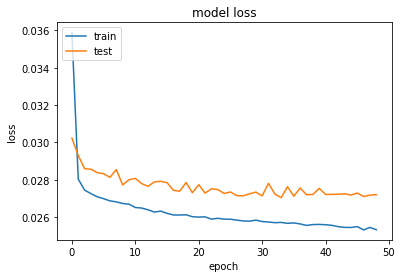

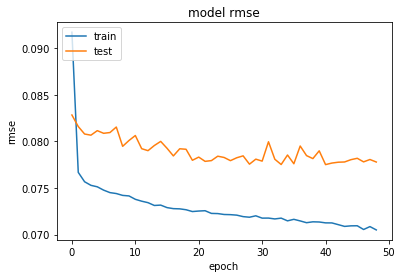

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  257.91538548469543 s =  4.298589766025543 min =  0.07164316296577454 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06684023747661025
Delay 100 ms: 0.0038878711178666502
Delay 200 ms: 0.013068485055987815
Delay 300 ms: 0.02549696319923188
Delay 400 ms: 0.039745540071156146
Delay 500 ms: 0.05515511648864036
Delay 600 ms: 0.07142393498211226
Delay 700 ms: 0.0883416919469677
Delay 800 ms: 0.10578776735366671
Delay 900 ms: 0.12364992383766962
Delay 1000 ms: 0.1418450807128034

RMSE
Average rmse: 0.1358133206335544
Delay 100 ms: 0.011011802632071662
Delay 200 ms: 0.027371126798598138
Delay 300 ms: 0.04888167944395799
Delay 400 ms: 0.07280103436969328
Delay 500 ms: 0.09796459397880951
Delay 600 ms: 0.12394454642554296
Delay 700 ms: 0.15047839217058848
Delay 800 ms: 0.17749571823148494
Delay 900 ms: 0.20494526642830202
Delay 1000 ms: 0.23274967893817344

SMAPE
Average smape: 15.423704311378794
Delay 100 ms: 2.117069135315295
Delay 200 ms: 5.485596971956687
Delay 300 ms: 8.843418672927221
Delay 400 ms: 11.975881182983985
Delay 500 ms: 14.855408976020628
Delay 600 ms: 17.532766958305338
De

(5778, 25, 3) (5778, 10, 3)


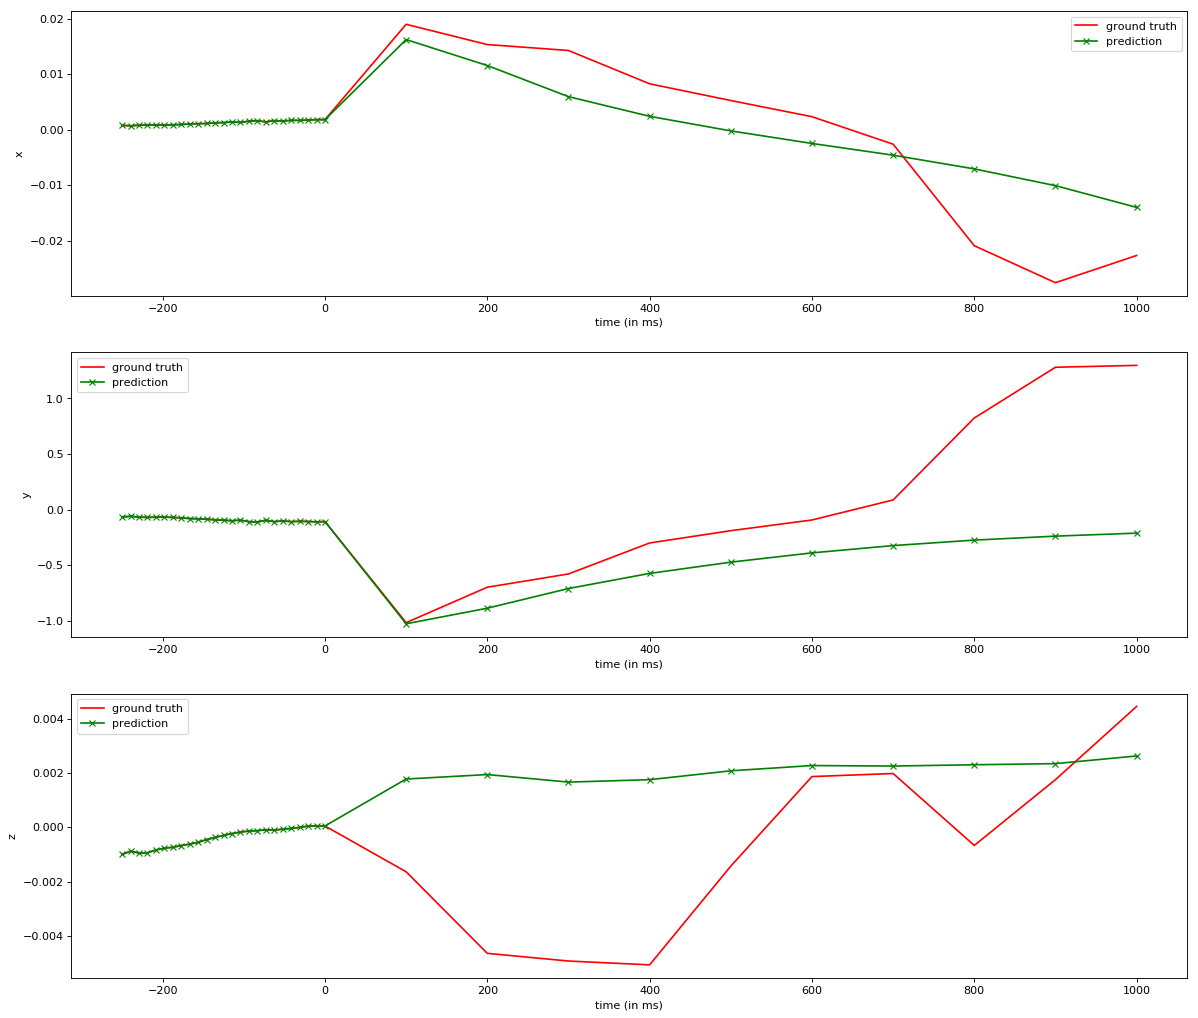

In [19]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)

Y_pred = decode_sequence(encoder_input)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')